In [1]:
import numpy as np
import pandas as pd
import warnings
import time
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
from sktime.alignment.dtw_python import AlignerDTWfromDist
from sktime.dists_kernels.scipy_dist import ScipyDist
from sktime.dists_kernels.compose_from_align import DistFromAligner

## Form a dictionary

### 0. Preprocess the dataset

#### Convert MTS datasets into arrays and save them as pickle files for accessing later to measure DTWD distances

In [2]:
# Define a function to z-normalize a column
def z_normalize(column):
    mean = column.mean()
    std = column.std()
    z_normalized = (column - mean) / std
    return z_normalized

# Z-Normalized DTWD Distances
# Filter the DataFrame by numbers from the list
def filter_and_save_data(original_df, number_list):
    data_dict = {}
    for number in number_list:
        filtered_df = original_df[original_df['Subject']==number].reset_index()
        filtered_df = filtered_df.drop(columns=['Subject','index'])
        df_normalized = filtered_df.apply(z_normalize)
        data_dict[number] = np.array(df_normalized)
    return data_dict

#### Formulate a function to calculate DTWD distances between 2 MTS

In [3]:
def dtwd_distance_calc(array1, array2):
    # multivariate euclidean distance between vectors
    eucl_dist = ScipyDist()
    # dtw-d alignment = DTW alignment using multivariate euclidean distance
    dtw_d_align = AlignerDTWfromDist(eucl_dist)
    # dtw-d distance between time series = distance matrix of the ddtw aligner
    dtw_d_dist = DistFromAligner(dtw_d_align)
    distance = dtw_d_dist(array1, array2)
    return distance 

#### Construct the final result matrix with DTWD distances recorded for various different time series

In [4]:
def load_and_access_data(file_name,desired_number):
    with open(file_name, 'rb') as file:
        loaded_data_dict = pickle.load(file)
        desired_array = loaded_data_dict.get(desired_number) #Just added to see if the processing is done correctly
    return desired_array

In [5]:
def dtwd_dist_mat_form(number_list,pkl_filename):

    # Initialize result matrix
    result_matrix = np.zeros((len(number_list), len(number_list)))
    
    for i, number1 in enumerate(number_list):
        for j, number2 in enumerate(number_list):

            # Get stored arrays from the pickle file
            loaded_array_1 = load_and_access_data(pkl_filename,number1)
            loaded_array_2 = load_and_access_data(pkl_filename,number2)
            
            # Call dtwd_distance_calc function to calculate DTW distance
            distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
            
            display(f"Element [{i}, {j}] constructed. Progress: {i}/{len(number_list)} - {j}/{len(number_list)}")
            
            result_matrix[i, j] = distance
            
    result_df = pd.DataFrame(result_matrix, index=number_list, columns=number_list)
    return result_df

In [6]:
def dtwd_dist_calc_rest(number_list,pkl_filename,current_index):
    
    dtwd_dist_list = []
    for number in (number_list):
        # Get stored arrays from the pickle file
        loaded_array_1 = load_and_access_data(pkl_filename,number)
        loaded_array_2 = load_and_access_data(pkl_filename,current_index)
        distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
        distance_value = distance[0, 0]
        dtwd_dist_list.append(distance_value)
    mean_dist = (statistics.mean(dtwd_dist_list)).tolist()
    return mean_dist

### 1. Randomly sample subjects

In [8]:
# Read dataframe from the pickle file
normal_df = pd.read_pickle('normal_EMO_pain.pkl')

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.0610,0.98543,0.99366,0.97667,1.0778,1.0222,0.91566,0.91127,1.0622,0.99518,...,0.000018,6.842100e-07,1.117200e-06,0.000001,0.000054,0.003015,0.001449,0.003680,0.103040,1
1,1.0611,0.98530,0.99360,0.97673,1.0778,1.0222,0.91565,0.91106,1.0627,0.99497,...,0.000016,2.404500e-06,1.436100e-06,0.000001,0.000029,0.009904,0.002355,0.004888,0.058659,1
2,1.0612,0.98517,0.99356,0.97680,1.0778,1.0221,0.91564,0.91102,1.0631,0.99491,...,0.000006,1.724400e-07,1.402800e-06,0.000001,0.000022,0.007058,0.002968,0.004549,0.028170,1
3,1.0613,0.98512,0.99351,0.97688,1.0778,1.0221,0.91558,0.91076,1.0633,0.99500,...,0.000003,3.844300e-07,2.665200e-06,0.000001,0.000009,0.003072,0.001221,0.002663,0.012835,1
4,1.0613,0.98511,0.99348,0.97693,1.0778,1.0220,0.91566,0.91048,1.0635,0.99514,...,0.000003,1.111800e-06,1.414900e-08,0.000002,0.000002,0.002561,0.000981,0.001777,0.005852,1


In [12]:
# Randomly sample 1/3rd MTS from the dataset
n_unique_sub =  (normal_df['Subject']).nunique()
subjects_list = (normal_df['Subject']).unique()
num_random_numbers = 67
random_seed = 42
random.seed(random_seed)
random_subjects = random.sample(subjects_list.tolist(), num_random_numbers)
display("Randomly sampled subjects:", random_subjects)

'Randomly sampled subjects:'

[1035,
 189,
 45,
 1224,
 455,
 401,
 367,
 242,
 1212,
 167,
 1102,
 1223,
 891,
 145,
 956,
 686,
 52,
 50,
 151,
 361,
 377,
 823,
 972,
 47,
 918,
 328,
 1165,
 1052,
 1140,
 676,
 364,
 735,
 955,
 459,
 7,
 1263,
 268,
 1134,
 541,
 263,
 358,
 1267,
 527,
 150,
 630,
 158,
 590,
 553,
 980,
 435,
 68,
 1203,
 749,
 880,
 210,
 628,
 128,
 907,
 477,
 1019,
 1006,
 605,
 941,
 318,
 1143,
 103,
 70]

#### 1.1 Normalize MTS

In [ ]:
# Save arrays
original_df = normal_df
number_list = subjects_list
normalized_dict = filter_and_save_data(original_df, number_list)  # Call the function: Filter, transpose, and save

In [ ]:
# Prepare the control DTW pickle file
file_name = 'normalized_df.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(normalized_dict, file)

In [15]:
# Specify the path to your pickle file
pickle_file_path = 'normalized_df.pickle'

# Open the pickle file in binary mode (rb stands for read binary)
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    final_normal_df = pickle.load(file)

{1: array([[ 1.63424454, -1.77480671, -0.32651754, ...,  0.3988552 ,
          0.68041828,  1.62875829],
        [ 1.65704053, -1.7934663 , -0.35001787, ...,  1.72897093,
          1.43533944,  0.67325201],
        [ 1.67983652, -1.81212588, -0.36568476, ...,  2.62740432,
          1.22318391,  0.01683528],
        ...,
        [-3.33528132,  3.4168648 ,  2.5483565 , ..., -0.09621491,
          0.69404524,  0.0441779 ],
        [-3.56324123,  3.56040009,  2.58752372, ..., -0.5561723 ,
         -0.05149957, -0.19047348],
        [-3.79120113,  3.70393539,  2.58752372, ..., -0.35509226,
         -0.29172165, -0.21124957]]),
 2: array([[-1.20162069,  1.29463954, -1.62708475, ...,  0.48844316,
         -0.96744207, -0.48571884],
        [-1.26372637,  1.33375791, -1.62708475, ..., -0.22836947,
         -1.18934306, -0.351991  ],
        [-1.31962148,  1.37776608, -1.58402309, ..., -0.6915756 ,
         -0.43810931, -0.5922367 ],
        ...,
        [ 0.20817824, -0.635363  , -0.0338034 , 

### 2. Generate DTW_D matrix from sampled MTS

In [23]:
number_list = random_subjects
# display(number_list)
initial_DTW_matrix = dtwd_dist_mat_form(number_list,'normalized_df.pickle')

'Element [0, 0] constructed. Progress: 0/67 - 0/67'

'Element [0, 1] constructed. Progress: 0/67 - 1/67'

'Element [0, 2] constructed. Progress: 0/67 - 2/67'

'Element [0, 3] constructed. Progress: 0/67 - 3/67'

'Element [0, 4] constructed. Progress: 0/67 - 4/67'

'Element [0, 5] constructed. Progress: 0/67 - 5/67'

'Element [0, 6] constructed. Progress: 0/67 - 6/67'

'Element [0, 7] constructed. Progress: 0/67 - 7/67'

'Element [0, 8] constructed. Progress: 0/67 - 8/67'

'Element [0, 9] constructed. Progress: 0/67 - 9/67'

'Element [0, 10] constructed. Progress: 0/67 - 10/67'

'Element [0, 11] constructed. Progress: 0/67 - 11/67'

'Element [0, 12] constructed. Progress: 0/67 - 12/67'

'Element [0, 13] constructed. Progress: 0/67 - 13/67'

'Element [0, 14] constructed. Progress: 0/67 - 14/67'

'Element [0, 15] constructed. Progress: 0/67 - 15/67'

'Element [0, 16] constructed. Progress: 0/67 - 16/67'

'Element [0, 17] constructed. Progress: 0/67 - 17/67'

'Element [0, 18] constructed. Progress: 0/67 - 18/67'

'Element [0, 19] constructed. Progress: 0/67 - 19/67'

'Element [0, 20] constructed. Progress: 0/67 - 20/67'

'Element [0, 21] constructed. Progress: 0/67 - 21/67'

'Element [0, 22] constructed. Progress: 0/67 - 22/67'

'Element [0, 23] constructed. Progress: 0/67 - 23/67'

'Element [0, 24] constructed. Progress: 0/67 - 24/67'

'Element [0, 25] constructed. Progress: 0/67 - 25/67'

'Element [0, 26] constructed. Progress: 0/67 - 26/67'

'Element [0, 27] constructed. Progress: 0/67 - 27/67'

'Element [0, 28] constructed. Progress: 0/67 - 28/67'

'Element [0, 29] constructed. Progress: 0/67 - 29/67'

'Element [0, 30] constructed. Progress: 0/67 - 30/67'

'Element [0, 31] constructed. Progress: 0/67 - 31/67'

'Element [0, 32] constructed. Progress: 0/67 - 32/67'

'Element [0, 33] constructed. Progress: 0/67 - 33/67'

'Element [0, 34] constructed. Progress: 0/67 - 34/67'

'Element [0, 35] constructed. Progress: 0/67 - 35/67'

'Element [0, 36] constructed. Progress: 0/67 - 36/67'

'Element [0, 37] constructed. Progress: 0/67 - 37/67'

'Element [0, 38] constructed. Progress: 0/67 - 38/67'

'Element [0, 39] constructed. Progress: 0/67 - 39/67'

'Element [0, 40] constructed. Progress: 0/67 - 40/67'

'Element [0, 41] constructed. Progress: 0/67 - 41/67'

'Element [0, 42] constructed. Progress: 0/67 - 42/67'

'Element [0, 43] constructed. Progress: 0/67 - 43/67'

'Element [0, 44] constructed. Progress: 0/67 - 44/67'

'Element [0, 45] constructed. Progress: 0/67 - 45/67'

'Element [0, 46] constructed. Progress: 0/67 - 46/67'

'Element [0, 47] constructed. Progress: 0/67 - 47/67'

'Element [0, 48] constructed. Progress: 0/67 - 48/67'

'Element [0, 49] constructed. Progress: 0/67 - 49/67'

'Element [0, 50] constructed. Progress: 0/67 - 50/67'

'Element [0, 51] constructed. Progress: 0/67 - 51/67'

'Element [0, 52] constructed. Progress: 0/67 - 52/67'

'Element [0, 53] constructed. Progress: 0/67 - 53/67'

'Element [0, 54] constructed. Progress: 0/67 - 54/67'

'Element [0, 55] constructed. Progress: 0/67 - 55/67'

'Element [0, 56] constructed. Progress: 0/67 - 56/67'

'Element [0, 57] constructed. Progress: 0/67 - 57/67'

'Element [0, 58] constructed. Progress: 0/67 - 58/67'

'Element [0, 59] constructed. Progress: 0/67 - 59/67'

'Element [0, 60] constructed. Progress: 0/67 - 60/67'

'Element [0, 61] constructed. Progress: 0/67 - 61/67'

'Element [0, 62] constructed. Progress: 0/67 - 62/67'

'Element [0, 63] constructed. Progress: 0/67 - 63/67'

'Element [0, 64] constructed. Progress: 0/67 - 64/67'

'Element [0, 65] constructed. Progress: 0/67 - 65/67'

'Element [0, 66] constructed. Progress: 0/67 - 66/67'

'Element [1, 0] constructed. Progress: 1/67 - 0/67'

'Element [1, 1] constructed. Progress: 1/67 - 1/67'

'Element [1, 2] constructed. Progress: 1/67 - 2/67'

'Element [1, 3] constructed. Progress: 1/67 - 3/67'

'Element [1, 4] constructed. Progress: 1/67 - 4/67'

'Element [1, 5] constructed. Progress: 1/67 - 5/67'

'Element [1, 6] constructed. Progress: 1/67 - 6/67'

'Element [1, 7] constructed. Progress: 1/67 - 7/67'

'Element [1, 8] constructed. Progress: 1/67 - 8/67'

'Element [1, 9] constructed. Progress: 1/67 - 9/67'

'Element [1, 10] constructed. Progress: 1/67 - 10/67'

'Element [1, 11] constructed. Progress: 1/67 - 11/67'

'Element [1, 12] constructed. Progress: 1/67 - 12/67'

'Element [1, 13] constructed. Progress: 1/67 - 13/67'

'Element [1, 14] constructed. Progress: 1/67 - 14/67'

'Element [1, 15] constructed. Progress: 1/67 - 15/67'

'Element [1, 16] constructed. Progress: 1/67 - 16/67'

'Element [1, 17] constructed. Progress: 1/67 - 17/67'

'Element [1, 18] constructed. Progress: 1/67 - 18/67'

'Element [1, 19] constructed. Progress: 1/67 - 19/67'

'Element [1, 20] constructed. Progress: 1/67 - 20/67'

'Element [1, 21] constructed. Progress: 1/67 - 21/67'

'Element [1, 22] constructed. Progress: 1/67 - 22/67'

'Element [1, 23] constructed. Progress: 1/67 - 23/67'

'Element [1, 24] constructed. Progress: 1/67 - 24/67'

'Element [1, 25] constructed. Progress: 1/67 - 25/67'

'Element [1, 26] constructed. Progress: 1/67 - 26/67'

'Element [1, 27] constructed. Progress: 1/67 - 27/67'

'Element [1, 28] constructed. Progress: 1/67 - 28/67'

'Element [1, 29] constructed. Progress: 1/67 - 29/67'

'Element [1, 30] constructed. Progress: 1/67 - 30/67'

'Element [1, 31] constructed. Progress: 1/67 - 31/67'

'Element [1, 32] constructed. Progress: 1/67 - 32/67'

'Element [1, 33] constructed. Progress: 1/67 - 33/67'

'Element [1, 34] constructed. Progress: 1/67 - 34/67'

'Element [1, 35] constructed. Progress: 1/67 - 35/67'

'Element [1, 36] constructed. Progress: 1/67 - 36/67'

'Element [1, 37] constructed. Progress: 1/67 - 37/67'

'Element [1, 38] constructed. Progress: 1/67 - 38/67'

'Element [1, 39] constructed. Progress: 1/67 - 39/67'

'Element [1, 40] constructed. Progress: 1/67 - 40/67'

'Element [1, 41] constructed. Progress: 1/67 - 41/67'

'Element [1, 42] constructed. Progress: 1/67 - 42/67'

'Element [1, 43] constructed. Progress: 1/67 - 43/67'

'Element [1, 44] constructed. Progress: 1/67 - 44/67'

'Element [1, 45] constructed. Progress: 1/67 - 45/67'

'Element [1, 46] constructed. Progress: 1/67 - 46/67'

'Element [1, 47] constructed. Progress: 1/67 - 47/67'

'Element [1, 48] constructed. Progress: 1/67 - 48/67'

'Element [1, 49] constructed. Progress: 1/67 - 49/67'

'Element [1, 50] constructed. Progress: 1/67 - 50/67'

'Element [1, 51] constructed. Progress: 1/67 - 51/67'

'Element [1, 52] constructed. Progress: 1/67 - 52/67'

'Element [1, 53] constructed. Progress: 1/67 - 53/67'

'Element [1, 54] constructed. Progress: 1/67 - 54/67'

'Element [1, 55] constructed. Progress: 1/67 - 55/67'

'Element [1, 56] constructed. Progress: 1/67 - 56/67'

'Element [1, 57] constructed. Progress: 1/67 - 57/67'

'Element [1, 58] constructed. Progress: 1/67 - 58/67'

'Element [1, 59] constructed. Progress: 1/67 - 59/67'

'Element [1, 60] constructed. Progress: 1/67 - 60/67'

'Element [1, 61] constructed. Progress: 1/67 - 61/67'

'Element [1, 62] constructed. Progress: 1/67 - 62/67'

'Element [1, 63] constructed. Progress: 1/67 - 63/67'

'Element [1, 64] constructed. Progress: 1/67 - 64/67'

'Element [1, 65] constructed. Progress: 1/67 - 65/67'

'Element [1, 66] constructed. Progress: 1/67 - 66/67'

'Element [2, 0] constructed. Progress: 2/67 - 0/67'

'Element [2, 1] constructed. Progress: 2/67 - 1/67'

'Element [2, 2] constructed. Progress: 2/67 - 2/67'

'Element [2, 3] constructed. Progress: 2/67 - 3/67'

'Element [2, 4] constructed. Progress: 2/67 - 4/67'

'Element [2, 5] constructed. Progress: 2/67 - 5/67'

'Element [2, 6] constructed. Progress: 2/67 - 6/67'

'Element [2, 7] constructed. Progress: 2/67 - 7/67'

'Element [2, 8] constructed. Progress: 2/67 - 8/67'

'Element [2, 9] constructed. Progress: 2/67 - 9/67'

'Element [2, 10] constructed. Progress: 2/67 - 10/67'

'Element [2, 11] constructed. Progress: 2/67 - 11/67'

'Element [2, 12] constructed. Progress: 2/67 - 12/67'

'Element [2, 13] constructed. Progress: 2/67 - 13/67'

'Element [2, 14] constructed. Progress: 2/67 - 14/67'

'Element [2, 15] constructed. Progress: 2/67 - 15/67'

'Element [2, 16] constructed. Progress: 2/67 - 16/67'

'Element [2, 17] constructed. Progress: 2/67 - 17/67'

'Element [2, 18] constructed. Progress: 2/67 - 18/67'

'Element [2, 19] constructed. Progress: 2/67 - 19/67'

'Element [2, 20] constructed. Progress: 2/67 - 20/67'

'Element [2, 21] constructed. Progress: 2/67 - 21/67'

'Element [2, 22] constructed. Progress: 2/67 - 22/67'

'Element [2, 23] constructed. Progress: 2/67 - 23/67'

'Element [2, 24] constructed. Progress: 2/67 - 24/67'

'Element [2, 25] constructed. Progress: 2/67 - 25/67'

'Element [2, 26] constructed. Progress: 2/67 - 26/67'

'Element [2, 27] constructed. Progress: 2/67 - 27/67'

'Element [2, 28] constructed. Progress: 2/67 - 28/67'

'Element [2, 29] constructed. Progress: 2/67 - 29/67'

'Element [2, 30] constructed. Progress: 2/67 - 30/67'

'Element [2, 31] constructed. Progress: 2/67 - 31/67'

'Element [2, 32] constructed. Progress: 2/67 - 32/67'

'Element [2, 33] constructed. Progress: 2/67 - 33/67'

'Element [2, 34] constructed. Progress: 2/67 - 34/67'

'Element [2, 35] constructed. Progress: 2/67 - 35/67'

'Element [2, 36] constructed. Progress: 2/67 - 36/67'

'Element [2, 37] constructed. Progress: 2/67 - 37/67'

'Element [2, 38] constructed. Progress: 2/67 - 38/67'

'Element [2, 39] constructed. Progress: 2/67 - 39/67'

'Element [2, 40] constructed. Progress: 2/67 - 40/67'

'Element [2, 41] constructed. Progress: 2/67 - 41/67'

'Element [2, 42] constructed. Progress: 2/67 - 42/67'

'Element [2, 43] constructed. Progress: 2/67 - 43/67'

'Element [2, 44] constructed. Progress: 2/67 - 44/67'

'Element [2, 45] constructed. Progress: 2/67 - 45/67'

'Element [2, 46] constructed. Progress: 2/67 - 46/67'

'Element [2, 47] constructed. Progress: 2/67 - 47/67'

'Element [2, 48] constructed. Progress: 2/67 - 48/67'

'Element [2, 49] constructed. Progress: 2/67 - 49/67'

'Element [2, 50] constructed. Progress: 2/67 - 50/67'

'Element [2, 51] constructed. Progress: 2/67 - 51/67'

'Element [2, 52] constructed. Progress: 2/67 - 52/67'

'Element [2, 53] constructed. Progress: 2/67 - 53/67'

'Element [2, 54] constructed. Progress: 2/67 - 54/67'

'Element [2, 55] constructed. Progress: 2/67 - 55/67'

'Element [2, 56] constructed. Progress: 2/67 - 56/67'

'Element [2, 57] constructed. Progress: 2/67 - 57/67'

'Element [2, 58] constructed. Progress: 2/67 - 58/67'

'Element [2, 59] constructed. Progress: 2/67 - 59/67'

'Element [2, 60] constructed. Progress: 2/67 - 60/67'

'Element [2, 61] constructed. Progress: 2/67 - 61/67'

'Element [2, 62] constructed. Progress: 2/67 - 62/67'

'Element [2, 63] constructed. Progress: 2/67 - 63/67'

'Element [2, 64] constructed. Progress: 2/67 - 64/67'

'Element [2, 65] constructed. Progress: 2/67 - 65/67'

'Element [2, 66] constructed. Progress: 2/67 - 66/67'

'Element [3, 0] constructed. Progress: 3/67 - 0/67'

'Element [3, 1] constructed. Progress: 3/67 - 1/67'

'Element [3, 2] constructed. Progress: 3/67 - 2/67'

'Element [3, 3] constructed. Progress: 3/67 - 3/67'

'Element [3, 4] constructed. Progress: 3/67 - 4/67'

'Element [3, 5] constructed. Progress: 3/67 - 5/67'

'Element [3, 6] constructed. Progress: 3/67 - 6/67'

'Element [3, 7] constructed. Progress: 3/67 - 7/67'

'Element [3, 8] constructed. Progress: 3/67 - 8/67'

'Element [3, 9] constructed. Progress: 3/67 - 9/67'

'Element [3, 10] constructed. Progress: 3/67 - 10/67'

'Element [3, 11] constructed. Progress: 3/67 - 11/67'

'Element [3, 12] constructed. Progress: 3/67 - 12/67'

'Element [3, 13] constructed. Progress: 3/67 - 13/67'

'Element [3, 14] constructed. Progress: 3/67 - 14/67'

'Element [3, 15] constructed. Progress: 3/67 - 15/67'

'Element [3, 16] constructed. Progress: 3/67 - 16/67'

'Element [3, 17] constructed. Progress: 3/67 - 17/67'

'Element [3, 18] constructed. Progress: 3/67 - 18/67'

'Element [3, 19] constructed. Progress: 3/67 - 19/67'

'Element [3, 20] constructed. Progress: 3/67 - 20/67'

'Element [3, 21] constructed. Progress: 3/67 - 21/67'

'Element [3, 22] constructed. Progress: 3/67 - 22/67'

'Element [3, 23] constructed. Progress: 3/67 - 23/67'

'Element [3, 24] constructed. Progress: 3/67 - 24/67'

'Element [3, 25] constructed. Progress: 3/67 - 25/67'

'Element [3, 26] constructed. Progress: 3/67 - 26/67'

'Element [3, 27] constructed. Progress: 3/67 - 27/67'

'Element [3, 28] constructed. Progress: 3/67 - 28/67'

'Element [3, 29] constructed. Progress: 3/67 - 29/67'

'Element [3, 30] constructed. Progress: 3/67 - 30/67'

'Element [3, 31] constructed. Progress: 3/67 - 31/67'

'Element [3, 32] constructed. Progress: 3/67 - 32/67'

'Element [3, 33] constructed. Progress: 3/67 - 33/67'

'Element [3, 34] constructed. Progress: 3/67 - 34/67'

'Element [3, 35] constructed. Progress: 3/67 - 35/67'

'Element [3, 36] constructed. Progress: 3/67 - 36/67'

'Element [3, 37] constructed. Progress: 3/67 - 37/67'

'Element [3, 38] constructed. Progress: 3/67 - 38/67'

'Element [3, 39] constructed. Progress: 3/67 - 39/67'

'Element [3, 40] constructed. Progress: 3/67 - 40/67'

'Element [3, 41] constructed. Progress: 3/67 - 41/67'

'Element [3, 42] constructed. Progress: 3/67 - 42/67'

'Element [3, 43] constructed. Progress: 3/67 - 43/67'

'Element [3, 44] constructed. Progress: 3/67 - 44/67'

'Element [3, 45] constructed. Progress: 3/67 - 45/67'

'Element [3, 46] constructed. Progress: 3/67 - 46/67'

'Element [3, 47] constructed. Progress: 3/67 - 47/67'

'Element [3, 48] constructed. Progress: 3/67 - 48/67'

'Element [3, 49] constructed. Progress: 3/67 - 49/67'

'Element [3, 50] constructed. Progress: 3/67 - 50/67'

'Element [3, 51] constructed. Progress: 3/67 - 51/67'

'Element [3, 52] constructed. Progress: 3/67 - 52/67'

'Element [3, 53] constructed. Progress: 3/67 - 53/67'

'Element [3, 54] constructed. Progress: 3/67 - 54/67'

'Element [3, 55] constructed. Progress: 3/67 - 55/67'

'Element [3, 56] constructed. Progress: 3/67 - 56/67'

'Element [3, 57] constructed. Progress: 3/67 - 57/67'

'Element [3, 58] constructed. Progress: 3/67 - 58/67'

'Element [3, 59] constructed. Progress: 3/67 - 59/67'

'Element [3, 60] constructed. Progress: 3/67 - 60/67'

'Element [3, 61] constructed. Progress: 3/67 - 61/67'

'Element [3, 62] constructed. Progress: 3/67 - 62/67'

'Element [3, 63] constructed. Progress: 3/67 - 63/67'

'Element [3, 64] constructed. Progress: 3/67 - 64/67'

'Element [3, 65] constructed. Progress: 3/67 - 65/67'

'Element [3, 66] constructed. Progress: 3/67 - 66/67'

'Element [4, 0] constructed. Progress: 4/67 - 0/67'

'Element [4, 1] constructed. Progress: 4/67 - 1/67'

'Element [4, 2] constructed. Progress: 4/67 - 2/67'

'Element [4, 3] constructed. Progress: 4/67 - 3/67'

'Element [4, 4] constructed. Progress: 4/67 - 4/67'

'Element [4, 5] constructed. Progress: 4/67 - 5/67'

'Element [4, 6] constructed. Progress: 4/67 - 6/67'

'Element [4, 7] constructed. Progress: 4/67 - 7/67'

'Element [4, 8] constructed. Progress: 4/67 - 8/67'

'Element [4, 9] constructed. Progress: 4/67 - 9/67'

'Element [4, 10] constructed. Progress: 4/67 - 10/67'

'Element [4, 11] constructed. Progress: 4/67 - 11/67'

'Element [4, 12] constructed. Progress: 4/67 - 12/67'

'Element [4, 13] constructed. Progress: 4/67 - 13/67'

'Element [4, 14] constructed. Progress: 4/67 - 14/67'

'Element [4, 15] constructed. Progress: 4/67 - 15/67'

'Element [4, 16] constructed. Progress: 4/67 - 16/67'

'Element [4, 17] constructed. Progress: 4/67 - 17/67'

'Element [4, 18] constructed. Progress: 4/67 - 18/67'

'Element [4, 19] constructed. Progress: 4/67 - 19/67'

'Element [4, 20] constructed. Progress: 4/67 - 20/67'

'Element [4, 21] constructed. Progress: 4/67 - 21/67'

'Element [4, 22] constructed. Progress: 4/67 - 22/67'

'Element [4, 23] constructed. Progress: 4/67 - 23/67'

'Element [4, 24] constructed. Progress: 4/67 - 24/67'

'Element [4, 25] constructed. Progress: 4/67 - 25/67'

'Element [4, 26] constructed. Progress: 4/67 - 26/67'

'Element [4, 27] constructed. Progress: 4/67 - 27/67'

'Element [4, 28] constructed. Progress: 4/67 - 28/67'

'Element [4, 29] constructed. Progress: 4/67 - 29/67'

'Element [4, 30] constructed. Progress: 4/67 - 30/67'

'Element [4, 31] constructed. Progress: 4/67 - 31/67'

'Element [4, 32] constructed. Progress: 4/67 - 32/67'

'Element [4, 33] constructed. Progress: 4/67 - 33/67'

'Element [4, 34] constructed. Progress: 4/67 - 34/67'

'Element [4, 35] constructed. Progress: 4/67 - 35/67'

'Element [4, 36] constructed. Progress: 4/67 - 36/67'

'Element [4, 37] constructed. Progress: 4/67 - 37/67'

'Element [4, 38] constructed. Progress: 4/67 - 38/67'

'Element [4, 39] constructed. Progress: 4/67 - 39/67'

'Element [4, 40] constructed. Progress: 4/67 - 40/67'

'Element [4, 41] constructed. Progress: 4/67 - 41/67'

'Element [4, 42] constructed. Progress: 4/67 - 42/67'

'Element [4, 43] constructed. Progress: 4/67 - 43/67'

'Element [4, 44] constructed. Progress: 4/67 - 44/67'

'Element [4, 45] constructed. Progress: 4/67 - 45/67'

'Element [4, 46] constructed. Progress: 4/67 - 46/67'

'Element [4, 47] constructed. Progress: 4/67 - 47/67'

'Element [4, 48] constructed. Progress: 4/67 - 48/67'

'Element [4, 49] constructed. Progress: 4/67 - 49/67'

'Element [4, 50] constructed. Progress: 4/67 - 50/67'

'Element [4, 51] constructed. Progress: 4/67 - 51/67'

'Element [4, 52] constructed. Progress: 4/67 - 52/67'

'Element [4, 53] constructed. Progress: 4/67 - 53/67'

'Element [4, 54] constructed. Progress: 4/67 - 54/67'

'Element [4, 55] constructed. Progress: 4/67 - 55/67'

'Element [4, 56] constructed. Progress: 4/67 - 56/67'

'Element [4, 57] constructed. Progress: 4/67 - 57/67'

'Element [4, 58] constructed. Progress: 4/67 - 58/67'

'Element [4, 59] constructed. Progress: 4/67 - 59/67'

'Element [4, 60] constructed. Progress: 4/67 - 60/67'

'Element [4, 61] constructed. Progress: 4/67 - 61/67'

'Element [4, 62] constructed. Progress: 4/67 - 62/67'

'Element [4, 63] constructed. Progress: 4/67 - 63/67'

'Element [4, 64] constructed. Progress: 4/67 - 64/67'

'Element [4, 65] constructed. Progress: 4/67 - 65/67'

'Element [4, 66] constructed. Progress: 4/67 - 66/67'

'Element [5, 0] constructed. Progress: 5/67 - 0/67'

'Element [5, 1] constructed. Progress: 5/67 - 1/67'

'Element [5, 2] constructed. Progress: 5/67 - 2/67'

'Element [5, 3] constructed. Progress: 5/67 - 3/67'

'Element [5, 4] constructed. Progress: 5/67 - 4/67'

'Element [5, 5] constructed. Progress: 5/67 - 5/67'

'Element [5, 6] constructed. Progress: 5/67 - 6/67'

'Element [5, 7] constructed. Progress: 5/67 - 7/67'

'Element [5, 8] constructed. Progress: 5/67 - 8/67'

'Element [5, 9] constructed. Progress: 5/67 - 9/67'

'Element [5, 10] constructed. Progress: 5/67 - 10/67'

'Element [5, 11] constructed. Progress: 5/67 - 11/67'

'Element [5, 12] constructed. Progress: 5/67 - 12/67'

'Element [5, 13] constructed. Progress: 5/67 - 13/67'

'Element [5, 14] constructed. Progress: 5/67 - 14/67'

'Element [5, 15] constructed. Progress: 5/67 - 15/67'

'Element [5, 16] constructed. Progress: 5/67 - 16/67'

'Element [5, 17] constructed. Progress: 5/67 - 17/67'

'Element [5, 18] constructed. Progress: 5/67 - 18/67'

'Element [5, 19] constructed. Progress: 5/67 - 19/67'

'Element [5, 20] constructed. Progress: 5/67 - 20/67'

'Element [5, 21] constructed. Progress: 5/67 - 21/67'

'Element [5, 22] constructed. Progress: 5/67 - 22/67'

'Element [5, 23] constructed. Progress: 5/67 - 23/67'

'Element [5, 24] constructed. Progress: 5/67 - 24/67'

'Element [5, 25] constructed. Progress: 5/67 - 25/67'

'Element [5, 26] constructed. Progress: 5/67 - 26/67'

'Element [5, 27] constructed. Progress: 5/67 - 27/67'

'Element [5, 28] constructed. Progress: 5/67 - 28/67'

'Element [5, 29] constructed. Progress: 5/67 - 29/67'

'Element [5, 30] constructed. Progress: 5/67 - 30/67'

'Element [5, 31] constructed. Progress: 5/67 - 31/67'

'Element [5, 32] constructed. Progress: 5/67 - 32/67'

'Element [5, 33] constructed. Progress: 5/67 - 33/67'

'Element [5, 34] constructed. Progress: 5/67 - 34/67'

'Element [5, 35] constructed. Progress: 5/67 - 35/67'

'Element [5, 36] constructed. Progress: 5/67 - 36/67'

'Element [5, 37] constructed. Progress: 5/67 - 37/67'

'Element [5, 38] constructed. Progress: 5/67 - 38/67'

'Element [5, 39] constructed. Progress: 5/67 - 39/67'

'Element [5, 40] constructed. Progress: 5/67 - 40/67'

'Element [5, 41] constructed. Progress: 5/67 - 41/67'

'Element [5, 42] constructed. Progress: 5/67 - 42/67'

'Element [5, 43] constructed. Progress: 5/67 - 43/67'

'Element [5, 44] constructed. Progress: 5/67 - 44/67'

'Element [5, 45] constructed. Progress: 5/67 - 45/67'

'Element [5, 46] constructed. Progress: 5/67 - 46/67'

'Element [5, 47] constructed. Progress: 5/67 - 47/67'

'Element [5, 48] constructed. Progress: 5/67 - 48/67'

'Element [5, 49] constructed. Progress: 5/67 - 49/67'

'Element [5, 50] constructed. Progress: 5/67 - 50/67'

'Element [5, 51] constructed. Progress: 5/67 - 51/67'

'Element [5, 52] constructed. Progress: 5/67 - 52/67'

'Element [5, 53] constructed. Progress: 5/67 - 53/67'

'Element [5, 54] constructed. Progress: 5/67 - 54/67'

'Element [5, 55] constructed. Progress: 5/67 - 55/67'

'Element [5, 56] constructed. Progress: 5/67 - 56/67'

'Element [5, 57] constructed. Progress: 5/67 - 57/67'

'Element [5, 58] constructed. Progress: 5/67 - 58/67'

'Element [5, 59] constructed. Progress: 5/67 - 59/67'

'Element [5, 60] constructed. Progress: 5/67 - 60/67'

'Element [5, 61] constructed. Progress: 5/67 - 61/67'

'Element [5, 62] constructed. Progress: 5/67 - 62/67'

'Element [5, 63] constructed. Progress: 5/67 - 63/67'

'Element [5, 64] constructed. Progress: 5/67 - 64/67'

'Element [5, 65] constructed. Progress: 5/67 - 65/67'

'Element [5, 66] constructed. Progress: 5/67 - 66/67'

'Element [6, 0] constructed. Progress: 6/67 - 0/67'

'Element [6, 1] constructed. Progress: 6/67 - 1/67'

'Element [6, 2] constructed. Progress: 6/67 - 2/67'

'Element [6, 3] constructed. Progress: 6/67 - 3/67'

'Element [6, 4] constructed. Progress: 6/67 - 4/67'

'Element [6, 5] constructed. Progress: 6/67 - 5/67'

'Element [6, 6] constructed. Progress: 6/67 - 6/67'

'Element [6, 7] constructed. Progress: 6/67 - 7/67'

'Element [6, 8] constructed. Progress: 6/67 - 8/67'

'Element [6, 9] constructed. Progress: 6/67 - 9/67'

'Element [6, 10] constructed. Progress: 6/67 - 10/67'

'Element [6, 11] constructed. Progress: 6/67 - 11/67'

'Element [6, 12] constructed. Progress: 6/67 - 12/67'

'Element [6, 13] constructed. Progress: 6/67 - 13/67'

'Element [6, 14] constructed. Progress: 6/67 - 14/67'

'Element [6, 15] constructed. Progress: 6/67 - 15/67'

'Element [6, 16] constructed. Progress: 6/67 - 16/67'

'Element [6, 17] constructed. Progress: 6/67 - 17/67'

'Element [6, 18] constructed. Progress: 6/67 - 18/67'

'Element [6, 19] constructed. Progress: 6/67 - 19/67'

'Element [6, 20] constructed. Progress: 6/67 - 20/67'

'Element [6, 21] constructed. Progress: 6/67 - 21/67'

'Element [6, 22] constructed. Progress: 6/67 - 22/67'

'Element [6, 23] constructed. Progress: 6/67 - 23/67'

'Element [6, 24] constructed. Progress: 6/67 - 24/67'

'Element [6, 25] constructed. Progress: 6/67 - 25/67'

'Element [6, 26] constructed. Progress: 6/67 - 26/67'

'Element [6, 27] constructed. Progress: 6/67 - 27/67'

'Element [6, 28] constructed. Progress: 6/67 - 28/67'

'Element [6, 29] constructed. Progress: 6/67 - 29/67'

'Element [6, 30] constructed. Progress: 6/67 - 30/67'

'Element [6, 31] constructed. Progress: 6/67 - 31/67'

'Element [6, 32] constructed. Progress: 6/67 - 32/67'

'Element [6, 33] constructed. Progress: 6/67 - 33/67'

'Element [6, 34] constructed. Progress: 6/67 - 34/67'

'Element [6, 35] constructed. Progress: 6/67 - 35/67'

'Element [6, 36] constructed. Progress: 6/67 - 36/67'

'Element [6, 37] constructed. Progress: 6/67 - 37/67'

'Element [6, 38] constructed. Progress: 6/67 - 38/67'

'Element [6, 39] constructed. Progress: 6/67 - 39/67'

'Element [6, 40] constructed. Progress: 6/67 - 40/67'

'Element [6, 41] constructed. Progress: 6/67 - 41/67'

'Element [6, 42] constructed. Progress: 6/67 - 42/67'

'Element [6, 43] constructed. Progress: 6/67 - 43/67'

'Element [6, 44] constructed. Progress: 6/67 - 44/67'

'Element [6, 45] constructed. Progress: 6/67 - 45/67'

'Element [6, 46] constructed. Progress: 6/67 - 46/67'

'Element [6, 47] constructed. Progress: 6/67 - 47/67'

'Element [6, 48] constructed. Progress: 6/67 - 48/67'

'Element [6, 49] constructed. Progress: 6/67 - 49/67'

'Element [6, 50] constructed. Progress: 6/67 - 50/67'

'Element [6, 51] constructed. Progress: 6/67 - 51/67'

'Element [6, 52] constructed. Progress: 6/67 - 52/67'

'Element [6, 53] constructed. Progress: 6/67 - 53/67'

'Element [6, 54] constructed. Progress: 6/67 - 54/67'

'Element [6, 55] constructed. Progress: 6/67 - 55/67'

'Element [6, 56] constructed. Progress: 6/67 - 56/67'

'Element [6, 57] constructed. Progress: 6/67 - 57/67'

'Element [6, 58] constructed. Progress: 6/67 - 58/67'

'Element [6, 59] constructed. Progress: 6/67 - 59/67'

'Element [6, 60] constructed. Progress: 6/67 - 60/67'

'Element [6, 61] constructed. Progress: 6/67 - 61/67'

'Element [6, 62] constructed. Progress: 6/67 - 62/67'

'Element [6, 63] constructed. Progress: 6/67 - 63/67'

'Element [6, 64] constructed. Progress: 6/67 - 64/67'

'Element [6, 65] constructed. Progress: 6/67 - 65/67'

'Element [6, 66] constructed. Progress: 6/67 - 66/67'

'Element [7, 0] constructed. Progress: 7/67 - 0/67'

'Element [7, 1] constructed. Progress: 7/67 - 1/67'

'Element [7, 2] constructed. Progress: 7/67 - 2/67'

'Element [7, 3] constructed. Progress: 7/67 - 3/67'

'Element [7, 4] constructed. Progress: 7/67 - 4/67'

'Element [7, 5] constructed. Progress: 7/67 - 5/67'

'Element [7, 6] constructed. Progress: 7/67 - 6/67'

'Element [7, 7] constructed. Progress: 7/67 - 7/67'

'Element [7, 8] constructed. Progress: 7/67 - 8/67'

'Element [7, 9] constructed. Progress: 7/67 - 9/67'

'Element [7, 10] constructed. Progress: 7/67 - 10/67'

'Element [7, 11] constructed. Progress: 7/67 - 11/67'

'Element [7, 12] constructed. Progress: 7/67 - 12/67'

'Element [7, 13] constructed. Progress: 7/67 - 13/67'

'Element [7, 14] constructed. Progress: 7/67 - 14/67'

'Element [7, 15] constructed. Progress: 7/67 - 15/67'

'Element [7, 16] constructed. Progress: 7/67 - 16/67'

'Element [7, 17] constructed. Progress: 7/67 - 17/67'

'Element [7, 18] constructed. Progress: 7/67 - 18/67'

'Element [7, 19] constructed. Progress: 7/67 - 19/67'

'Element [7, 20] constructed. Progress: 7/67 - 20/67'

'Element [7, 21] constructed. Progress: 7/67 - 21/67'

'Element [7, 22] constructed. Progress: 7/67 - 22/67'

'Element [7, 23] constructed. Progress: 7/67 - 23/67'

'Element [7, 24] constructed. Progress: 7/67 - 24/67'

'Element [7, 25] constructed. Progress: 7/67 - 25/67'

'Element [7, 26] constructed. Progress: 7/67 - 26/67'

'Element [7, 27] constructed. Progress: 7/67 - 27/67'

'Element [7, 28] constructed. Progress: 7/67 - 28/67'

'Element [7, 29] constructed. Progress: 7/67 - 29/67'

'Element [7, 30] constructed. Progress: 7/67 - 30/67'

'Element [7, 31] constructed. Progress: 7/67 - 31/67'

'Element [7, 32] constructed. Progress: 7/67 - 32/67'

'Element [7, 33] constructed. Progress: 7/67 - 33/67'

'Element [7, 34] constructed. Progress: 7/67 - 34/67'

'Element [7, 35] constructed. Progress: 7/67 - 35/67'

'Element [7, 36] constructed. Progress: 7/67 - 36/67'

'Element [7, 37] constructed. Progress: 7/67 - 37/67'

'Element [7, 38] constructed. Progress: 7/67 - 38/67'

'Element [7, 39] constructed. Progress: 7/67 - 39/67'

'Element [7, 40] constructed. Progress: 7/67 - 40/67'

'Element [7, 41] constructed. Progress: 7/67 - 41/67'

'Element [7, 42] constructed. Progress: 7/67 - 42/67'

'Element [7, 43] constructed. Progress: 7/67 - 43/67'

'Element [7, 44] constructed. Progress: 7/67 - 44/67'

'Element [7, 45] constructed. Progress: 7/67 - 45/67'

'Element [7, 46] constructed. Progress: 7/67 - 46/67'

'Element [7, 47] constructed. Progress: 7/67 - 47/67'

'Element [7, 48] constructed. Progress: 7/67 - 48/67'

'Element [7, 49] constructed. Progress: 7/67 - 49/67'

'Element [7, 50] constructed. Progress: 7/67 - 50/67'

'Element [7, 51] constructed. Progress: 7/67 - 51/67'

'Element [7, 52] constructed. Progress: 7/67 - 52/67'

'Element [7, 53] constructed. Progress: 7/67 - 53/67'

'Element [7, 54] constructed. Progress: 7/67 - 54/67'

'Element [7, 55] constructed. Progress: 7/67 - 55/67'

'Element [7, 56] constructed. Progress: 7/67 - 56/67'

'Element [7, 57] constructed. Progress: 7/67 - 57/67'

'Element [7, 58] constructed. Progress: 7/67 - 58/67'

'Element [7, 59] constructed. Progress: 7/67 - 59/67'

'Element [7, 60] constructed. Progress: 7/67 - 60/67'

'Element [7, 61] constructed. Progress: 7/67 - 61/67'

'Element [7, 62] constructed. Progress: 7/67 - 62/67'

'Element [7, 63] constructed. Progress: 7/67 - 63/67'

'Element [7, 64] constructed. Progress: 7/67 - 64/67'

'Element [7, 65] constructed. Progress: 7/67 - 65/67'

'Element [7, 66] constructed. Progress: 7/67 - 66/67'

'Element [8, 0] constructed. Progress: 8/67 - 0/67'

'Element [8, 1] constructed. Progress: 8/67 - 1/67'

'Element [8, 2] constructed. Progress: 8/67 - 2/67'

'Element [8, 3] constructed. Progress: 8/67 - 3/67'

'Element [8, 4] constructed. Progress: 8/67 - 4/67'

'Element [8, 5] constructed. Progress: 8/67 - 5/67'

'Element [8, 6] constructed. Progress: 8/67 - 6/67'

'Element [8, 7] constructed. Progress: 8/67 - 7/67'

'Element [8, 8] constructed. Progress: 8/67 - 8/67'

'Element [8, 9] constructed. Progress: 8/67 - 9/67'

'Element [8, 10] constructed. Progress: 8/67 - 10/67'

'Element [8, 11] constructed. Progress: 8/67 - 11/67'

'Element [8, 12] constructed. Progress: 8/67 - 12/67'

'Element [8, 13] constructed. Progress: 8/67 - 13/67'

'Element [8, 14] constructed. Progress: 8/67 - 14/67'

'Element [8, 15] constructed. Progress: 8/67 - 15/67'

'Element [8, 16] constructed. Progress: 8/67 - 16/67'

'Element [8, 17] constructed. Progress: 8/67 - 17/67'

'Element [8, 18] constructed. Progress: 8/67 - 18/67'

'Element [8, 19] constructed. Progress: 8/67 - 19/67'

'Element [8, 20] constructed. Progress: 8/67 - 20/67'

'Element [8, 21] constructed. Progress: 8/67 - 21/67'

'Element [8, 22] constructed. Progress: 8/67 - 22/67'

'Element [8, 23] constructed. Progress: 8/67 - 23/67'

'Element [8, 24] constructed. Progress: 8/67 - 24/67'

'Element [8, 25] constructed. Progress: 8/67 - 25/67'

'Element [8, 26] constructed. Progress: 8/67 - 26/67'

'Element [8, 27] constructed. Progress: 8/67 - 27/67'

'Element [8, 28] constructed. Progress: 8/67 - 28/67'

'Element [8, 29] constructed. Progress: 8/67 - 29/67'

'Element [8, 30] constructed. Progress: 8/67 - 30/67'

'Element [8, 31] constructed. Progress: 8/67 - 31/67'

'Element [8, 32] constructed. Progress: 8/67 - 32/67'

'Element [8, 33] constructed. Progress: 8/67 - 33/67'

'Element [8, 34] constructed. Progress: 8/67 - 34/67'

'Element [8, 35] constructed. Progress: 8/67 - 35/67'

'Element [8, 36] constructed. Progress: 8/67 - 36/67'

'Element [8, 37] constructed. Progress: 8/67 - 37/67'

'Element [8, 38] constructed. Progress: 8/67 - 38/67'

'Element [8, 39] constructed. Progress: 8/67 - 39/67'

'Element [8, 40] constructed. Progress: 8/67 - 40/67'

'Element [8, 41] constructed. Progress: 8/67 - 41/67'

'Element [8, 42] constructed. Progress: 8/67 - 42/67'

'Element [8, 43] constructed. Progress: 8/67 - 43/67'

'Element [8, 44] constructed. Progress: 8/67 - 44/67'

'Element [8, 45] constructed. Progress: 8/67 - 45/67'

'Element [8, 46] constructed. Progress: 8/67 - 46/67'

'Element [8, 47] constructed. Progress: 8/67 - 47/67'

'Element [8, 48] constructed. Progress: 8/67 - 48/67'

'Element [8, 49] constructed. Progress: 8/67 - 49/67'

'Element [8, 50] constructed. Progress: 8/67 - 50/67'

'Element [8, 51] constructed. Progress: 8/67 - 51/67'

'Element [8, 52] constructed. Progress: 8/67 - 52/67'

'Element [8, 53] constructed. Progress: 8/67 - 53/67'

'Element [8, 54] constructed. Progress: 8/67 - 54/67'

'Element [8, 55] constructed. Progress: 8/67 - 55/67'

'Element [8, 56] constructed. Progress: 8/67 - 56/67'

'Element [8, 57] constructed. Progress: 8/67 - 57/67'

'Element [8, 58] constructed. Progress: 8/67 - 58/67'

'Element [8, 59] constructed. Progress: 8/67 - 59/67'

'Element [8, 60] constructed. Progress: 8/67 - 60/67'

'Element [8, 61] constructed. Progress: 8/67 - 61/67'

'Element [8, 62] constructed. Progress: 8/67 - 62/67'

'Element [8, 63] constructed. Progress: 8/67 - 63/67'

'Element [8, 64] constructed. Progress: 8/67 - 64/67'

'Element [8, 65] constructed. Progress: 8/67 - 65/67'

'Element [8, 66] constructed. Progress: 8/67 - 66/67'

'Element [9, 0] constructed. Progress: 9/67 - 0/67'

'Element [9, 1] constructed. Progress: 9/67 - 1/67'

'Element [9, 2] constructed. Progress: 9/67 - 2/67'

'Element [9, 3] constructed. Progress: 9/67 - 3/67'

'Element [9, 4] constructed. Progress: 9/67 - 4/67'

'Element [9, 5] constructed. Progress: 9/67 - 5/67'

'Element [9, 6] constructed. Progress: 9/67 - 6/67'

'Element [9, 7] constructed. Progress: 9/67 - 7/67'

'Element [9, 8] constructed. Progress: 9/67 - 8/67'

'Element [9, 9] constructed. Progress: 9/67 - 9/67'

'Element [9, 10] constructed. Progress: 9/67 - 10/67'

'Element [9, 11] constructed. Progress: 9/67 - 11/67'

'Element [9, 12] constructed. Progress: 9/67 - 12/67'

'Element [9, 13] constructed. Progress: 9/67 - 13/67'

'Element [9, 14] constructed. Progress: 9/67 - 14/67'

'Element [9, 15] constructed. Progress: 9/67 - 15/67'

'Element [9, 16] constructed. Progress: 9/67 - 16/67'

'Element [9, 17] constructed. Progress: 9/67 - 17/67'

'Element [9, 18] constructed. Progress: 9/67 - 18/67'

'Element [9, 19] constructed. Progress: 9/67 - 19/67'

'Element [9, 20] constructed. Progress: 9/67 - 20/67'

'Element [9, 21] constructed. Progress: 9/67 - 21/67'

'Element [9, 22] constructed. Progress: 9/67 - 22/67'

'Element [9, 23] constructed. Progress: 9/67 - 23/67'

'Element [9, 24] constructed. Progress: 9/67 - 24/67'

'Element [9, 25] constructed. Progress: 9/67 - 25/67'

'Element [9, 26] constructed. Progress: 9/67 - 26/67'

'Element [9, 27] constructed. Progress: 9/67 - 27/67'

'Element [9, 28] constructed. Progress: 9/67 - 28/67'

'Element [9, 29] constructed. Progress: 9/67 - 29/67'

'Element [9, 30] constructed. Progress: 9/67 - 30/67'

'Element [9, 31] constructed. Progress: 9/67 - 31/67'

'Element [9, 32] constructed. Progress: 9/67 - 32/67'

'Element [9, 33] constructed. Progress: 9/67 - 33/67'

'Element [9, 34] constructed. Progress: 9/67 - 34/67'

'Element [9, 35] constructed. Progress: 9/67 - 35/67'

'Element [9, 36] constructed. Progress: 9/67 - 36/67'

'Element [9, 37] constructed. Progress: 9/67 - 37/67'

'Element [9, 38] constructed. Progress: 9/67 - 38/67'

'Element [9, 39] constructed. Progress: 9/67 - 39/67'

'Element [9, 40] constructed. Progress: 9/67 - 40/67'

'Element [9, 41] constructed. Progress: 9/67 - 41/67'

'Element [9, 42] constructed. Progress: 9/67 - 42/67'

'Element [9, 43] constructed. Progress: 9/67 - 43/67'

'Element [9, 44] constructed. Progress: 9/67 - 44/67'

'Element [9, 45] constructed. Progress: 9/67 - 45/67'

'Element [9, 46] constructed. Progress: 9/67 - 46/67'

'Element [9, 47] constructed. Progress: 9/67 - 47/67'

'Element [9, 48] constructed. Progress: 9/67 - 48/67'

'Element [9, 49] constructed. Progress: 9/67 - 49/67'

'Element [9, 50] constructed. Progress: 9/67 - 50/67'

'Element [9, 51] constructed. Progress: 9/67 - 51/67'

'Element [9, 52] constructed. Progress: 9/67 - 52/67'

'Element [9, 53] constructed. Progress: 9/67 - 53/67'

'Element [9, 54] constructed. Progress: 9/67 - 54/67'

'Element [9, 55] constructed. Progress: 9/67 - 55/67'

'Element [9, 56] constructed. Progress: 9/67 - 56/67'

'Element [9, 57] constructed. Progress: 9/67 - 57/67'

'Element [9, 58] constructed. Progress: 9/67 - 58/67'

'Element [9, 59] constructed. Progress: 9/67 - 59/67'

'Element [9, 60] constructed. Progress: 9/67 - 60/67'

'Element [9, 61] constructed. Progress: 9/67 - 61/67'

'Element [9, 62] constructed. Progress: 9/67 - 62/67'

'Element [9, 63] constructed. Progress: 9/67 - 63/67'

'Element [9, 64] constructed. Progress: 9/67 - 64/67'

'Element [9, 65] constructed. Progress: 9/67 - 65/67'

'Element [9, 66] constructed. Progress: 9/67 - 66/67'

'Element [10, 0] constructed. Progress: 10/67 - 0/67'

'Element [10, 1] constructed. Progress: 10/67 - 1/67'

'Element [10, 2] constructed. Progress: 10/67 - 2/67'

'Element [10, 3] constructed. Progress: 10/67 - 3/67'

'Element [10, 4] constructed. Progress: 10/67 - 4/67'

'Element [10, 5] constructed. Progress: 10/67 - 5/67'

'Element [10, 6] constructed. Progress: 10/67 - 6/67'

'Element [10, 7] constructed. Progress: 10/67 - 7/67'

'Element [10, 8] constructed. Progress: 10/67 - 8/67'

'Element [10, 9] constructed. Progress: 10/67 - 9/67'

'Element [10, 10] constructed. Progress: 10/67 - 10/67'

'Element [10, 11] constructed. Progress: 10/67 - 11/67'

'Element [10, 12] constructed. Progress: 10/67 - 12/67'

'Element [10, 13] constructed. Progress: 10/67 - 13/67'

'Element [10, 14] constructed. Progress: 10/67 - 14/67'

'Element [10, 15] constructed. Progress: 10/67 - 15/67'

'Element [10, 16] constructed. Progress: 10/67 - 16/67'

'Element [10, 17] constructed. Progress: 10/67 - 17/67'

'Element [10, 18] constructed. Progress: 10/67 - 18/67'

'Element [10, 19] constructed. Progress: 10/67 - 19/67'

'Element [10, 20] constructed. Progress: 10/67 - 20/67'

'Element [10, 21] constructed. Progress: 10/67 - 21/67'

'Element [10, 22] constructed. Progress: 10/67 - 22/67'

'Element [10, 23] constructed. Progress: 10/67 - 23/67'

'Element [10, 24] constructed. Progress: 10/67 - 24/67'

'Element [10, 25] constructed. Progress: 10/67 - 25/67'

'Element [10, 26] constructed. Progress: 10/67 - 26/67'

'Element [10, 27] constructed. Progress: 10/67 - 27/67'

'Element [10, 28] constructed. Progress: 10/67 - 28/67'

'Element [10, 29] constructed. Progress: 10/67 - 29/67'

'Element [10, 30] constructed. Progress: 10/67 - 30/67'

'Element [10, 31] constructed. Progress: 10/67 - 31/67'

'Element [10, 32] constructed. Progress: 10/67 - 32/67'

'Element [10, 33] constructed. Progress: 10/67 - 33/67'

'Element [10, 34] constructed. Progress: 10/67 - 34/67'

'Element [10, 35] constructed. Progress: 10/67 - 35/67'

'Element [10, 36] constructed. Progress: 10/67 - 36/67'

'Element [10, 37] constructed. Progress: 10/67 - 37/67'

'Element [10, 38] constructed. Progress: 10/67 - 38/67'

'Element [10, 39] constructed. Progress: 10/67 - 39/67'

'Element [10, 40] constructed. Progress: 10/67 - 40/67'

'Element [10, 41] constructed. Progress: 10/67 - 41/67'

'Element [10, 42] constructed. Progress: 10/67 - 42/67'

'Element [10, 43] constructed. Progress: 10/67 - 43/67'

'Element [10, 44] constructed. Progress: 10/67 - 44/67'

'Element [10, 45] constructed. Progress: 10/67 - 45/67'

'Element [10, 46] constructed. Progress: 10/67 - 46/67'

'Element [10, 47] constructed. Progress: 10/67 - 47/67'

'Element [10, 48] constructed. Progress: 10/67 - 48/67'

'Element [10, 49] constructed. Progress: 10/67 - 49/67'

'Element [10, 50] constructed. Progress: 10/67 - 50/67'

'Element [10, 51] constructed. Progress: 10/67 - 51/67'

'Element [10, 52] constructed. Progress: 10/67 - 52/67'

'Element [10, 53] constructed. Progress: 10/67 - 53/67'

'Element [10, 54] constructed. Progress: 10/67 - 54/67'

'Element [10, 55] constructed. Progress: 10/67 - 55/67'

'Element [10, 56] constructed. Progress: 10/67 - 56/67'

'Element [10, 57] constructed. Progress: 10/67 - 57/67'

'Element [10, 58] constructed. Progress: 10/67 - 58/67'

'Element [10, 59] constructed. Progress: 10/67 - 59/67'

'Element [10, 60] constructed. Progress: 10/67 - 60/67'

'Element [10, 61] constructed. Progress: 10/67 - 61/67'

'Element [10, 62] constructed. Progress: 10/67 - 62/67'

'Element [10, 63] constructed. Progress: 10/67 - 63/67'

'Element [10, 64] constructed. Progress: 10/67 - 64/67'

'Element [10, 65] constructed. Progress: 10/67 - 65/67'

'Element [10, 66] constructed. Progress: 10/67 - 66/67'

'Element [11, 0] constructed. Progress: 11/67 - 0/67'

'Element [11, 1] constructed. Progress: 11/67 - 1/67'

'Element [11, 2] constructed. Progress: 11/67 - 2/67'

'Element [11, 3] constructed. Progress: 11/67 - 3/67'

'Element [11, 4] constructed. Progress: 11/67 - 4/67'

'Element [11, 5] constructed. Progress: 11/67 - 5/67'

'Element [11, 6] constructed. Progress: 11/67 - 6/67'

'Element [11, 7] constructed. Progress: 11/67 - 7/67'

'Element [11, 8] constructed. Progress: 11/67 - 8/67'

'Element [11, 9] constructed. Progress: 11/67 - 9/67'

'Element [11, 10] constructed. Progress: 11/67 - 10/67'

'Element [11, 11] constructed. Progress: 11/67 - 11/67'

'Element [11, 12] constructed. Progress: 11/67 - 12/67'

'Element [11, 13] constructed. Progress: 11/67 - 13/67'

'Element [11, 14] constructed. Progress: 11/67 - 14/67'

'Element [11, 15] constructed. Progress: 11/67 - 15/67'

'Element [11, 16] constructed. Progress: 11/67 - 16/67'

'Element [11, 17] constructed. Progress: 11/67 - 17/67'

'Element [11, 18] constructed. Progress: 11/67 - 18/67'

'Element [11, 19] constructed. Progress: 11/67 - 19/67'

'Element [11, 20] constructed. Progress: 11/67 - 20/67'

'Element [11, 21] constructed. Progress: 11/67 - 21/67'

'Element [11, 22] constructed. Progress: 11/67 - 22/67'

'Element [11, 23] constructed. Progress: 11/67 - 23/67'

'Element [11, 24] constructed. Progress: 11/67 - 24/67'

'Element [11, 25] constructed. Progress: 11/67 - 25/67'

'Element [11, 26] constructed. Progress: 11/67 - 26/67'

'Element [11, 27] constructed. Progress: 11/67 - 27/67'

'Element [11, 28] constructed. Progress: 11/67 - 28/67'

'Element [11, 29] constructed. Progress: 11/67 - 29/67'

'Element [11, 30] constructed. Progress: 11/67 - 30/67'

'Element [11, 31] constructed. Progress: 11/67 - 31/67'

'Element [11, 32] constructed. Progress: 11/67 - 32/67'

'Element [11, 33] constructed. Progress: 11/67 - 33/67'

'Element [11, 34] constructed. Progress: 11/67 - 34/67'

'Element [11, 35] constructed. Progress: 11/67 - 35/67'

'Element [11, 36] constructed. Progress: 11/67 - 36/67'

'Element [11, 37] constructed. Progress: 11/67 - 37/67'

'Element [11, 38] constructed. Progress: 11/67 - 38/67'

'Element [11, 39] constructed. Progress: 11/67 - 39/67'

'Element [11, 40] constructed. Progress: 11/67 - 40/67'

'Element [11, 41] constructed. Progress: 11/67 - 41/67'

'Element [11, 42] constructed. Progress: 11/67 - 42/67'

'Element [11, 43] constructed. Progress: 11/67 - 43/67'

'Element [11, 44] constructed. Progress: 11/67 - 44/67'

'Element [11, 45] constructed. Progress: 11/67 - 45/67'

'Element [11, 46] constructed. Progress: 11/67 - 46/67'

'Element [11, 47] constructed. Progress: 11/67 - 47/67'

'Element [11, 48] constructed. Progress: 11/67 - 48/67'

'Element [11, 49] constructed. Progress: 11/67 - 49/67'

'Element [11, 50] constructed. Progress: 11/67 - 50/67'

'Element [11, 51] constructed. Progress: 11/67 - 51/67'

'Element [11, 52] constructed. Progress: 11/67 - 52/67'

'Element [11, 53] constructed. Progress: 11/67 - 53/67'

'Element [11, 54] constructed. Progress: 11/67 - 54/67'

'Element [11, 55] constructed. Progress: 11/67 - 55/67'

'Element [11, 56] constructed. Progress: 11/67 - 56/67'

'Element [11, 57] constructed. Progress: 11/67 - 57/67'

'Element [11, 58] constructed. Progress: 11/67 - 58/67'

'Element [11, 59] constructed. Progress: 11/67 - 59/67'

'Element [11, 60] constructed. Progress: 11/67 - 60/67'

'Element [11, 61] constructed. Progress: 11/67 - 61/67'

'Element [11, 62] constructed. Progress: 11/67 - 62/67'

'Element [11, 63] constructed. Progress: 11/67 - 63/67'

'Element [11, 64] constructed. Progress: 11/67 - 64/67'

'Element [11, 65] constructed. Progress: 11/67 - 65/67'

'Element [11, 66] constructed. Progress: 11/67 - 66/67'

'Element [12, 0] constructed. Progress: 12/67 - 0/67'

'Element [12, 1] constructed. Progress: 12/67 - 1/67'

'Element [12, 2] constructed. Progress: 12/67 - 2/67'

'Element [12, 3] constructed. Progress: 12/67 - 3/67'

'Element [12, 4] constructed. Progress: 12/67 - 4/67'

'Element [12, 5] constructed. Progress: 12/67 - 5/67'

'Element [12, 6] constructed. Progress: 12/67 - 6/67'

'Element [12, 7] constructed. Progress: 12/67 - 7/67'

'Element [12, 8] constructed. Progress: 12/67 - 8/67'

'Element [12, 9] constructed. Progress: 12/67 - 9/67'

'Element [12, 10] constructed. Progress: 12/67 - 10/67'

'Element [12, 11] constructed. Progress: 12/67 - 11/67'

'Element [12, 12] constructed. Progress: 12/67 - 12/67'

'Element [12, 13] constructed. Progress: 12/67 - 13/67'

'Element [12, 14] constructed. Progress: 12/67 - 14/67'

'Element [12, 15] constructed. Progress: 12/67 - 15/67'

'Element [12, 16] constructed. Progress: 12/67 - 16/67'

'Element [12, 17] constructed. Progress: 12/67 - 17/67'

'Element [12, 18] constructed. Progress: 12/67 - 18/67'

'Element [12, 19] constructed. Progress: 12/67 - 19/67'

'Element [12, 20] constructed. Progress: 12/67 - 20/67'

'Element [12, 21] constructed. Progress: 12/67 - 21/67'

'Element [12, 22] constructed. Progress: 12/67 - 22/67'

'Element [12, 23] constructed. Progress: 12/67 - 23/67'

'Element [12, 24] constructed. Progress: 12/67 - 24/67'

'Element [12, 25] constructed. Progress: 12/67 - 25/67'

'Element [12, 26] constructed. Progress: 12/67 - 26/67'

'Element [12, 27] constructed. Progress: 12/67 - 27/67'

'Element [12, 28] constructed. Progress: 12/67 - 28/67'

'Element [12, 29] constructed. Progress: 12/67 - 29/67'

'Element [12, 30] constructed. Progress: 12/67 - 30/67'

'Element [12, 31] constructed. Progress: 12/67 - 31/67'

'Element [12, 32] constructed. Progress: 12/67 - 32/67'

'Element [12, 33] constructed. Progress: 12/67 - 33/67'

'Element [12, 34] constructed. Progress: 12/67 - 34/67'

'Element [12, 35] constructed. Progress: 12/67 - 35/67'

'Element [12, 36] constructed. Progress: 12/67 - 36/67'

'Element [12, 37] constructed. Progress: 12/67 - 37/67'

'Element [12, 38] constructed. Progress: 12/67 - 38/67'

'Element [12, 39] constructed. Progress: 12/67 - 39/67'

'Element [12, 40] constructed. Progress: 12/67 - 40/67'

'Element [12, 41] constructed. Progress: 12/67 - 41/67'

'Element [12, 42] constructed. Progress: 12/67 - 42/67'

'Element [12, 43] constructed. Progress: 12/67 - 43/67'

'Element [12, 44] constructed. Progress: 12/67 - 44/67'

'Element [12, 45] constructed. Progress: 12/67 - 45/67'

'Element [12, 46] constructed. Progress: 12/67 - 46/67'

'Element [12, 47] constructed. Progress: 12/67 - 47/67'

'Element [12, 48] constructed. Progress: 12/67 - 48/67'

'Element [12, 49] constructed. Progress: 12/67 - 49/67'

'Element [12, 50] constructed. Progress: 12/67 - 50/67'

'Element [12, 51] constructed. Progress: 12/67 - 51/67'

'Element [12, 52] constructed. Progress: 12/67 - 52/67'

'Element [12, 53] constructed. Progress: 12/67 - 53/67'

'Element [12, 54] constructed. Progress: 12/67 - 54/67'

'Element [12, 55] constructed. Progress: 12/67 - 55/67'

'Element [12, 56] constructed. Progress: 12/67 - 56/67'

'Element [12, 57] constructed. Progress: 12/67 - 57/67'

'Element [12, 58] constructed. Progress: 12/67 - 58/67'

'Element [12, 59] constructed. Progress: 12/67 - 59/67'

'Element [12, 60] constructed. Progress: 12/67 - 60/67'

'Element [12, 61] constructed. Progress: 12/67 - 61/67'

'Element [12, 62] constructed. Progress: 12/67 - 62/67'

'Element [12, 63] constructed. Progress: 12/67 - 63/67'

'Element [12, 64] constructed. Progress: 12/67 - 64/67'

'Element [12, 65] constructed. Progress: 12/67 - 65/67'

'Element [12, 66] constructed. Progress: 12/67 - 66/67'

'Element [13, 0] constructed. Progress: 13/67 - 0/67'

'Element [13, 1] constructed. Progress: 13/67 - 1/67'

'Element [13, 2] constructed. Progress: 13/67 - 2/67'

'Element [13, 3] constructed. Progress: 13/67 - 3/67'

'Element [13, 4] constructed. Progress: 13/67 - 4/67'

'Element [13, 5] constructed. Progress: 13/67 - 5/67'

'Element [13, 6] constructed. Progress: 13/67 - 6/67'

'Element [13, 7] constructed. Progress: 13/67 - 7/67'

'Element [13, 8] constructed. Progress: 13/67 - 8/67'

'Element [13, 9] constructed. Progress: 13/67 - 9/67'

'Element [13, 10] constructed. Progress: 13/67 - 10/67'

'Element [13, 11] constructed. Progress: 13/67 - 11/67'

'Element [13, 12] constructed. Progress: 13/67 - 12/67'

'Element [13, 13] constructed. Progress: 13/67 - 13/67'

'Element [13, 14] constructed. Progress: 13/67 - 14/67'

'Element [13, 15] constructed. Progress: 13/67 - 15/67'

'Element [13, 16] constructed. Progress: 13/67 - 16/67'

'Element [13, 17] constructed. Progress: 13/67 - 17/67'

'Element [13, 18] constructed. Progress: 13/67 - 18/67'

'Element [13, 19] constructed. Progress: 13/67 - 19/67'

'Element [13, 20] constructed. Progress: 13/67 - 20/67'

'Element [13, 21] constructed. Progress: 13/67 - 21/67'

'Element [13, 22] constructed. Progress: 13/67 - 22/67'

'Element [13, 23] constructed. Progress: 13/67 - 23/67'

'Element [13, 24] constructed. Progress: 13/67 - 24/67'

'Element [13, 25] constructed. Progress: 13/67 - 25/67'

'Element [13, 26] constructed. Progress: 13/67 - 26/67'

'Element [13, 27] constructed. Progress: 13/67 - 27/67'

'Element [13, 28] constructed. Progress: 13/67 - 28/67'

'Element [13, 29] constructed. Progress: 13/67 - 29/67'

'Element [13, 30] constructed. Progress: 13/67 - 30/67'

'Element [13, 31] constructed. Progress: 13/67 - 31/67'

'Element [13, 32] constructed. Progress: 13/67 - 32/67'

'Element [13, 33] constructed. Progress: 13/67 - 33/67'

'Element [13, 34] constructed. Progress: 13/67 - 34/67'

'Element [13, 35] constructed. Progress: 13/67 - 35/67'

'Element [13, 36] constructed. Progress: 13/67 - 36/67'

'Element [13, 37] constructed. Progress: 13/67 - 37/67'

'Element [13, 38] constructed. Progress: 13/67 - 38/67'

'Element [13, 39] constructed. Progress: 13/67 - 39/67'

'Element [13, 40] constructed. Progress: 13/67 - 40/67'

'Element [13, 41] constructed. Progress: 13/67 - 41/67'

'Element [13, 42] constructed. Progress: 13/67 - 42/67'

'Element [13, 43] constructed. Progress: 13/67 - 43/67'

'Element [13, 44] constructed. Progress: 13/67 - 44/67'

'Element [13, 45] constructed. Progress: 13/67 - 45/67'

'Element [13, 46] constructed. Progress: 13/67 - 46/67'

'Element [13, 47] constructed. Progress: 13/67 - 47/67'

'Element [13, 48] constructed. Progress: 13/67 - 48/67'

'Element [13, 49] constructed. Progress: 13/67 - 49/67'

'Element [13, 50] constructed. Progress: 13/67 - 50/67'

'Element [13, 51] constructed. Progress: 13/67 - 51/67'

'Element [13, 52] constructed. Progress: 13/67 - 52/67'

'Element [13, 53] constructed. Progress: 13/67 - 53/67'

'Element [13, 54] constructed. Progress: 13/67 - 54/67'

'Element [13, 55] constructed. Progress: 13/67 - 55/67'

'Element [13, 56] constructed. Progress: 13/67 - 56/67'

'Element [13, 57] constructed. Progress: 13/67 - 57/67'

'Element [13, 58] constructed. Progress: 13/67 - 58/67'

'Element [13, 59] constructed. Progress: 13/67 - 59/67'

'Element [13, 60] constructed. Progress: 13/67 - 60/67'

'Element [13, 61] constructed. Progress: 13/67 - 61/67'

'Element [13, 62] constructed. Progress: 13/67 - 62/67'

'Element [13, 63] constructed. Progress: 13/67 - 63/67'

'Element [13, 64] constructed. Progress: 13/67 - 64/67'

'Element [13, 65] constructed. Progress: 13/67 - 65/67'

'Element [13, 66] constructed. Progress: 13/67 - 66/67'

'Element [14, 0] constructed. Progress: 14/67 - 0/67'

'Element [14, 1] constructed. Progress: 14/67 - 1/67'

'Element [14, 2] constructed. Progress: 14/67 - 2/67'

'Element [14, 3] constructed. Progress: 14/67 - 3/67'

'Element [14, 4] constructed. Progress: 14/67 - 4/67'

'Element [14, 5] constructed. Progress: 14/67 - 5/67'

'Element [14, 6] constructed. Progress: 14/67 - 6/67'

'Element [14, 7] constructed. Progress: 14/67 - 7/67'

'Element [14, 8] constructed. Progress: 14/67 - 8/67'

'Element [14, 9] constructed. Progress: 14/67 - 9/67'

'Element [14, 10] constructed. Progress: 14/67 - 10/67'

'Element [14, 11] constructed. Progress: 14/67 - 11/67'

'Element [14, 12] constructed. Progress: 14/67 - 12/67'

'Element [14, 13] constructed. Progress: 14/67 - 13/67'

'Element [14, 14] constructed. Progress: 14/67 - 14/67'

'Element [14, 15] constructed. Progress: 14/67 - 15/67'

'Element [14, 16] constructed. Progress: 14/67 - 16/67'

'Element [14, 17] constructed. Progress: 14/67 - 17/67'

'Element [14, 18] constructed. Progress: 14/67 - 18/67'

'Element [14, 19] constructed. Progress: 14/67 - 19/67'

'Element [14, 20] constructed. Progress: 14/67 - 20/67'

'Element [14, 21] constructed. Progress: 14/67 - 21/67'

'Element [14, 22] constructed. Progress: 14/67 - 22/67'

'Element [14, 23] constructed. Progress: 14/67 - 23/67'

'Element [14, 24] constructed. Progress: 14/67 - 24/67'

'Element [14, 25] constructed. Progress: 14/67 - 25/67'

'Element [14, 26] constructed. Progress: 14/67 - 26/67'

'Element [14, 27] constructed. Progress: 14/67 - 27/67'

'Element [14, 28] constructed. Progress: 14/67 - 28/67'

'Element [14, 29] constructed. Progress: 14/67 - 29/67'

'Element [14, 30] constructed. Progress: 14/67 - 30/67'

'Element [14, 31] constructed. Progress: 14/67 - 31/67'

'Element [14, 32] constructed. Progress: 14/67 - 32/67'

'Element [14, 33] constructed. Progress: 14/67 - 33/67'

'Element [14, 34] constructed. Progress: 14/67 - 34/67'

'Element [14, 35] constructed. Progress: 14/67 - 35/67'

'Element [14, 36] constructed. Progress: 14/67 - 36/67'

'Element [14, 37] constructed. Progress: 14/67 - 37/67'

'Element [14, 38] constructed. Progress: 14/67 - 38/67'

'Element [14, 39] constructed. Progress: 14/67 - 39/67'

'Element [14, 40] constructed. Progress: 14/67 - 40/67'

'Element [14, 41] constructed. Progress: 14/67 - 41/67'

'Element [14, 42] constructed. Progress: 14/67 - 42/67'

'Element [14, 43] constructed. Progress: 14/67 - 43/67'

'Element [14, 44] constructed. Progress: 14/67 - 44/67'

'Element [14, 45] constructed. Progress: 14/67 - 45/67'

'Element [14, 46] constructed. Progress: 14/67 - 46/67'

'Element [14, 47] constructed. Progress: 14/67 - 47/67'

'Element [14, 48] constructed. Progress: 14/67 - 48/67'

'Element [14, 49] constructed. Progress: 14/67 - 49/67'

'Element [14, 50] constructed. Progress: 14/67 - 50/67'

'Element [14, 51] constructed. Progress: 14/67 - 51/67'

'Element [14, 52] constructed. Progress: 14/67 - 52/67'

'Element [14, 53] constructed. Progress: 14/67 - 53/67'

'Element [14, 54] constructed. Progress: 14/67 - 54/67'

'Element [14, 55] constructed. Progress: 14/67 - 55/67'

'Element [14, 56] constructed. Progress: 14/67 - 56/67'

'Element [14, 57] constructed. Progress: 14/67 - 57/67'

'Element [14, 58] constructed. Progress: 14/67 - 58/67'

'Element [14, 59] constructed. Progress: 14/67 - 59/67'

'Element [14, 60] constructed. Progress: 14/67 - 60/67'

'Element [14, 61] constructed. Progress: 14/67 - 61/67'

'Element [14, 62] constructed. Progress: 14/67 - 62/67'

'Element [14, 63] constructed. Progress: 14/67 - 63/67'

'Element [14, 64] constructed. Progress: 14/67 - 64/67'

'Element [14, 65] constructed. Progress: 14/67 - 65/67'

'Element [14, 66] constructed. Progress: 14/67 - 66/67'

'Element [15, 0] constructed. Progress: 15/67 - 0/67'

'Element [15, 1] constructed. Progress: 15/67 - 1/67'

'Element [15, 2] constructed. Progress: 15/67 - 2/67'

'Element [15, 3] constructed. Progress: 15/67 - 3/67'

'Element [15, 4] constructed. Progress: 15/67 - 4/67'

'Element [15, 5] constructed. Progress: 15/67 - 5/67'

'Element [15, 6] constructed. Progress: 15/67 - 6/67'

'Element [15, 7] constructed. Progress: 15/67 - 7/67'

'Element [15, 8] constructed. Progress: 15/67 - 8/67'

'Element [15, 9] constructed. Progress: 15/67 - 9/67'

'Element [15, 10] constructed. Progress: 15/67 - 10/67'

'Element [15, 11] constructed. Progress: 15/67 - 11/67'

'Element [15, 12] constructed. Progress: 15/67 - 12/67'

'Element [15, 13] constructed. Progress: 15/67 - 13/67'

'Element [15, 14] constructed. Progress: 15/67 - 14/67'

'Element [15, 15] constructed. Progress: 15/67 - 15/67'

'Element [15, 16] constructed. Progress: 15/67 - 16/67'

'Element [15, 17] constructed. Progress: 15/67 - 17/67'

'Element [15, 18] constructed. Progress: 15/67 - 18/67'

'Element [15, 19] constructed. Progress: 15/67 - 19/67'

'Element [15, 20] constructed. Progress: 15/67 - 20/67'

'Element [15, 21] constructed. Progress: 15/67 - 21/67'

'Element [15, 22] constructed. Progress: 15/67 - 22/67'

'Element [15, 23] constructed. Progress: 15/67 - 23/67'

'Element [15, 24] constructed. Progress: 15/67 - 24/67'

'Element [15, 25] constructed. Progress: 15/67 - 25/67'

'Element [15, 26] constructed. Progress: 15/67 - 26/67'

'Element [15, 27] constructed. Progress: 15/67 - 27/67'

'Element [15, 28] constructed. Progress: 15/67 - 28/67'

'Element [15, 29] constructed. Progress: 15/67 - 29/67'

'Element [15, 30] constructed. Progress: 15/67 - 30/67'

'Element [15, 31] constructed. Progress: 15/67 - 31/67'

'Element [15, 32] constructed. Progress: 15/67 - 32/67'

'Element [15, 33] constructed. Progress: 15/67 - 33/67'

'Element [15, 34] constructed. Progress: 15/67 - 34/67'

'Element [15, 35] constructed. Progress: 15/67 - 35/67'

'Element [15, 36] constructed. Progress: 15/67 - 36/67'

'Element [15, 37] constructed. Progress: 15/67 - 37/67'

'Element [15, 38] constructed. Progress: 15/67 - 38/67'

'Element [15, 39] constructed. Progress: 15/67 - 39/67'

'Element [15, 40] constructed. Progress: 15/67 - 40/67'

'Element [15, 41] constructed. Progress: 15/67 - 41/67'

'Element [15, 42] constructed. Progress: 15/67 - 42/67'

'Element [15, 43] constructed. Progress: 15/67 - 43/67'

'Element [15, 44] constructed. Progress: 15/67 - 44/67'

'Element [15, 45] constructed. Progress: 15/67 - 45/67'

'Element [15, 46] constructed. Progress: 15/67 - 46/67'

'Element [15, 47] constructed. Progress: 15/67 - 47/67'

'Element [15, 48] constructed. Progress: 15/67 - 48/67'

'Element [15, 49] constructed. Progress: 15/67 - 49/67'

'Element [15, 50] constructed. Progress: 15/67 - 50/67'

'Element [15, 51] constructed. Progress: 15/67 - 51/67'

'Element [15, 52] constructed. Progress: 15/67 - 52/67'

'Element [15, 53] constructed. Progress: 15/67 - 53/67'

'Element [15, 54] constructed. Progress: 15/67 - 54/67'

'Element [15, 55] constructed. Progress: 15/67 - 55/67'

'Element [15, 56] constructed. Progress: 15/67 - 56/67'

'Element [15, 57] constructed. Progress: 15/67 - 57/67'

'Element [15, 58] constructed. Progress: 15/67 - 58/67'

'Element [15, 59] constructed. Progress: 15/67 - 59/67'

'Element [15, 60] constructed. Progress: 15/67 - 60/67'

'Element [15, 61] constructed. Progress: 15/67 - 61/67'

'Element [15, 62] constructed. Progress: 15/67 - 62/67'

'Element [15, 63] constructed. Progress: 15/67 - 63/67'

'Element [15, 64] constructed. Progress: 15/67 - 64/67'

'Element [15, 65] constructed. Progress: 15/67 - 65/67'

'Element [15, 66] constructed. Progress: 15/67 - 66/67'

'Element [16, 0] constructed. Progress: 16/67 - 0/67'

'Element [16, 1] constructed. Progress: 16/67 - 1/67'

'Element [16, 2] constructed. Progress: 16/67 - 2/67'

'Element [16, 3] constructed. Progress: 16/67 - 3/67'

'Element [16, 4] constructed. Progress: 16/67 - 4/67'

'Element [16, 5] constructed. Progress: 16/67 - 5/67'

'Element [16, 6] constructed. Progress: 16/67 - 6/67'

'Element [16, 7] constructed. Progress: 16/67 - 7/67'

'Element [16, 8] constructed. Progress: 16/67 - 8/67'

'Element [16, 9] constructed. Progress: 16/67 - 9/67'

'Element [16, 10] constructed. Progress: 16/67 - 10/67'

'Element [16, 11] constructed. Progress: 16/67 - 11/67'

'Element [16, 12] constructed. Progress: 16/67 - 12/67'

'Element [16, 13] constructed. Progress: 16/67 - 13/67'

'Element [16, 14] constructed. Progress: 16/67 - 14/67'

'Element [16, 15] constructed. Progress: 16/67 - 15/67'

'Element [16, 16] constructed. Progress: 16/67 - 16/67'

'Element [16, 17] constructed. Progress: 16/67 - 17/67'

'Element [16, 18] constructed. Progress: 16/67 - 18/67'

'Element [16, 19] constructed. Progress: 16/67 - 19/67'

'Element [16, 20] constructed. Progress: 16/67 - 20/67'

'Element [16, 21] constructed. Progress: 16/67 - 21/67'

'Element [16, 22] constructed. Progress: 16/67 - 22/67'

'Element [16, 23] constructed. Progress: 16/67 - 23/67'

'Element [16, 24] constructed. Progress: 16/67 - 24/67'

'Element [16, 25] constructed. Progress: 16/67 - 25/67'

'Element [16, 26] constructed. Progress: 16/67 - 26/67'

'Element [16, 27] constructed. Progress: 16/67 - 27/67'

'Element [16, 28] constructed. Progress: 16/67 - 28/67'

'Element [16, 29] constructed. Progress: 16/67 - 29/67'

'Element [16, 30] constructed. Progress: 16/67 - 30/67'

'Element [16, 31] constructed. Progress: 16/67 - 31/67'

'Element [16, 32] constructed. Progress: 16/67 - 32/67'

'Element [16, 33] constructed. Progress: 16/67 - 33/67'

'Element [16, 34] constructed. Progress: 16/67 - 34/67'

'Element [16, 35] constructed. Progress: 16/67 - 35/67'

'Element [16, 36] constructed. Progress: 16/67 - 36/67'

'Element [16, 37] constructed. Progress: 16/67 - 37/67'

'Element [16, 38] constructed. Progress: 16/67 - 38/67'

'Element [16, 39] constructed. Progress: 16/67 - 39/67'

'Element [16, 40] constructed. Progress: 16/67 - 40/67'

'Element [16, 41] constructed. Progress: 16/67 - 41/67'

'Element [16, 42] constructed. Progress: 16/67 - 42/67'

'Element [16, 43] constructed. Progress: 16/67 - 43/67'

'Element [16, 44] constructed. Progress: 16/67 - 44/67'

'Element [16, 45] constructed. Progress: 16/67 - 45/67'

'Element [16, 46] constructed. Progress: 16/67 - 46/67'

'Element [16, 47] constructed. Progress: 16/67 - 47/67'

'Element [16, 48] constructed. Progress: 16/67 - 48/67'

'Element [16, 49] constructed. Progress: 16/67 - 49/67'

'Element [16, 50] constructed. Progress: 16/67 - 50/67'

'Element [16, 51] constructed. Progress: 16/67 - 51/67'

'Element [16, 52] constructed. Progress: 16/67 - 52/67'

'Element [16, 53] constructed. Progress: 16/67 - 53/67'

'Element [16, 54] constructed. Progress: 16/67 - 54/67'

'Element [16, 55] constructed. Progress: 16/67 - 55/67'

'Element [16, 56] constructed. Progress: 16/67 - 56/67'

'Element [16, 57] constructed. Progress: 16/67 - 57/67'

'Element [16, 58] constructed. Progress: 16/67 - 58/67'

'Element [16, 59] constructed. Progress: 16/67 - 59/67'

'Element [16, 60] constructed. Progress: 16/67 - 60/67'

'Element [16, 61] constructed. Progress: 16/67 - 61/67'

'Element [16, 62] constructed. Progress: 16/67 - 62/67'

'Element [16, 63] constructed. Progress: 16/67 - 63/67'

'Element [16, 64] constructed. Progress: 16/67 - 64/67'

'Element [16, 65] constructed. Progress: 16/67 - 65/67'

'Element [16, 66] constructed. Progress: 16/67 - 66/67'

'Element [17, 0] constructed. Progress: 17/67 - 0/67'

'Element [17, 1] constructed. Progress: 17/67 - 1/67'

'Element [17, 2] constructed. Progress: 17/67 - 2/67'

'Element [17, 3] constructed. Progress: 17/67 - 3/67'

'Element [17, 4] constructed. Progress: 17/67 - 4/67'

'Element [17, 5] constructed. Progress: 17/67 - 5/67'

'Element [17, 6] constructed. Progress: 17/67 - 6/67'

'Element [17, 7] constructed. Progress: 17/67 - 7/67'

'Element [17, 8] constructed. Progress: 17/67 - 8/67'

'Element [17, 9] constructed. Progress: 17/67 - 9/67'

'Element [17, 10] constructed. Progress: 17/67 - 10/67'

'Element [17, 11] constructed. Progress: 17/67 - 11/67'

'Element [17, 12] constructed. Progress: 17/67 - 12/67'

'Element [17, 13] constructed. Progress: 17/67 - 13/67'

'Element [17, 14] constructed. Progress: 17/67 - 14/67'

'Element [17, 15] constructed. Progress: 17/67 - 15/67'

'Element [17, 16] constructed. Progress: 17/67 - 16/67'

'Element [17, 17] constructed. Progress: 17/67 - 17/67'

'Element [17, 18] constructed. Progress: 17/67 - 18/67'

'Element [17, 19] constructed. Progress: 17/67 - 19/67'

'Element [17, 20] constructed. Progress: 17/67 - 20/67'

'Element [17, 21] constructed. Progress: 17/67 - 21/67'

'Element [17, 22] constructed. Progress: 17/67 - 22/67'

'Element [17, 23] constructed. Progress: 17/67 - 23/67'

'Element [17, 24] constructed. Progress: 17/67 - 24/67'

'Element [17, 25] constructed. Progress: 17/67 - 25/67'

'Element [17, 26] constructed. Progress: 17/67 - 26/67'

'Element [17, 27] constructed. Progress: 17/67 - 27/67'

'Element [17, 28] constructed. Progress: 17/67 - 28/67'

'Element [17, 29] constructed. Progress: 17/67 - 29/67'

'Element [17, 30] constructed. Progress: 17/67 - 30/67'

'Element [17, 31] constructed. Progress: 17/67 - 31/67'

'Element [17, 32] constructed. Progress: 17/67 - 32/67'

'Element [17, 33] constructed. Progress: 17/67 - 33/67'

'Element [17, 34] constructed. Progress: 17/67 - 34/67'

'Element [17, 35] constructed. Progress: 17/67 - 35/67'

'Element [17, 36] constructed. Progress: 17/67 - 36/67'

'Element [17, 37] constructed. Progress: 17/67 - 37/67'

'Element [17, 38] constructed. Progress: 17/67 - 38/67'

'Element [17, 39] constructed. Progress: 17/67 - 39/67'

'Element [17, 40] constructed. Progress: 17/67 - 40/67'

'Element [17, 41] constructed. Progress: 17/67 - 41/67'

'Element [17, 42] constructed. Progress: 17/67 - 42/67'

'Element [17, 43] constructed. Progress: 17/67 - 43/67'

'Element [17, 44] constructed. Progress: 17/67 - 44/67'

'Element [17, 45] constructed. Progress: 17/67 - 45/67'

'Element [17, 46] constructed. Progress: 17/67 - 46/67'

'Element [17, 47] constructed. Progress: 17/67 - 47/67'

'Element [17, 48] constructed. Progress: 17/67 - 48/67'

'Element [17, 49] constructed. Progress: 17/67 - 49/67'

'Element [17, 50] constructed. Progress: 17/67 - 50/67'

'Element [17, 51] constructed. Progress: 17/67 - 51/67'

'Element [17, 52] constructed. Progress: 17/67 - 52/67'

'Element [17, 53] constructed. Progress: 17/67 - 53/67'

'Element [17, 54] constructed. Progress: 17/67 - 54/67'

'Element [17, 55] constructed. Progress: 17/67 - 55/67'

'Element [17, 56] constructed. Progress: 17/67 - 56/67'

'Element [17, 57] constructed. Progress: 17/67 - 57/67'

'Element [17, 58] constructed. Progress: 17/67 - 58/67'

'Element [17, 59] constructed. Progress: 17/67 - 59/67'

'Element [17, 60] constructed. Progress: 17/67 - 60/67'

'Element [17, 61] constructed. Progress: 17/67 - 61/67'

'Element [17, 62] constructed. Progress: 17/67 - 62/67'

'Element [17, 63] constructed. Progress: 17/67 - 63/67'

'Element [17, 64] constructed. Progress: 17/67 - 64/67'

'Element [17, 65] constructed. Progress: 17/67 - 65/67'

'Element [17, 66] constructed. Progress: 17/67 - 66/67'

'Element [18, 0] constructed. Progress: 18/67 - 0/67'

'Element [18, 1] constructed. Progress: 18/67 - 1/67'

'Element [18, 2] constructed. Progress: 18/67 - 2/67'

'Element [18, 3] constructed. Progress: 18/67 - 3/67'

'Element [18, 4] constructed. Progress: 18/67 - 4/67'

'Element [18, 5] constructed. Progress: 18/67 - 5/67'

'Element [18, 6] constructed. Progress: 18/67 - 6/67'

'Element [18, 7] constructed. Progress: 18/67 - 7/67'

'Element [18, 8] constructed. Progress: 18/67 - 8/67'

'Element [18, 9] constructed. Progress: 18/67 - 9/67'

'Element [18, 10] constructed. Progress: 18/67 - 10/67'

'Element [18, 11] constructed. Progress: 18/67 - 11/67'

'Element [18, 12] constructed. Progress: 18/67 - 12/67'

'Element [18, 13] constructed. Progress: 18/67 - 13/67'

'Element [18, 14] constructed. Progress: 18/67 - 14/67'

'Element [18, 15] constructed. Progress: 18/67 - 15/67'

'Element [18, 16] constructed. Progress: 18/67 - 16/67'

'Element [18, 17] constructed. Progress: 18/67 - 17/67'

'Element [18, 18] constructed. Progress: 18/67 - 18/67'

'Element [18, 19] constructed. Progress: 18/67 - 19/67'

'Element [18, 20] constructed. Progress: 18/67 - 20/67'

'Element [18, 21] constructed. Progress: 18/67 - 21/67'

'Element [18, 22] constructed. Progress: 18/67 - 22/67'

'Element [18, 23] constructed. Progress: 18/67 - 23/67'

'Element [18, 24] constructed. Progress: 18/67 - 24/67'

'Element [18, 25] constructed. Progress: 18/67 - 25/67'

'Element [18, 26] constructed. Progress: 18/67 - 26/67'

'Element [18, 27] constructed. Progress: 18/67 - 27/67'

'Element [18, 28] constructed. Progress: 18/67 - 28/67'

'Element [18, 29] constructed. Progress: 18/67 - 29/67'

'Element [18, 30] constructed. Progress: 18/67 - 30/67'

'Element [18, 31] constructed. Progress: 18/67 - 31/67'

'Element [18, 32] constructed. Progress: 18/67 - 32/67'

'Element [18, 33] constructed. Progress: 18/67 - 33/67'

'Element [18, 34] constructed. Progress: 18/67 - 34/67'

'Element [18, 35] constructed. Progress: 18/67 - 35/67'

'Element [18, 36] constructed. Progress: 18/67 - 36/67'

'Element [18, 37] constructed. Progress: 18/67 - 37/67'

'Element [18, 38] constructed. Progress: 18/67 - 38/67'

'Element [18, 39] constructed. Progress: 18/67 - 39/67'

'Element [18, 40] constructed. Progress: 18/67 - 40/67'

'Element [18, 41] constructed. Progress: 18/67 - 41/67'

'Element [18, 42] constructed. Progress: 18/67 - 42/67'

'Element [18, 43] constructed. Progress: 18/67 - 43/67'

'Element [18, 44] constructed. Progress: 18/67 - 44/67'

'Element [18, 45] constructed. Progress: 18/67 - 45/67'

'Element [18, 46] constructed. Progress: 18/67 - 46/67'

'Element [18, 47] constructed. Progress: 18/67 - 47/67'

'Element [18, 48] constructed. Progress: 18/67 - 48/67'

'Element [18, 49] constructed. Progress: 18/67 - 49/67'

'Element [18, 50] constructed. Progress: 18/67 - 50/67'

'Element [18, 51] constructed. Progress: 18/67 - 51/67'

'Element [18, 52] constructed. Progress: 18/67 - 52/67'

'Element [18, 53] constructed. Progress: 18/67 - 53/67'

'Element [18, 54] constructed. Progress: 18/67 - 54/67'

'Element [18, 55] constructed. Progress: 18/67 - 55/67'

'Element [18, 56] constructed. Progress: 18/67 - 56/67'

'Element [18, 57] constructed. Progress: 18/67 - 57/67'

'Element [18, 58] constructed. Progress: 18/67 - 58/67'

'Element [18, 59] constructed. Progress: 18/67 - 59/67'

'Element [18, 60] constructed. Progress: 18/67 - 60/67'

'Element [18, 61] constructed. Progress: 18/67 - 61/67'

'Element [18, 62] constructed. Progress: 18/67 - 62/67'

'Element [18, 63] constructed. Progress: 18/67 - 63/67'

'Element [18, 64] constructed. Progress: 18/67 - 64/67'

'Element [18, 65] constructed. Progress: 18/67 - 65/67'

'Element [18, 66] constructed. Progress: 18/67 - 66/67'

'Element [19, 0] constructed. Progress: 19/67 - 0/67'

'Element [19, 1] constructed. Progress: 19/67 - 1/67'

'Element [19, 2] constructed. Progress: 19/67 - 2/67'

'Element [19, 3] constructed. Progress: 19/67 - 3/67'

'Element [19, 4] constructed. Progress: 19/67 - 4/67'

'Element [19, 5] constructed. Progress: 19/67 - 5/67'

'Element [19, 6] constructed. Progress: 19/67 - 6/67'

'Element [19, 7] constructed. Progress: 19/67 - 7/67'

'Element [19, 8] constructed. Progress: 19/67 - 8/67'

'Element [19, 9] constructed. Progress: 19/67 - 9/67'

'Element [19, 10] constructed. Progress: 19/67 - 10/67'

'Element [19, 11] constructed. Progress: 19/67 - 11/67'

'Element [19, 12] constructed. Progress: 19/67 - 12/67'

'Element [19, 13] constructed. Progress: 19/67 - 13/67'

'Element [19, 14] constructed. Progress: 19/67 - 14/67'

'Element [19, 15] constructed. Progress: 19/67 - 15/67'

'Element [19, 16] constructed. Progress: 19/67 - 16/67'

'Element [19, 17] constructed. Progress: 19/67 - 17/67'

'Element [19, 18] constructed. Progress: 19/67 - 18/67'

'Element [19, 19] constructed. Progress: 19/67 - 19/67'

'Element [19, 20] constructed. Progress: 19/67 - 20/67'

'Element [19, 21] constructed. Progress: 19/67 - 21/67'

'Element [19, 22] constructed. Progress: 19/67 - 22/67'

'Element [19, 23] constructed. Progress: 19/67 - 23/67'

'Element [19, 24] constructed. Progress: 19/67 - 24/67'

'Element [19, 25] constructed. Progress: 19/67 - 25/67'

'Element [19, 26] constructed. Progress: 19/67 - 26/67'

'Element [19, 27] constructed. Progress: 19/67 - 27/67'

'Element [19, 28] constructed. Progress: 19/67 - 28/67'

'Element [19, 29] constructed. Progress: 19/67 - 29/67'

'Element [19, 30] constructed. Progress: 19/67 - 30/67'

'Element [19, 31] constructed. Progress: 19/67 - 31/67'

'Element [19, 32] constructed. Progress: 19/67 - 32/67'

'Element [19, 33] constructed. Progress: 19/67 - 33/67'

'Element [19, 34] constructed. Progress: 19/67 - 34/67'

'Element [19, 35] constructed. Progress: 19/67 - 35/67'

'Element [19, 36] constructed. Progress: 19/67 - 36/67'

'Element [19, 37] constructed. Progress: 19/67 - 37/67'

'Element [19, 38] constructed. Progress: 19/67 - 38/67'

'Element [19, 39] constructed. Progress: 19/67 - 39/67'

'Element [19, 40] constructed. Progress: 19/67 - 40/67'

'Element [19, 41] constructed. Progress: 19/67 - 41/67'

'Element [19, 42] constructed. Progress: 19/67 - 42/67'

'Element [19, 43] constructed. Progress: 19/67 - 43/67'

'Element [19, 44] constructed. Progress: 19/67 - 44/67'

'Element [19, 45] constructed. Progress: 19/67 - 45/67'

'Element [19, 46] constructed. Progress: 19/67 - 46/67'

'Element [19, 47] constructed. Progress: 19/67 - 47/67'

'Element [19, 48] constructed. Progress: 19/67 - 48/67'

'Element [19, 49] constructed. Progress: 19/67 - 49/67'

'Element [19, 50] constructed. Progress: 19/67 - 50/67'

'Element [19, 51] constructed. Progress: 19/67 - 51/67'

'Element [19, 52] constructed. Progress: 19/67 - 52/67'

'Element [19, 53] constructed. Progress: 19/67 - 53/67'

'Element [19, 54] constructed. Progress: 19/67 - 54/67'

'Element [19, 55] constructed. Progress: 19/67 - 55/67'

'Element [19, 56] constructed. Progress: 19/67 - 56/67'

'Element [19, 57] constructed. Progress: 19/67 - 57/67'

'Element [19, 58] constructed. Progress: 19/67 - 58/67'

'Element [19, 59] constructed. Progress: 19/67 - 59/67'

'Element [19, 60] constructed. Progress: 19/67 - 60/67'

'Element [19, 61] constructed. Progress: 19/67 - 61/67'

'Element [19, 62] constructed. Progress: 19/67 - 62/67'

'Element [19, 63] constructed. Progress: 19/67 - 63/67'

'Element [19, 64] constructed. Progress: 19/67 - 64/67'

'Element [19, 65] constructed. Progress: 19/67 - 65/67'

'Element [19, 66] constructed. Progress: 19/67 - 66/67'

'Element [20, 0] constructed. Progress: 20/67 - 0/67'

'Element [20, 1] constructed. Progress: 20/67 - 1/67'

'Element [20, 2] constructed. Progress: 20/67 - 2/67'

'Element [20, 3] constructed. Progress: 20/67 - 3/67'

'Element [20, 4] constructed. Progress: 20/67 - 4/67'

'Element [20, 5] constructed. Progress: 20/67 - 5/67'

'Element [20, 6] constructed. Progress: 20/67 - 6/67'

'Element [20, 7] constructed. Progress: 20/67 - 7/67'

'Element [20, 8] constructed. Progress: 20/67 - 8/67'

'Element [20, 9] constructed. Progress: 20/67 - 9/67'

'Element [20, 10] constructed. Progress: 20/67 - 10/67'

'Element [20, 11] constructed. Progress: 20/67 - 11/67'

'Element [20, 12] constructed. Progress: 20/67 - 12/67'

'Element [20, 13] constructed. Progress: 20/67 - 13/67'

'Element [20, 14] constructed. Progress: 20/67 - 14/67'

'Element [20, 15] constructed. Progress: 20/67 - 15/67'

'Element [20, 16] constructed. Progress: 20/67 - 16/67'

'Element [20, 17] constructed. Progress: 20/67 - 17/67'

'Element [20, 18] constructed. Progress: 20/67 - 18/67'

'Element [20, 19] constructed. Progress: 20/67 - 19/67'

'Element [20, 20] constructed. Progress: 20/67 - 20/67'

'Element [20, 21] constructed. Progress: 20/67 - 21/67'

'Element [20, 22] constructed. Progress: 20/67 - 22/67'

'Element [20, 23] constructed. Progress: 20/67 - 23/67'

'Element [20, 24] constructed. Progress: 20/67 - 24/67'

'Element [20, 25] constructed. Progress: 20/67 - 25/67'

'Element [20, 26] constructed. Progress: 20/67 - 26/67'

'Element [20, 27] constructed. Progress: 20/67 - 27/67'

'Element [20, 28] constructed. Progress: 20/67 - 28/67'

'Element [20, 29] constructed. Progress: 20/67 - 29/67'

'Element [20, 30] constructed. Progress: 20/67 - 30/67'

'Element [20, 31] constructed. Progress: 20/67 - 31/67'

'Element [20, 32] constructed. Progress: 20/67 - 32/67'

'Element [20, 33] constructed. Progress: 20/67 - 33/67'

'Element [20, 34] constructed. Progress: 20/67 - 34/67'

'Element [20, 35] constructed. Progress: 20/67 - 35/67'

'Element [20, 36] constructed. Progress: 20/67 - 36/67'

'Element [20, 37] constructed. Progress: 20/67 - 37/67'

'Element [20, 38] constructed. Progress: 20/67 - 38/67'

'Element [20, 39] constructed. Progress: 20/67 - 39/67'

'Element [20, 40] constructed. Progress: 20/67 - 40/67'

'Element [20, 41] constructed. Progress: 20/67 - 41/67'

'Element [20, 42] constructed. Progress: 20/67 - 42/67'

'Element [20, 43] constructed. Progress: 20/67 - 43/67'

'Element [20, 44] constructed. Progress: 20/67 - 44/67'

'Element [20, 45] constructed. Progress: 20/67 - 45/67'

'Element [20, 46] constructed. Progress: 20/67 - 46/67'

'Element [20, 47] constructed. Progress: 20/67 - 47/67'

'Element [20, 48] constructed. Progress: 20/67 - 48/67'

'Element [20, 49] constructed. Progress: 20/67 - 49/67'

'Element [20, 50] constructed. Progress: 20/67 - 50/67'

'Element [20, 51] constructed. Progress: 20/67 - 51/67'

'Element [20, 52] constructed. Progress: 20/67 - 52/67'

'Element [20, 53] constructed. Progress: 20/67 - 53/67'

'Element [20, 54] constructed. Progress: 20/67 - 54/67'

'Element [20, 55] constructed. Progress: 20/67 - 55/67'

'Element [20, 56] constructed. Progress: 20/67 - 56/67'

'Element [20, 57] constructed. Progress: 20/67 - 57/67'

'Element [20, 58] constructed. Progress: 20/67 - 58/67'

'Element [20, 59] constructed. Progress: 20/67 - 59/67'

'Element [20, 60] constructed. Progress: 20/67 - 60/67'

'Element [20, 61] constructed. Progress: 20/67 - 61/67'

'Element [20, 62] constructed. Progress: 20/67 - 62/67'

'Element [20, 63] constructed. Progress: 20/67 - 63/67'

'Element [20, 64] constructed. Progress: 20/67 - 64/67'

'Element [20, 65] constructed. Progress: 20/67 - 65/67'

'Element [20, 66] constructed. Progress: 20/67 - 66/67'

'Element [21, 0] constructed. Progress: 21/67 - 0/67'

'Element [21, 1] constructed. Progress: 21/67 - 1/67'

'Element [21, 2] constructed. Progress: 21/67 - 2/67'

'Element [21, 3] constructed. Progress: 21/67 - 3/67'

'Element [21, 4] constructed. Progress: 21/67 - 4/67'

'Element [21, 5] constructed. Progress: 21/67 - 5/67'

'Element [21, 6] constructed. Progress: 21/67 - 6/67'

'Element [21, 7] constructed. Progress: 21/67 - 7/67'

'Element [21, 8] constructed. Progress: 21/67 - 8/67'

'Element [21, 9] constructed. Progress: 21/67 - 9/67'

'Element [21, 10] constructed. Progress: 21/67 - 10/67'

'Element [21, 11] constructed. Progress: 21/67 - 11/67'

'Element [21, 12] constructed. Progress: 21/67 - 12/67'

'Element [21, 13] constructed. Progress: 21/67 - 13/67'

'Element [21, 14] constructed. Progress: 21/67 - 14/67'

'Element [21, 15] constructed. Progress: 21/67 - 15/67'

'Element [21, 16] constructed. Progress: 21/67 - 16/67'

'Element [21, 17] constructed. Progress: 21/67 - 17/67'

'Element [21, 18] constructed. Progress: 21/67 - 18/67'

'Element [21, 19] constructed. Progress: 21/67 - 19/67'

'Element [21, 20] constructed. Progress: 21/67 - 20/67'

'Element [21, 21] constructed. Progress: 21/67 - 21/67'

'Element [21, 22] constructed. Progress: 21/67 - 22/67'

'Element [21, 23] constructed. Progress: 21/67 - 23/67'

'Element [21, 24] constructed. Progress: 21/67 - 24/67'

'Element [21, 25] constructed. Progress: 21/67 - 25/67'

'Element [21, 26] constructed. Progress: 21/67 - 26/67'

'Element [21, 27] constructed. Progress: 21/67 - 27/67'

'Element [21, 28] constructed. Progress: 21/67 - 28/67'

'Element [21, 29] constructed. Progress: 21/67 - 29/67'

'Element [21, 30] constructed. Progress: 21/67 - 30/67'

'Element [21, 31] constructed. Progress: 21/67 - 31/67'

'Element [21, 32] constructed. Progress: 21/67 - 32/67'

'Element [21, 33] constructed. Progress: 21/67 - 33/67'

'Element [21, 34] constructed. Progress: 21/67 - 34/67'

'Element [21, 35] constructed. Progress: 21/67 - 35/67'

'Element [21, 36] constructed. Progress: 21/67 - 36/67'

'Element [21, 37] constructed. Progress: 21/67 - 37/67'

'Element [21, 38] constructed. Progress: 21/67 - 38/67'

'Element [21, 39] constructed. Progress: 21/67 - 39/67'

'Element [21, 40] constructed. Progress: 21/67 - 40/67'

'Element [21, 41] constructed. Progress: 21/67 - 41/67'

'Element [21, 42] constructed. Progress: 21/67 - 42/67'

'Element [21, 43] constructed. Progress: 21/67 - 43/67'

'Element [21, 44] constructed. Progress: 21/67 - 44/67'

'Element [21, 45] constructed. Progress: 21/67 - 45/67'

'Element [21, 46] constructed. Progress: 21/67 - 46/67'

'Element [21, 47] constructed. Progress: 21/67 - 47/67'

'Element [21, 48] constructed. Progress: 21/67 - 48/67'

'Element [21, 49] constructed. Progress: 21/67 - 49/67'

'Element [21, 50] constructed. Progress: 21/67 - 50/67'

'Element [21, 51] constructed. Progress: 21/67 - 51/67'

'Element [21, 52] constructed. Progress: 21/67 - 52/67'

'Element [21, 53] constructed. Progress: 21/67 - 53/67'

'Element [21, 54] constructed. Progress: 21/67 - 54/67'

'Element [21, 55] constructed. Progress: 21/67 - 55/67'

'Element [21, 56] constructed. Progress: 21/67 - 56/67'

'Element [21, 57] constructed. Progress: 21/67 - 57/67'

'Element [21, 58] constructed. Progress: 21/67 - 58/67'

'Element [21, 59] constructed. Progress: 21/67 - 59/67'

'Element [21, 60] constructed. Progress: 21/67 - 60/67'

'Element [21, 61] constructed. Progress: 21/67 - 61/67'

'Element [21, 62] constructed. Progress: 21/67 - 62/67'

'Element [21, 63] constructed. Progress: 21/67 - 63/67'

'Element [21, 64] constructed. Progress: 21/67 - 64/67'

'Element [21, 65] constructed. Progress: 21/67 - 65/67'

'Element [21, 66] constructed. Progress: 21/67 - 66/67'

'Element [22, 0] constructed. Progress: 22/67 - 0/67'

'Element [22, 1] constructed. Progress: 22/67 - 1/67'

'Element [22, 2] constructed. Progress: 22/67 - 2/67'

'Element [22, 3] constructed. Progress: 22/67 - 3/67'

'Element [22, 4] constructed. Progress: 22/67 - 4/67'

'Element [22, 5] constructed. Progress: 22/67 - 5/67'

'Element [22, 6] constructed. Progress: 22/67 - 6/67'

'Element [22, 7] constructed. Progress: 22/67 - 7/67'

'Element [22, 8] constructed. Progress: 22/67 - 8/67'

'Element [22, 9] constructed. Progress: 22/67 - 9/67'

'Element [22, 10] constructed. Progress: 22/67 - 10/67'

'Element [22, 11] constructed. Progress: 22/67 - 11/67'

'Element [22, 12] constructed. Progress: 22/67 - 12/67'

'Element [22, 13] constructed. Progress: 22/67 - 13/67'

'Element [22, 14] constructed. Progress: 22/67 - 14/67'

'Element [22, 15] constructed. Progress: 22/67 - 15/67'

'Element [22, 16] constructed. Progress: 22/67 - 16/67'

'Element [22, 17] constructed. Progress: 22/67 - 17/67'

'Element [22, 18] constructed. Progress: 22/67 - 18/67'

'Element [22, 19] constructed. Progress: 22/67 - 19/67'

'Element [22, 20] constructed. Progress: 22/67 - 20/67'

'Element [22, 21] constructed. Progress: 22/67 - 21/67'

'Element [22, 22] constructed. Progress: 22/67 - 22/67'

'Element [22, 23] constructed. Progress: 22/67 - 23/67'

'Element [22, 24] constructed. Progress: 22/67 - 24/67'

'Element [22, 25] constructed. Progress: 22/67 - 25/67'

'Element [22, 26] constructed. Progress: 22/67 - 26/67'

'Element [22, 27] constructed. Progress: 22/67 - 27/67'

'Element [22, 28] constructed. Progress: 22/67 - 28/67'

'Element [22, 29] constructed. Progress: 22/67 - 29/67'

'Element [22, 30] constructed. Progress: 22/67 - 30/67'

'Element [22, 31] constructed. Progress: 22/67 - 31/67'

'Element [22, 32] constructed. Progress: 22/67 - 32/67'

'Element [22, 33] constructed. Progress: 22/67 - 33/67'

'Element [22, 34] constructed. Progress: 22/67 - 34/67'

'Element [22, 35] constructed. Progress: 22/67 - 35/67'

'Element [22, 36] constructed. Progress: 22/67 - 36/67'

'Element [22, 37] constructed. Progress: 22/67 - 37/67'

'Element [22, 38] constructed. Progress: 22/67 - 38/67'

'Element [22, 39] constructed. Progress: 22/67 - 39/67'

'Element [22, 40] constructed. Progress: 22/67 - 40/67'

'Element [22, 41] constructed. Progress: 22/67 - 41/67'

'Element [22, 42] constructed. Progress: 22/67 - 42/67'

'Element [22, 43] constructed. Progress: 22/67 - 43/67'

'Element [22, 44] constructed. Progress: 22/67 - 44/67'

'Element [22, 45] constructed. Progress: 22/67 - 45/67'

'Element [22, 46] constructed. Progress: 22/67 - 46/67'

'Element [22, 47] constructed. Progress: 22/67 - 47/67'

'Element [22, 48] constructed. Progress: 22/67 - 48/67'

'Element [22, 49] constructed. Progress: 22/67 - 49/67'

'Element [22, 50] constructed. Progress: 22/67 - 50/67'

'Element [22, 51] constructed. Progress: 22/67 - 51/67'

'Element [22, 52] constructed. Progress: 22/67 - 52/67'

'Element [22, 53] constructed. Progress: 22/67 - 53/67'

'Element [22, 54] constructed. Progress: 22/67 - 54/67'

'Element [22, 55] constructed. Progress: 22/67 - 55/67'

'Element [22, 56] constructed. Progress: 22/67 - 56/67'

'Element [22, 57] constructed. Progress: 22/67 - 57/67'

'Element [22, 58] constructed. Progress: 22/67 - 58/67'

'Element [22, 59] constructed. Progress: 22/67 - 59/67'

'Element [22, 60] constructed. Progress: 22/67 - 60/67'

'Element [22, 61] constructed. Progress: 22/67 - 61/67'

'Element [22, 62] constructed. Progress: 22/67 - 62/67'

'Element [22, 63] constructed. Progress: 22/67 - 63/67'

'Element [22, 64] constructed. Progress: 22/67 - 64/67'

'Element [22, 65] constructed. Progress: 22/67 - 65/67'

'Element [22, 66] constructed. Progress: 22/67 - 66/67'

'Element [23, 0] constructed. Progress: 23/67 - 0/67'

'Element [23, 1] constructed. Progress: 23/67 - 1/67'

'Element [23, 2] constructed. Progress: 23/67 - 2/67'

'Element [23, 3] constructed. Progress: 23/67 - 3/67'

'Element [23, 4] constructed. Progress: 23/67 - 4/67'

'Element [23, 5] constructed. Progress: 23/67 - 5/67'

'Element [23, 6] constructed. Progress: 23/67 - 6/67'

'Element [23, 7] constructed. Progress: 23/67 - 7/67'

'Element [23, 8] constructed. Progress: 23/67 - 8/67'

'Element [23, 9] constructed. Progress: 23/67 - 9/67'

'Element [23, 10] constructed. Progress: 23/67 - 10/67'

'Element [23, 11] constructed. Progress: 23/67 - 11/67'

'Element [23, 12] constructed. Progress: 23/67 - 12/67'

'Element [23, 13] constructed. Progress: 23/67 - 13/67'

'Element [23, 14] constructed. Progress: 23/67 - 14/67'

'Element [23, 15] constructed. Progress: 23/67 - 15/67'

'Element [23, 16] constructed. Progress: 23/67 - 16/67'

'Element [23, 17] constructed. Progress: 23/67 - 17/67'

'Element [23, 18] constructed. Progress: 23/67 - 18/67'

'Element [23, 19] constructed. Progress: 23/67 - 19/67'

'Element [23, 20] constructed. Progress: 23/67 - 20/67'

'Element [23, 21] constructed. Progress: 23/67 - 21/67'

'Element [23, 22] constructed. Progress: 23/67 - 22/67'

'Element [23, 23] constructed. Progress: 23/67 - 23/67'

'Element [23, 24] constructed. Progress: 23/67 - 24/67'

'Element [23, 25] constructed. Progress: 23/67 - 25/67'

'Element [23, 26] constructed. Progress: 23/67 - 26/67'

'Element [23, 27] constructed. Progress: 23/67 - 27/67'

'Element [23, 28] constructed. Progress: 23/67 - 28/67'

'Element [23, 29] constructed. Progress: 23/67 - 29/67'

'Element [23, 30] constructed. Progress: 23/67 - 30/67'

'Element [23, 31] constructed. Progress: 23/67 - 31/67'

'Element [23, 32] constructed. Progress: 23/67 - 32/67'

'Element [23, 33] constructed. Progress: 23/67 - 33/67'

'Element [23, 34] constructed. Progress: 23/67 - 34/67'

'Element [23, 35] constructed. Progress: 23/67 - 35/67'

'Element [23, 36] constructed. Progress: 23/67 - 36/67'

'Element [23, 37] constructed. Progress: 23/67 - 37/67'

'Element [23, 38] constructed. Progress: 23/67 - 38/67'

'Element [23, 39] constructed. Progress: 23/67 - 39/67'

'Element [23, 40] constructed. Progress: 23/67 - 40/67'

'Element [23, 41] constructed. Progress: 23/67 - 41/67'

'Element [23, 42] constructed. Progress: 23/67 - 42/67'

'Element [23, 43] constructed. Progress: 23/67 - 43/67'

'Element [23, 44] constructed. Progress: 23/67 - 44/67'

'Element [23, 45] constructed. Progress: 23/67 - 45/67'

'Element [23, 46] constructed. Progress: 23/67 - 46/67'

'Element [23, 47] constructed. Progress: 23/67 - 47/67'

'Element [23, 48] constructed. Progress: 23/67 - 48/67'

'Element [23, 49] constructed. Progress: 23/67 - 49/67'

'Element [23, 50] constructed. Progress: 23/67 - 50/67'

'Element [23, 51] constructed. Progress: 23/67 - 51/67'

'Element [23, 52] constructed. Progress: 23/67 - 52/67'

'Element [23, 53] constructed. Progress: 23/67 - 53/67'

'Element [23, 54] constructed. Progress: 23/67 - 54/67'

'Element [23, 55] constructed. Progress: 23/67 - 55/67'

'Element [23, 56] constructed. Progress: 23/67 - 56/67'

'Element [23, 57] constructed. Progress: 23/67 - 57/67'

'Element [23, 58] constructed. Progress: 23/67 - 58/67'

'Element [23, 59] constructed. Progress: 23/67 - 59/67'

'Element [23, 60] constructed. Progress: 23/67 - 60/67'

'Element [23, 61] constructed. Progress: 23/67 - 61/67'

'Element [23, 62] constructed. Progress: 23/67 - 62/67'

'Element [23, 63] constructed. Progress: 23/67 - 63/67'

'Element [23, 64] constructed. Progress: 23/67 - 64/67'

'Element [23, 65] constructed. Progress: 23/67 - 65/67'

'Element [23, 66] constructed. Progress: 23/67 - 66/67'

'Element [24, 0] constructed. Progress: 24/67 - 0/67'

'Element [24, 1] constructed. Progress: 24/67 - 1/67'

'Element [24, 2] constructed. Progress: 24/67 - 2/67'

'Element [24, 3] constructed. Progress: 24/67 - 3/67'

'Element [24, 4] constructed. Progress: 24/67 - 4/67'

'Element [24, 5] constructed. Progress: 24/67 - 5/67'

'Element [24, 6] constructed. Progress: 24/67 - 6/67'

'Element [24, 7] constructed. Progress: 24/67 - 7/67'

'Element [24, 8] constructed. Progress: 24/67 - 8/67'

'Element [24, 9] constructed. Progress: 24/67 - 9/67'

'Element [24, 10] constructed. Progress: 24/67 - 10/67'

'Element [24, 11] constructed. Progress: 24/67 - 11/67'

'Element [24, 12] constructed. Progress: 24/67 - 12/67'

'Element [24, 13] constructed. Progress: 24/67 - 13/67'

'Element [24, 14] constructed. Progress: 24/67 - 14/67'

'Element [24, 15] constructed. Progress: 24/67 - 15/67'

'Element [24, 16] constructed. Progress: 24/67 - 16/67'

'Element [24, 17] constructed. Progress: 24/67 - 17/67'

'Element [24, 18] constructed. Progress: 24/67 - 18/67'

'Element [24, 19] constructed. Progress: 24/67 - 19/67'

'Element [24, 20] constructed. Progress: 24/67 - 20/67'

'Element [24, 21] constructed. Progress: 24/67 - 21/67'

'Element [24, 22] constructed. Progress: 24/67 - 22/67'

'Element [24, 23] constructed. Progress: 24/67 - 23/67'

'Element [24, 24] constructed. Progress: 24/67 - 24/67'

'Element [24, 25] constructed. Progress: 24/67 - 25/67'

'Element [24, 26] constructed. Progress: 24/67 - 26/67'

'Element [24, 27] constructed. Progress: 24/67 - 27/67'

'Element [24, 28] constructed. Progress: 24/67 - 28/67'

'Element [24, 29] constructed. Progress: 24/67 - 29/67'

'Element [24, 30] constructed. Progress: 24/67 - 30/67'

'Element [24, 31] constructed. Progress: 24/67 - 31/67'

'Element [24, 32] constructed. Progress: 24/67 - 32/67'

'Element [24, 33] constructed. Progress: 24/67 - 33/67'

'Element [24, 34] constructed. Progress: 24/67 - 34/67'

'Element [24, 35] constructed. Progress: 24/67 - 35/67'

'Element [24, 36] constructed. Progress: 24/67 - 36/67'

'Element [24, 37] constructed. Progress: 24/67 - 37/67'

'Element [24, 38] constructed. Progress: 24/67 - 38/67'

'Element [24, 39] constructed. Progress: 24/67 - 39/67'

'Element [24, 40] constructed. Progress: 24/67 - 40/67'

'Element [24, 41] constructed. Progress: 24/67 - 41/67'

'Element [24, 42] constructed. Progress: 24/67 - 42/67'

'Element [24, 43] constructed. Progress: 24/67 - 43/67'

'Element [24, 44] constructed. Progress: 24/67 - 44/67'

'Element [24, 45] constructed. Progress: 24/67 - 45/67'

'Element [24, 46] constructed. Progress: 24/67 - 46/67'

'Element [24, 47] constructed. Progress: 24/67 - 47/67'

'Element [24, 48] constructed. Progress: 24/67 - 48/67'

'Element [24, 49] constructed. Progress: 24/67 - 49/67'

'Element [24, 50] constructed. Progress: 24/67 - 50/67'

'Element [24, 51] constructed. Progress: 24/67 - 51/67'

'Element [24, 52] constructed. Progress: 24/67 - 52/67'

'Element [24, 53] constructed. Progress: 24/67 - 53/67'

'Element [24, 54] constructed. Progress: 24/67 - 54/67'

'Element [24, 55] constructed. Progress: 24/67 - 55/67'

'Element [24, 56] constructed. Progress: 24/67 - 56/67'

'Element [24, 57] constructed. Progress: 24/67 - 57/67'

'Element [24, 58] constructed. Progress: 24/67 - 58/67'

'Element [24, 59] constructed. Progress: 24/67 - 59/67'

'Element [24, 60] constructed. Progress: 24/67 - 60/67'

'Element [24, 61] constructed. Progress: 24/67 - 61/67'

'Element [24, 62] constructed. Progress: 24/67 - 62/67'

'Element [24, 63] constructed. Progress: 24/67 - 63/67'

'Element [24, 64] constructed. Progress: 24/67 - 64/67'

'Element [24, 65] constructed. Progress: 24/67 - 65/67'

'Element [24, 66] constructed. Progress: 24/67 - 66/67'

'Element [25, 0] constructed. Progress: 25/67 - 0/67'

'Element [25, 1] constructed. Progress: 25/67 - 1/67'

'Element [25, 2] constructed. Progress: 25/67 - 2/67'

'Element [25, 3] constructed. Progress: 25/67 - 3/67'

'Element [25, 4] constructed. Progress: 25/67 - 4/67'

'Element [25, 5] constructed. Progress: 25/67 - 5/67'

'Element [25, 6] constructed. Progress: 25/67 - 6/67'

'Element [25, 7] constructed. Progress: 25/67 - 7/67'

'Element [25, 8] constructed. Progress: 25/67 - 8/67'

'Element [25, 9] constructed. Progress: 25/67 - 9/67'

'Element [25, 10] constructed. Progress: 25/67 - 10/67'

'Element [25, 11] constructed. Progress: 25/67 - 11/67'

'Element [25, 12] constructed. Progress: 25/67 - 12/67'

'Element [25, 13] constructed. Progress: 25/67 - 13/67'

'Element [25, 14] constructed. Progress: 25/67 - 14/67'

'Element [25, 15] constructed. Progress: 25/67 - 15/67'

'Element [25, 16] constructed. Progress: 25/67 - 16/67'

'Element [25, 17] constructed. Progress: 25/67 - 17/67'

'Element [25, 18] constructed. Progress: 25/67 - 18/67'

'Element [25, 19] constructed. Progress: 25/67 - 19/67'

'Element [25, 20] constructed. Progress: 25/67 - 20/67'

'Element [25, 21] constructed. Progress: 25/67 - 21/67'

'Element [25, 22] constructed. Progress: 25/67 - 22/67'

'Element [25, 23] constructed. Progress: 25/67 - 23/67'

'Element [25, 24] constructed. Progress: 25/67 - 24/67'

'Element [25, 25] constructed. Progress: 25/67 - 25/67'

'Element [25, 26] constructed. Progress: 25/67 - 26/67'

'Element [25, 27] constructed. Progress: 25/67 - 27/67'

'Element [25, 28] constructed. Progress: 25/67 - 28/67'

'Element [25, 29] constructed. Progress: 25/67 - 29/67'

'Element [25, 30] constructed. Progress: 25/67 - 30/67'

'Element [25, 31] constructed. Progress: 25/67 - 31/67'

'Element [25, 32] constructed. Progress: 25/67 - 32/67'

'Element [25, 33] constructed. Progress: 25/67 - 33/67'

'Element [25, 34] constructed. Progress: 25/67 - 34/67'

'Element [25, 35] constructed. Progress: 25/67 - 35/67'

'Element [25, 36] constructed. Progress: 25/67 - 36/67'

'Element [25, 37] constructed. Progress: 25/67 - 37/67'

'Element [25, 38] constructed. Progress: 25/67 - 38/67'

'Element [25, 39] constructed. Progress: 25/67 - 39/67'

'Element [25, 40] constructed. Progress: 25/67 - 40/67'

'Element [25, 41] constructed. Progress: 25/67 - 41/67'

'Element [25, 42] constructed. Progress: 25/67 - 42/67'

'Element [25, 43] constructed. Progress: 25/67 - 43/67'

'Element [25, 44] constructed. Progress: 25/67 - 44/67'

'Element [25, 45] constructed. Progress: 25/67 - 45/67'

'Element [25, 46] constructed. Progress: 25/67 - 46/67'

'Element [25, 47] constructed. Progress: 25/67 - 47/67'

'Element [25, 48] constructed. Progress: 25/67 - 48/67'

'Element [25, 49] constructed. Progress: 25/67 - 49/67'

'Element [25, 50] constructed. Progress: 25/67 - 50/67'

'Element [25, 51] constructed. Progress: 25/67 - 51/67'

'Element [25, 52] constructed. Progress: 25/67 - 52/67'

'Element [25, 53] constructed. Progress: 25/67 - 53/67'

'Element [25, 54] constructed. Progress: 25/67 - 54/67'

'Element [25, 55] constructed. Progress: 25/67 - 55/67'

'Element [25, 56] constructed. Progress: 25/67 - 56/67'

'Element [25, 57] constructed. Progress: 25/67 - 57/67'

'Element [25, 58] constructed. Progress: 25/67 - 58/67'

'Element [25, 59] constructed. Progress: 25/67 - 59/67'

'Element [25, 60] constructed. Progress: 25/67 - 60/67'

'Element [25, 61] constructed. Progress: 25/67 - 61/67'

'Element [25, 62] constructed. Progress: 25/67 - 62/67'

'Element [25, 63] constructed. Progress: 25/67 - 63/67'

'Element [25, 64] constructed. Progress: 25/67 - 64/67'

'Element [25, 65] constructed. Progress: 25/67 - 65/67'

'Element [25, 66] constructed. Progress: 25/67 - 66/67'

'Element [26, 0] constructed. Progress: 26/67 - 0/67'

'Element [26, 1] constructed. Progress: 26/67 - 1/67'

'Element [26, 2] constructed. Progress: 26/67 - 2/67'

'Element [26, 3] constructed. Progress: 26/67 - 3/67'

'Element [26, 4] constructed. Progress: 26/67 - 4/67'

'Element [26, 5] constructed. Progress: 26/67 - 5/67'

'Element [26, 6] constructed. Progress: 26/67 - 6/67'

'Element [26, 7] constructed. Progress: 26/67 - 7/67'

'Element [26, 8] constructed. Progress: 26/67 - 8/67'

'Element [26, 9] constructed. Progress: 26/67 - 9/67'

'Element [26, 10] constructed. Progress: 26/67 - 10/67'

'Element [26, 11] constructed. Progress: 26/67 - 11/67'

'Element [26, 12] constructed. Progress: 26/67 - 12/67'

'Element [26, 13] constructed. Progress: 26/67 - 13/67'

'Element [26, 14] constructed. Progress: 26/67 - 14/67'

'Element [26, 15] constructed. Progress: 26/67 - 15/67'

'Element [26, 16] constructed. Progress: 26/67 - 16/67'

'Element [26, 17] constructed. Progress: 26/67 - 17/67'

'Element [26, 18] constructed. Progress: 26/67 - 18/67'

'Element [26, 19] constructed. Progress: 26/67 - 19/67'

'Element [26, 20] constructed. Progress: 26/67 - 20/67'

'Element [26, 21] constructed. Progress: 26/67 - 21/67'

'Element [26, 22] constructed. Progress: 26/67 - 22/67'

'Element [26, 23] constructed. Progress: 26/67 - 23/67'

'Element [26, 24] constructed. Progress: 26/67 - 24/67'

'Element [26, 25] constructed. Progress: 26/67 - 25/67'

'Element [26, 26] constructed. Progress: 26/67 - 26/67'

'Element [26, 27] constructed. Progress: 26/67 - 27/67'

'Element [26, 28] constructed. Progress: 26/67 - 28/67'

'Element [26, 29] constructed. Progress: 26/67 - 29/67'

'Element [26, 30] constructed. Progress: 26/67 - 30/67'

'Element [26, 31] constructed. Progress: 26/67 - 31/67'

'Element [26, 32] constructed. Progress: 26/67 - 32/67'

'Element [26, 33] constructed. Progress: 26/67 - 33/67'

'Element [26, 34] constructed. Progress: 26/67 - 34/67'

'Element [26, 35] constructed. Progress: 26/67 - 35/67'

'Element [26, 36] constructed. Progress: 26/67 - 36/67'

'Element [26, 37] constructed. Progress: 26/67 - 37/67'

'Element [26, 38] constructed. Progress: 26/67 - 38/67'

'Element [26, 39] constructed. Progress: 26/67 - 39/67'

'Element [26, 40] constructed. Progress: 26/67 - 40/67'

'Element [26, 41] constructed. Progress: 26/67 - 41/67'

'Element [26, 42] constructed. Progress: 26/67 - 42/67'

'Element [26, 43] constructed. Progress: 26/67 - 43/67'

'Element [26, 44] constructed. Progress: 26/67 - 44/67'

'Element [26, 45] constructed. Progress: 26/67 - 45/67'

'Element [26, 46] constructed. Progress: 26/67 - 46/67'

'Element [26, 47] constructed. Progress: 26/67 - 47/67'

'Element [26, 48] constructed. Progress: 26/67 - 48/67'

'Element [26, 49] constructed. Progress: 26/67 - 49/67'

'Element [26, 50] constructed. Progress: 26/67 - 50/67'

'Element [26, 51] constructed. Progress: 26/67 - 51/67'

'Element [26, 52] constructed. Progress: 26/67 - 52/67'

'Element [26, 53] constructed. Progress: 26/67 - 53/67'

'Element [26, 54] constructed. Progress: 26/67 - 54/67'

'Element [26, 55] constructed. Progress: 26/67 - 55/67'

'Element [26, 56] constructed. Progress: 26/67 - 56/67'

'Element [26, 57] constructed. Progress: 26/67 - 57/67'

'Element [26, 58] constructed. Progress: 26/67 - 58/67'

'Element [26, 59] constructed. Progress: 26/67 - 59/67'

'Element [26, 60] constructed. Progress: 26/67 - 60/67'

'Element [26, 61] constructed. Progress: 26/67 - 61/67'

'Element [26, 62] constructed. Progress: 26/67 - 62/67'

'Element [26, 63] constructed. Progress: 26/67 - 63/67'

'Element [26, 64] constructed. Progress: 26/67 - 64/67'

'Element [26, 65] constructed. Progress: 26/67 - 65/67'

'Element [26, 66] constructed. Progress: 26/67 - 66/67'

'Element [27, 0] constructed. Progress: 27/67 - 0/67'

'Element [27, 1] constructed. Progress: 27/67 - 1/67'

'Element [27, 2] constructed. Progress: 27/67 - 2/67'

'Element [27, 3] constructed. Progress: 27/67 - 3/67'

'Element [27, 4] constructed. Progress: 27/67 - 4/67'

'Element [27, 5] constructed. Progress: 27/67 - 5/67'

'Element [27, 6] constructed. Progress: 27/67 - 6/67'

'Element [27, 7] constructed. Progress: 27/67 - 7/67'

'Element [27, 8] constructed. Progress: 27/67 - 8/67'

'Element [27, 9] constructed. Progress: 27/67 - 9/67'

'Element [27, 10] constructed. Progress: 27/67 - 10/67'

'Element [27, 11] constructed. Progress: 27/67 - 11/67'

'Element [27, 12] constructed. Progress: 27/67 - 12/67'

'Element [27, 13] constructed. Progress: 27/67 - 13/67'

'Element [27, 14] constructed. Progress: 27/67 - 14/67'

'Element [27, 15] constructed. Progress: 27/67 - 15/67'

'Element [27, 16] constructed. Progress: 27/67 - 16/67'

'Element [27, 17] constructed. Progress: 27/67 - 17/67'

'Element [27, 18] constructed. Progress: 27/67 - 18/67'

'Element [27, 19] constructed. Progress: 27/67 - 19/67'

'Element [27, 20] constructed. Progress: 27/67 - 20/67'

'Element [27, 21] constructed. Progress: 27/67 - 21/67'

'Element [27, 22] constructed. Progress: 27/67 - 22/67'

'Element [27, 23] constructed. Progress: 27/67 - 23/67'

'Element [27, 24] constructed. Progress: 27/67 - 24/67'

'Element [27, 25] constructed. Progress: 27/67 - 25/67'

'Element [27, 26] constructed. Progress: 27/67 - 26/67'

'Element [27, 27] constructed. Progress: 27/67 - 27/67'

'Element [27, 28] constructed. Progress: 27/67 - 28/67'

'Element [27, 29] constructed. Progress: 27/67 - 29/67'

'Element [27, 30] constructed. Progress: 27/67 - 30/67'

'Element [27, 31] constructed. Progress: 27/67 - 31/67'

'Element [27, 32] constructed. Progress: 27/67 - 32/67'

'Element [27, 33] constructed. Progress: 27/67 - 33/67'

'Element [27, 34] constructed. Progress: 27/67 - 34/67'

'Element [27, 35] constructed. Progress: 27/67 - 35/67'

'Element [27, 36] constructed. Progress: 27/67 - 36/67'

'Element [27, 37] constructed. Progress: 27/67 - 37/67'

'Element [27, 38] constructed. Progress: 27/67 - 38/67'

'Element [27, 39] constructed. Progress: 27/67 - 39/67'

'Element [27, 40] constructed. Progress: 27/67 - 40/67'

'Element [27, 41] constructed. Progress: 27/67 - 41/67'

'Element [27, 42] constructed. Progress: 27/67 - 42/67'

'Element [27, 43] constructed. Progress: 27/67 - 43/67'

'Element [27, 44] constructed. Progress: 27/67 - 44/67'

'Element [27, 45] constructed. Progress: 27/67 - 45/67'

'Element [27, 46] constructed. Progress: 27/67 - 46/67'

'Element [27, 47] constructed. Progress: 27/67 - 47/67'

'Element [27, 48] constructed. Progress: 27/67 - 48/67'

'Element [27, 49] constructed. Progress: 27/67 - 49/67'

'Element [27, 50] constructed. Progress: 27/67 - 50/67'

'Element [27, 51] constructed. Progress: 27/67 - 51/67'

'Element [27, 52] constructed. Progress: 27/67 - 52/67'

'Element [27, 53] constructed. Progress: 27/67 - 53/67'

'Element [27, 54] constructed. Progress: 27/67 - 54/67'

'Element [27, 55] constructed. Progress: 27/67 - 55/67'

'Element [27, 56] constructed. Progress: 27/67 - 56/67'

'Element [27, 57] constructed. Progress: 27/67 - 57/67'

'Element [27, 58] constructed. Progress: 27/67 - 58/67'

'Element [27, 59] constructed. Progress: 27/67 - 59/67'

'Element [27, 60] constructed. Progress: 27/67 - 60/67'

'Element [27, 61] constructed. Progress: 27/67 - 61/67'

'Element [27, 62] constructed. Progress: 27/67 - 62/67'

'Element [27, 63] constructed. Progress: 27/67 - 63/67'

'Element [27, 64] constructed. Progress: 27/67 - 64/67'

'Element [27, 65] constructed. Progress: 27/67 - 65/67'

'Element [27, 66] constructed. Progress: 27/67 - 66/67'

'Element [28, 0] constructed. Progress: 28/67 - 0/67'

'Element [28, 1] constructed. Progress: 28/67 - 1/67'

'Element [28, 2] constructed. Progress: 28/67 - 2/67'

'Element [28, 3] constructed. Progress: 28/67 - 3/67'

'Element [28, 4] constructed. Progress: 28/67 - 4/67'

'Element [28, 5] constructed. Progress: 28/67 - 5/67'

'Element [28, 6] constructed. Progress: 28/67 - 6/67'

'Element [28, 7] constructed. Progress: 28/67 - 7/67'

'Element [28, 8] constructed. Progress: 28/67 - 8/67'

'Element [28, 9] constructed. Progress: 28/67 - 9/67'

'Element [28, 10] constructed. Progress: 28/67 - 10/67'

'Element [28, 11] constructed. Progress: 28/67 - 11/67'

'Element [28, 12] constructed. Progress: 28/67 - 12/67'

'Element [28, 13] constructed. Progress: 28/67 - 13/67'

'Element [28, 14] constructed. Progress: 28/67 - 14/67'

'Element [28, 15] constructed. Progress: 28/67 - 15/67'

'Element [28, 16] constructed. Progress: 28/67 - 16/67'

'Element [28, 17] constructed. Progress: 28/67 - 17/67'

'Element [28, 18] constructed. Progress: 28/67 - 18/67'

'Element [28, 19] constructed. Progress: 28/67 - 19/67'

'Element [28, 20] constructed. Progress: 28/67 - 20/67'

'Element [28, 21] constructed. Progress: 28/67 - 21/67'

'Element [28, 22] constructed. Progress: 28/67 - 22/67'

'Element [28, 23] constructed. Progress: 28/67 - 23/67'

'Element [28, 24] constructed. Progress: 28/67 - 24/67'

'Element [28, 25] constructed. Progress: 28/67 - 25/67'

'Element [28, 26] constructed. Progress: 28/67 - 26/67'

'Element [28, 27] constructed. Progress: 28/67 - 27/67'

'Element [28, 28] constructed. Progress: 28/67 - 28/67'

'Element [28, 29] constructed. Progress: 28/67 - 29/67'

'Element [28, 30] constructed. Progress: 28/67 - 30/67'

'Element [28, 31] constructed. Progress: 28/67 - 31/67'

'Element [28, 32] constructed. Progress: 28/67 - 32/67'

'Element [28, 33] constructed. Progress: 28/67 - 33/67'

'Element [28, 34] constructed. Progress: 28/67 - 34/67'

'Element [28, 35] constructed. Progress: 28/67 - 35/67'

'Element [28, 36] constructed. Progress: 28/67 - 36/67'

'Element [28, 37] constructed. Progress: 28/67 - 37/67'

'Element [28, 38] constructed. Progress: 28/67 - 38/67'

'Element [28, 39] constructed. Progress: 28/67 - 39/67'

'Element [28, 40] constructed. Progress: 28/67 - 40/67'

'Element [28, 41] constructed. Progress: 28/67 - 41/67'

'Element [28, 42] constructed. Progress: 28/67 - 42/67'

'Element [28, 43] constructed. Progress: 28/67 - 43/67'

'Element [28, 44] constructed. Progress: 28/67 - 44/67'

'Element [28, 45] constructed. Progress: 28/67 - 45/67'

'Element [28, 46] constructed. Progress: 28/67 - 46/67'

'Element [28, 47] constructed. Progress: 28/67 - 47/67'

'Element [28, 48] constructed. Progress: 28/67 - 48/67'

'Element [28, 49] constructed. Progress: 28/67 - 49/67'

'Element [28, 50] constructed. Progress: 28/67 - 50/67'

'Element [28, 51] constructed. Progress: 28/67 - 51/67'

'Element [28, 52] constructed. Progress: 28/67 - 52/67'

'Element [28, 53] constructed. Progress: 28/67 - 53/67'

'Element [28, 54] constructed. Progress: 28/67 - 54/67'

'Element [28, 55] constructed. Progress: 28/67 - 55/67'

'Element [28, 56] constructed. Progress: 28/67 - 56/67'

'Element [28, 57] constructed. Progress: 28/67 - 57/67'

'Element [28, 58] constructed. Progress: 28/67 - 58/67'

'Element [28, 59] constructed. Progress: 28/67 - 59/67'

'Element [28, 60] constructed. Progress: 28/67 - 60/67'

'Element [28, 61] constructed. Progress: 28/67 - 61/67'

'Element [28, 62] constructed. Progress: 28/67 - 62/67'

'Element [28, 63] constructed. Progress: 28/67 - 63/67'

'Element [28, 64] constructed. Progress: 28/67 - 64/67'

'Element [28, 65] constructed. Progress: 28/67 - 65/67'

'Element [28, 66] constructed. Progress: 28/67 - 66/67'

'Element [29, 0] constructed. Progress: 29/67 - 0/67'

'Element [29, 1] constructed. Progress: 29/67 - 1/67'

'Element [29, 2] constructed. Progress: 29/67 - 2/67'

'Element [29, 3] constructed. Progress: 29/67 - 3/67'

'Element [29, 4] constructed. Progress: 29/67 - 4/67'

'Element [29, 5] constructed. Progress: 29/67 - 5/67'

'Element [29, 6] constructed. Progress: 29/67 - 6/67'

'Element [29, 7] constructed. Progress: 29/67 - 7/67'

'Element [29, 8] constructed. Progress: 29/67 - 8/67'

'Element [29, 9] constructed. Progress: 29/67 - 9/67'

'Element [29, 10] constructed. Progress: 29/67 - 10/67'

'Element [29, 11] constructed. Progress: 29/67 - 11/67'

'Element [29, 12] constructed. Progress: 29/67 - 12/67'

'Element [29, 13] constructed. Progress: 29/67 - 13/67'

'Element [29, 14] constructed. Progress: 29/67 - 14/67'

'Element [29, 15] constructed. Progress: 29/67 - 15/67'

'Element [29, 16] constructed. Progress: 29/67 - 16/67'

'Element [29, 17] constructed. Progress: 29/67 - 17/67'

'Element [29, 18] constructed. Progress: 29/67 - 18/67'

'Element [29, 19] constructed. Progress: 29/67 - 19/67'

'Element [29, 20] constructed. Progress: 29/67 - 20/67'

'Element [29, 21] constructed. Progress: 29/67 - 21/67'

'Element [29, 22] constructed. Progress: 29/67 - 22/67'

'Element [29, 23] constructed. Progress: 29/67 - 23/67'

'Element [29, 24] constructed. Progress: 29/67 - 24/67'

'Element [29, 25] constructed. Progress: 29/67 - 25/67'

'Element [29, 26] constructed. Progress: 29/67 - 26/67'

'Element [29, 27] constructed. Progress: 29/67 - 27/67'

'Element [29, 28] constructed. Progress: 29/67 - 28/67'

'Element [29, 29] constructed. Progress: 29/67 - 29/67'

'Element [29, 30] constructed. Progress: 29/67 - 30/67'

'Element [29, 31] constructed. Progress: 29/67 - 31/67'

'Element [29, 32] constructed. Progress: 29/67 - 32/67'

'Element [29, 33] constructed. Progress: 29/67 - 33/67'

'Element [29, 34] constructed. Progress: 29/67 - 34/67'

'Element [29, 35] constructed. Progress: 29/67 - 35/67'

'Element [29, 36] constructed. Progress: 29/67 - 36/67'

'Element [29, 37] constructed. Progress: 29/67 - 37/67'

'Element [29, 38] constructed. Progress: 29/67 - 38/67'

'Element [29, 39] constructed. Progress: 29/67 - 39/67'

'Element [29, 40] constructed. Progress: 29/67 - 40/67'

'Element [29, 41] constructed. Progress: 29/67 - 41/67'

'Element [29, 42] constructed. Progress: 29/67 - 42/67'

'Element [29, 43] constructed. Progress: 29/67 - 43/67'

'Element [29, 44] constructed. Progress: 29/67 - 44/67'

'Element [29, 45] constructed. Progress: 29/67 - 45/67'

'Element [29, 46] constructed. Progress: 29/67 - 46/67'

'Element [29, 47] constructed. Progress: 29/67 - 47/67'

'Element [29, 48] constructed. Progress: 29/67 - 48/67'

'Element [29, 49] constructed. Progress: 29/67 - 49/67'

'Element [29, 50] constructed. Progress: 29/67 - 50/67'

'Element [29, 51] constructed. Progress: 29/67 - 51/67'

'Element [29, 52] constructed. Progress: 29/67 - 52/67'

'Element [29, 53] constructed. Progress: 29/67 - 53/67'

'Element [29, 54] constructed. Progress: 29/67 - 54/67'

'Element [29, 55] constructed. Progress: 29/67 - 55/67'

'Element [29, 56] constructed. Progress: 29/67 - 56/67'

'Element [29, 57] constructed. Progress: 29/67 - 57/67'

'Element [29, 58] constructed. Progress: 29/67 - 58/67'

'Element [29, 59] constructed. Progress: 29/67 - 59/67'

'Element [29, 60] constructed. Progress: 29/67 - 60/67'

'Element [29, 61] constructed. Progress: 29/67 - 61/67'

'Element [29, 62] constructed. Progress: 29/67 - 62/67'

'Element [29, 63] constructed. Progress: 29/67 - 63/67'

'Element [29, 64] constructed. Progress: 29/67 - 64/67'

'Element [29, 65] constructed. Progress: 29/67 - 65/67'

'Element [29, 66] constructed. Progress: 29/67 - 66/67'

'Element [30, 0] constructed. Progress: 30/67 - 0/67'

'Element [30, 1] constructed. Progress: 30/67 - 1/67'

'Element [30, 2] constructed. Progress: 30/67 - 2/67'

'Element [30, 3] constructed. Progress: 30/67 - 3/67'

'Element [30, 4] constructed. Progress: 30/67 - 4/67'

'Element [30, 5] constructed. Progress: 30/67 - 5/67'

'Element [30, 6] constructed. Progress: 30/67 - 6/67'

'Element [30, 7] constructed. Progress: 30/67 - 7/67'

'Element [30, 8] constructed. Progress: 30/67 - 8/67'

'Element [30, 9] constructed. Progress: 30/67 - 9/67'

'Element [30, 10] constructed. Progress: 30/67 - 10/67'

'Element [30, 11] constructed. Progress: 30/67 - 11/67'

'Element [30, 12] constructed. Progress: 30/67 - 12/67'

'Element [30, 13] constructed. Progress: 30/67 - 13/67'

'Element [30, 14] constructed. Progress: 30/67 - 14/67'

'Element [30, 15] constructed. Progress: 30/67 - 15/67'

'Element [30, 16] constructed. Progress: 30/67 - 16/67'

'Element [30, 17] constructed. Progress: 30/67 - 17/67'

'Element [30, 18] constructed. Progress: 30/67 - 18/67'

'Element [30, 19] constructed. Progress: 30/67 - 19/67'

'Element [30, 20] constructed. Progress: 30/67 - 20/67'

'Element [30, 21] constructed. Progress: 30/67 - 21/67'

'Element [30, 22] constructed. Progress: 30/67 - 22/67'

'Element [30, 23] constructed. Progress: 30/67 - 23/67'

'Element [30, 24] constructed. Progress: 30/67 - 24/67'

'Element [30, 25] constructed. Progress: 30/67 - 25/67'

'Element [30, 26] constructed. Progress: 30/67 - 26/67'

'Element [30, 27] constructed. Progress: 30/67 - 27/67'

'Element [30, 28] constructed. Progress: 30/67 - 28/67'

'Element [30, 29] constructed. Progress: 30/67 - 29/67'

'Element [30, 30] constructed. Progress: 30/67 - 30/67'

'Element [30, 31] constructed. Progress: 30/67 - 31/67'

'Element [30, 32] constructed. Progress: 30/67 - 32/67'

'Element [30, 33] constructed. Progress: 30/67 - 33/67'

'Element [30, 34] constructed. Progress: 30/67 - 34/67'

'Element [30, 35] constructed. Progress: 30/67 - 35/67'

'Element [30, 36] constructed. Progress: 30/67 - 36/67'

'Element [30, 37] constructed. Progress: 30/67 - 37/67'

'Element [30, 38] constructed. Progress: 30/67 - 38/67'

'Element [30, 39] constructed. Progress: 30/67 - 39/67'

'Element [30, 40] constructed. Progress: 30/67 - 40/67'

'Element [30, 41] constructed. Progress: 30/67 - 41/67'

'Element [30, 42] constructed. Progress: 30/67 - 42/67'

'Element [30, 43] constructed. Progress: 30/67 - 43/67'

'Element [30, 44] constructed. Progress: 30/67 - 44/67'

'Element [30, 45] constructed. Progress: 30/67 - 45/67'

'Element [30, 46] constructed. Progress: 30/67 - 46/67'

'Element [30, 47] constructed. Progress: 30/67 - 47/67'

'Element [30, 48] constructed. Progress: 30/67 - 48/67'

'Element [30, 49] constructed. Progress: 30/67 - 49/67'

'Element [30, 50] constructed. Progress: 30/67 - 50/67'

'Element [30, 51] constructed. Progress: 30/67 - 51/67'

'Element [30, 52] constructed. Progress: 30/67 - 52/67'

'Element [30, 53] constructed. Progress: 30/67 - 53/67'

'Element [30, 54] constructed. Progress: 30/67 - 54/67'

'Element [30, 55] constructed. Progress: 30/67 - 55/67'

'Element [30, 56] constructed. Progress: 30/67 - 56/67'

'Element [30, 57] constructed. Progress: 30/67 - 57/67'

'Element [30, 58] constructed. Progress: 30/67 - 58/67'

'Element [30, 59] constructed. Progress: 30/67 - 59/67'

'Element [30, 60] constructed. Progress: 30/67 - 60/67'

'Element [30, 61] constructed. Progress: 30/67 - 61/67'

'Element [30, 62] constructed. Progress: 30/67 - 62/67'

'Element [30, 63] constructed. Progress: 30/67 - 63/67'

'Element [30, 64] constructed. Progress: 30/67 - 64/67'

'Element [30, 65] constructed. Progress: 30/67 - 65/67'

'Element [30, 66] constructed. Progress: 30/67 - 66/67'

'Element [31, 0] constructed. Progress: 31/67 - 0/67'

'Element [31, 1] constructed. Progress: 31/67 - 1/67'

'Element [31, 2] constructed. Progress: 31/67 - 2/67'

'Element [31, 3] constructed. Progress: 31/67 - 3/67'

'Element [31, 4] constructed. Progress: 31/67 - 4/67'

'Element [31, 5] constructed. Progress: 31/67 - 5/67'

'Element [31, 6] constructed. Progress: 31/67 - 6/67'

'Element [31, 7] constructed. Progress: 31/67 - 7/67'

'Element [31, 8] constructed. Progress: 31/67 - 8/67'

'Element [31, 9] constructed. Progress: 31/67 - 9/67'

'Element [31, 10] constructed. Progress: 31/67 - 10/67'

'Element [31, 11] constructed. Progress: 31/67 - 11/67'

'Element [31, 12] constructed. Progress: 31/67 - 12/67'

'Element [31, 13] constructed. Progress: 31/67 - 13/67'

'Element [31, 14] constructed. Progress: 31/67 - 14/67'

'Element [31, 15] constructed. Progress: 31/67 - 15/67'

'Element [31, 16] constructed. Progress: 31/67 - 16/67'

'Element [31, 17] constructed. Progress: 31/67 - 17/67'

'Element [31, 18] constructed. Progress: 31/67 - 18/67'

'Element [31, 19] constructed. Progress: 31/67 - 19/67'

'Element [31, 20] constructed. Progress: 31/67 - 20/67'

'Element [31, 21] constructed. Progress: 31/67 - 21/67'

'Element [31, 22] constructed. Progress: 31/67 - 22/67'

'Element [31, 23] constructed. Progress: 31/67 - 23/67'

'Element [31, 24] constructed. Progress: 31/67 - 24/67'

'Element [31, 25] constructed. Progress: 31/67 - 25/67'

'Element [31, 26] constructed. Progress: 31/67 - 26/67'

'Element [31, 27] constructed. Progress: 31/67 - 27/67'

'Element [31, 28] constructed. Progress: 31/67 - 28/67'

'Element [31, 29] constructed. Progress: 31/67 - 29/67'

'Element [31, 30] constructed. Progress: 31/67 - 30/67'

'Element [31, 31] constructed. Progress: 31/67 - 31/67'

'Element [31, 32] constructed. Progress: 31/67 - 32/67'

'Element [31, 33] constructed. Progress: 31/67 - 33/67'

'Element [31, 34] constructed. Progress: 31/67 - 34/67'

'Element [31, 35] constructed. Progress: 31/67 - 35/67'

'Element [31, 36] constructed. Progress: 31/67 - 36/67'

'Element [31, 37] constructed. Progress: 31/67 - 37/67'

'Element [31, 38] constructed. Progress: 31/67 - 38/67'

'Element [31, 39] constructed. Progress: 31/67 - 39/67'

'Element [31, 40] constructed. Progress: 31/67 - 40/67'

'Element [31, 41] constructed. Progress: 31/67 - 41/67'

'Element [31, 42] constructed. Progress: 31/67 - 42/67'

'Element [31, 43] constructed. Progress: 31/67 - 43/67'

'Element [31, 44] constructed. Progress: 31/67 - 44/67'

'Element [31, 45] constructed. Progress: 31/67 - 45/67'

'Element [31, 46] constructed. Progress: 31/67 - 46/67'

'Element [31, 47] constructed. Progress: 31/67 - 47/67'

'Element [31, 48] constructed. Progress: 31/67 - 48/67'

'Element [31, 49] constructed. Progress: 31/67 - 49/67'

'Element [31, 50] constructed. Progress: 31/67 - 50/67'

'Element [31, 51] constructed. Progress: 31/67 - 51/67'

'Element [31, 52] constructed. Progress: 31/67 - 52/67'

'Element [31, 53] constructed. Progress: 31/67 - 53/67'

'Element [31, 54] constructed. Progress: 31/67 - 54/67'

'Element [31, 55] constructed. Progress: 31/67 - 55/67'

'Element [31, 56] constructed. Progress: 31/67 - 56/67'

'Element [31, 57] constructed. Progress: 31/67 - 57/67'

'Element [31, 58] constructed. Progress: 31/67 - 58/67'

'Element [31, 59] constructed. Progress: 31/67 - 59/67'

'Element [31, 60] constructed. Progress: 31/67 - 60/67'

'Element [31, 61] constructed. Progress: 31/67 - 61/67'

'Element [31, 62] constructed. Progress: 31/67 - 62/67'

'Element [31, 63] constructed. Progress: 31/67 - 63/67'

'Element [31, 64] constructed. Progress: 31/67 - 64/67'

'Element [31, 65] constructed. Progress: 31/67 - 65/67'

'Element [31, 66] constructed. Progress: 31/67 - 66/67'

'Element [32, 0] constructed. Progress: 32/67 - 0/67'

'Element [32, 1] constructed. Progress: 32/67 - 1/67'

'Element [32, 2] constructed. Progress: 32/67 - 2/67'

'Element [32, 3] constructed. Progress: 32/67 - 3/67'

'Element [32, 4] constructed. Progress: 32/67 - 4/67'

'Element [32, 5] constructed. Progress: 32/67 - 5/67'

'Element [32, 6] constructed. Progress: 32/67 - 6/67'

'Element [32, 7] constructed. Progress: 32/67 - 7/67'

'Element [32, 8] constructed. Progress: 32/67 - 8/67'

'Element [32, 9] constructed. Progress: 32/67 - 9/67'

'Element [32, 10] constructed. Progress: 32/67 - 10/67'

'Element [32, 11] constructed. Progress: 32/67 - 11/67'

'Element [32, 12] constructed. Progress: 32/67 - 12/67'

'Element [32, 13] constructed. Progress: 32/67 - 13/67'

'Element [32, 14] constructed. Progress: 32/67 - 14/67'

'Element [32, 15] constructed. Progress: 32/67 - 15/67'

'Element [32, 16] constructed. Progress: 32/67 - 16/67'

'Element [32, 17] constructed. Progress: 32/67 - 17/67'

'Element [32, 18] constructed. Progress: 32/67 - 18/67'

'Element [32, 19] constructed. Progress: 32/67 - 19/67'

'Element [32, 20] constructed. Progress: 32/67 - 20/67'

'Element [32, 21] constructed. Progress: 32/67 - 21/67'

'Element [32, 22] constructed. Progress: 32/67 - 22/67'

'Element [32, 23] constructed. Progress: 32/67 - 23/67'

'Element [32, 24] constructed. Progress: 32/67 - 24/67'

'Element [32, 25] constructed. Progress: 32/67 - 25/67'

'Element [32, 26] constructed. Progress: 32/67 - 26/67'

'Element [32, 27] constructed. Progress: 32/67 - 27/67'

'Element [32, 28] constructed. Progress: 32/67 - 28/67'

'Element [32, 29] constructed. Progress: 32/67 - 29/67'

'Element [32, 30] constructed. Progress: 32/67 - 30/67'

'Element [32, 31] constructed. Progress: 32/67 - 31/67'

'Element [32, 32] constructed. Progress: 32/67 - 32/67'

'Element [32, 33] constructed. Progress: 32/67 - 33/67'

'Element [32, 34] constructed. Progress: 32/67 - 34/67'

'Element [32, 35] constructed. Progress: 32/67 - 35/67'

'Element [32, 36] constructed. Progress: 32/67 - 36/67'

'Element [32, 37] constructed. Progress: 32/67 - 37/67'

'Element [32, 38] constructed. Progress: 32/67 - 38/67'

'Element [32, 39] constructed. Progress: 32/67 - 39/67'

'Element [32, 40] constructed. Progress: 32/67 - 40/67'

'Element [32, 41] constructed. Progress: 32/67 - 41/67'

'Element [32, 42] constructed. Progress: 32/67 - 42/67'

'Element [32, 43] constructed. Progress: 32/67 - 43/67'

'Element [32, 44] constructed. Progress: 32/67 - 44/67'

'Element [32, 45] constructed. Progress: 32/67 - 45/67'

'Element [32, 46] constructed. Progress: 32/67 - 46/67'

'Element [32, 47] constructed. Progress: 32/67 - 47/67'

'Element [32, 48] constructed. Progress: 32/67 - 48/67'

'Element [32, 49] constructed. Progress: 32/67 - 49/67'

'Element [32, 50] constructed. Progress: 32/67 - 50/67'

'Element [32, 51] constructed. Progress: 32/67 - 51/67'

'Element [32, 52] constructed. Progress: 32/67 - 52/67'

'Element [32, 53] constructed. Progress: 32/67 - 53/67'

'Element [32, 54] constructed. Progress: 32/67 - 54/67'

'Element [32, 55] constructed. Progress: 32/67 - 55/67'

'Element [32, 56] constructed. Progress: 32/67 - 56/67'

'Element [32, 57] constructed. Progress: 32/67 - 57/67'

'Element [32, 58] constructed. Progress: 32/67 - 58/67'

'Element [32, 59] constructed. Progress: 32/67 - 59/67'

'Element [32, 60] constructed. Progress: 32/67 - 60/67'

'Element [32, 61] constructed. Progress: 32/67 - 61/67'

'Element [32, 62] constructed. Progress: 32/67 - 62/67'

'Element [32, 63] constructed. Progress: 32/67 - 63/67'

'Element [32, 64] constructed. Progress: 32/67 - 64/67'

'Element [32, 65] constructed. Progress: 32/67 - 65/67'

'Element [32, 66] constructed. Progress: 32/67 - 66/67'

'Element [33, 0] constructed. Progress: 33/67 - 0/67'

'Element [33, 1] constructed. Progress: 33/67 - 1/67'

'Element [33, 2] constructed. Progress: 33/67 - 2/67'

'Element [33, 3] constructed. Progress: 33/67 - 3/67'

'Element [33, 4] constructed. Progress: 33/67 - 4/67'

'Element [33, 5] constructed. Progress: 33/67 - 5/67'

'Element [33, 6] constructed. Progress: 33/67 - 6/67'

'Element [33, 7] constructed. Progress: 33/67 - 7/67'

'Element [33, 8] constructed. Progress: 33/67 - 8/67'

'Element [33, 9] constructed. Progress: 33/67 - 9/67'

'Element [33, 10] constructed. Progress: 33/67 - 10/67'

'Element [33, 11] constructed. Progress: 33/67 - 11/67'

'Element [33, 12] constructed. Progress: 33/67 - 12/67'

'Element [33, 13] constructed. Progress: 33/67 - 13/67'

'Element [33, 14] constructed. Progress: 33/67 - 14/67'

'Element [33, 15] constructed. Progress: 33/67 - 15/67'

'Element [33, 16] constructed. Progress: 33/67 - 16/67'

'Element [33, 17] constructed. Progress: 33/67 - 17/67'

'Element [33, 18] constructed. Progress: 33/67 - 18/67'

'Element [33, 19] constructed. Progress: 33/67 - 19/67'

'Element [33, 20] constructed. Progress: 33/67 - 20/67'

'Element [33, 21] constructed. Progress: 33/67 - 21/67'

'Element [33, 22] constructed. Progress: 33/67 - 22/67'

'Element [33, 23] constructed. Progress: 33/67 - 23/67'

'Element [33, 24] constructed. Progress: 33/67 - 24/67'

'Element [33, 25] constructed. Progress: 33/67 - 25/67'

'Element [33, 26] constructed. Progress: 33/67 - 26/67'

'Element [33, 27] constructed. Progress: 33/67 - 27/67'

'Element [33, 28] constructed. Progress: 33/67 - 28/67'

'Element [33, 29] constructed. Progress: 33/67 - 29/67'

'Element [33, 30] constructed. Progress: 33/67 - 30/67'

'Element [33, 31] constructed. Progress: 33/67 - 31/67'

'Element [33, 32] constructed. Progress: 33/67 - 32/67'

'Element [33, 33] constructed. Progress: 33/67 - 33/67'

'Element [33, 34] constructed. Progress: 33/67 - 34/67'

'Element [33, 35] constructed. Progress: 33/67 - 35/67'

'Element [33, 36] constructed. Progress: 33/67 - 36/67'

'Element [33, 37] constructed. Progress: 33/67 - 37/67'

'Element [33, 38] constructed. Progress: 33/67 - 38/67'

'Element [33, 39] constructed. Progress: 33/67 - 39/67'

'Element [33, 40] constructed. Progress: 33/67 - 40/67'

'Element [33, 41] constructed. Progress: 33/67 - 41/67'

'Element [33, 42] constructed. Progress: 33/67 - 42/67'

'Element [33, 43] constructed. Progress: 33/67 - 43/67'

'Element [33, 44] constructed. Progress: 33/67 - 44/67'

'Element [33, 45] constructed. Progress: 33/67 - 45/67'

'Element [33, 46] constructed. Progress: 33/67 - 46/67'

'Element [33, 47] constructed. Progress: 33/67 - 47/67'

'Element [33, 48] constructed. Progress: 33/67 - 48/67'

'Element [33, 49] constructed. Progress: 33/67 - 49/67'

'Element [33, 50] constructed. Progress: 33/67 - 50/67'

'Element [33, 51] constructed. Progress: 33/67 - 51/67'

'Element [33, 52] constructed. Progress: 33/67 - 52/67'

'Element [33, 53] constructed. Progress: 33/67 - 53/67'

'Element [33, 54] constructed. Progress: 33/67 - 54/67'

'Element [33, 55] constructed. Progress: 33/67 - 55/67'

'Element [33, 56] constructed. Progress: 33/67 - 56/67'

'Element [33, 57] constructed. Progress: 33/67 - 57/67'

'Element [33, 58] constructed. Progress: 33/67 - 58/67'

'Element [33, 59] constructed. Progress: 33/67 - 59/67'

'Element [33, 60] constructed. Progress: 33/67 - 60/67'

'Element [33, 61] constructed. Progress: 33/67 - 61/67'

'Element [33, 62] constructed. Progress: 33/67 - 62/67'

'Element [33, 63] constructed. Progress: 33/67 - 63/67'

'Element [33, 64] constructed. Progress: 33/67 - 64/67'

'Element [33, 65] constructed. Progress: 33/67 - 65/67'

'Element [33, 66] constructed. Progress: 33/67 - 66/67'

'Element [34, 0] constructed. Progress: 34/67 - 0/67'

'Element [34, 1] constructed. Progress: 34/67 - 1/67'

'Element [34, 2] constructed. Progress: 34/67 - 2/67'

'Element [34, 3] constructed. Progress: 34/67 - 3/67'

'Element [34, 4] constructed. Progress: 34/67 - 4/67'

'Element [34, 5] constructed. Progress: 34/67 - 5/67'

'Element [34, 6] constructed. Progress: 34/67 - 6/67'

'Element [34, 7] constructed. Progress: 34/67 - 7/67'

'Element [34, 8] constructed. Progress: 34/67 - 8/67'

'Element [34, 9] constructed. Progress: 34/67 - 9/67'

'Element [34, 10] constructed. Progress: 34/67 - 10/67'

'Element [34, 11] constructed. Progress: 34/67 - 11/67'

'Element [34, 12] constructed. Progress: 34/67 - 12/67'

'Element [34, 13] constructed. Progress: 34/67 - 13/67'

'Element [34, 14] constructed. Progress: 34/67 - 14/67'

'Element [34, 15] constructed. Progress: 34/67 - 15/67'

'Element [34, 16] constructed. Progress: 34/67 - 16/67'

'Element [34, 17] constructed. Progress: 34/67 - 17/67'

'Element [34, 18] constructed. Progress: 34/67 - 18/67'

'Element [34, 19] constructed. Progress: 34/67 - 19/67'

'Element [34, 20] constructed. Progress: 34/67 - 20/67'

'Element [34, 21] constructed. Progress: 34/67 - 21/67'

'Element [34, 22] constructed. Progress: 34/67 - 22/67'

'Element [34, 23] constructed. Progress: 34/67 - 23/67'

'Element [34, 24] constructed. Progress: 34/67 - 24/67'

'Element [34, 25] constructed. Progress: 34/67 - 25/67'

'Element [34, 26] constructed. Progress: 34/67 - 26/67'

'Element [34, 27] constructed. Progress: 34/67 - 27/67'

'Element [34, 28] constructed. Progress: 34/67 - 28/67'

'Element [34, 29] constructed. Progress: 34/67 - 29/67'

'Element [34, 30] constructed. Progress: 34/67 - 30/67'

'Element [34, 31] constructed. Progress: 34/67 - 31/67'

'Element [34, 32] constructed. Progress: 34/67 - 32/67'

'Element [34, 33] constructed. Progress: 34/67 - 33/67'

'Element [34, 34] constructed. Progress: 34/67 - 34/67'

'Element [34, 35] constructed. Progress: 34/67 - 35/67'

'Element [34, 36] constructed. Progress: 34/67 - 36/67'

'Element [34, 37] constructed. Progress: 34/67 - 37/67'

'Element [34, 38] constructed. Progress: 34/67 - 38/67'

'Element [34, 39] constructed. Progress: 34/67 - 39/67'

'Element [34, 40] constructed. Progress: 34/67 - 40/67'

'Element [34, 41] constructed. Progress: 34/67 - 41/67'

'Element [34, 42] constructed. Progress: 34/67 - 42/67'

'Element [34, 43] constructed. Progress: 34/67 - 43/67'

'Element [34, 44] constructed. Progress: 34/67 - 44/67'

'Element [34, 45] constructed. Progress: 34/67 - 45/67'

'Element [34, 46] constructed. Progress: 34/67 - 46/67'

'Element [34, 47] constructed. Progress: 34/67 - 47/67'

'Element [34, 48] constructed. Progress: 34/67 - 48/67'

'Element [34, 49] constructed. Progress: 34/67 - 49/67'

'Element [34, 50] constructed. Progress: 34/67 - 50/67'

'Element [34, 51] constructed. Progress: 34/67 - 51/67'

'Element [34, 52] constructed. Progress: 34/67 - 52/67'

'Element [34, 53] constructed. Progress: 34/67 - 53/67'

'Element [34, 54] constructed. Progress: 34/67 - 54/67'

'Element [34, 55] constructed. Progress: 34/67 - 55/67'

'Element [34, 56] constructed. Progress: 34/67 - 56/67'

'Element [34, 57] constructed. Progress: 34/67 - 57/67'

'Element [34, 58] constructed. Progress: 34/67 - 58/67'

'Element [34, 59] constructed. Progress: 34/67 - 59/67'

'Element [34, 60] constructed. Progress: 34/67 - 60/67'

'Element [34, 61] constructed. Progress: 34/67 - 61/67'

'Element [34, 62] constructed. Progress: 34/67 - 62/67'

'Element [34, 63] constructed. Progress: 34/67 - 63/67'

'Element [34, 64] constructed. Progress: 34/67 - 64/67'

'Element [34, 65] constructed. Progress: 34/67 - 65/67'

'Element [34, 66] constructed. Progress: 34/67 - 66/67'

'Element [35, 0] constructed. Progress: 35/67 - 0/67'

'Element [35, 1] constructed. Progress: 35/67 - 1/67'

'Element [35, 2] constructed. Progress: 35/67 - 2/67'

'Element [35, 3] constructed. Progress: 35/67 - 3/67'

'Element [35, 4] constructed. Progress: 35/67 - 4/67'

'Element [35, 5] constructed. Progress: 35/67 - 5/67'

'Element [35, 6] constructed. Progress: 35/67 - 6/67'

'Element [35, 7] constructed. Progress: 35/67 - 7/67'

'Element [35, 8] constructed. Progress: 35/67 - 8/67'

'Element [35, 9] constructed. Progress: 35/67 - 9/67'

'Element [35, 10] constructed. Progress: 35/67 - 10/67'

'Element [35, 11] constructed. Progress: 35/67 - 11/67'

'Element [35, 12] constructed. Progress: 35/67 - 12/67'

'Element [35, 13] constructed. Progress: 35/67 - 13/67'

'Element [35, 14] constructed. Progress: 35/67 - 14/67'

'Element [35, 15] constructed. Progress: 35/67 - 15/67'

'Element [35, 16] constructed. Progress: 35/67 - 16/67'

'Element [35, 17] constructed. Progress: 35/67 - 17/67'

'Element [35, 18] constructed. Progress: 35/67 - 18/67'

'Element [35, 19] constructed. Progress: 35/67 - 19/67'

'Element [35, 20] constructed. Progress: 35/67 - 20/67'

'Element [35, 21] constructed. Progress: 35/67 - 21/67'

'Element [35, 22] constructed. Progress: 35/67 - 22/67'

'Element [35, 23] constructed. Progress: 35/67 - 23/67'

'Element [35, 24] constructed. Progress: 35/67 - 24/67'

'Element [35, 25] constructed. Progress: 35/67 - 25/67'

'Element [35, 26] constructed. Progress: 35/67 - 26/67'

'Element [35, 27] constructed. Progress: 35/67 - 27/67'

'Element [35, 28] constructed. Progress: 35/67 - 28/67'

'Element [35, 29] constructed. Progress: 35/67 - 29/67'

'Element [35, 30] constructed. Progress: 35/67 - 30/67'

'Element [35, 31] constructed. Progress: 35/67 - 31/67'

'Element [35, 32] constructed. Progress: 35/67 - 32/67'

'Element [35, 33] constructed. Progress: 35/67 - 33/67'

'Element [35, 34] constructed. Progress: 35/67 - 34/67'

'Element [35, 35] constructed. Progress: 35/67 - 35/67'

'Element [35, 36] constructed. Progress: 35/67 - 36/67'

'Element [35, 37] constructed. Progress: 35/67 - 37/67'

'Element [35, 38] constructed. Progress: 35/67 - 38/67'

'Element [35, 39] constructed. Progress: 35/67 - 39/67'

'Element [35, 40] constructed. Progress: 35/67 - 40/67'

'Element [35, 41] constructed. Progress: 35/67 - 41/67'

'Element [35, 42] constructed. Progress: 35/67 - 42/67'

'Element [35, 43] constructed. Progress: 35/67 - 43/67'

'Element [35, 44] constructed. Progress: 35/67 - 44/67'

'Element [35, 45] constructed. Progress: 35/67 - 45/67'

'Element [35, 46] constructed. Progress: 35/67 - 46/67'

'Element [35, 47] constructed. Progress: 35/67 - 47/67'

'Element [35, 48] constructed. Progress: 35/67 - 48/67'

'Element [35, 49] constructed. Progress: 35/67 - 49/67'

'Element [35, 50] constructed. Progress: 35/67 - 50/67'

'Element [35, 51] constructed. Progress: 35/67 - 51/67'

'Element [35, 52] constructed. Progress: 35/67 - 52/67'

'Element [35, 53] constructed. Progress: 35/67 - 53/67'

'Element [35, 54] constructed. Progress: 35/67 - 54/67'

'Element [35, 55] constructed. Progress: 35/67 - 55/67'

'Element [35, 56] constructed. Progress: 35/67 - 56/67'

'Element [35, 57] constructed. Progress: 35/67 - 57/67'

'Element [35, 58] constructed. Progress: 35/67 - 58/67'

'Element [35, 59] constructed. Progress: 35/67 - 59/67'

'Element [35, 60] constructed. Progress: 35/67 - 60/67'

'Element [35, 61] constructed. Progress: 35/67 - 61/67'

'Element [35, 62] constructed. Progress: 35/67 - 62/67'

'Element [35, 63] constructed. Progress: 35/67 - 63/67'

'Element [35, 64] constructed. Progress: 35/67 - 64/67'

'Element [35, 65] constructed. Progress: 35/67 - 65/67'

'Element [35, 66] constructed. Progress: 35/67 - 66/67'

'Element [36, 0] constructed. Progress: 36/67 - 0/67'

'Element [36, 1] constructed. Progress: 36/67 - 1/67'

'Element [36, 2] constructed. Progress: 36/67 - 2/67'

'Element [36, 3] constructed. Progress: 36/67 - 3/67'

'Element [36, 4] constructed. Progress: 36/67 - 4/67'

'Element [36, 5] constructed. Progress: 36/67 - 5/67'

'Element [36, 6] constructed. Progress: 36/67 - 6/67'

'Element [36, 7] constructed. Progress: 36/67 - 7/67'

'Element [36, 8] constructed. Progress: 36/67 - 8/67'

'Element [36, 9] constructed. Progress: 36/67 - 9/67'

'Element [36, 10] constructed. Progress: 36/67 - 10/67'

'Element [36, 11] constructed. Progress: 36/67 - 11/67'

'Element [36, 12] constructed. Progress: 36/67 - 12/67'

'Element [36, 13] constructed. Progress: 36/67 - 13/67'

'Element [36, 14] constructed. Progress: 36/67 - 14/67'

'Element [36, 15] constructed. Progress: 36/67 - 15/67'

'Element [36, 16] constructed. Progress: 36/67 - 16/67'

'Element [36, 17] constructed. Progress: 36/67 - 17/67'

'Element [36, 18] constructed. Progress: 36/67 - 18/67'

'Element [36, 19] constructed. Progress: 36/67 - 19/67'

'Element [36, 20] constructed. Progress: 36/67 - 20/67'

'Element [36, 21] constructed. Progress: 36/67 - 21/67'

'Element [36, 22] constructed. Progress: 36/67 - 22/67'

'Element [36, 23] constructed. Progress: 36/67 - 23/67'

'Element [36, 24] constructed. Progress: 36/67 - 24/67'

'Element [36, 25] constructed. Progress: 36/67 - 25/67'

'Element [36, 26] constructed. Progress: 36/67 - 26/67'

'Element [36, 27] constructed. Progress: 36/67 - 27/67'

'Element [36, 28] constructed. Progress: 36/67 - 28/67'

'Element [36, 29] constructed. Progress: 36/67 - 29/67'

'Element [36, 30] constructed. Progress: 36/67 - 30/67'

'Element [36, 31] constructed. Progress: 36/67 - 31/67'

'Element [36, 32] constructed. Progress: 36/67 - 32/67'

'Element [36, 33] constructed. Progress: 36/67 - 33/67'

'Element [36, 34] constructed. Progress: 36/67 - 34/67'

'Element [36, 35] constructed. Progress: 36/67 - 35/67'

'Element [36, 36] constructed. Progress: 36/67 - 36/67'

'Element [36, 37] constructed. Progress: 36/67 - 37/67'

'Element [36, 38] constructed. Progress: 36/67 - 38/67'

'Element [36, 39] constructed. Progress: 36/67 - 39/67'

'Element [36, 40] constructed. Progress: 36/67 - 40/67'

'Element [36, 41] constructed. Progress: 36/67 - 41/67'

'Element [36, 42] constructed. Progress: 36/67 - 42/67'

'Element [36, 43] constructed. Progress: 36/67 - 43/67'

'Element [36, 44] constructed. Progress: 36/67 - 44/67'

'Element [36, 45] constructed. Progress: 36/67 - 45/67'

'Element [36, 46] constructed. Progress: 36/67 - 46/67'

'Element [36, 47] constructed. Progress: 36/67 - 47/67'

'Element [36, 48] constructed. Progress: 36/67 - 48/67'

'Element [36, 49] constructed. Progress: 36/67 - 49/67'

'Element [36, 50] constructed. Progress: 36/67 - 50/67'

'Element [36, 51] constructed. Progress: 36/67 - 51/67'

'Element [36, 52] constructed. Progress: 36/67 - 52/67'

'Element [36, 53] constructed. Progress: 36/67 - 53/67'

'Element [36, 54] constructed. Progress: 36/67 - 54/67'

'Element [36, 55] constructed. Progress: 36/67 - 55/67'

'Element [36, 56] constructed. Progress: 36/67 - 56/67'

'Element [36, 57] constructed. Progress: 36/67 - 57/67'

'Element [36, 58] constructed. Progress: 36/67 - 58/67'

'Element [36, 59] constructed. Progress: 36/67 - 59/67'

'Element [36, 60] constructed. Progress: 36/67 - 60/67'

'Element [36, 61] constructed. Progress: 36/67 - 61/67'

'Element [36, 62] constructed. Progress: 36/67 - 62/67'

'Element [36, 63] constructed. Progress: 36/67 - 63/67'

'Element [36, 64] constructed. Progress: 36/67 - 64/67'

'Element [36, 65] constructed. Progress: 36/67 - 65/67'

'Element [36, 66] constructed. Progress: 36/67 - 66/67'

'Element [37, 0] constructed. Progress: 37/67 - 0/67'

'Element [37, 1] constructed. Progress: 37/67 - 1/67'

'Element [37, 2] constructed. Progress: 37/67 - 2/67'

'Element [37, 3] constructed. Progress: 37/67 - 3/67'

'Element [37, 4] constructed. Progress: 37/67 - 4/67'

'Element [37, 5] constructed. Progress: 37/67 - 5/67'

'Element [37, 6] constructed. Progress: 37/67 - 6/67'

'Element [37, 7] constructed. Progress: 37/67 - 7/67'

'Element [37, 8] constructed. Progress: 37/67 - 8/67'

'Element [37, 9] constructed. Progress: 37/67 - 9/67'

'Element [37, 10] constructed. Progress: 37/67 - 10/67'

'Element [37, 11] constructed. Progress: 37/67 - 11/67'

'Element [37, 12] constructed. Progress: 37/67 - 12/67'

'Element [37, 13] constructed. Progress: 37/67 - 13/67'

'Element [37, 14] constructed. Progress: 37/67 - 14/67'

'Element [37, 15] constructed. Progress: 37/67 - 15/67'

'Element [37, 16] constructed. Progress: 37/67 - 16/67'

'Element [37, 17] constructed. Progress: 37/67 - 17/67'

'Element [37, 18] constructed. Progress: 37/67 - 18/67'

'Element [37, 19] constructed. Progress: 37/67 - 19/67'

'Element [37, 20] constructed. Progress: 37/67 - 20/67'

'Element [37, 21] constructed. Progress: 37/67 - 21/67'

'Element [37, 22] constructed. Progress: 37/67 - 22/67'

'Element [37, 23] constructed. Progress: 37/67 - 23/67'

'Element [37, 24] constructed. Progress: 37/67 - 24/67'

'Element [37, 25] constructed. Progress: 37/67 - 25/67'

'Element [37, 26] constructed. Progress: 37/67 - 26/67'

'Element [37, 27] constructed. Progress: 37/67 - 27/67'

'Element [37, 28] constructed. Progress: 37/67 - 28/67'

'Element [37, 29] constructed. Progress: 37/67 - 29/67'

'Element [37, 30] constructed. Progress: 37/67 - 30/67'

'Element [37, 31] constructed. Progress: 37/67 - 31/67'

'Element [37, 32] constructed. Progress: 37/67 - 32/67'

'Element [37, 33] constructed. Progress: 37/67 - 33/67'

'Element [37, 34] constructed. Progress: 37/67 - 34/67'

'Element [37, 35] constructed. Progress: 37/67 - 35/67'

'Element [37, 36] constructed. Progress: 37/67 - 36/67'

'Element [37, 37] constructed. Progress: 37/67 - 37/67'

'Element [37, 38] constructed. Progress: 37/67 - 38/67'

'Element [37, 39] constructed. Progress: 37/67 - 39/67'

'Element [37, 40] constructed. Progress: 37/67 - 40/67'

'Element [37, 41] constructed. Progress: 37/67 - 41/67'

'Element [37, 42] constructed. Progress: 37/67 - 42/67'

'Element [37, 43] constructed. Progress: 37/67 - 43/67'

'Element [37, 44] constructed. Progress: 37/67 - 44/67'

'Element [37, 45] constructed. Progress: 37/67 - 45/67'

'Element [37, 46] constructed. Progress: 37/67 - 46/67'

'Element [37, 47] constructed. Progress: 37/67 - 47/67'

'Element [37, 48] constructed. Progress: 37/67 - 48/67'

'Element [37, 49] constructed. Progress: 37/67 - 49/67'

'Element [37, 50] constructed. Progress: 37/67 - 50/67'

'Element [37, 51] constructed. Progress: 37/67 - 51/67'

'Element [37, 52] constructed. Progress: 37/67 - 52/67'

'Element [37, 53] constructed. Progress: 37/67 - 53/67'

'Element [37, 54] constructed. Progress: 37/67 - 54/67'

'Element [37, 55] constructed. Progress: 37/67 - 55/67'

'Element [37, 56] constructed. Progress: 37/67 - 56/67'

'Element [37, 57] constructed. Progress: 37/67 - 57/67'

'Element [37, 58] constructed. Progress: 37/67 - 58/67'

'Element [37, 59] constructed. Progress: 37/67 - 59/67'

'Element [37, 60] constructed. Progress: 37/67 - 60/67'

'Element [37, 61] constructed. Progress: 37/67 - 61/67'

'Element [37, 62] constructed. Progress: 37/67 - 62/67'

'Element [37, 63] constructed. Progress: 37/67 - 63/67'

'Element [37, 64] constructed. Progress: 37/67 - 64/67'

'Element [37, 65] constructed. Progress: 37/67 - 65/67'

'Element [37, 66] constructed. Progress: 37/67 - 66/67'

'Element [38, 0] constructed. Progress: 38/67 - 0/67'

'Element [38, 1] constructed. Progress: 38/67 - 1/67'

'Element [38, 2] constructed. Progress: 38/67 - 2/67'

'Element [38, 3] constructed. Progress: 38/67 - 3/67'

'Element [38, 4] constructed. Progress: 38/67 - 4/67'

'Element [38, 5] constructed. Progress: 38/67 - 5/67'

'Element [38, 6] constructed. Progress: 38/67 - 6/67'

'Element [38, 7] constructed. Progress: 38/67 - 7/67'

'Element [38, 8] constructed. Progress: 38/67 - 8/67'

'Element [38, 9] constructed. Progress: 38/67 - 9/67'

'Element [38, 10] constructed. Progress: 38/67 - 10/67'

'Element [38, 11] constructed. Progress: 38/67 - 11/67'

'Element [38, 12] constructed. Progress: 38/67 - 12/67'

'Element [38, 13] constructed. Progress: 38/67 - 13/67'

'Element [38, 14] constructed. Progress: 38/67 - 14/67'

'Element [38, 15] constructed. Progress: 38/67 - 15/67'

'Element [38, 16] constructed. Progress: 38/67 - 16/67'

'Element [38, 17] constructed. Progress: 38/67 - 17/67'

'Element [38, 18] constructed. Progress: 38/67 - 18/67'

'Element [38, 19] constructed. Progress: 38/67 - 19/67'

'Element [38, 20] constructed. Progress: 38/67 - 20/67'

'Element [38, 21] constructed. Progress: 38/67 - 21/67'

'Element [38, 22] constructed. Progress: 38/67 - 22/67'

'Element [38, 23] constructed. Progress: 38/67 - 23/67'

'Element [38, 24] constructed. Progress: 38/67 - 24/67'

'Element [38, 25] constructed. Progress: 38/67 - 25/67'

'Element [38, 26] constructed. Progress: 38/67 - 26/67'

'Element [38, 27] constructed. Progress: 38/67 - 27/67'

'Element [38, 28] constructed. Progress: 38/67 - 28/67'

'Element [38, 29] constructed. Progress: 38/67 - 29/67'

'Element [38, 30] constructed. Progress: 38/67 - 30/67'

'Element [38, 31] constructed. Progress: 38/67 - 31/67'

'Element [38, 32] constructed. Progress: 38/67 - 32/67'

'Element [38, 33] constructed. Progress: 38/67 - 33/67'

'Element [38, 34] constructed. Progress: 38/67 - 34/67'

'Element [38, 35] constructed. Progress: 38/67 - 35/67'

'Element [38, 36] constructed. Progress: 38/67 - 36/67'

'Element [38, 37] constructed. Progress: 38/67 - 37/67'

'Element [38, 38] constructed. Progress: 38/67 - 38/67'

'Element [38, 39] constructed. Progress: 38/67 - 39/67'

'Element [38, 40] constructed. Progress: 38/67 - 40/67'

'Element [38, 41] constructed. Progress: 38/67 - 41/67'

'Element [38, 42] constructed. Progress: 38/67 - 42/67'

'Element [38, 43] constructed. Progress: 38/67 - 43/67'

'Element [38, 44] constructed. Progress: 38/67 - 44/67'

'Element [38, 45] constructed. Progress: 38/67 - 45/67'

'Element [38, 46] constructed. Progress: 38/67 - 46/67'

'Element [38, 47] constructed. Progress: 38/67 - 47/67'

'Element [38, 48] constructed. Progress: 38/67 - 48/67'

'Element [38, 49] constructed. Progress: 38/67 - 49/67'

'Element [38, 50] constructed. Progress: 38/67 - 50/67'

'Element [38, 51] constructed. Progress: 38/67 - 51/67'

'Element [38, 52] constructed. Progress: 38/67 - 52/67'

'Element [38, 53] constructed. Progress: 38/67 - 53/67'

'Element [38, 54] constructed. Progress: 38/67 - 54/67'

'Element [38, 55] constructed. Progress: 38/67 - 55/67'

'Element [38, 56] constructed. Progress: 38/67 - 56/67'

'Element [38, 57] constructed. Progress: 38/67 - 57/67'

'Element [38, 58] constructed. Progress: 38/67 - 58/67'

'Element [38, 59] constructed. Progress: 38/67 - 59/67'

'Element [38, 60] constructed. Progress: 38/67 - 60/67'

'Element [38, 61] constructed. Progress: 38/67 - 61/67'

'Element [38, 62] constructed. Progress: 38/67 - 62/67'

'Element [38, 63] constructed. Progress: 38/67 - 63/67'

'Element [38, 64] constructed. Progress: 38/67 - 64/67'

'Element [38, 65] constructed. Progress: 38/67 - 65/67'

'Element [38, 66] constructed. Progress: 38/67 - 66/67'

'Element [39, 0] constructed. Progress: 39/67 - 0/67'

'Element [39, 1] constructed. Progress: 39/67 - 1/67'

'Element [39, 2] constructed. Progress: 39/67 - 2/67'

'Element [39, 3] constructed. Progress: 39/67 - 3/67'

'Element [39, 4] constructed. Progress: 39/67 - 4/67'

'Element [39, 5] constructed. Progress: 39/67 - 5/67'

'Element [39, 6] constructed. Progress: 39/67 - 6/67'

'Element [39, 7] constructed. Progress: 39/67 - 7/67'

'Element [39, 8] constructed. Progress: 39/67 - 8/67'

'Element [39, 9] constructed. Progress: 39/67 - 9/67'

'Element [39, 10] constructed. Progress: 39/67 - 10/67'

'Element [39, 11] constructed. Progress: 39/67 - 11/67'

'Element [39, 12] constructed. Progress: 39/67 - 12/67'

'Element [39, 13] constructed. Progress: 39/67 - 13/67'

'Element [39, 14] constructed. Progress: 39/67 - 14/67'

'Element [39, 15] constructed. Progress: 39/67 - 15/67'

'Element [39, 16] constructed. Progress: 39/67 - 16/67'

'Element [39, 17] constructed. Progress: 39/67 - 17/67'

'Element [39, 18] constructed. Progress: 39/67 - 18/67'

'Element [39, 19] constructed. Progress: 39/67 - 19/67'

'Element [39, 20] constructed. Progress: 39/67 - 20/67'

'Element [39, 21] constructed. Progress: 39/67 - 21/67'

'Element [39, 22] constructed. Progress: 39/67 - 22/67'

'Element [39, 23] constructed. Progress: 39/67 - 23/67'

'Element [39, 24] constructed. Progress: 39/67 - 24/67'

'Element [39, 25] constructed. Progress: 39/67 - 25/67'

'Element [39, 26] constructed. Progress: 39/67 - 26/67'

'Element [39, 27] constructed. Progress: 39/67 - 27/67'

'Element [39, 28] constructed. Progress: 39/67 - 28/67'

'Element [39, 29] constructed. Progress: 39/67 - 29/67'

'Element [39, 30] constructed. Progress: 39/67 - 30/67'

'Element [39, 31] constructed. Progress: 39/67 - 31/67'

'Element [39, 32] constructed. Progress: 39/67 - 32/67'

'Element [39, 33] constructed. Progress: 39/67 - 33/67'

'Element [39, 34] constructed. Progress: 39/67 - 34/67'

'Element [39, 35] constructed. Progress: 39/67 - 35/67'

'Element [39, 36] constructed. Progress: 39/67 - 36/67'

'Element [39, 37] constructed. Progress: 39/67 - 37/67'

'Element [39, 38] constructed. Progress: 39/67 - 38/67'

'Element [39, 39] constructed. Progress: 39/67 - 39/67'

'Element [39, 40] constructed. Progress: 39/67 - 40/67'

'Element [39, 41] constructed. Progress: 39/67 - 41/67'

'Element [39, 42] constructed. Progress: 39/67 - 42/67'

'Element [39, 43] constructed. Progress: 39/67 - 43/67'

'Element [39, 44] constructed. Progress: 39/67 - 44/67'

'Element [39, 45] constructed. Progress: 39/67 - 45/67'

'Element [39, 46] constructed. Progress: 39/67 - 46/67'

'Element [39, 47] constructed. Progress: 39/67 - 47/67'

'Element [39, 48] constructed. Progress: 39/67 - 48/67'

'Element [39, 49] constructed. Progress: 39/67 - 49/67'

'Element [39, 50] constructed. Progress: 39/67 - 50/67'

'Element [39, 51] constructed. Progress: 39/67 - 51/67'

'Element [39, 52] constructed. Progress: 39/67 - 52/67'

'Element [39, 53] constructed. Progress: 39/67 - 53/67'

'Element [39, 54] constructed. Progress: 39/67 - 54/67'

'Element [39, 55] constructed. Progress: 39/67 - 55/67'

'Element [39, 56] constructed. Progress: 39/67 - 56/67'

'Element [39, 57] constructed. Progress: 39/67 - 57/67'

'Element [39, 58] constructed. Progress: 39/67 - 58/67'

'Element [39, 59] constructed. Progress: 39/67 - 59/67'

'Element [39, 60] constructed. Progress: 39/67 - 60/67'

'Element [39, 61] constructed. Progress: 39/67 - 61/67'

'Element [39, 62] constructed. Progress: 39/67 - 62/67'

'Element [39, 63] constructed. Progress: 39/67 - 63/67'

'Element [39, 64] constructed. Progress: 39/67 - 64/67'

'Element [39, 65] constructed. Progress: 39/67 - 65/67'

'Element [39, 66] constructed. Progress: 39/67 - 66/67'

'Element [40, 0] constructed. Progress: 40/67 - 0/67'

'Element [40, 1] constructed. Progress: 40/67 - 1/67'

'Element [40, 2] constructed. Progress: 40/67 - 2/67'

'Element [40, 3] constructed. Progress: 40/67 - 3/67'

'Element [40, 4] constructed. Progress: 40/67 - 4/67'

'Element [40, 5] constructed. Progress: 40/67 - 5/67'

'Element [40, 6] constructed. Progress: 40/67 - 6/67'

'Element [40, 7] constructed. Progress: 40/67 - 7/67'

'Element [40, 8] constructed. Progress: 40/67 - 8/67'

'Element [40, 9] constructed. Progress: 40/67 - 9/67'

'Element [40, 10] constructed. Progress: 40/67 - 10/67'

'Element [40, 11] constructed. Progress: 40/67 - 11/67'

'Element [40, 12] constructed. Progress: 40/67 - 12/67'

'Element [40, 13] constructed. Progress: 40/67 - 13/67'

'Element [40, 14] constructed. Progress: 40/67 - 14/67'

'Element [40, 15] constructed. Progress: 40/67 - 15/67'

'Element [40, 16] constructed. Progress: 40/67 - 16/67'

'Element [40, 17] constructed. Progress: 40/67 - 17/67'

'Element [40, 18] constructed. Progress: 40/67 - 18/67'

'Element [40, 19] constructed. Progress: 40/67 - 19/67'

'Element [40, 20] constructed. Progress: 40/67 - 20/67'

'Element [40, 21] constructed. Progress: 40/67 - 21/67'

'Element [40, 22] constructed. Progress: 40/67 - 22/67'

'Element [40, 23] constructed. Progress: 40/67 - 23/67'

'Element [40, 24] constructed. Progress: 40/67 - 24/67'

'Element [40, 25] constructed. Progress: 40/67 - 25/67'

'Element [40, 26] constructed. Progress: 40/67 - 26/67'

'Element [40, 27] constructed. Progress: 40/67 - 27/67'

'Element [40, 28] constructed. Progress: 40/67 - 28/67'

'Element [40, 29] constructed. Progress: 40/67 - 29/67'

'Element [40, 30] constructed. Progress: 40/67 - 30/67'

'Element [40, 31] constructed. Progress: 40/67 - 31/67'

'Element [40, 32] constructed. Progress: 40/67 - 32/67'

'Element [40, 33] constructed. Progress: 40/67 - 33/67'

'Element [40, 34] constructed. Progress: 40/67 - 34/67'

'Element [40, 35] constructed. Progress: 40/67 - 35/67'

'Element [40, 36] constructed. Progress: 40/67 - 36/67'

'Element [40, 37] constructed. Progress: 40/67 - 37/67'

'Element [40, 38] constructed. Progress: 40/67 - 38/67'

'Element [40, 39] constructed. Progress: 40/67 - 39/67'

'Element [40, 40] constructed. Progress: 40/67 - 40/67'

'Element [40, 41] constructed. Progress: 40/67 - 41/67'

'Element [40, 42] constructed. Progress: 40/67 - 42/67'

'Element [40, 43] constructed. Progress: 40/67 - 43/67'

'Element [40, 44] constructed. Progress: 40/67 - 44/67'

'Element [40, 45] constructed. Progress: 40/67 - 45/67'

'Element [40, 46] constructed. Progress: 40/67 - 46/67'

'Element [40, 47] constructed. Progress: 40/67 - 47/67'

'Element [40, 48] constructed. Progress: 40/67 - 48/67'

'Element [40, 49] constructed. Progress: 40/67 - 49/67'

'Element [40, 50] constructed. Progress: 40/67 - 50/67'

'Element [40, 51] constructed. Progress: 40/67 - 51/67'

'Element [40, 52] constructed. Progress: 40/67 - 52/67'

'Element [40, 53] constructed. Progress: 40/67 - 53/67'

'Element [40, 54] constructed. Progress: 40/67 - 54/67'

'Element [40, 55] constructed. Progress: 40/67 - 55/67'

'Element [40, 56] constructed. Progress: 40/67 - 56/67'

'Element [40, 57] constructed. Progress: 40/67 - 57/67'

'Element [40, 58] constructed. Progress: 40/67 - 58/67'

'Element [40, 59] constructed. Progress: 40/67 - 59/67'

'Element [40, 60] constructed. Progress: 40/67 - 60/67'

'Element [40, 61] constructed. Progress: 40/67 - 61/67'

'Element [40, 62] constructed. Progress: 40/67 - 62/67'

'Element [40, 63] constructed. Progress: 40/67 - 63/67'

'Element [40, 64] constructed. Progress: 40/67 - 64/67'

'Element [40, 65] constructed. Progress: 40/67 - 65/67'

'Element [40, 66] constructed. Progress: 40/67 - 66/67'

'Element [41, 0] constructed. Progress: 41/67 - 0/67'

'Element [41, 1] constructed. Progress: 41/67 - 1/67'

'Element [41, 2] constructed. Progress: 41/67 - 2/67'

'Element [41, 3] constructed. Progress: 41/67 - 3/67'

'Element [41, 4] constructed. Progress: 41/67 - 4/67'

'Element [41, 5] constructed. Progress: 41/67 - 5/67'

'Element [41, 6] constructed. Progress: 41/67 - 6/67'

'Element [41, 7] constructed. Progress: 41/67 - 7/67'

'Element [41, 8] constructed. Progress: 41/67 - 8/67'

'Element [41, 9] constructed. Progress: 41/67 - 9/67'

'Element [41, 10] constructed. Progress: 41/67 - 10/67'

'Element [41, 11] constructed. Progress: 41/67 - 11/67'

'Element [41, 12] constructed. Progress: 41/67 - 12/67'

'Element [41, 13] constructed. Progress: 41/67 - 13/67'

'Element [41, 14] constructed. Progress: 41/67 - 14/67'

'Element [41, 15] constructed. Progress: 41/67 - 15/67'

'Element [41, 16] constructed. Progress: 41/67 - 16/67'

'Element [41, 17] constructed. Progress: 41/67 - 17/67'

'Element [41, 18] constructed. Progress: 41/67 - 18/67'

'Element [41, 19] constructed. Progress: 41/67 - 19/67'

'Element [41, 20] constructed. Progress: 41/67 - 20/67'

'Element [41, 21] constructed. Progress: 41/67 - 21/67'

'Element [41, 22] constructed. Progress: 41/67 - 22/67'

'Element [41, 23] constructed. Progress: 41/67 - 23/67'

'Element [41, 24] constructed. Progress: 41/67 - 24/67'

'Element [41, 25] constructed. Progress: 41/67 - 25/67'

'Element [41, 26] constructed. Progress: 41/67 - 26/67'

'Element [41, 27] constructed. Progress: 41/67 - 27/67'

'Element [41, 28] constructed. Progress: 41/67 - 28/67'

'Element [41, 29] constructed. Progress: 41/67 - 29/67'

'Element [41, 30] constructed. Progress: 41/67 - 30/67'

'Element [41, 31] constructed. Progress: 41/67 - 31/67'

'Element [41, 32] constructed. Progress: 41/67 - 32/67'

'Element [41, 33] constructed. Progress: 41/67 - 33/67'

'Element [41, 34] constructed. Progress: 41/67 - 34/67'

'Element [41, 35] constructed. Progress: 41/67 - 35/67'

'Element [41, 36] constructed. Progress: 41/67 - 36/67'

'Element [41, 37] constructed. Progress: 41/67 - 37/67'

'Element [41, 38] constructed. Progress: 41/67 - 38/67'

'Element [41, 39] constructed. Progress: 41/67 - 39/67'

'Element [41, 40] constructed. Progress: 41/67 - 40/67'

'Element [41, 41] constructed. Progress: 41/67 - 41/67'

'Element [41, 42] constructed. Progress: 41/67 - 42/67'

'Element [41, 43] constructed. Progress: 41/67 - 43/67'

'Element [41, 44] constructed. Progress: 41/67 - 44/67'

'Element [41, 45] constructed. Progress: 41/67 - 45/67'

'Element [41, 46] constructed. Progress: 41/67 - 46/67'

'Element [41, 47] constructed. Progress: 41/67 - 47/67'

'Element [41, 48] constructed. Progress: 41/67 - 48/67'

'Element [41, 49] constructed. Progress: 41/67 - 49/67'

'Element [41, 50] constructed. Progress: 41/67 - 50/67'

'Element [41, 51] constructed. Progress: 41/67 - 51/67'

'Element [41, 52] constructed. Progress: 41/67 - 52/67'

'Element [41, 53] constructed. Progress: 41/67 - 53/67'

'Element [41, 54] constructed. Progress: 41/67 - 54/67'

'Element [41, 55] constructed. Progress: 41/67 - 55/67'

'Element [41, 56] constructed. Progress: 41/67 - 56/67'

'Element [41, 57] constructed. Progress: 41/67 - 57/67'

'Element [41, 58] constructed. Progress: 41/67 - 58/67'

'Element [41, 59] constructed. Progress: 41/67 - 59/67'

'Element [41, 60] constructed. Progress: 41/67 - 60/67'

'Element [41, 61] constructed. Progress: 41/67 - 61/67'

'Element [41, 62] constructed. Progress: 41/67 - 62/67'

'Element [41, 63] constructed. Progress: 41/67 - 63/67'

'Element [41, 64] constructed. Progress: 41/67 - 64/67'

'Element [41, 65] constructed. Progress: 41/67 - 65/67'

'Element [41, 66] constructed. Progress: 41/67 - 66/67'

'Element [42, 0] constructed. Progress: 42/67 - 0/67'

'Element [42, 1] constructed. Progress: 42/67 - 1/67'

'Element [42, 2] constructed. Progress: 42/67 - 2/67'

'Element [42, 3] constructed. Progress: 42/67 - 3/67'

'Element [42, 4] constructed. Progress: 42/67 - 4/67'

'Element [42, 5] constructed. Progress: 42/67 - 5/67'

'Element [42, 6] constructed. Progress: 42/67 - 6/67'

'Element [42, 7] constructed. Progress: 42/67 - 7/67'

'Element [42, 8] constructed. Progress: 42/67 - 8/67'

'Element [42, 9] constructed. Progress: 42/67 - 9/67'

'Element [42, 10] constructed. Progress: 42/67 - 10/67'

'Element [42, 11] constructed. Progress: 42/67 - 11/67'

'Element [42, 12] constructed. Progress: 42/67 - 12/67'

'Element [42, 13] constructed. Progress: 42/67 - 13/67'

'Element [42, 14] constructed. Progress: 42/67 - 14/67'

'Element [42, 15] constructed. Progress: 42/67 - 15/67'

'Element [42, 16] constructed. Progress: 42/67 - 16/67'

'Element [42, 17] constructed. Progress: 42/67 - 17/67'

'Element [42, 18] constructed. Progress: 42/67 - 18/67'

'Element [42, 19] constructed. Progress: 42/67 - 19/67'

'Element [42, 20] constructed. Progress: 42/67 - 20/67'

'Element [42, 21] constructed. Progress: 42/67 - 21/67'

'Element [42, 22] constructed. Progress: 42/67 - 22/67'

'Element [42, 23] constructed. Progress: 42/67 - 23/67'

'Element [42, 24] constructed. Progress: 42/67 - 24/67'

'Element [42, 25] constructed. Progress: 42/67 - 25/67'

'Element [42, 26] constructed. Progress: 42/67 - 26/67'

'Element [42, 27] constructed. Progress: 42/67 - 27/67'

'Element [42, 28] constructed. Progress: 42/67 - 28/67'

'Element [42, 29] constructed. Progress: 42/67 - 29/67'

'Element [42, 30] constructed. Progress: 42/67 - 30/67'

'Element [42, 31] constructed. Progress: 42/67 - 31/67'

'Element [42, 32] constructed. Progress: 42/67 - 32/67'

'Element [42, 33] constructed. Progress: 42/67 - 33/67'

'Element [42, 34] constructed. Progress: 42/67 - 34/67'

'Element [42, 35] constructed. Progress: 42/67 - 35/67'

'Element [42, 36] constructed. Progress: 42/67 - 36/67'

'Element [42, 37] constructed. Progress: 42/67 - 37/67'

'Element [42, 38] constructed. Progress: 42/67 - 38/67'

'Element [42, 39] constructed. Progress: 42/67 - 39/67'

'Element [42, 40] constructed. Progress: 42/67 - 40/67'

'Element [42, 41] constructed. Progress: 42/67 - 41/67'

'Element [42, 42] constructed. Progress: 42/67 - 42/67'

'Element [42, 43] constructed. Progress: 42/67 - 43/67'

'Element [42, 44] constructed. Progress: 42/67 - 44/67'

'Element [42, 45] constructed. Progress: 42/67 - 45/67'

'Element [42, 46] constructed. Progress: 42/67 - 46/67'

'Element [42, 47] constructed. Progress: 42/67 - 47/67'

'Element [42, 48] constructed. Progress: 42/67 - 48/67'

'Element [42, 49] constructed. Progress: 42/67 - 49/67'

'Element [42, 50] constructed. Progress: 42/67 - 50/67'

'Element [42, 51] constructed. Progress: 42/67 - 51/67'

'Element [42, 52] constructed. Progress: 42/67 - 52/67'

'Element [42, 53] constructed. Progress: 42/67 - 53/67'

'Element [42, 54] constructed. Progress: 42/67 - 54/67'

'Element [42, 55] constructed. Progress: 42/67 - 55/67'

'Element [42, 56] constructed. Progress: 42/67 - 56/67'

'Element [42, 57] constructed. Progress: 42/67 - 57/67'

'Element [42, 58] constructed. Progress: 42/67 - 58/67'

'Element [42, 59] constructed. Progress: 42/67 - 59/67'

'Element [42, 60] constructed. Progress: 42/67 - 60/67'

'Element [42, 61] constructed. Progress: 42/67 - 61/67'

'Element [42, 62] constructed. Progress: 42/67 - 62/67'

'Element [42, 63] constructed. Progress: 42/67 - 63/67'

'Element [42, 64] constructed. Progress: 42/67 - 64/67'

'Element [42, 65] constructed. Progress: 42/67 - 65/67'

'Element [42, 66] constructed. Progress: 42/67 - 66/67'

'Element [43, 0] constructed. Progress: 43/67 - 0/67'

'Element [43, 1] constructed. Progress: 43/67 - 1/67'

'Element [43, 2] constructed. Progress: 43/67 - 2/67'

'Element [43, 3] constructed. Progress: 43/67 - 3/67'

'Element [43, 4] constructed. Progress: 43/67 - 4/67'

'Element [43, 5] constructed. Progress: 43/67 - 5/67'

'Element [43, 6] constructed. Progress: 43/67 - 6/67'

'Element [43, 7] constructed. Progress: 43/67 - 7/67'

'Element [43, 8] constructed. Progress: 43/67 - 8/67'

'Element [43, 9] constructed. Progress: 43/67 - 9/67'

'Element [43, 10] constructed. Progress: 43/67 - 10/67'

'Element [43, 11] constructed. Progress: 43/67 - 11/67'

'Element [43, 12] constructed. Progress: 43/67 - 12/67'

'Element [43, 13] constructed. Progress: 43/67 - 13/67'

'Element [43, 14] constructed. Progress: 43/67 - 14/67'

'Element [43, 15] constructed. Progress: 43/67 - 15/67'

'Element [43, 16] constructed. Progress: 43/67 - 16/67'

'Element [43, 17] constructed. Progress: 43/67 - 17/67'

'Element [43, 18] constructed. Progress: 43/67 - 18/67'

'Element [43, 19] constructed. Progress: 43/67 - 19/67'

'Element [43, 20] constructed. Progress: 43/67 - 20/67'

'Element [43, 21] constructed. Progress: 43/67 - 21/67'

'Element [43, 22] constructed. Progress: 43/67 - 22/67'

'Element [43, 23] constructed. Progress: 43/67 - 23/67'

'Element [43, 24] constructed. Progress: 43/67 - 24/67'

'Element [43, 25] constructed. Progress: 43/67 - 25/67'

'Element [43, 26] constructed. Progress: 43/67 - 26/67'

'Element [43, 27] constructed. Progress: 43/67 - 27/67'

'Element [43, 28] constructed. Progress: 43/67 - 28/67'

'Element [43, 29] constructed. Progress: 43/67 - 29/67'

'Element [43, 30] constructed. Progress: 43/67 - 30/67'

'Element [43, 31] constructed. Progress: 43/67 - 31/67'

'Element [43, 32] constructed. Progress: 43/67 - 32/67'

'Element [43, 33] constructed. Progress: 43/67 - 33/67'

'Element [43, 34] constructed. Progress: 43/67 - 34/67'

'Element [43, 35] constructed. Progress: 43/67 - 35/67'

'Element [43, 36] constructed. Progress: 43/67 - 36/67'

'Element [43, 37] constructed. Progress: 43/67 - 37/67'

'Element [43, 38] constructed. Progress: 43/67 - 38/67'

'Element [43, 39] constructed. Progress: 43/67 - 39/67'

'Element [43, 40] constructed. Progress: 43/67 - 40/67'

'Element [43, 41] constructed. Progress: 43/67 - 41/67'

'Element [43, 42] constructed. Progress: 43/67 - 42/67'

'Element [43, 43] constructed. Progress: 43/67 - 43/67'

'Element [43, 44] constructed. Progress: 43/67 - 44/67'

'Element [43, 45] constructed. Progress: 43/67 - 45/67'

'Element [43, 46] constructed. Progress: 43/67 - 46/67'

'Element [43, 47] constructed. Progress: 43/67 - 47/67'

'Element [43, 48] constructed. Progress: 43/67 - 48/67'

'Element [43, 49] constructed. Progress: 43/67 - 49/67'

'Element [43, 50] constructed. Progress: 43/67 - 50/67'

'Element [43, 51] constructed. Progress: 43/67 - 51/67'

'Element [43, 52] constructed. Progress: 43/67 - 52/67'

'Element [43, 53] constructed. Progress: 43/67 - 53/67'

'Element [43, 54] constructed. Progress: 43/67 - 54/67'

'Element [43, 55] constructed. Progress: 43/67 - 55/67'

'Element [43, 56] constructed. Progress: 43/67 - 56/67'

'Element [43, 57] constructed. Progress: 43/67 - 57/67'

'Element [43, 58] constructed. Progress: 43/67 - 58/67'

'Element [43, 59] constructed. Progress: 43/67 - 59/67'

'Element [43, 60] constructed. Progress: 43/67 - 60/67'

'Element [43, 61] constructed. Progress: 43/67 - 61/67'

'Element [43, 62] constructed. Progress: 43/67 - 62/67'

'Element [43, 63] constructed. Progress: 43/67 - 63/67'

'Element [43, 64] constructed. Progress: 43/67 - 64/67'

'Element [43, 65] constructed. Progress: 43/67 - 65/67'

'Element [43, 66] constructed. Progress: 43/67 - 66/67'

'Element [44, 0] constructed. Progress: 44/67 - 0/67'

'Element [44, 1] constructed. Progress: 44/67 - 1/67'

'Element [44, 2] constructed. Progress: 44/67 - 2/67'

'Element [44, 3] constructed. Progress: 44/67 - 3/67'

'Element [44, 4] constructed. Progress: 44/67 - 4/67'

'Element [44, 5] constructed. Progress: 44/67 - 5/67'

'Element [44, 6] constructed. Progress: 44/67 - 6/67'

'Element [44, 7] constructed. Progress: 44/67 - 7/67'

'Element [44, 8] constructed. Progress: 44/67 - 8/67'

'Element [44, 9] constructed. Progress: 44/67 - 9/67'

'Element [44, 10] constructed. Progress: 44/67 - 10/67'

'Element [44, 11] constructed. Progress: 44/67 - 11/67'

'Element [44, 12] constructed. Progress: 44/67 - 12/67'

'Element [44, 13] constructed. Progress: 44/67 - 13/67'

'Element [44, 14] constructed. Progress: 44/67 - 14/67'

'Element [44, 15] constructed. Progress: 44/67 - 15/67'

'Element [44, 16] constructed. Progress: 44/67 - 16/67'

'Element [44, 17] constructed. Progress: 44/67 - 17/67'

'Element [44, 18] constructed. Progress: 44/67 - 18/67'

'Element [44, 19] constructed. Progress: 44/67 - 19/67'

'Element [44, 20] constructed. Progress: 44/67 - 20/67'

'Element [44, 21] constructed. Progress: 44/67 - 21/67'

'Element [44, 22] constructed. Progress: 44/67 - 22/67'

'Element [44, 23] constructed. Progress: 44/67 - 23/67'

'Element [44, 24] constructed. Progress: 44/67 - 24/67'

'Element [44, 25] constructed. Progress: 44/67 - 25/67'

'Element [44, 26] constructed. Progress: 44/67 - 26/67'

'Element [44, 27] constructed. Progress: 44/67 - 27/67'

'Element [44, 28] constructed. Progress: 44/67 - 28/67'

'Element [44, 29] constructed. Progress: 44/67 - 29/67'

'Element [44, 30] constructed. Progress: 44/67 - 30/67'

'Element [44, 31] constructed. Progress: 44/67 - 31/67'

'Element [44, 32] constructed. Progress: 44/67 - 32/67'

'Element [44, 33] constructed. Progress: 44/67 - 33/67'

'Element [44, 34] constructed. Progress: 44/67 - 34/67'

'Element [44, 35] constructed. Progress: 44/67 - 35/67'

'Element [44, 36] constructed. Progress: 44/67 - 36/67'

'Element [44, 37] constructed. Progress: 44/67 - 37/67'

'Element [44, 38] constructed. Progress: 44/67 - 38/67'

'Element [44, 39] constructed. Progress: 44/67 - 39/67'

'Element [44, 40] constructed. Progress: 44/67 - 40/67'

'Element [44, 41] constructed. Progress: 44/67 - 41/67'

'Element [44, 42] constructed. Progress: 44/67 - 42/67'

'Element [44, 43] constructed. Progress: 44/67 - 43/67'

'Element [44, 44] constructed. Progress: 44/67 - 44/67'

'Element [44, 45] constructed. Progress: 44/67 - 45/67'

'Element [44, 46] constructed. Progress: 44/67 - 46/67'

'Element [44, 47] constructed. Progress: 44/67 - 47/67'

'Element [44, 48] constructed. Progress: 44/67 - 48/67'

'Element [44, 49] constructed. Progress: 44/67 - 49/67'

'Element [44, 50] constructed. Progress: 44/67 - 50/67'

'Element [44, 51] constructed. Progress: 44/67 - 51/67'

'Element [44, 52] constructed. Progress: 44/67 - 52/67'

'Element [44, 53] constructed. Progress: 44/67 - 53/67'

'Element [44, 54] constructed. Progress: 44/67 - 54/67'

'Element [44, 55] constructed. Progress: 44/67 - 55/67'

'Element [44, 56] constructed. Progress: 44/67 - 56/67'

'Element [44, 57] constructed. Progress: 44/67 - 57/67'

'Element [44, 58] constructed. Progress: 44/67 - 58/67'

'Element [44, 59] constructed. Progress: 44/67 - 59/67'

'Element [44, 60] constructed. Progress: 44/67 - 60/67'

'Element [44, 61] constructed. Progress: 44/67 - 61/67'

'Element [44, 62] constructed. Progress: 44/67 - 62/67'

'Element [44, 63] constructed. Progress: 44/67 - 63/67'

'Element [44, 64] constructed. Progress: 44/67 - 64/67'

'Element [44, 65] constructed. Progress: 44/67 - 65/67'

'Element [44, 66] constructed. Progress: 44/67 - 66/67'

'Element [45, 0] constructed. Progress: 45/67 - 0/67'

'Element [45, 1] constructed. Progress: 45/67 - 1/67'

'Element [45, 2] constructed. Progress: 45/67 - 2/67'

'Element [45, 3] constructed. Progress: 45/67 - 3/67'

'Element [45, 4] constructed. Progress: 45/67 - 4/67'

'Element [45, 5] constructed. Progress: 45/67 - 5/67'

'Element [45, 6] constructed. Progress: 45/67 - 6/67'

'Element [45, 7] constructed. Progress: 45/67 - 7/67'

'Element [45, 8] constructed. Progress: 45/67 - 8/67'

'Element [45, 9] constructed. Progress: 45/67 - 9/67'

'Element [45, 10] constructed. Progress: 45/67 - 10/67'

'Element [45, 11] constructed. Progress: 45/67 - 11/67'

'Element [45, 12] constructed. Progress: 45/67 - 12/67'

'Element [45, 13] constructed. Progress: 45/67 - 13/67'

'Element [45, 14] constructed. Progress: 45/67 - 14/67'

'Element [45, 15] constructed. Progress: 45/67 - 15/67'

'Element [45, 16] constructed. Progress: 45/67 - 16/67'

'Element [45, 17] constructed. Progress: 45/67 - 17/67'

'Element [45, 18] constructed. Progress: 45/67 - 18/67'

'Element [45, 19] constructed. Progress: 45/67 - 19/67'

'Element [45, 20] constructed. Progress: 45/67 - 20/67'

'Element [45, 21] constructed. Progress: 45/67 - 21/67'

'Element [45, 22] constructed. Progress: 45/67 - 22/67'

'Element [45, 23] constructed. Progress: 45/67 - 23/67'

'Element [45, 24] constructed. Progress: 45/67 - 24/67'

'Element [45, 25] constructed. Progress: 45/67 - 25/67'

'Element [45, 26] constructed. Progress: 45/67 - 26/67'

'Element [45, 27] constructed. Progress: 45/67 - 27/67'

'Element [45, 28] constructed. Progress: 45/67 - 28/67'

'Element [45, 29] constructed. Progress: 45/67 - 29/67'

'Element [45, 30] constructed. Progress: 45/67 - 30/67'

'Element [45, 31] constructed. Progress: 45/67 - 31/67'

'Element [45, 32] constructed. Progress: 45/67 - 32/67'

'Element [45, 33] constructed. Progress: 45/67 - 33/67'

'Element [45, 34] constructed. Progress: 45/67 - 34/67'

'Element [45, 35] constructed. Progress: 45/67 - 35/67'

'Element [45, 36] constructed. Progress: 45/67 - 36/67'

'Element [45, 37] constructed. Progress: 45/67 - 37/67'

'Element [45, 38] constructed. Progress: 45/67 - 38/67'

'Element [45, 39] constructed. Progress: 45/67 - 39/67'

'Element [45, 40] constructed. Progress: 45/67 - 40/67'

'Element [45, 41] constructed. Progress: 45/67 - 41/67'

'Element [45, 42] constructed. Progress: 45/67 - 42/67'

'Element [45, 43] constructed. Progress: 45/67 - 43/67'

'Element [45, 44] constructed. Progress: 45/67 - 44/67'

'Element [45, 45] constructed. Progress: 45/67 - 45/67'

'Element [45, 46] constructed. Progress: 45/67 - 46/67'

'Element [45, 47] constructed. Progress: 45/67 - 47/67'

'Element [45, 48] constructed. Progress: 45/67 - 48/67'

'Element [45, 49] constructed. Progress: 45/67 - 49/67'

'Element [45, 50] constructed. Progress: 45/67 - 50/67'

'Element [45, 51] constructed. Progress: 45/67 - 51/67'

'Element [45, 52] constructed. Progress: 45/67 - 52/67'

'Element [45, 53] constructed. Progress: 45/67 - 53/67'

'Element [45, 54] constructed. Progress: 45/67 - 54/67'

'Element [45, 55] constructed. Progress: 45/67 - 55/67'

'Element [45, 56] constructed. Progress: 45/67 - 56/67'

'Element [45, 57] constructed. Progress: 45/67 - 57/67'

'Element [45, 58] constructed. Progress: 45/67 - 58/67'

'Element [45, 59] constructed. Progress: 45/67 - 59/67'

'Element [45, 60] constructed. Progress: 45/67 - 60/67'

'Element [45, 61] constructed. Progress: 45/67 - 61/67'

'Element [45, 62] constructed. Progress: 45/67 - 62/67'

'Element [45, 63] constructed. Progress: 45/67 - 63/67'

'Element [45, 64] constructed. Progress: 45/67 - 64/67'

'Element [45, 65] constructed. Progress: 45/67 - 65/67'

'Element [45, 66] constructed. Progress: 45/67 - 66/67'

'Element [46, 0] constructed. Progress: 46/67 - 0/67'

'Element [46, 1] constructed. Progress: 46/67 - 1/67'

'Element [46, 2] constructed. Progress: 46/67 - 2/67'

'Element [46, 3] constructed. Progress: 46/67 - 3/67'

'Element [46, 4] constructed. Progress: 46/67 - 4/67'

'Element [46, 5] constructed. Progress: 46/67 - 5/67'

'Element [46, 6] constructed. Progress: 46/67 - 6/67'

'Element [46, 7] constructed. Progress: 46/67 - 7/67'

'Element [46, 8] constructed. Progress: 46/67 - 8/67'

'Element [46, 9] constructed. Progress: 46/67 - 9/67'

'Element [46, 10] constructed. Progress: 46/67 - 10/67'

'Element [46, 11] constructed. Progress: 46/67 - 11/67'

'Element [46, 12] constructed. Progress: 46/67 - 12/67'

'Element [46, 13] constructed. Progress: 46/67 - 13/67'

'Element [46, 14] constructed. Progress: 46/67 - 14/67'

'Element [46, 15] constructed. Progress: 46/67 - 15/67'

'Element [46, 16] constructed. Progress: 46/67 - 16/67'

'Element [46, 17] constructed. Progress: 46/67 - 17/67'

'Element [46, 18] constructed. Progress: 46/67 - 18/67'

'Element [46, 19] constructed. Progress: 46/67 - 19/67'

'Element [46, 20] constructed. Progress: 46/67 - 20/67'

'Element [46, 21] constructed. Progress: 46/67 - 21/67'

'Element [46, 22] constructed. Progress: 46/67 - 22/67'

'Element [46, 23] constructed. Progress: 46/67 - 23/67'

'Element [46, 24] constructed. Progress: 46/67 - 24/67'

'Element [46, 25] constructed. Progress: 46/67 - 25/67'

'Element [46, 26] constructed. Progress: 46/67 - 26/67'

'Element [46, 27] constructed. Progress: 46/67 - 27/67'

'Element [46, 28] constructed. Progress: 46/67 - 28/67'

'Element [46, 29] constructed. Progress: 46/67 - 29/67'

'Element [46, 30] constructed. Progress: 46/67 - 30/67'

'Element [46, 31] constructed. Progress: 46/67 - 31/67'

'Element [46, 32] constructed. Progress: 46/67 - 32/67'

'Element [46, 33] constructed. Progress: 46/67 - 33/67'

'Element [46, 34] constructed. Progress: 46/67 - 34/67'

'Element [46, 35] constructed. Progress: 46/67 - 35/67'

'Element [46, 36] constructed. Progress: 46/67 - 36/67'

'Element [46, 37] constructed. Progress: 46/67 - 37/67'

'Element [46, 38] constructed. Progress: 46/67 - 38/67'

'Element [46, 39] constructed. Progress: 46/67 - 39/67'

'Element [46, 40] constructed. Progress: 46/67 - 40/67'

'Element [46, 41] constructed. Progress: 46/67 - 41/67'

'Element [46, 42] constructed. Progress: 46/67 - 42/67'

'Element [46, 43] constructed. Progress: 46/67 - 43/67'

'Element [46, 44] constructed. Progress: 46/67 - 44/67'

'Element [46, 45] constructed. Progress: 46/67 - 45/67'

'Element [46, 46] constructed. Progress: 46/67 - 46/67'

'Element [46, 47] constructed. Progress: 46/67 - 47/67'

'Element [46, 48] constructed. Progress: 46/67 - 48/67'

'Element [46, 49] constructed. Progress: 46/67 - 49/67'

'Element [46, 50] constructed. Progress: 46/67 - 50/67'

'Element [46, 51] constructed. Progress: 46/67 - 51/67'

'Element [46, 52] constructed. Progress: 46/67 - 52/67'

'Element [46, 53] constructed. Progress: 46/67 - 53/67'

'Element [46, 54] constructed. Progress: 46/67 - 54/67'

'Element [46, 55] constructed. Progress: 46/67 - 55/67'

'Element [46, 56] constructed. Progress: 46/67 - 56/67'

'Element [46, 57] constructed. Progress: 46/67 - 57/67'

'Element [46, 58] constructed. Progress: 46/67 - 58/67'

'Element [46, 59] constructed. Progress: 46/67 - 59/67'

'Element [46, 60] constructed. Progress: 46/67 - 60/67'

'Element [46, 61] constructed. Progress: 46/67 - 61/67'

'Element [46, 62] constructed. Progress: 46/67 - 62/67'

'Element [46, 63] constructed. Progress: 46/67 - 63/67'

'Element [46, 64] constructed. Progress: 46/67 - 64/67'

'Element [46, 65] constructed. Progress: 46/67 - 65/67'

'Element [46, 66] constructed. Progress: 46/67 - 66/67'

'Element [47, 0] constructed. Progress: 47/67 - 0/67'

'Element [47, 1] constructed. Progress: 47/67 - 1/67'

'Element [47, 2] constructed. Progress: 47/67 - 2/67'

'Element [47, 3] constructed. Progress: 47/67 - 3/67'

'Element [47, 4] constructed. Progress: 47/67 - 4/67'

'Element [47, 5] constructed. Progress: 47/67 - 5/67'

'Element [47, 6] constructed. Progress: 47/67 - 6/67'

'Element [47, 7] constructed. Progress: 47/67 - 7/67'

'Element [47, 8] constructed. Progress: 47/67 - 8/67'

'Element [47, 9] constructed. Progress: 47/67 - 9/67'

'Element [47, 10] constructed. Progress: 47/67 - 10/67'

'Element [47, 11] constructed. Progress: 47/67 - 11/67'

'Element [47, 12] constructed. Progress: 47/67 - 12/67'

'Element [47, 13] constructed. Progress: 47/67 - 13/67'

'Element [47, 14] constructed. Progress: 47/67 - 14/67'

'Element [47, 15] constructed. Progress: 47/67 - 15/67'

'Element [47, 16] constructed. Progress: 47/67 - 16/67'

'Element [47, 17] constructed. Progress: 47/67 - 17/67'

'Element [47, 18] constructed. Progress: 47/67 - 18/67'

'Element [47, 19] constructed. Progress: 47/67 - 19/67'

'Element [47, 20] constructed. Progress: 47/67 - 20/67'

'Element [47, 21] constructed. Progress: 47/67 - 21/67'

'Element [47, 22] constructed. Progress: 47/67 - 22/67'

'Element [47, 23] constructed. Progress: 47/67 - 23/67'

'Element [47, 24] constructed. Progress: 47/67 - 24/67'

'Element [47, 25] constructed. Progress: 47/67 - 25/67'

'Element [47, 26] constructed. Progress: 47/67 - 26/67'

'Element [47, 27] constructed. Progress: 47/67 - 27/67'

'Element [47, 28] constructed. Progress: 47/67 - 28/67'

'Element [47, 29] constructed. Progress: 47/67 - 29/67'

'Element [47, 30] constructed. Progress: 47/67 - 30/67'

'Element [47, 31] constructed. Progress: 47/67 - 31/67'

'Element [47, 32] constructed. Progress: 47/67 - 32/67'

'Element [47, 33] constructed. Progress: 47/67 - 33/67'

'Element [47, 34] constructed. Progress: 47/67 - 34/67'

'Element [47, 35] constructed. Progress: 47/67 - 35/67'

'Element [47, 36] constructed. Progress: 47/67 - 36/67'

'Element [47, 37] constructed. Progress: 47/67 - 37/67'

'Element [47, 38] constructed. Progress: 47/67 - 38/67'

'Element [47, 39] constructed. Progress: 47/67 - 39/67'

'Element [47, 40] constructed. Progress: 47/67 - 40/67'

'Element [47, 41] constructed. Progress: 47/67 - 41/67'

'Element [47, 42] constructed. Progress: 47/67 - 42/67'

'Element [47, 43] constructed. Progress: 47/67 - 43/67'

'Element [47, 44] constructed. Progress: 47/67 - 44/67'

'Element [47, 45] constructed. Progress: 47/67 - 45/67'

'Element [47, 46] constructed. Progress: 47/67 - 46/67'

'Element [47, 47] constructed. Progress: 47/67 - 47/67'

'Element [47, 48] constructed. Progress: 47/67 - 48/67'

'Element [47, 49] constructed. Progress: 47/67 - 49/67'

'Element [47, 50] constructed. Progress: 47/67 - 50/67'

'Element [47, 51] constructed. Progress: 47/67 - 51/67'

'Element [47, 52] constructed. Progress: 47/67 - 52/67'

'Element [47, 53] constructed. Progress: 47/67 - 53/67'

'Element [47, 54] constructed. Progress: 47/67 - 54/67'

'Element [47, 55] constructed. Progress: 47/67 - 55/67'

'Element [47, 56] constructed. Progress: 47/67 - 56/67'

'Element [47, 57] constructed. Progress: 47/67 - 57/67'

'Element [47, 58] constructed. Progress: 47/67 - 58/67'

'Element [47, 59] constructed. Progress: 47/67 - 59/67'

'Element [47, 60] constructed. Progress: 47/67 - 60/67'

'Element [47, 61] constructed. Progress: 47/67 - 61/67'

'Element [47, 62] constructed. Progress: 47/67 - 62/67'

'Element [47, 63] constructed. Progress: 47/67 - 63/67'

'Element [47, 64] constructed. Progress: 47/67 - 64/67'

'Element [47, 65] constructed. Progress: 47/67 - 65/67'

'Element [47, 66] constructed. Progress: 47/67 - 66/67'

'Element [48, 0] constructed. Progress: 48/67 - 0/67'

'Element [48, 1] constructed. Progress: 48/67 - 1/67'

'Element [48, 2] constructed. Progress: 48/67 - 2/67'

'Element [48, 3] constructed. Progress: 48/67 - 3/67'

'Element [48, 4] constructed. Progress: 48/67 - 4/67'

'Element [48, 5] constructed. Progress: 48/67 - 5/67'

'Element [48, 6] constructed. Progress: 48/67 - 6/67'

'Element [48, 7] constructed. Progress: 48/67 - 7/67'

'Element [48, 8] constructed. Progress: 48/67 - 8/67'

'Element [48, 9] constructed. Progress: 48/67 - 9/67'

'Element [48, 10] constructed. Progress: 48/67 - 10/67'

'Element [48, 11] constructed. Progress: 48/67 - 11/67'

'Element [48, 12] constructed. Progress: 48/67 - 12/67'

'Element [48, 13] constructed. Progress: 48/67 - 13/67'

'Element [48, 14] constructed. Progress: 48/67 - 14/67'

'Element [48, 15] constructed. Progress: 48/67 - 15/67'

'Element [48, 16] constructed. Progress: 48/67 - 16/67'

'Element [48, 17] constructed. Progress: 48/67 - 17/67'

'Element [48, 18] constructed. Progress: 48/67 - 18/67'

'Element [48, 19] constructed. Progress: 48/67 - 19/67'

'Element [48, 20] constructed. Progress: 48/67 - 20/67'

'Element [48, 21] constructed. Progress: 48/67 - 21/67'

'Element [48, 22] constructed. Progress: 48/67 - 22/67'

'Element [48, 23] constructed. Progress: 48/67 - 23/67'

'Element [48, 24] constructed. Progress: 48/67 - 24/67'

'Element [48, 25] constructed. Progress: 48/67 - 25/67'

'Element [48, 26] constructed. Progress: 48/67 - 26/67'

'Element [48, 27] constructed. Progress: 48/67 - 27/67'

'Element [48, 28] constructed. Progress: 48/67 - 28/67'

'Element [48, 29] constructed. Progress: 48/67 - 29/67'

'Element [48, 30] constructed. Progress: 48/67 - 30/67'

'Element [48, 31] constructed. Progress: 48/67 - 31/67'

'Element [48, 32] constructed. Progress: 48/67 - 32/67'

'Element [48, 33] constructed. Progress: 48/67 - 33/67'

'Element [48, 34] constructed. Progress: 48/67 - 34/67'

'Element [48, 35] constructed. Progress: 48/67 - 35/67'

'Element [48, 36] constructed. Progress: 48/67 - 36/67'

'Element [48, 37] constructed. Progress: 48/67 - 37/67'

'Element [48, 38] constructed. Progress: 48/67 - 38/67'

'Element [48, 39] constructed. Progress: 48/67 - 39/67'

'Element [48, 40] constructed. Progress: 48/67 - 40/67'

'Element [48, 41] constructed. Progress: 48/67 - 41/67'

'Element [48, 42] constructed. Progress: 48/67 - 42/67'

'Element [48, 43] constructed. Progress: 48/67 - 43/67'

'Element [48, 44] constructed. Progress: 48/67 - 44/67'

'Element [48, 45] constructed. Progress: 48/67 - 45/67'

'Element [48, 46] constructed. Progress: 48/67 - 46/67'

'Element [48, 47] constructed. Progress: 48/67 - 47/67'

'Element [48, 48] constructed. Progress: 48/67 - 48/67'

'Element [48, 49] constructed. Progress: 48/67 - 49/67'

'Element [48, 50] constructed. Progress: 48/67 - 50/67'

'Element [48, 51] constructed. Progress: 48/67 - 51/67'

'Element [48, 52] constructed. Progress: 48/67 - 52/67'

'Element [48, 53] constructed. Progress: 48/67 - 53/67'

'Element [48, 54] constructed. Progress: 48/67 - 54/67'

'Element [48, 55] constructed. Progress: 48/67 - 55/67'

'Element [48, 56] constructed. Progress: 48/67 - 56/67'

'Element [48, 57] constructed. Progress: 48/67 - 57/67'

'Element [48, 58] constructed. Progress: 48/67 - 58/67'

'Element [48, 59] constructed. Progress: 48/67 - 59/67'

'Element [48, 60] constructed. Progress: 48/67 - 60/67'

'Element [48, 61] constructed. Progress: 48/67 - 61/67'

'Element [48, 62] constructed. Progress: 48/67 - 62/67'

'Element [48, 63] constructed. Progress: 48/67 - 63/67'

'Element [48, 64] constructed. Progress: 48/67 - 64/67'

'Element [48, 65] constructed. Progress: 48/67 - 65/67'

'Element [48, 66] constructed. Progress: 48/67 - 66/67'

'Element [49, 0] constructed. Progress: 49/67 - 0/67'

'Element [49, 1] constructed. Progress: 49/67 - 1/67'

'Element [49, 2] constructed. Progress: 49/67 - 2/67'

'Element [49, 3] constructed. Progress: 49/67 - 3/67'

'Element [49, 4] constructed. Progress: 49/67 - 4/67'

'Element [49, 5] constructed. Progress: 49/67 - 5/67'

'Element [49, 6] constructed. Progress: 49/67 - 6/67'

'Element [49, 7] constructed. Progress: 49/67 - 7/67'

'Element [49, 8] constructed. Progress: 49/67 - 8/67'

'Element [49, 9] constructed. Progress: 49/67 - 9/67'

'Element [49, 10] constructed. Progress: 49/67 - 10/67'

'Element [49, 11] constructed. Progress: 49/67 - 11/67'

'Element [49, 12] constructed. Progress: 49/67 - 12/67'

'Element [49, 13] constructed. Progress: 49/67 - 13/67'

'Element [49, 14] constructed. Progress: 49/67 - 14/67'

'Element [49, 15] constructed. Progress: 49/67 - 15/67'

'Element [49, 16] constructed. Progress: 49/67 - 16/67'

'Element [49, 17] constructed. Progress: 49/67 - 17/67'

'Element [49, 18] constructed. Progress: 49/67 - 18/67'

'Element [49, 19] constructed. Progress: 49/67 - 19/67'

'Element [49, 20] constructed. Progress: 49/67 - 20/67'

'Element [49, 21] constructed. Progress: 49/67 - 21/67'

'Element [49, 22] constructed. Progress: 49/67 - 22/67'

'Element [49, 23] constructed. Progress: 49/67 - 23/67'

'Element [49, 24] constructed. Progress: 49/67 - 24/67'

'Element [49, 25] constructed. Progress: 49/67 - 25/67'

'Element [49, 26] constructed. Progress: 49/67 - 26/67'

'Element [49, 27] constructed. Progress: 49/67 - 27/67'

'Element [49, 28] constructed. Progress: 49/67 - 28/67'

'Element [49, 29] constructed. Progress: 49/67 - 29/67'

'Element [49, 30] constructed. Progress: 49/67 - 30/67'

'Element [49, 31] constructed. Progress: 49/67 - 31/67'

'Element [49, 32] constructed. Progress: 49/67 - 32/67'

'Element [49, 33] constructed. Progress: 49/67 - 33/67'

'Element [49, 34] constructed. Progress: 49/67 - 34/67'

'Element [49, 35] constructed. Progress: 49/67 - 35/67'

'Element [49, 36] constructed. Progress: 49/67 - 36/67'

'Element [49, 37] constructed. Progress: 49/67 - 37/67'

'Element [49, 38] constructed. Progress: 49/67 - 38/67'

'Element [49, 39] constructed. Progress: 49/67 - 39/67'

'Element [49, 40] constructed. Progress: 49/67 - 40/67'

'Element [49, 41] constructed. Progress: 49/67 - 41/67'

'Element [49, 42] constructed. Progress: 49/67 - 42/67'

'Element [49, 43] constructed. Progress: 49/67 - 43/67'

'Element [49, 44] constructed. Progress: 49/67 - 44/67'

'Element [49, 45] constructed. Progress: 49/67 - 45/67'

'Element [49, 46] constructed. Progress: 49/67 - 46/67'

'Element [49, 47] constructed. Progress: 49/67 - 47/67'

'Element [49, 48] constructed. Progress: 49/67 - 48/67'

'Element [49, 49] constructed. Progress: 49/67 - 49/67'

'Element [49, 50] constructed. Progress: 49/67 - 50/67'

'Element [49, 51] constructed. Progress: 49/67 - 51/67'

'Element [49, 52] constructed. Progress: 49/67 - 52/67'

'Element [49, 53] constructed. Progress: 49/67 - 53/67'

'Element [49, 54] constructed. Progress: 49/67 - 54/67'

'Element [49, 55] constructed. Progress: 49/67 - 55/67'

'Element [49, 56] constructed. Progress: 49/67 - 56/67'

'Element [49, 57] constructed. Progress: 49/67 - 57/67'

'Element [49, 58] constructed. Progress: 49/67 - 58/67'

'Element [49, 59] constructed. Progress: 49/67 - 59/67'

'Element [49, 60] constructed. Progress: 49/67 - 60/67'

'Element [49, 61] constructed. Progress: 49/67 - 61/67'

'Element [49, 62] constructed. Progress: 49/67 - 62/67'

'Element [49, 63] constructed. Progress: 49/67 - 63/67'

'Element [49, 64] constructed. Progress: 49/67 - 64/67'

'Element [49, 65] constructed. Progress: 49/67 - 65/67'

'Element [49, 66] constructed. Progress: 49/67 - 66/67'

'Element [50, 0] constructed. Progress: 50/67 - 0/67'

'Element [50, 1] constructed. Progress: 50/67 - 1/67'

'Element [50, 2] constructed. Progress: 50/67 - 2/67'

'Element [50, 3] constructed. Progress: 50/67 - 3/67'

'Element [50, 4] constructed. Progress: 50/67 - 4/67'

'Element [50, 5] constructed. Progress: 50/67 - 5/67'

'Element [50, 6] constructed. Progress: 50/67 - 6/67'

'Element [50, 7] constructed. Progress: 50/67 - 7/67'

'Element [50, 8] constructed. Progress: 50/67 - 8/67'

'Element [50, 9] constructed. Progress: 50/67 - 9/67'

'Element [50, 10] constructed. Progress: 50/67 - 10/67'

'Element [50, 11] constructed. Progress: 50/67 - 11/67'

'Element [50, 12] constructed. Progress: 50/67 - 12/67'

'Element [50, 13] constructed. Progress: 50/67 - 13/67'

'Element [50, 14] constructed. Progress: 50/67 - 14/67'

'Element [50, 15] constructed. Progress: 50/67 - 15/67'

'Element [50, 16] constructed. Progress: 50/67 - 16/67'

'Element [50, 17] constructed. Progress: 50/67 - 17/67'

'Element [50, 18] constructed. Progress: 50/67 - 18/67'

'Element [50, 19] constructed. Progress: 50/67 - 19/67'

'Element [50, 20] constructed. Progress: 50/67 - 20/67'

'Element [50, 21] constructed. Progress: 50/67 - 21/67'

'Element [50, 22] constructed. Progress: 50/67 - 22/67'

'Element [50, 23] constructed. Progress: 50/67 - 23/67'

'Element [50, 24] constructed. Progress: 50/67 - 24/67'

'Element [50, 25] constructed. Progress: 50/67 - 25/67'

'Element [50, 26] constructed. Progress: 50/67 - 26/67'

'Element [50, 27] constructed. Progress: 50/67 - 27/67'

'Element [50, 28] constructed. Progress: 50/67 - 28/67'

'Element [50, 29] constructed. Progress: 50/67 - 29/67'

'Element [50, 30] constructed. Progress: 50/67 - 30/67'

'Element [50, 31] constructed. Progress: 50/67 - 31/67'

'Element [50, 32] constructed. Progress: 50/67 - 32/67'

'Element [50, 33] constructed. Progress: 50/67 - 33/67'

'Element [50, 34] constructed. Progress: 50/67 - 34/67'

'Element [50, 35] constructed. Progress: 50/67 - 35/67'

'Element [50, 36] constructed. Progress: 50/67 - 36/67'

'Element [50, 37] constructed. Progress: 50/67 - 37/67'

'Element [50, 38] constructed. Progress: 50/67 - 38/67'

'Element [50, 39] constructed. Progress: 50/67 - 39/67'

'Element [50, 40] constructed. Progress: 50/67 - 40/67'

'Element [50, 41] constructed. Progress: 50/67 - 41/67'

'Element [50, 42] constructed. Progress: 50/67 - 42/67'

'Element [50, 43] constructed. Progress: 50/67 - 43/67'

'Element [50, 44] constructed. Progress: 50/67 - 44/67'

'Element [50, 45] constructed. Progress: 50/67 - 45/67'

'Element [50, 46] constructed. Progress: 50/67 - 46/67'

'Element [50, 47] constructed. Progress: 50/67 - 47/67'

'Element [50, 48] constructed. Progress: 50/67 - 48/67'

'Element [50, 49] constructed. Progress: 50/67 - 49/67'

'Element [50, 50] constructed. Progress: 50/67 - 50/67'

'Element [50, 51] constructed. Progress: 50/67 - 51/67'

'Element [50, 52] constructed. Progress: 50/67 - 52/67'

'Element [50, 53] constructed. Progress: 50/67 - 53/67'

'Element [50, 54] constructed. Progress: 50/67 - 54/67'

'Element [50, 55] constructed. Progress: 50/67 - 55/67'

'Element [50, 56] constructed. Progress: 50/67 - 56/67'

'Element [50, 57] constructed. Progress: 50/67 - 57/67'

'Element [50, 58] constructed. Progress: 50/67 - 58/67'

'Element [50, 59] constructed. Progress: 50/67 - 59/67'

'Element [50, 60] constructed. Progress: 50/67 - 60/67'

'Element [50, 61] constructed. Progress: 50/67 - 61/67'

'Element [50, 62] constructed. Progress: 50/67 - 62/67'

'Element [50, 63] constructed. Progress: 50/67 - 63/67'

'Element [50, 64] constructed. Progress: 50/67 - 64/67'

'Element [50, 65] constructed. Progress: 50/67 - 65/67'

'Element [50, 66] constructed. Progress: 50/67 - 66/67'

'Element [51, 0] constructed. Progress: 51/67 - 0/67'

'Element [51, 1] constructed. Progress: 51/67 - 1/67'

'Element [51, 2] constructed. Progress: 51/67 - 2/67'

'Element [51, 3] constructed. Progress: 51/67 - 3/67'

'Element [51, 4] constructed. Progress: 51/67 - 4/67'

'Element [51, 5] constructed. Progress: 51/67 - 5/67'

'Element [51, 6] constructed. Progress: 51/67 - 6/67'

'Element [51, 7] constructed. Progress: 51/67 - 7/67'

'Element [51, 8] constructed. Progress: 51/67 - 8/67'

'Element [51, 9] constructed. Progress: 51/67 - 9/67'

'Element [51, 10] constructed. Progress: 51/67 - 10/67'

'Element [51, 11] constructed. Progress: 51/67 - 11/67'

'Element [51, 12] constructed. Progress: 51/67 - 12/67'

'Element [51, 13] constructed. Progress: 51/67 - 13/67'

'Element [51, 14] constructed. Progress: 51/67 - 14/67'

'Element [51, 15] constructed. Progress: 51/67 - 15/67'

'Element [51, 16] constructed. Progress: 51/67 - 16/67'

'Element [51, 17] constructed. Progress: 51/67 - 17/67'

'Element [51, 18] constructed. Progress: 51/67 - 18/67'

'Element [51, 19] constructed. Progress: 51/67 - 19/67'

'Element [51, 20] constructed. Progress: 51/67 - 20/67'

'Element [51, 21] constructed. Progress: 51/67 - 21/67'

'Element [51, 22] constructed. Progress: 51/67 - 22/67'

'Element [51, 23] constructed. Progress: 51/67 - 23/67'

'Element [51, 24] constructed. Progress: 51/67 - 24/67'

'Element [51, 25] constructed. Progress: 51/67 - 25/67'

'Element [51, 26] constructed. Progress: 51/67 - 26/67'

'Element [51, 27] constructed. Progress: 51/67 - 27/67'

'Element [51, 28] constructed. Progress: 51/67 - 28/67'

'Element [51, 29] constructed. Progress: 51/67 - 29/67'

'Element [51, 30] constructed. Progress: 51/67 - 30/67'

'Element [51, 31] constructed. Progress: 51/67 - 31/67'

'Element [51, 32] constructed. Progress: 51/67 - 32/67'

'Element [51, 33] constructed. Progress: 51/67 - 33/67'

'Element [51, 34] constructed. Progress: 51/67 - 34/67'

'Element [51, 35] constructed. Progress: 51/67 - 35/67'

'Element [51, 36] constructed. Progress: 51/67 - 36/67'

'Element [51, 37] constructed. Progress: 51/67 - 37/67'

'Element [51, 38] constructed. Progress: 51/67 - 38/67'

'Element [51, 39] constructed. Progress: 51/67 - 39/67'

'Element [51, 40] constructed. Progress: 51/67 - 40/67'

'Element [51, 41] constructed. Progress: 51/67 - 41/67'

'Element [51, 42] constructed. Progress: 51/67 - 42/67'

'Element [51, 43] constructed. Progress: 51/67 - 43/67'

'Element [51, 44] constructed. Progress: 51/67 - 44/67'

'Element [51, 45] constructed. Progress: 51/67 - 45/67'

'Element [51, 46] constructed. Progress: 51/67 - 46/67'

'Element [51, 47] constructed. Progress: 51/67 - 47/67'

'Element [51, 48] constructed. Progress: 51/67 - 48/67'

'Element [51, 49] constructed. Progress: 51/67 - 49/67'

'Element [51, 50] constructed. Progress: 51/67 - 50/67'

'Element [51, 51] constructed. Progress: 51/67 - 51/67'

'Element [51, 52] constructed. Progress: 51/67 - 52/67'

'Element [51, 53] constructed. Progress: 51/67 - 53/67'

'Element [51, 54] constructed. Progress: 51/67 - 54/67'

'Element [51, 55] constructed. Progress: 51/67 - 55/67'

'Element [51, 56] constructed. Progress: 51/67 - 56/67'

'Element [51, 57] constructed. Progress: 51/67 - 57/67'

'Element [51, 58] constructed. Progress: 51/67 - 58/67'

'Element [51, 59] constructed. Progress: 51/67 - 59/67'

'Element [51, 60] constructed. Progress: 51/67 - 60/67'

'Element [51, 61] constructed. Progress: 51/67 - 61/67'

'Element [51, 62] constructed. Progress: 51/67 - 62/67'

'Element [51, 63] constructed. Progress: 51/67 - 63/67'

'Element [51, 64] constructed. Progress: 51/67 - 64/67'

'Element [51, 65] constructed. Progress: 51/67 - 65/67'

'Element [51, 66] constructed. Progress: 51/67 - 66/67'

'Element [52, 0] constructed. Progress: 52/67 - 0/67'

'Element [52, 1] constructed. Progress: 52/67 - 1/67'

'Element [52, 2] constructed. Progress: 52/67 - 2/67'

'Element [52, 3] constructed. Progress: 52/67 - 3/67'

'Element [52, 4] constructed. Progress: 52/67 - 4/67'

'Element [52, 5] constructed. Progress: 52/67 - 5/67'

'Element [52, 6] constructed. Progress: 52/67 - 6/67'

'Element [52, 7] constructed. Progress: 52/67 - 7/67'

'Element [52, 8] constructed. Progress: 52/67 - 8/67'

'Element [52, 9] constructed. Progress: 52/67 - 9/67'

'Element [52, 10] constructed. Progress: 52/67 - 10/67'

'Element [52, 11] constructed. Progress: 52/67 - 11/67'

'Element [52, 12] constructed. Progress: 52/67 - 12/67'

'Element [52, 13] constructed. Progress: 52/67 - 13/67'

'Element [52, 14] constructed. Progress: 52/67 - 14/67'

'Element [52, 15] constructed. Progress: 52/67 - 15/67'

'Element [52, 16] constructed. Progress: 52/67 - 16/67'

'Element [52, 17] constructed. Progress: 52/67 - 17/67'

'Element [52, 18] constructed. Progress: 52/67 - 18/67'

'Element [52, 19] constructed. Progress: 52/67 - 19/67'

'Element [52, 20] constructed. Progress: 52/67 - 20/67'

'Element [52, 21] constructed. Progress: 52/67 - 21/67'

'Element [52, 22] constructed. Progress: 52/67 - 22/67'

'Element [52, 23] constructed. Progress: 52/67 - 23/67'

'Element [52, 24] constructed. Progress: 52/67 - 24/67'

'Element [52, 25] constructed. Progress: 52/67 - 25/67'

'Element [52, 26] constructed. Progress: 52/67 - 26/67'

'Element [52, 27] constructed. Progress: 52/67 - 27/67'

'Element [52, 28] constructed. Progress: 52/67 - 28/67'

'Element [52, 29] constructed. Progress: 52/67 - 29/67'

'Element [52, 30] constructed. Progress: 52/67 - 30/67'

'Element [52, 31] constructed. Progress: 52/67 - 31/67'

'Element [52, 32] constructed. Progress: 52/67 - 32/67'

'Element [52, 33] constructed. Progress: 52/67 - 33/67'

'Element [52, 34] constructed. Progress: 52/67 - 34/67'

'Element [52, 35] constructed. Progress: 52/67 - 35/67'

'Element [52, 36] constructed. Progress: 52/67 - 36/67'

'Element [52, 37] constructed. Progress: 52/67 - 37/67'

'Element [52, 38] constructed. Progress: 52/67 - 38/67'

'Element [52, 39] constructed. Progress: 52/67 - 39/67'

'Element [52, 40] constructed. Progress: 52/67 - 40/67'

'Element [52, 41] constructed. Progress: 52/67 - 41/67'

'Element [52, 42] constructed. Progress: 52/67 - 42/67'

'Element [52, 43] constructed. Progress: 52/67 - 43/67'

'Element [52, 44] constructed. Progress: 52/67 - 44/67'

'Element [52, 45] constructed. Progress: 52/67 - 45/67'

'Element [52, 46] constructed. Progress: 52/67 - 46/67'

'Element [52, 47] constructed. Progress: 52/67 - 47/67'

'Element [52, 48] constructed. Progress: 52/67 - 48/67'

'Element [52, 49] constructed. Progress: 52/67 - 49/67'

'Element [52, 50] constructed. Progress: 52/67 - 50/67'

'Element [52, 51] constructed. Progress: 52/67 - 51/67'

'Element [52, 52] constructed. Progress: 52/67 - 52/67'

'Element [52, 53] constructed. Progress: 52/67 - 53/67'

'Element [52, 54] constructed. Progress: 52/67 - 54/67'

'Element [52, 55] constructed. Progress: 52/67 - 55/67'

'Element [52, 56] constructed. Progress: 52/67 - 56/67'

'Element [52, 57] constructed. Progress: 52/67 - 57/67'

'Element [52, 58] constructed. Progress: 52/67 - 58/67'

'Element [52, 59] constructed. Progress: 52/67 - 59/67'

'Element [52, 60] constructed. Progress: 52/67 - 60/67'

'Element [52, 61] constructed. Progress: 52/67 - 61/67'

'Element [52, 62] constructed. Progress: 52/67 - 62/67'

'Element [52, 63] constructed. Progress: 52/67 - 63/67'

'Element [52, 64] constructed. Progress: 52/67 - 64/67'

'Element [52, 65] constructed. Progress: 52/67 - 65/67'

'Element [52, 66] constructed. Progress: 52/67 - 66/67'

'Element [53, 0] constructed. Progress: 53/67 - 0/67'

'Element [53, 1] constructed. Progress: 53/67 - 1/67'

'Element [53, 2] constructed. Progress: 53/67 - 2/67'

'Element [53, 3] constructed. Progress: 53/67 - 3/67'

'Element [53, 4] constructed. Progress: 53/67 - 4/67'

'Element [53, 5] constructed. Progress: 53/67 - 5/67'

'Element [53, 6] constructed. Progress: 53/67 - 6/67'

'Element [53, 7] constructed. Progress: 53/67 - 7/67'

'Element [53, 8] constructed. Progress: 53/67 - 8/67'

'Element [53, 9] constructed. Progress: 53/67 - 9/67'

'Element [53, 10] constructed. Progress: 53/67 - 10/67'

'Element [53, 11] constructed. Progress: 53/67 - 11/67'

'Element [53, 12] constructed. Progress: 53/67 - 12/67'

'Element [53, 13] constructed. Progress: 53/67 - 13/67'

'Element [53, 14] constructed. Progress: 53/67 - 14/67'

'Element [53, 15] constructed. Progress: 53/67 - 15/67'

'Element [53, 16] constructed. Progress: 53/67 - 16/67'

'Element [53, 17] constructed. Progress: 53/67 - 17/67'

'Element [53, 18] constructed. Progress: 53/67 - 18/67'

'Element [53, 19] constructed. Progress: 53/67 - 19/67'

'Element [53, 20] constructed. Progress: 53/67 - 20/67'

'Element [53, 21] constructed. Progress: 53/67 - 21/67'

'Element [53, 22] constructed. Progress: 53/67 - 22/67'

'Element [53, 23] constructed. Progress: 53/67 - 23/67'

'Element [53, 24] constructed. Progress: 53/67 - 24/67'

'Element [53, 25] constructed. Progress: 53/67 - 25/67'

'Element [53, 26] constructed. Progress: 53/67 - 26/67'

'Element [53, 27] constructed. Progress: 53/67 - 27/67'

'Element [53, 28] constructed. Progress: 53/67 - 28/67'

'Element [53, 29] constructed. Progress: 53/67 - 29/67'

'Element [53, 30] constructed. Progress: 53/67 - 30/67'

'Element [53, 31] constructed. Progress: 53/67 - 31/67'

'Element [53, 32] constructed. Progress: 53/67 - 32/67'

'Element [53, 33] constructed. Progress: 53/67 - 33/67'

'Element [53, 34] constructed. Progress: 53/67 - 34/67'

'Element [53, 35] constructed. Progress: 53/67 - 35/67'

'Element [53, 36] constructed. Progress: 53/67 - 36/67'

'Element [53, 37] constructed. Progress: 53/67 - 37/67'

'Element [53, 38] constructed. Progress: 53/67 - 38/67'

'Element [53, 39] constructed. Progress: 53/67 - 39/67'

'Element [53, 40] constructed. Progress: 53/67 - 40/67'

'Element [53, 41] constructed. Progress: 53/67 - 41/67'

'Element [53, 42] constructed. Progress: 53/67 - 42/67'

'Element [53, 43] constructed. Progress: 53/67 - 43/67'

'Element [53, 44] constructed. Progress: 53/67 - 44/67'

'Element [53, 45] constructed. Progress: 53/67 - 45/67'

'Element [53, 46] constructed. Progress: 53/67 - 46/67'

'Element [53, 47] constructed. Progress: 53/67 - 47/67'

'Element [53, 48] constructed. Progress: 53/67 - 48/67'

'Element [53, 49] constructed. Progress: 53/67 - 49/67'

'Element [53, 50] constructed. Progress: 53/67 - 50/67'

'Element [53, 51] constructed. Progress: 53/67 - 51/67'

'Element [53, 52] constructed. Progress: 53/67 - 52/67'

'Element [53, 53] constructed. Progress: 53/67 - 53/67'

'Element [53, 54] constructed. Progress: 53/67 - 54/67'

'Element [53, 55] constructed. Progress: 53/67 - 55/67'

'Element [53, 56] constructed. Progress: 53/67 - 56/67'

'Element [53, 57] constructed. Progress: 53/67 - 57/67'

'Element [53, 58] constructed. Progress: 53/67 - 58/67'

'Element [53, 59] constructed. Progress: 53/67 - 59/67'

'Element [53, 60] constructed. Progress: 53/67 - 60/67'

'Element [53, 61] constructed. Progress: 53/67 - 61/67'

'Element [53, 62] constructed. Progress: 53/67 - 62/67'

'Element [53, 63] constructed. Progress: 53/67 - 63/67'

'Element [53, 64] constructed. Progress: 53/67 - 64/67'

'Element [53, 65] constructed. Progress: 53/67 - 65/67'

'Element [53, 66] constructed. Progress: 53/67 - 66/67'

'Element [54, 0] constructed. Progress: 54/67 - 0/67'

'Element [54, 1] constructed. Progress: 54/67 - 1/67'

'Element [54, 2] constructed. Progress: 54/67 - 2/67'

'Element [54, 3] constructed. Progress: 54/67 - 3/67'

'Element [54, 4] constructed. Progress: 54/67 - 4/67'

'Element [54, 5] constructed. Progress: 54/67 - 5/67'

'Element [54, 6] constructed. Progress: 54/67 - 6/67'

'Element [54, 7] constructed. Progress: 54/67 - 7/67'

'Element [54, 8] constructed. Progress: 54/67 - 8/67'

'Element [54, 9] constructed. Progress: 54/67 - 9/67'

'Element [54, 10] constructed. Progress: 54/67 - 10/67'

'Element [54, 11] constructed. Progress: 54/67 - 11/67'

'Element [54, 12] constructed. Progress: 54/67 - 12/67'

'Element [54, 13] constructed. Progress: 54/67 - 13/67'

'Element [54, 14] constructed. Progress: 54/67 - 14/67'

'Element [54, 15] constructed. Progress: 54/67 - 15/67'

'Element [54, 16] constructed. Progress: 54/67 - 16/67'

'Element [54, 17] constructed. Progress: 54/67 - 17/67'

'Element [54, 18] constructed. Progress: 54/67 - 18/67'

'Element [54, 19] constructed. Progress: 54/67 - 19/67'

'Element [54, 20] constructed. Progress: 54/67 - 20/67'

'Element [54, 21] constructed. Progress: 54/67 - 21/67'

'Element [54, 22] constructed. Progress: 54/67 - 22/67'

'Element [54, 23] constructed. Progress: 54/67 - 23/67'

'Element [54, 24] constructed. Progress: 54/67 - 24/67'

'Element [54, 25] constructed. Progress: 54/67 - 25/67'

'Element [54, 26] constructed. Progress: 54/67 - 26/67'

'Element [54, 27] constructed. Progress: 54/67 - 27/67'

'Element [54, 28] constructed. Progress: 54/67 - 28/67'

'Element [54, 29] constructed. Progress: 54/67 - 29/67'

'Element [54, 30] constructed. Progress: 54/67 - 30/67'

'Element [54, 31] constructed. Progress: 54/67 - 31/67'

'Element [54, 32] constructed. Progress: 54/67 - 32/67'

'Element [54, 33] constructed. Progress: 54/67 - 33/67'

'Element [54, 34] constructed. Progress: 54/67 - 34/67'

'Element [54, 35] constructed. Progress: 54/67 - 35/67'

'Element [54, 36] constructed. Progress: 54/67 - 36/67'

'Element [54, 37] constructed. Progress: 54/67 - 37/67'

'Element [54, 38] constructed. Progress: 54/67 - 38/67'

'Element [54, 39] constructed. Progress: 54/67 - 39/67'

'Element [54, 40] constructed. Progress: 54/67 - 40/67'

'Element [54, 41] constructed. Progress: 54/67 - 41/67'

'Element [54, 42] constructed. Progress: 54/67 - 42/67'

'Element [54, 43] constructed. Progress: 54/67 - 43/67'

'Element [54, 44] constructed. Progress: 54/67 - 44/67'

'Element [54, 45] constructed. Progress: 54/67 - 45/67'

'Element [54, 46] constructed. Progress: 54/67 - 46/67'

'Element [54, 47] constructed. Progress: 54/67 - 47/67'

'Element [54, 48] constructed. Progress: 54/67 - 48/67'

'Element [54, 49] constructed. Progress: 54/67 - 49/67'

'Element [54, 50] constructed. Progress: 54/67 - 50/67'

'Element [54, 51] constructed. Progress: 54/67 - 51/67'

'Element [54, 52] constructed. Progress: 54/67 - 52/67'

'Element [54, 53] constructed. Progress: 54/67 - 53/67'

'Element [54, 54] constructed. Progress: 54/67 - 54/67'

'Element [54, 55] constructed. Progress: 54/67 - 55/67'

'Element [54, 56] constructed. Progress: 54/67 - 56/67'

'Element [54, 57] constructed. Progress: 54/67 - 57/67'

'Element [54, 58] constructed. Progress: 54/67 - 58/67'

'Element [54, 59] constructed. Progress: 54/67 - 59/67'

'Element [54, 60] constructed. Progress: 54/67 - 60/67'

'Element [54, 61] constructed. Progress: 54/67 - 61/67'

'Element [54, 62] constructed. Progress: 54/67 - 62/67'

'Element [54, 63] constructed. Progress: 54/67 - 63/67'

'Element [54, 64] constructed. Progress: 54/67 - 64/67'

'Element [54, 65] constructed. Progress: 54/67 - 65/67'

'Element [54, 66] constructed. Progress: 54/67 - 66/67'

'Element [55, 0] constructed. Progress: 55/67 - 0/67'

'Element [55, 1] constructed. Progress: 55/67 - 1/67'

'Element [55, 2] constructed. Progress: 55/67 - 2/67'

'Element [55, 3] constructed. Progress: 55/67 - 3/67'

'Element [55, 4] constructed. Progress: 55/67 - 4/67'

'Element [55, 5] constructed. Progress: 55/67 - 5/67'

'Element [55, 6] constructed. Progress: 55/67 - 6/67'

'Element [55, 7] constructed. Progress: 55/67 - 7/67'

'Element [55, 8] constructed. Progress: 55/67 - 8/67'

'Element [55, 9] constructed. Progress: 55/67 - 9/67'

'Element [55, 10] constructed. Progress: 55/67 - 10/67'

'Element [55, 11] constructed. Progress: 55/67 - 11/67'

'Element [55, 12] constructed. Progress: 55/67 - 12/67'

'Element [55, 13] constructed. Progress: 55/67 - 13/67'

'Element [55, 14] constructed. Progress: 55/67 - 14/67'

'Element [55, 15] constructed. Progress: 55/67 - 15/67'

'Element [55, 16] constructed. Progress: 55/67 - 16/67'

'Element [55, 17] constructed. Progress: 55/67 - 17/67'

'Element [55, 18] constructed. Progress: 55/67 - 18/67'

'Element [55, 19] constructed. Progress: 55/67 - 19/67'

'Element [55, 20] constructed. Progress: 55/67 - 20/67'

'Element [55, 21] constructed. Progress: 55/67 - 21/67'

'Element [55, 22] constructed. Progress: 55/67 - 22/67'

'Element [55, 23] constructed. Progress: 55/67 - 23/67'

'Element [55, 24] constructed. Progress: 55/67 - 24/67'

'Element [55, 25] constructed. Progress: 55/67 - 25/67'

'Element [55, 26] constructed. Progress: 55/67 - 26/67'

'Element [55, 27] constructed. Progress: 55/67 - 27/67'

'Element [55, 28] constructed. Progress: 55/67 - 28/67'

'Element [55, 29] constructed. Progress: 55/67 - 29/67'

'Element [55, 30] constructed. Progress: 55/67 - 30/67'

'Element [55, 31] constructed. Progress: 55/67 - 31/67'

'Element [55, 32] constructed. Progress: 55/67 - 32/67'

'Element [55, 33] constructed. Progress: 55/67 - 33/67'

'Element [55, 34] constructed. Progress: 55/67 - 34/67'

'Element [55, 35] constructed. Progress: 55/67 - 35/67'

'Element [55, 36] constructed. Progress: 55/67 - 36/67'

'Element [55, 37] constructed. Progress: 55/67 - 37/67'

'Element [55, 38] constructed. Progress: 55/67 - 38/67'

'Element [55, 39] constructed. Progress: 55/67 - 39/67'

'Element [55, 40] constructed. Progress: 55/67 - 40/67'

'Element [55, 41] constructed. Progress: 55/67 - 41/67'

'Element [55, 42] constructed. Progress: 55/67 - 42/67'

'Element [55, 43] constructed. Progress: 55/67 - 43/67'

'Element [55, 44] constructed. Progress: 55/67 - 44/67'

'Element [55, 45] constructed. Progress: 55/67 - 45/67'

'Element [55, 46] constructed. Progress: 55/67 - 46/67'

'Element [55, 47] constructed. Progress: 55/67 - 47/67'

'Element [55, 48] constructed. Progress: 55/67 - 48/67'

'Element [55, 49] constructed. Progress: 55/67 - 49/67'

'Element [55, 50] constructed. Progress: 55/67 - 50/67'

'Element [55, 51] constructed. Progress: 55/67 - 51/67'

'Element [55, 52] constructed. Progress: 55/67 - 52/67'

'Element [55, 53] constructed. Progress: 55/67 - 53/67'

'Element [55, 54] constructed. Progress: 55/67 - 54/67'

'Element [55, 55] constructed. Progress: 55/67 - 55/67'

'Element [55, 56] constructed. Progress: 55/67 - 56/67'

'Element [55, 57] constructed. Progress: 55/67 - 57/67'

'Element [55, 58] constructed. Progress: 55/67 - 58/67'

'Element [55, 59] constructed. Progress: 55/67 - 59/67'

'Element [55, 60] constructed. Progress: 55/67 - 60/67'

'Element [55, 61] constructed. Progress: 55/67 - 61/67'

'Element [55, 62] constructed. Progress: 55/67 - 62/67'

'Element [55, 63] constructed. Progress: 55/67 - 63/67'

'Element [55, 64] constructed. Progress: 55/67 - 64/67'

'Element [55, 65] constructed. Progress: 55/67 - 65/67'

'Element [55, 66] constructed. Progress: 55/67 - 66/67'

'Element [56, 0] constructed. Progress: 56/67 - 0/67'

'Element [56, 1] constructed. Progress: 56/67 - 1/67'

'Element [56, 2] constructed. Progress: 56/67 - 2/67'

'Element [56, 3] constructed. Progress: 56/67 - 3/67'

'Element [56, 4] constructed. Progress: 56/67 - 4/67'

'Element [56, 5] constructed. Progress: 56/67 - 5/67'

'Element [56, 6] constructed. Progress: 56/67 - 6/67'

'Element [56, 7] constructed. Progress: 56/67 - 7/67'

'Element [56, 8] constructed. Progress: 56/67 - 8/67'

'Element [56, 9] constructed. Progress: 56/67 - 9/67'

'Element [56, 10] constructed. Progress: 56/67 - 10/67'

'Element [56, 11] constructed. Progress: 56/67 - 11/67'

'Element [56, 12] constructed. Progress: 56/67 - 12/67'

'Element [56, 13] constructed. Progress: 56/67 - 13/67'

'Element [56, 14] constructed. Progress: 56/67 - 14/67'

'Element [56, 15] constructed. Progress: 56/67 - 15/67'

'Element [56, 16] constructed. Progress: 56/67 - 16/67'

'Element [56, 17] constructed. Progress: 56/67 - 17/67'

'Element [56, 18] constructed. Progress: 56/67 - 18/67'

'Element [56, 19] constructed. Progress: 56/67 - 19/67'

'Element [56, 20] constructed. Progress: 56/67 - 20/67'

'Element [56, 21] constructed. Progress: 56/67 - 21/67'

'Element [56, 22] constructed. Progress: 56/67 - 22/67'

'Element [56, 23] constructed. Progress: 56/67 - 23/67'

'Element [56, 24] constructed. Progress: 56/67 - 24/67'

'Element [56, 25] constructed. Progress: 56/67 - 25/67'

'Element [56, 26] constructed. Progress: 56/67 - 26/67'

'Element [56, 27] constructed. Progress: 56/67 - 27/67'

'Element [56, 28] constructed. Progress: 56/67 - 28/67'

'Element [56, 29] constructed. Progress: 56/67 - 29/67'

'Element [56, 30] constructed. Progress: 56/67 - 30/67'

'Element [56, 31] constructed. Progress: 56/67 - 31/67'

'Element [56, 32] constructed. Progress: 56/67 - 32/67'

'Element [56, 33] constructed. Progress: 56/67 - 33/67'

'Element [56, 34] constructed. Progress: 56/67 - 34/67'

'Element [56, 35] constructed. Progress: 56/67 - 35/67'

'Element [56, 36] constructed. Progress: 56/67 - 36/67'

'Element [56, 37] constructed. Progress: 56/67 - 37/67'

'Element [56, 38] constructed. Progress: 56/67 - 38/67'

'Element [56, 39] constructed. Progress: 56/67 - 39/67'

'Element [56, 40] constructed. Progress: 56/67 - 40/67'

'Element [56, 41] constructed. Progress: 56/67 - 41/67'

'Element [56, 42] constructed. Progress: 56/67 - 42/67'

'Element [56, 43] constructed. Progress: 56/67 - 43/67'

'Element [56, 44] constructed. Progress: 56/67 - 44/67'

'Element [56, 45] constructed. Progress: 56/67 - 45/67'

'Element [56, 46] constructed. Progress: 56/67 - 46/67'

'Element [56, 47] constructed. Progress: 56/67 - 47/67'

'Element [56, 48] constructed. Progress: 56/67 - 48/67'

'Element [56, 49] constructed. Progress: 56/67 - 49/67'

'Element [56, 50] constructed. Progress: 56/67 - 50/67'

'Element [56, 51] constructed. Progress: 56/67 - 51/67'

'Element [56, 52] constructed. Progress: 56/67 - 52/67'

'Element [56, 53] constructed. Progress: 56/67 - 53/67'

'Element [56, 54] constructed. Progress: 56/67 - 54/67'

'Element [56, 55] constructed. Progress: 56/67 - 55/67'

'Element [56, 56] constructed. Progress: 56/67 - 56/67'

'Element [56, 57] constructed. Progress: 56/67 - 57/67'

'Element [56, 58] constructed. Progress: 56/67 - 58/67'

'Element [56, 59] constructed. Progress: 56/67 - 59/67'

'Element [56, 60] constructed. Progress: 56/67 - 60/67'

'Element [56, 61] constructed. Progress: 56/67 - 61/67'

'Element [56, 62] constructed. Progress: 56/67 - 62/67'

'Element [56, 63] constructed. Progress: 56/67 - 63/67'

'Element [56, 64] constructed. Progress: 56/67 - 64/67'

'Element [56, 65] constructed. Progress: 56/67 - 65/67'

'Element [56, 66] constructed. Progress: 56/67 - 66/67'

'Element [57, 0] constructed. Progress: 57/67 - 0/67'

'Element [57, 1] constructed. Progress: 57/67 - 1/67'

'Element [57, 2] constructed. Progress: 57/67 - 2/67'

'Element [57, 3] constructed. Progress: 57/67 - 3/67'

'Element [57, 4] constructed. Progress: 57/67 - 4/67'

'Element [57, 5] constructed. Progress: 57/67 - 5/67'

'Element [57, 6] constructed. Progress: 57/67 - 6/67'

'Element [57, 7] constructed. Progress: 57/67 - 7/67'

'Element [57, 8] constructed. Progress: 57/67 - 8/67'

'Element [57, 9] constructed. Progress: 57/67 - 9/67'

'Element [57, 10] constructed. Progress: 57/67 - 10/67'

'Element [57, 11] constructed. Progress: 57/67 - 11/67'

'Element [57, 12] constructed. Progress: 57/67 - 12/67'

'Element [57, 13] constructed. Progress: 57/67 - 13/67'

'Element [57, 14] constructed. Progress: 57/67 - 14/67'

'Element [57, 15] constructed. Progress: 57/67 - 15/67'

'Element [57, 16] constructed. Progress: 57/67 - 16/67'

'Element [57, 17] constructed. Progress: 57/67 - 17/67'

'Element [57, 18] constructed. Progress: 57/67 - 18/67'

'Element [57, 19] constructed. Progress: 57/67 - 19/67'

'Element [57, 20] constructed. Progress: 57/67 - 20/67'

'Element [57, 21] constructed. Progress: 57/67 - 21/67'

'Element [57, 22] constructed. Progress: 57/67 - 22/67'

'Element [57, 23] constructed. Progress: 57/67 - 23/67'

'Element [57, 24] constructed. Progress: 57/67 - 24/67'

'Element [57, 25] constructed. Progress: 57/67 - 25/67'

'Element [57, 26] constructed. Progress: 57/67 - 26/67'

'Element [57, 27] constructed. Progress: 57/67 - 27/67'

'Element [57, 28] constructed. Progress: 57/67 - 28/67'

'Element [57, 29] constructed. Progress: 57/67 - 29/67'

'Element [57, 30] constructed. Progress: 57/67 - 30/67'

'Element [57, 31] constructed. Progress: 57/67 - 31/67'

'Element [57, 32] constructed. Progress: 57/67 - 32/67'

'Element [57, 33] constructed. Progress: 57/67 - 33/67'

'Element [57, 34] constructed. Progress: 57/67 - 34/67'

'Element [57, 35] constructed. Progress: 57/67 - 35/67'

'Element [57, 36] constructed. Progress: 57/67 - 36/67'

'Element [57, 37] constructed. Progress: 57/67 - 37/67'

'Element [57, 38] constructed. Progress: 57/67 - 38/67'

'Element [57, 39] constructed. Progress: 57/67 - 39/67'

'Element [57, 40] constructed. Progress: 57/67 - 40/67'

'Element [57, 41] constructed. Progress: 57/67 - 41/67'

'Element [57, 42] constructed. Progress: 57/67 - 42/67'

'Element [57, 43] constructed. Progress: 57/67 - 43/67'

'Element [57, 44] constructed. Progress: 57/67 - 44/67'

'Element [57, 45] constructed. Progress: 57/67 - 45/67'

'Element [57, 46] constructed. Progress: 57/67 - 46/67'

'Element [57, 47] constructed. Progress: 57/67 - 47/67'

'Element [57, 48] constructed. Progress: 57/67 - 48/67'

'Element [57, 49] constructed. Progress: 57/67 - 49/67'

'Element [57, 50] constructed. Progress: 57/67 - 50/67'

'Element [57, 51] constructed. Progress: 57/67 - 51/67'

'Element [57, 52] constructed. Progress: 57/67 - 52/67'

'Element [57, 53] constructed. Progress: 57/67 - 53/67'

'Element [57, 54] constructed. Progress: 57/67 - 54/67'

'Element [57, 55] constructed. Progress: 57/67 - 55/67'

'Element [57, 56] constructed. Progress: 57/67 - 56/67'

'Element [57, 57] constructed. Progress: 57/67 - 57/67'

'Element [57, 58] constructed. Progress: 57/67 - 58/67'

'Element [57, 59] constructed. Progress: 57/67 - 59/67'

'Element [57, 60] constructed. Progress: 57/67 - 60/67'

'Element [57, 61] constructed. Progress: 57/67 - 61/67'

'Element [57, 62] constructed. Progress: 57/67 - 62/67'

'Element [57, 63] constructed. Progress: 57/67 - 63/67'

'Element [57, 64] constructed. Progress: 57/67 - 64/67'

'Element [57, 65] constructed. Progress: 57/67 - 65/67'

'Element [57, 66] constructed. Progress: 57/67 - 66/67'

'Element [58, 0] constructed. Progress: 58/67 - 0/67'

'Element [58, 1] constructed. Progress: 58/67 - 1/67'

'Element [58, 2] constructed. Progress: 58/67 - 2/67'

'Element [58, 3] constructed. Progress: 58/67 - 3/67'

'Element [58, 4] constructed. Progress: 58/67 - 4/67'

'Element [58, 5] constructed. Progress: 58/67 - 5/67'

'Element [58, 6] constructed. Progress: 58/67 - 6/67'

'Element [58, 7] constructed. Progress: 58/67 - 7/67'

'Element [58, 8] constructed. Progress: 58/67 - 8/67'

'Element [58, 9] constructed. Progress: 58/67 - 9/67'

'Element [58, 10] constructed. Progress: 58/67 - 10/67'

'Element [58, 11] constructed. Progress: 58/67 - 11/67'

'Element [58, 12] constructed. Progress: 58/67 - 12/67'

'Element [58, 13] constructed. Progress: 58/67 - 13/67'

'Element [58, 14] constructed. Progress: 58/67 - 14/67'

'Element [58, 15] constructed. Progress: 58/67 - 15/67'

'Element [58, 16] constructed. Progress: 58/67 - 16/67'

'Element [58, 17] constructed. Progress: 58/67 - 17/67'

'Element [58, 18] constructed. Progress: 58/67 - 18/67'

'Element [58, 19] constructed. Progress: 58/67 - 19/67'

'Element [58, 20] constructed. Progress: 58/67 - 20/67'

'Element [58, 21] constructed. Progress: 58/67 - 21/67'

'Element [58, 22] constructed. Progress: 58/67 - 22/67'

'Element [58, 23] constructed. Progress: 58/67 - 23/67'

'Element [58, 24] constructed. Progress: 58/67 - 24/67'

'Element [58, 25] constructed. Progress: 58/67 - 25/67'

'Element [58, 26] constructed. Progress: 58/67 - 26/67'

'Element [58, 27] constructed. Progress: 58/67 - 27/67'

'Element [58, 28] constructed. Progress: 58/67 - 28/67'

'Element [58, 29] constructed. Progress: 58/67 - 29/67'

'Element [58, 30] constructed. Progress: 58/67 - 30/67'

'Element [58, 31] constructed. Progress: 58/67 - 31/67'

'Element [58, 32] constructed. Progress: 58/67 - 32/67'

'Element [58, 33] constructed. Progress: 58/67 - 33/67'

'Element [58, 34] constructed. Progress: 58/67 - 34/67'

'Element [58, 35] constructed. Progress: 58/67 - 35/67'

'Element [58, 36] constructed. Progress: 58/67 - 36/67'

'Element [58, 37] constructed. Progress: 58/67 - 37/67'

'Element [58, 38] constructed. Progress: 58/67 - 38/67'

'Element [58, 39] constructed. Progress: 58/67 - 39/67'

'Element [58, 40] constructed. Progress: 58/67 - 40/67'

'Element [58, 41] constructed. Progress: 58/67 - 41/67'

'Element [58, 42] constructed. Progress: 58/67 - 42/67'

'Element [58, 43] constructed. Progress: 58/67 - 43/67'

'Element [58, 44] constructed. Progress: 58/67 - 44/67'

'Element [58, 45] constructed. Progress: 58/67 - 45/67'

'Element [58, 46] constructed. Progress: 58/67 - 46/67'

'Element [58, 47] constructed. Progress: 58/67 - 47/67'

'Element [58, 48] constructed. Progress: 58/67 - 48/67'

'Element [58, 49] constructed. Progress: 58/67 - 49/67'

'Element [58, 50] constructed. Progress: 58/67 - 50/67'

'Element [58, 51] constructed. Progress: 58/67 - 51/67'

'Element [58, 52] constructed. Progress: 58/67 - 52/67'

'Element [58, 53] constructed. Progress: 58/67 - 53/67'

'Element [58, 54] constructed. Progress: 58/67 - 54/67'

'Element [58, 55] constructed. Progress: 58/67 - 55/67'

'Element [58, 56] constructed. Progress: 58/67 - 56/67'

'Element [58, 57] constructed. Progress: 58/67 - 57/67'

'Element [58, 58] constructed. Progress: 58/67 - 58/67'

'Element [58, 59] constructed. Progress: 58/67 - 59/67'

'Element [58, 60] constructed. Progress: 58/67 - 60/67'

'Element [58, 61] constructed. Progress: 58/67 - 61/67'

'Element [58, 62] constructed. Progress: 58/67 - 62/67'

'Element [58, 63] constructed. Progress: 58/67 - 63/67'

'Element [58, 64] constructed. Progress: 58/67 - 64/67'

'Element [58, 65] constructed. Progress: 58/67 - 65/67'

'Element [58, 66] constructed. Progress: 58/67 - 66/67'

'Element [59, 0] constructed. Progress: 59/67 - 0/67'

'Element [59, 1] constructed. Progress: 59/67 - 1/67'

'Element [59, 2] constructed. Progress: 59/67 - 2/67'

'Element [59, 3] constructed. Progress: 59/67 - 3/67'

'Element [59, 4] constructed. Progress: 59/67 - 4/67'

'Element [59, 5] constructed. Progress: 59/67 - 5/67'

'Element [59, 6] constructed. Progress: 59/67 - 6/67'

'Element [59, 7] constructed. Progress: 59/67 - 7/67'

'Element [59, 8] constructed. Progress: 59/67 - 8/67'

'Element [59, 9] constructed. Progress: 59/67 - 9/67'

'Element [59, 10] constructed. Progress: 59/67 - 10/67'

'Element [59, 11] constructed. Progress: 59/67 - 11/67'

'Element [59, 12] constructed. Progress: 59/67 - 12/67'

'Element [59, 13] constructed. Progress: 59/67 - 13/67'

'Element [59, 14] constructed. Progress: 59/67 - 14/67'

'Element [59, 15] constructed. Progress: 59/67 - 15/67'

'Element [59, 16] constructed. Progress: 59/67 - 16/67'

'Element [59, 17] constructed. Progress: 59/67 - 17/67'

'Element [59, 18] constructed. Progress: 59/67 - 18/67'

'Element [59, 19] constructed. Progress: 59/67 - 19/67'

'Element [59, 20] constructed. Progress: 59/67 - 20/67'

'Element [59, 21] constructed. Progress: 59/67 - 21/67'

'Element [59, 22] constructed. Progress: 59/67 - 22/67'

'Element [59, 23] constructed. Progress: 59/67 - 23/67'

'Element [59, 24] constructed. Progress: 59/67 - 24/67'

'Element [59, 25] constructed. Progress: 59/67 - 25/67'

'Element [59, 26] constructed. Progress: 59/67 - 26/67'

'Element [59, 27] constructed. Progress: 59/67 - 27/67'

'Element [59, 28] constructed. Progress: 59/67 - 28/67'

'Element [59, 29] constructed. Progress: 59/67 - 29/67'

'Element [59, 30] constructed. Progress: 59/67 - 30/67'

'Element [59, 31] constructed. Progress: 59/67 - 31/67'

'Element [59, 32] constructed. Progress: 59/67 - 32/67'

'Element [59, 33] constructed. Progress: 59/67 - 33/67'

'Element [59, 34] constructed. Progress: 59/67 - 34/67'

'Element [59, 35] constructed. Progress: 59/67 - 35/67'

'Element [59, 36] constructed. Progress: 59/67 - 36/67'

'Element [59, 37] constructed. Progress: 59/67 - 37/67'

'Element [59, 38] constructed. Progress: 59/67 - 38/67'

'Element [59, 39] constructed. Progress: 59/67 - 39/67'

'Element [59, 40] constructed. Progress: 59/67 - 40/67'

'Element [59, 41] constructed. Progress: 59/67 - 41/67'

'Element [59, 42] constructed. Progress: 59/67 - 42/67'

'Element [59, 43] constructed. Progress: 59/67 - 43/67'

'Element [59, 44] constructed. Progress: 59/67 - 44/67'

'Element [59, 45] constructed. Progress: 59/67 - 45/67'

'Element [59, 46] constructed. Progress: 59/67 - 46/67'

'Element [59, 47] constructed. Progress: 59/67 - 47/67'

'Element [59, 48] constructed. Progress: 59/67 - 48/67'

'Element [59, 49] constructed. Progress: 59/67 - 49/67'

'Element [59, 50] constructed. Progress: 59/67 - 50/67'

'Element [59, 51] constructed. Progress: 59/67 - 51/67'

'Element [59, 52] constructed. Progress: 59/67 - 52/67'

'Element [59, 53] constructed. Progress: 59/67 - 53/67'

'Element [59, 54] constructed. Progress: 59/67 - 54/67'

'Element [59, 55] constructed. Progress: 59/67 - 55/67'

'Element [59, 56] constructed. Progress: 59/67 - 56/67'

'Element [59, 57] constructed. Progress: 59/67 - 57/67'

'Element [59, 58] constructed. Progress: 59/67 - 58/67'

'Element [59, 59] constructed. Progress: 59/67 - 59/67'

'Element [59, 60] constructed. Progress: 59/67 - 60/67'

'Element [59, 61] constructed. Progress: 59/67 - 61/67'

'Element [59, 62] constructed. Progress: 59/67 - 62/67'

'Element [59, 63] constructed. Progress: 59/67 - 63/67'

'Element [59, 64] constructed. Progress: 59/67 - 64/67'

'Element [59, 65] constructed. Progress: 59/67 - 65/67'

'Element [59, 66] constructed. Progress: 59/67 - 66/67'

'Element [60, 0] constructed. Progress: 60/67 - 0/67'

'Element [60, 1] constructed. Progress: 60/67 - 1/67'

'Element [60, 2] constructed. Progress: 60/67 - 2/67'

'Element [60, 3] constructed. Progress: 60/67 - 3/67'

'Element [60, 4] constructed. Progress: 60/67 - 4/67'

'Element [60, 5] constructed. Progress: 60/67 - 5/67'

'Element [60, 6] constructed. Progress: 60/67 - 6/67'

'Element [60, 7] constructed. Progress: 60/67 - 7/67'

'Element [60, 8] constructed. Progress: 60/67 - 8/67'

'Element [60, 9] constructed. Progress: 60/67 - 9/67'

'Element [60, 10] constructed. Progress: 60/67 - 10/67'

'Element [60, 11] constructed. Progress: 60/67 - 11/67'

'Element [60, 12] constructed. Progress: 60/67 - 12/67'

'Element [60, 13] constructed. Progress: 60/67 - 13/67'

'Element [60, 14] constructed. Progress: 60/67 - 14/67'

'Element [60, 15] constructed. Progress: 60/67 - 15/67'

'Element [60, 16] constructed. Progress: 60/67 - 16/67'

'Element [60, 17] constructed. Progress: 60/67 - 17/67'

'Element [60, 18] constructed. Progress: 60/67 - 18/67'

'Element [60, 19] constructed. Progress: 60/67 - 19/67'

'Element [60, 20] constructed. Progress: 60/67 - 20/67'

'Element [60, 21] constructed. Progress: 60/67 - 21/67'

'Element [60, 22] constructed. Progress: 60/67 - 22/67'

'Element [60, 23] constructed. Progress: 60/67 - 23/67'

'Element [60, 24] constructed. Progress: 60/67 - 24/67'

'Element [60, 25] constructed. Progress: 60/67 - 25/67'

'Element [60, 26] constructed. Progress: 60/67 - 26/67'

'Element [60, 27] constructed. Progress: 60/67 - 27/67'

'Element [60, 28] constructed. Progress: 60/67 - 28/67'

'Element [60, 29] constructed. Progress: 60/67 - 29/67'

'Element [60, 30] constructed. Progress: 60/67 - 30/67'

'Element [60, 31] constructed. Progress: 60/67 - 31/67'

'Element [60, 32] constructed. Progress: 60/67 - 32/67'

'Element [60, 33] constructed. Progress: 60/67 - 33/67'

'Element [60, 34] constructed. Progress: 60/67 - 34/67'

'Element [60, 35] constructed. Progress: 60/67 - 35/67'

'Element [60, 36] constructed. Progress: 60/67 - 36/67'

'Element [60, 37] constructed. Progress: 60/67 - 37/67'

'Element [60, 38] constructed. Progress: 60/67 - 38/67'

'Element [60, 39] constructed. Progress: 60/67 - 39/67'

'Element [60, 40] constructed. Progress: 60/67 - 40/67'

'Element [60, 41] constructed. Progress: 60/67 - 41/67'

'Element [60, 42] constructed. Progress: 60/67 - 42/67'

'Element [60, 43] constructed. Progress: 60/67 - 43/67'

'Element [60, 44] constructed. Progress: 60/67 - 44/67'

'Element [60, 45] constructed. Progress: 60/67 - 45/67'

'Element [60, 46] constructed. Progress: 60/67 - 46/67'

'Element [60, 47] constructed. Progress: 60/67 - 47/67'

'Element [60, 48] constructed. Progress: 60/67 - 48/67'

'Element [60, 49] constructed. Progress: 60/67 - 49/67'

'Element [60, 50] constructed. Progress: 60/67 - 50/67'

'Element [60, 51] constructed. Progress: 60/67 - 51/67'

'Element [60, 52] constructed. Progress: 60/67 - 52/67'

'Element [60, 53] constructed. Progress: 60/67 - 53/67'

'Element [60, 54] constructed. Progress: 60/67 - 54/67'

'Element [60, 55] constructed. Progress: 60/67 - 55/67'

'Element [60, 56] constructed. Progress: 60/67 - 56/67'

'Element [60, 57] constructed. Progress: 60/67 - 57/67'

'Element [60, 58] constructed. Progress: 60/67 - 58/67'

'Element [60, 59] constructed. Progress: 60/67 - 59/67'

'Element [60, 60] constructed. Progress: 60/67 - 60/67'

'Element [60, 61] constructed. Progress: 60/67 - 61/67'

'Element [60, 62] constructed. Progress: 60/67 - 62/67'

'Element [60, 63] constructed. Progress: 60/67 - 63/67'

'Element [60, 64] constructed. Progress: 60/67 - 64/67'

'Element [60, 65] constructed. Progress: 60/67 - 65/67'

'Element [60, 66] constructed. Progress: 60/67 - 66/67'

'Element [61, 0] constructed. Progress: 61/67 - 0/67'

'Element [61, 1] constructed. Progress: 61/67 - 1/67'

'Element [61, 2] constructed. Progress: 61/67 - 2/67'

'Element [61, 3] constructed. Progress: 61/67 - 3/67'

'Element [61, 4] constructed. Progress: 61/67 - 4/67'

'Element [61, 5] constructed. Progress: 61/67 - 5/67'

'Element [61, 6] constructed. Progress: 61/67 - 6/67'

'Element [61, 7] constructed. Progress: 61/67 - 7/67'

'Element [61, 8] constructed. Progress: 61/67 - 8/67'

'Element [61, 9] constructed. Progress: 61/67 - 9/67'

'Element [61, 10] constructed. Progress: 61/67 - 10/67'

'Element [61, 11] constructed. Progress: 61/67 - 11/67'

'Element [61, 12] constructed. Progress: 61/67 - 12/67'

'Element [61, 13] constructed. Progress: 61/67 - 13/67'

'Element [61, 14] constructed. Progress: 61/67 - 14/67'

'Element [61, 15] constructed. Progress: 61/67 - 15/67'

'Element [61, 16] constructed. Progress: 61/67 - 16/67'

'Element [61, 17] constructed. Progress: 61/67 - 17/67'

'Element [61, 18] constructed. Progress: 61/67 - 18/67'

'Element [61, 19] constructed. Progress: 61/67 - 19/67'

'Element [61, 20] constructed. Progress: 61/67 - 20/67'

'Element [61, 21] constructed. Progress: 61/67 - 21/67'

'Element [61, 22] constructed. Progress: 61/67 - 22/67'

'Element [61, 23] constructed. Progress: 61/67 - 23/67'

'Element [61, 24] constructed. Progress: 61/67 - 24/67'

'Element [61, 25] constructed. Progress: 61/67 - 25/67'

'Element [61, 26] constructed. Progress: 61/67 - 26/67'

'Element [61, 27] constructed. Progress: 61/67 - 27/67'

'Element [61, 28] constructed. Progress: 61/67 - 28/67'

'Element [61, 29] constructed. Progress: 61/67 - 29/67'

'Element [61, 30] constructed. Progress: 61/67 - 30/67'

'Element [61, 31] constructed. Progress: 61/67 - 31/67'

'Element [61, 32] constructed. Progress: 61/67 - 32/67'

'Element [61, 33] constructed. Progress: 61/67 - 33/67'

'Element [61, 34] constructed. Progress: 61/67 - 34/67'

'Element [61, 35] constructed. Progress: 61/67 - 35/67'

'Element [61, 36] constructed. Progress: 61/67 - 36/67'

'Element [61, 37] constructed. Progress: 61/67 - 37/67'

'Element [61, 38] constructed. Progress: 61/67 - 38/67'

'Element [61, 39] constructed. Progress: 61/67 - 39/67'

'Element [61, 40] constructed. Progress: 61/67 - 40/67'

'Element [61, 41] constructed. Progress: 61/67 - 41/67'

'Element [61, 42] constructed. Progress: 61/67 - 42/67'

'Element [61, 43] constructed. Progress: 61/67 - 43/67'

'Element [61, 44] constructed. Progress: 61/67 - 44/67'

'Element [61, 45] constructed. Progress: 61/67 - 45/67'

'Element [61, 46] constructed. Progress: 61/67 - 46/67'

'Element [61, 47] constructed. Progress: 61/67 - 47/67'

'Element [61, 48] constructed. Progress: 61/67 - 48/67'

'Element [61, 49] constructed. Progress: 61/67 - 49/67'

'Element [61, 50] constructed. Progress: 61/67 - 50/67'

'Element [61, 51] constructed. Progress: 61/67 - 51/67'

'Element [61, 52] constructed. Progress: 61/67 - 52/67'

'Element [61, 53] constructed. Progress: 61/67 - 53/67'

'Element [61, 54] constructed. Progress: 61/67 - 54/67'

'Element [61, 55] constructed. Progress: 61/67 - 55/67'

'Element [61, 56] constructed. Progress: 61/67 - 56/67'

'Element [61, 57] constructed. Progress: 61/67 - 57/67'

'Element [61, 58] constructed. Progress: 61/67 - 58/67'

'Element [61, 59] constructed. Progress: 61/67 - 59/67'

'Element [61, 60] constructed. Progress: 61/67 - 60/67'

'Element [61, 61] constructed. Progress: 61/67 - 61/67'

'Element [61, 62] constructed. Progress: 61/67 - 62/67'

'Element [61, 63] constructed. Progress: 61/67 - 63/67'

'Element [61, 64] constructed. Progress: 61/67 - 64/67'

'Element [61, 65] constructed. Progress: 61/67 - 65/67'

'Element [61, 66] constructed. Progress: 61/67 - 66/67'

'Element [62, 0] constructed. Progress: 62/67 - 0/67'

'Element [62, 1] constructed. Progress: 62/67 - 1/67'

'Element [62, 2] constructed. Progress: 62/67 - 2/67'

'Element [62, 3] constructed. Progress: 62/67 - 3/67'

'Element [62, 4] constructed. Progress: 62/67 - 4/67'

'Element [62, 5] constructed. Progress: 62/67 - 5/67'

'Element [62, 6] constructed. Progress: 62/67 - 6/67'

'Element [62, 7] constructed. Progress: 62/67 - 7/67'

'Element [62, 8] constructed. Progress: 62/67 - 8/67'

'Element [62, 9] constructed. Progress: 62/67 - 9/67'

'Element [62, 10] constructed. Progress: 62/67 - 10/67'

'Element [62, 11] constructed. Progress: 62/67 - 11/67'

'Element [62, 12] constructed. Progress: 62/67 - 12/67'

'Element [62, 13] constructed. Progress: 62/67 - 13/67'

'Element [62, 14] constructed. Progress: 62/67 - 14/67'

'Element [62, 15] constructed. Progress: 62/67 - 15/67'

'Element [62, 16] constructed. Progress: 62/67 - 16/67'

'Element [62, 17] constructed. Progress: 62/67 - 17/67'

'Element [62, 18] constructed. Progress: 62/67 - 18/67'

'Element [62, 19] constructed. Progress: 62/67 - 19/67'

'Element [62, 20] constructed. Progress: 62/67 - 20/67'

'Element [62, 21] constructed. Progress: 62/67 - 21/67'

'Element [62, 22] constructed. Progress: 62/67 - 22/67'

'Element [62, 23] constructed. Progress: 62/67 - 23/67'

'Element [62, 24] constructed. Progress: 62/67 - 24/67'

'Element [62, 25] constructed. Progress: 62/67 - 25/67'

'Element [62, 26] constructed. Progress: 62/67 - 26/67'

'Element [62, 27] constructed. Progress: 62/67 - 27/67'

'Element [62, 28] constructed. Progress: 62/67 - 28/67'

'Element [62, 29] constructed. Progress: 62/67 - 29/67'

'Element [62, 30] constructed. Progress: 62/67 - 30/67'

'Element [62, 31] constructed. Progress: 62/67 - 31/67'

'Element [62, 32] constructed. Progress: 62/67 - 32/67'

'Element [62, 33] constructed. Progress: 62/67 - 33/67'

'Element [62, 34] constructed. Progress: 62/67 - 34/67'

'Element [62, 35] constructed. Progress: 62/67 - 35/67'

'Element [62, 36] constructed. Progress: 62/67 - 36/67'

'Element [62, 37] constructed. Progress: 62/67 - 37/67'

'Element [62, 38] constructed. Progress: 62/67 - 38/67'

'Element [62, 39] constructed. Progress: 62/67 - 39/67'

'Element [62, 40] constructed. Progress: 62/67 - 40/67'

'Element [62, 41] constructed. Progress: 62/67 - 41/67'

'Element [62, 42] constructed. Progress: 62/67 - 42/67'

'Element [62, 43] constructed. Progress: 62/67 - 43/67'

'Element [62, 44] constructed. Progress: 62/67 - 44/67'

'Element [62, 45] constructed. Progress: 62/67 - 45/67'

'Element [62, 46] constructed. Progress: 62/67 - 46/67'

'Element [62, 47] constructed. Progress: 62/67 - 47/67'

'Element [62, 48] constructed. Progress: 62/67 - 48/67'

'Element [62, 49] constructed. Progress: 62/67 - 49/67'

'Element [62, 50] constructed. Progress: 62/67 - 50/67'

'Element [62, 51] constructed. Progress: 62/67 - 51/67'

'Element [62, 52] constructed. Progress: 62/67 - 52/67'

'Element [62, 53] constructed. Progress: 62/67 - 53/67'

'Element [62, 54] constructed. Progress: 62/67 - 54/67'

'Element [62, 55] constructed. Progress: 62/67 - 55/67'

'Element [62, 56] constructed. Progress: 62/67 - 56/67'

'Element [62, 57] constructed. Progress: 62/67 - 57/67'

'Element [62, 58] constructed. Progress: 62/67 - 58/67'

'Element [62, 59] constructed. Progress: 62/67 - 59/67'

'Element [62, 60] constructed. Progress: 62/67 - 60/67'

'Element [62, 61] constructed. Progress: 62/67 - 61/67'

'Element [62, 62] constructed. Progress: 62/67 - 62/67'

'Element [62, 63] constructed. Progress: 62/67 - 63/67'

'Element [62, 64] constructed. Progress: 62/67 - 64/67'

'Element [62, 65] constructed. Progress: 62/67 - 65/67'

'Element [62, 66] constructed. Progress: 62/67 - 66/67'

'Element [63, 0] constructed. Progress: 63/67 - 0/67'

'Element [63, 1] constructed. Progress: 63/67 - 1/67'

'Element [63, 2] constructed. Progress: 63/67 - 2/67'

'Element [63, 3] constructed. Progress: 63/67 - 3/67'

'Element [63, 4] constructed. Progress: 63/67 - 4/67'

'Element [63, 5] constructed. Progress: 63/67 - 5/67'

'Element [63, 6] constructed. Progress: 63/67 - 6/67'

'Element [63, 7] constructed. Progress: 63/67 - 7/67'

'Element [63, 8] constructed. Progress: 63/67 - 8/67'

'Element [63, 9] constructed. Progress: 63/67 - 9/67'

'Element [63, 10] constructed. Progress: 63/67 - 10/67'

'Element [63, 11] constructed. Progress: 63/67 - 11/67'

'Element [63, 12] constructed. Progress: 63/67 - 12/67'

'Element [63, 13] constructed. Progress: 63/67 - 13/67'

'Element [63, 14] constructed. Progress: 63/67 - 14/67'

'Element [63, 15] constructed. Progress: 63/67 - 15/67'

'Element [63, 16] constructed. Progress: 63/67 - 16/67'

'Element [63, 17] constructed. Progress: 63/67 - 17/67'

'Element [63, 18] constructed. Progress: 63/67 - 18/67'

'Element [63, 19] constructed. Progress: 63/67 - 19/67'

'Element [63, 20] constructed. Progress: 63/67 - 20/67'

'Element [63, 21] constructed. Progress: 63/67 - 21/67'

'Element [63, 22] constructed. Progress: 63/67 - 22/67'

'Element [63, 23] constructed. Progress: 63/67 - 23/67'

'Element [63, 24] constructed. Progress: 63/67 - 24/67'

'Element [63, 25] constructed. Progress: 63/67 - 25/67'

'Element [63, 26] constructed. Progress: 63/67 - 26/67'

'Element [63, 27] constructed. Progress: 63/67 - 27/67'

'Element [63, 28] constructed. Progress: 63/67 - 28/67'

'Element [63, 29] constructed. Progress: 63/67 - 29/67'

'Element [63, 30] constructed. Progress: 63/67 - 30/67'

'Element [63, 31] constructed. Progress: 63/67 - 31/67'

'Element [63, 32] constructed. Progress: 63/67 - 32/67'

'Element [63, 33] constructed. Progress: 63/67 - 33/67'

'Element [63, 34] constructed. Progress: 63/67 - 34/67'

'Element [63, 35] constructed. Progress: 63/67 - 35/67'

'Element [63, 36] constructed. Progress: 63/67 - 36/67'

'Element [63, 37] constructed. Progress: 63/67 - 37/67'

'Element [63, 38] constructed. Progress: 63/67 - 38/67'

'Element [63, 39] constructed. Progress: 63/67 - 39/67'

'Element [63, 40] constructed. Progress: 63/67 - 40/67'

'Element [63, 41] constructed. Progress: 63/67 - 41/67'

'Element [63, 42] constructed. Progress: 63/67 - 42/67'

'Element [63, 43] constructed. Progress: 63/67 - 43/67'

'Element [63, 44] constructed. Progress: 63/67 - 44/67'

'Element [63, 45] constructed. Progress: 63/67 - 45/67'

'Element [63, 46] constructed. Progress: 63/67 - 46/67'

'Element [63, 47] constructed. Progress: 63/67 - 47/67'

'Element [63, 48] constructed. Progress: 63/67 - 48/67'

'Element [63, 49] constructed. Progress: 63/67 - 49/67'

'Element [63, 50] constructed. Progress: 63/67 - 50/67'

'Element [63, 51] constructed. Progress: 63/67 - 51/67'

'Element [63, 52] constructed. Progress: 63/67 - 52/67'

'Element [63, 53] constructed. Progress: 63/67 - 53/67'

'Element [63, 54] constructed. Progress: 63/67 - 54/67'

'Element [63, 55] constructed. Progress: 63/67 - 55/67'

'Element [63, 56] constructed. Progress: 63/67 - 56/67'

'Element [63, 57] constructed. Progress: 63/67 - 57/67'

'Element [63, 58] constructed. Progress: 63/67 - 58/67'

'Element [63, 59] constructed. Progress: 63/67 - 59/67'

'Element [63, 60] constructed. Progress: 63/67 - 60/67'

'Element [63, 61] constructed. Progress: 63/67 - 61/67'

'Element [63, 62] constructed. Progress: 63/67 - 62/67'

'Element [63, 63] constructed. Progress: 63/67 - 63/67'

'Element [63, 64] constructed. Progress: 63/67 - 64/67'

'Element [63, 65] constructed. Progress: 63/67 - 65/67'

'Element [63, 66] constructed. Progress: 63/67 - 66/67'

'Element [64, 0] constructed. Progress: 64/67 - 0/67'

'Element [64, 1] constructed. Progress: 64/67 - 1/67'

'Element [64, 2] constructed. Progress: 64/67 - 2/67'

'Element [64, 3] constructed. Progress: 64/67 - 3/67'

'Element [64, 4] constructed. Progress: 64/67 - 4/67'

'Element [64, 5] constructed. Progress: 64/67 - 5/67'

'Element [64, 6] constructed. Progress: 64/67 - 6/67'

'Element [64, 7] constructed. Progress: 64/67 - 7/67'

'Element [64, 8] constructed. Progress: 64/67 - 8/67'

'Element [64, 9] constructed. Progress: 64/67 - 9/67'

'Element [64, 10] constructed. Progress: 64/67 - 10/67'

'Element [64, 11] constructed. Progress: 64/67 - 11/67'

'Element [64, 12] constructed. Progress: 64/67 - 12/67'

'Element [64, 13] constructed. Progress: 64/67 - 13/67'

'Element [64, 14] constructed. Progress: 64/67 - 14/67'

'Element [64, 15] constructed. Progress: 64/67 - 15/67'

'Element [64, 16] constructed. Progress: 64/67 - 16/67'

'Element [64, 17] constructed. Progress: 64/67 - 17/67'

'Element [64, 18] constructed. Progress: 64/67 - 18/67'

'Element [64, 19] constructed. Progress: 64/67 - 19/67'

'Element [64, 20] constructed. Progress: 64/67 - 20/67'

'Element [64, 21] constructed. Progress: 64/67 - 21/67'

'Element [64, 22] constructed. Progress: 64/67 - 22/67'

'Element [64, 23] constructed. Progress: 64/67 - 23/67'

'Element [64, 24] constructed. Progress: 64/67 - 24/67'

'Element [64, 25] constructed. Progress: 64/67 - 25/67'

'Element [64, 26] constructed. Progress: 64/67 - 26/67'

'Element [64, 27] constructed. Progress: 64/67 - 27/67'

'Element [64, 28] constructed. Progress: 64/67 - 28/67'

'Element [64, 29] constructed. Progress: 64/67 - 29/67'

'Element [64, 30] constructed. Progress: 64/67 - 30/67'

'Element [64, 31] constructed. Progress: 64/67 - 31/67'

'Element [64, 32] constructed. Progress: 64/67 - 32/67'

'Element [64, 33] constructed. Progress: 64/67 - 33/67'

'Element [64, 34] constructed. Progress: 64/67 - 34/67'

'Element [64, 35] constructed. Progress: 64/67 - 35/67'

'Element [64, 36] constructed. Progress: 64/67 - 36/67'

'Element [64, 37] constructed. Progress: 64/67 - 37/67'

'Element [64, 38] constructed. Progress: 64/67 - 38/67'

'Element [64, 39] constructed. Progress: 64/67 - 39/67'

'Element [64, 40] constructed. Progress: 64/67 - 40/67'

'Element [64, 41] constructed. Progress: 64/67 - 41/67'

'Element [64, 42] constructed. Progress: 64/67 - 42/67'

'Element [64, 43] constructed. Progress: 64/67 - 43/67'

'Element [64, 44] constructed. Progress: 64/67 - 44/67'

'Element [64, 45] constructed. Progress: 64/67 - 45/67'

'Element [64, 46] constructed. Progress: 64/67 - 46/67'

'Element [64, 47] constructed. Progress: 64/67 - 47/67'

'Element [64, 48] constructed. Progress: 64/67 - 48/67'

'Element [64, 49] constructed. Progress: 64/67 - 49/67'

'Element [64, 50] constructed. Progress: 64/67 - 50/67'

'Element [64, 51] constructed. Progress: 64/67 - 51/67'

'Element [64, 52] constructed. Progress: 64/67 - 52/67'

'Element [64, 53] constructed. Progress: 64/67 - 53/67'

'Element [64, 54] constructed. Progress: 64/67 - 54/67'

'Element [64, 55] constructed. Progress: 64/67 - 55/67'

'Element [64, 56] constructed. Progress: 64/67 - 56/67'

'Element [64, 57] constructed. Progress: 64/67 - 57/67'

'Element [64, 58] constructed. Progress: 64/67 - 58/67'

'Element [64, 59] constructed. Progress: 64/67 - 59/67'

'Element [64, 60] constructed. Progress: 64/67 - 60/67'

'Element [64, 61] constructed. Progress: 64/67 - 61/67'

'Element [64, 62] constructed. Progress: 64/67 - 62/67'

'Element [64, 63] constructed. Progress: 64/67 - 63/67'

'Element [64, 64] constructed. Progress: 64/67 - 64/67'

'Element [64, 65] constructed. Progress: 64/67 - 65/67'

'Element [64, 66] constructed. Progress: 64/67 - 66/67'

'Element [65, 0] constructed. Progress: 65/67 - 0/67'

'Element [65, 1] constructed. Progress: 65/67 - 1/67'

'Element [65, 2] constructed. Progress: 65/67 - 2/67'

'Element [65, 3] constructed. Progress: 65/67 - 3/67'

'Element [65, 4] constructed. Progress: 65/67 - 4/67'

'Element [65, 5] constructed. Progress: 65/67 - 5/67'

'Element [65, 6] constructed. Progress: 65/67 - 6/67'

'Element [65, 7] constructed. Progress: 65/67 - 7/67'

'Element [65, 8] constructed. Progress: 65/67 - 8/67'

'Element [65, 9] constructed. Progress: 65/67 - 9/67'

'Element [65, 10] constructed. Progress: 65/67 - 10/67'

'Element [65, 11] constructed. Progress: 65/67 - 11/67'

'Element [65, 12] constructed. Progress: 65/67 - 12/67'

'Element [65, 13] constructed. Progress: 65/67 - 13/67'

'Element [65, 14] constructed. Progress: 65/67 - 14/67'

'Element [65, 15] constructed. Progress: 65/67 - 15/67'

'Element [65, 16] constructed. Progress: 65/67 - 16/67'

'Element [65, 17] constructed. Progress: 65/67 - 17/67'

'Element [65, 18] constructed. Progress: 65/67 - 18/67'

'Element [65, 19] constructed. Progress: 65/67 - 19/67'

'Element [65, 20] constructed. Progress: 65/67 - 20/67'

'Element [65, 21] constructed. Progress: 65/67 - 21/67'

'Element [65, 22] constructed. Progress: 65/67 - 22/67'

'Element [65, 23] constructed. Progress: 65/67 - 23/67'

'Element [65, 24] constructed. Progress: 65/67 - 24/67'

'Element [65, 25] constructed. Progress: 65/67 - 25/67'

'Element [65, 26] constructed. Progress: 65/67 - 26/67'

'Element [65, 27] constructed. Progress: 65/67 - 27/67'

'Element [65, 28] constructed. Progress: 65/67 - 28/67'

'Element [65, 29] constructed. Progress: 65/67 - 29/67'

'Element [65, 30] constructed. Progress: 65/67 - 30/67'

'Element [65, 31] constructed. Progress: 65/67 - 31/67'

'Element [65, 32] constructed. Progress: 65/67 - 32/67'

'Element [65, 33] constructed. Progress: 65/67 - 33/67'

'Element [65, 34] constructed. Progress: 65/67 - 34/67'

'Element [65, 35] constructed. Progress: 65/67 - 35/67'

'Element [65, 36] constructed. Progress: 65/67 - 36/67'

'Element [65, 37] constructed. Progress: 65/67 - 37/67'

'Element [65, 38] constructed. Progress: 65/67 - 38/67'

'Element [65, 39] constructed. Progress: 65/67 - 39/67'

'Element [65, 40] constructed. Progress: 65/67 - 40/67'

'Element [65, 41] constructed. Progress: 65/67 - 41/67'

'Element [65, 42] constructed. Progress: 65/67 - 42/67'

'Element [65, 43] constructed. Progress: 65/67 - 43/67'

'Element [65, 44] constructed. Progress: 65/67 - 44/67'

'Element [65, 45] constructed. Progress: 65/67 - 45/67'

'Element [65, 46] constructed. Progress: 65/67 - 46/67'

'Element [65, 47] constructed. Progress: 65/67 - 47/67'

'Element [65, 48] constructed. Progress: 65/67 - 48/67'

'Element [65, 49] constructed. Progress: 65/67 - 49/67'

'Element [65, 50] constructed. Progress: 65/67 - 50/67'

'Element [65, 51] constructed. Progress: 65/67 - 51/67'

'Element [65, 52] constructed. Progress: 65/67 - 52/67'

'Element [65, 53] constructed. Progress: 65/67 - 53/67'

'Element [65, 54] constructed. Progress: 65/67 - 54/67'

'Element [65, 55] constructed. Progress: 65/67 - 55/67'

'Element [65, 56] constructed. Progress: 65/67 - 56/67'

'Element [65, 57] constructed. Progress: 65/67 - 57/67'

'Element [65, 58] constructed. Progress: 65/67 - 58/67'

'Element [65, 59] constructed. Progress: 65/67 - 59/67'

'Element [65, 60] constructed. Progress: 65/67 - 60/67'

'Element [65, 61] constructed. Progress: 65/67 - 61/67'

'Element [65, 62] constructed. Progress: 65/67 - 62/67'

'Element [65, 63] constructed. Progress: 65/67 - 63/67'

'Element [65, 64] constructed. Progress: 65/67 - 64/67'

'Element [65, 65] constructed. Progress: 65/67 - 65/67'

'Element [65, 66] constructed. Progress: 65/67 - 66/67'

'Element [66, 0] constructed. Progress: 66/67 - 0/67'

'Element [66, 1] constructed. Progress: 66/67 - 1/67'

'Element [66, 2] constructed. Progress: 66/67 - 2/67'

'Element [66, 3] constructed. Progress: 66/67 - 3/67'

'Element [66, 4] constructed. Progress: 66/67 - 4/67'

'Element [66, 5] constructed. Progress: 66/67 - 5/67'

'Element [66, 6] constructed. Progress: 66/67 - 6/67'

'Element [66, 7] constructed. Progress: 66/67 - 7/67'

'Element [66, 8] constructed. Progress: 66/67 - 8/67'

'Element [66, 9] constructed. Progress: 66/67 - 9/67'

'Element [66, 10] constructed. Progress: 66/67 - 10/67'

'Element [66, 11] constructed. Progress: 66/67 - 11/67'

'Element [66, 12] constructed. Progress: 66/67 - 12/67'

'Element [66, 13] constructed. Progress: 66/67 - 13/67'

'Element [66, 14] constructed. Progress: 66/67 - 14/67'

'Element [66, 15] constructed. Progress: 66/67 - 15/67'

'Element [66, 16] constructed. Progress: 66/67 - 16/67'

'Element [66, 17] constructed. Progress: 66/67 - 17/67'

'Element [66, 18] constructed. Progress: 66/67 - 18/67'

'Element [66, 19] constructed. Progress: 66/67 - 19/67'

'Element [66, 20] constructed. Progress: 66/67 - 20/67'

'Element [66, 21] constructed. Progress: 66/67 - 21/67'

'Element [66, 22] constructed. Progress: 66/67 - 22/67'

'Element [66, 23] constructed. Progress: 66/67 - 23/67'

'Element [66, 24] constructed. Progress: 66/67 - 24/67'

'Element [66, 25] constructed. Progress: 66/67 - 25/67'

'Element [66, 26] constructed. Progress: 66/67 - 26/67'

'Element [66, 27] constructed. Progress: 66/67 - 27/67'

'Element [66, 28] constructed. Progress: 66/67 - 28/67'

'Element [66, 29] constructed. Progress: 66/67 - 29/67'

'Element [66, 30] constructed. Progress: 66/67 - 30/67'

'Element [66, 31] constructed. Progress: 66/67 - 31/67'

'Element [66, 32] constructed. Progress: 66/67 - 32/67'

'Element [66, 33] constructed. Progress: 66/67 - 33/67'

'Element [66, 34] constructed. Progress: 66/67 - 34/67'

'Element [66, 35] constructed. Progress: 66/67 - 35/67'

'Element [66, 36] constructed. Progress: 66/67 - 36/67'

'Element [66, 37] constructed. Progress: 66/67 - 37/67'

'Element [66, 38] constructed. Progress: 66/67 - 38/67'

'Element [66, 39] constructed. Progress: 66/67 - 39/67'

'Element [66, 40] constructed. Progress: 66/67 - 40/67'

'Element [66, 41] constructed. Progress: 66/67 - 41/67'

'Element [66, 42] constructed. Progress: 66/67 - 42/67'

'Element [66, 43] constructed. Progress: 66/67 - 43/67'

'Element [66, 44] constructed. Progress: 66/67 - 44/67'

'Element [66, 45] constructed. Progress: 66/67 - 45/67'

'Element [66, 46] constructed. Progress: 66/67 - 46/67'

'Element [66, 47] constructed. Progress: 66/67 - 47/67'

'Element [66, 48] constructed. Progress: 66/67 - 48/67'

'Element [66, 49] constructed. Progress: 66/67 - 49/67'

'Element [66, 50] constructed. Progress: 66/67 - 50/67'

'Element [66, 51] constructed. Progress: 66/67 - 51/67'

'Element [66, 52] constructed. Progress: 66/67 - 52/67'

'Element [66, 53] constructed. Progress: 66/67 - 53/67'

'Element [66, 54] constructed. Progress: 66/67 - 54/67'

'Element [66, 55] constructed. Progress: 66/67 - 55/67'

'Element [66, 56] constructed. Progress: 66/67 - 56/67'

'Element [66, 57] constructed. Progress: 66/67 - 57/67'

'Element [66, 58] constructed. Progress: 66/67 - 58/67'

'Element [66, 59] constructed. Progress: 66/67 - 59/67'

'Element [66, 60] constructed. Progress: 66/67 - 60/67'

'Element [66, 61] constructed. Progress: 66/67 - 61/67'

'Element [66, 62] constructed. Progress: 66/67 - 62/67'

'Element [66, 63] constructed. Progress: 66/67 - 63/67'

'Element [66, 64] constructed. Progress: 66/67 - 64/67'

'Element [66, 65] constructed. Progress: 66/67 - 65/67'

'Element [66, 66] constructed. Progress: 66/67 - 66/67'

In [24]:
# Save the DTWD distance matrix as a pkl file
initial_DTW_matrix.to_pickle("normal_DTW_matrix_sample_67.pkl")

In [2]:
file_path = 'normal_DTW_matrix_sample_67.pkl'
# Read the pickle file into a DataFrame
initial_DTW_matrix = pd.read_pickle(file_path)

### 3. Plot normal distribution

In [4]:
normal_dtwd_dist = initial_DTW_matrix #save as another dataframe
# Calculate the mean of each row and add a 'Mean' column
normal_dtwd_dist['Mean'] = normal_dtwd_dist.mean(axis=1)

,1035,189,45,1224,455,401,367,242,1212,167,...,477,1019,1006,605,941,318,1143,103,70,Mean
1035,0.000000,2324.448709,2498.124520,2194.577997,2227.702017,2028.841211,2488.510023,2199.406307,2028.753625,2191.893274,...,2255.900233,2218.514682,2332.931011,2221.751248,2490.148770,2182.586368,2329.777008,2228.661785,2244.710763,2239.555117
189,2324.448709,0.000000,2249.637371,2029.497934,2174.622825,2003.862371,2182.484854,2070.449755,2096.309288,2227.262599,...,2231.109766,2252.438573,2198.583110,2208.480544,2236.104952,2202.870492,2354.292356,1928.770445,2209.873387,2136.128214
45,2498.124520,2249.637371,0.000000,2346.432820,2151.295839,2309.862290,2442.200203,2159.160462,2276.867333,2255.277359,...,2378.069987,2389.465427,2291.247065,2363.935927,2387.620589,2262.890408,2251.175504,2102.383330,2289.148443,2261.483104
1224,2194.577997,2029.497934,2346.432820,0.000000,1938.136018,1801.361768,2256.605861,2036.990526,2006.407629,2201.495325,...,2212.421524,2180.605556,1936.498233,2201.500087,2052.857920,2062.344404,2246.353354,2076.477982,2201.953004,2123.910562
455,2227.702017,2174.622825,2151.295839,1938.136018,0.000000,1841.841055,2121.309586,1950.683330,1871.100174,1859.808617,...,2061.745372,1977.494147,2076.427500,2120.821990,2136.992440,2081.800481,2075.336319,1968.713672,2092.610772,2034.058542


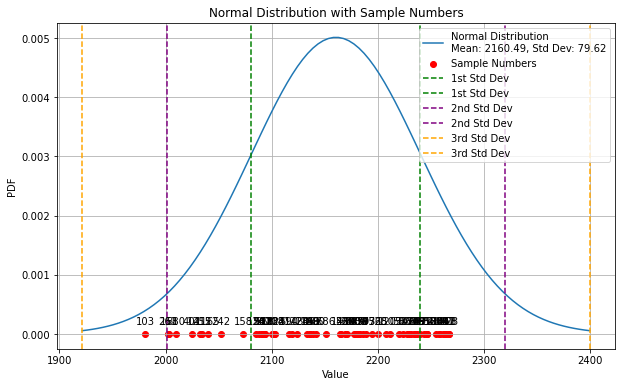

In [28]:
# Extract sample numbers, means, and calculate standard deviation
sample_numbers_normalized = normal_dtwd_dist.index
mean_normalized = normal_dtwd_dist['Mean']
mu_normalized = mean_normalized.mean()
std_dev_normalized = mean_normalized.std()

# Create a range of x values for the normal distribution curve
x_normalized = np.linspace(mu_normalized - 3 * std_dev_normalized, mu_normalized + 3 * std_dev_normalized, 100)

# Calculate the PDF values for the normal distribution
pdf_normalized = (1 / (std_dev_normalized * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_normalized - mu_normalized) / std_dev_normalized) ** 2)

# Create the plot, including the normal distribution and sample numbers
plt.figure(figsize=(10, 6))
plt.plot(x_normalized, pdf_normalized, label=f'Normal Distribution\nMean: {mu_normalized:.2f}, Std Dev: {std_dev_normalized:.2f}')
plt.scatter(mean_normalized, np.zeros_like(mean_normalized), label='Sample Numbers', color='red', marker='o')

# Add dotted vertical lines for the first and second standard deviations
plt.axvline(mu_normalized - std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized + std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized - 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized + 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized - 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')
plt.axvline(mu_normalized + 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')

for sample_number, mean_value in zip(sample_numbers_normalized, mean_normalized):
    plt.annotate(f'{sample_number}', (mean_value, 0), textcoords='offset points', xytext=(0, 10), ha='center')

plt.legend()
plt.title('Normal Distribution with Sample Numbers')
plt.xlabel('Value')
plt.ylabel('PDF')
plt.grid(True)
plt.show()

### 4. Mark the indices of the MTS that lie within the 1st standard deviation

In [29]:
# Assuming you have the necessary variables defined (sample_numbers_normalized, mean_normalized, mu_normalized, std_dev_normalized)

# Define the range and step size for 'a' and 'b'
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()
# display(a_values)

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()
# display(b_values)
display(mu_normalized)
display(std_dev_normalized)
# Initialize a dictionary to store sample number lists with different names
sample_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    sample_numbers_list = [sample for sample, mean in zip(sample_numbers_normalized, mean_normalized) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    sample_numbers_dict[name] = sample_numbers_list

# Display sample numbers with different names
for name, sample_numbers_list in sample_numbers_dict.items():
    display(f"{name}:")
    display(sample_numbers_list)
    display()

2160.4859681371813

79.61574323742524

'sample_numbers_list_0.0_to_0.1:'

[145, 52]

'sample_numbers_list_0.1_to_0.2:'

[686, 676, 268]

'sample_numbers_list_0.2_to_0.3:'

[167, 1052, 980, 907, 477, 1019, 1006, 605]

'sample_numbers_list_0.3_to_0.4:'

[189, 361, 377, 1140, 70]

'sample_numbers_list_0.4_to_0.5:'

[1224, 956, 328]

'sample_numbers_list_0.5_to_0.6:'

[150, 590, 1143]

'sample_numbers_list_0.6_to_0.7:'

[1203]

'sample_numbers_list_0.7_to_0.8:'

[1102, 1223, 50, 1134, 527, 318]

'sample_numbers_list_0.8_to_0.9:'

[367, 823, 459, 541, 358, 553, 128]

'sample_numbers_list_0.9_to_1.0:'

[1035, 735, 7, 1267, 68, 749]

'sample_numbers_list_1.0_to_1.1:'

[972, 918, 955, 630, 158]

'sample_numbers_list_1.1_to_1.2:'

[435]

'sample_numbers_list_1.2_to_1.3:'

[45, 364, 1263, 210, 941]

'sample_numbers_list_1.3_to_1.4:'

[242, 891, 47, 628]

'sample_numbers_list_1.4_to_1.5:'

[]

'sample_numbers_list_1.5_to_1.6:'

[455, 1165]

'sample_numbers_list_1.6_to_1.7:'

[1212]

'sample_numbers_list_1.7_to_1.8:'

[401]

'sample_numbers_list_1.8_to_1.9:'

[880]

'sample_numbers_list_1.9_to_2.0:'

[151, 263]

'sample_numbers_list_2.0_to_2.1:'

[]

'sample_numbers_list_2.1_to_2.2:'

[]

'sample_numbers_list_2.2_to_2.3:'

[103]

'sample_numbers_list_2.3_to_2.4:'

[]

'sample_numbers_list_2.4_to_2.5:'

[]

'sample_numbers_list_2.5_to_2.6:'

[]

'sample_numbers_list_2.6_to_2.7:'

[]

'sample_numbers_list_2.7_to_2.8:'

[]

'sample_numbers_list_2.8_to_2.9:'

[]

'sample_numbers_list_2.9_to_3.0:'

[]

### 5. Evaluate rest of the MTS in the dataset to add them into the respective bins

In [32]:
rest_indices = [x for x in subjects_list if x not in random_subjects]

In [33]:
number_list = random_subjects
pkl_filename = 'normalized_df.pickle'
rest_distances_list = []
for rest_index in rest_indices:
    current_index = rest_index
    mean_dist_rest_index = dtwd_dist_calc_rest(number_list,pkl_filename,current_index)
    rest_distances_list.append(mean_dist_rest_index)
display(rest_distances_list)

[2208.967095898959,
 2281.5706196702254,
 2312.010514654412,
 2305.892905056766,
 2261.9754542567484,
 2241.141353129931,
 2232.8095700600275,
 2161.8592070044724,
 2271.835517455711,
 2241.884645072944,
 2289.6681069475,
 2191.4151742826343,
 2258.420256458647,
 2318.1549344630744,
 2238.3809937693736,
 2234.558237214906,
 2178.922063205504,
 2199.6393647811306,
 2133.554401830098,
 2214.3318637937473,
 2129.9548174023344,
 2307.5550618929806,
 2282.861107219661,
 2290.2118261347446,
 2254.1215523921983,
 2262.5776742207004,
 2139.927780054031,
 2141.8980135320453,
 2122.085374651047,
 2278.059065014853,
 2210.4697696908315,
 2228.9705582672586,
 2269.2618566191054,
 2239.4375808352775,
 2212.5266619150484,
 2233.492437323824,
 2168.8210852036655,
 2307.645174139955,
 2320.786637733436,
 2260.9149471638866,
 2218.2209625957353,
 2207.671215030748,
 2151.724989622921,
 2229.74519801366,
 2129.1948640604714,
 2209.44996497177,
 2158.24090424097,
 2228.4948702033935,
 2210.5569662821918,

In [34]:
df_windows = pd.DataFrame({'rest_distances_list':rest_distances_list,
              'rest_indices':rest_indices})
df_windows.head()

,rest_distances_list,rest_indices
0,2208.967096,1
1,2281.570620,2
2,2312.010515,3
3,2305.892905,4
4,2261.975454,5


In [35]:
# Prepare the control DTW pickle file
file_name = 'rest_distances_list_67.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(df_windows, file)

In [36]:
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()
# display(a_values)

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()
# display(b_values)
display(mu_normalized)
display(std_dev_normalized)
# Initialize a dictionary to store sample number lists with different names
rest_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    rest_numbers_list = [sample for sample, mean in zip(rest_indices, rest_distances_list) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    rest_numbers_dict[name] = rest_numbers_list

# Display sample numbers with different names
for name, rest_numbers_list in rest_numbers_dict.items():
    display(f"{name}:")
    display(rest_numbers_list)
    display()

2160.4859681371813

79.61574323742524

'sample_numbers_list_0.0_to_0.1:'

[9,
 80,
 102,
 106,
 116,
 146,
 159,
 166,
 197,
 258,
 292,
 305,
 308,
 311,
 314,
 315,
 317,
 323,
 348,
 352,
 354,
 370,
 373,
 376,
 421,
 432,
 436,
 438,
 449,
 458,
 543,
 559,
 567,
 637,
 666,
 692,
 693,
 718,
 722,
 753,
 762,
 802,
 807,
 812,
 883,
 898,
 931,
 954,
 959,
 994,
 1016,
 1027,
 1034,
 1074,
 1083,
 1094,
 1096,
 1118,
 1121,
 1128,
 1131,
 1133,
 1136,
 1148,
 1149,
 1262,
 1281,
 1317,
 1321]

'sample_numbers_list_0.1_to_0.2:'

[64,
 76,
 127,
 156,
 201,
 207,
 232,
 241,
 253,
 257,
 272,
 276,
 285,
 306,
 310,
 342,
 386,
 427,
 439,
 451,
 454,
 474,
 483,
 490,
 542,
 607,
 616,
 638,
 644,
 647,
 661,
 765,
 767,
 793,
 803,
 1018,
 1049,
 1093,
 1099,
 1114,
 1115,
 1138,
 1146,
 1179,
 1188,
 1190,
 1210,
 1214,
 1286,
 1287,
 1292,
 1316,
 1323]

'sample_numbers_list_0.2_to_0.3:'

[27,
 49,
 51,
 135,
 182,
 193,
 198,
 231,
 249,
 255,
 256,
 267,
 270,
 271,
 274,
 286,
 293,
 309,
 313,
 321,
 343,
 384,
 390,
 429,
 461,
 468,
 579,
 609,
 612,
 642,
 689,
 702,
 716,
 739,
 787,
 873,
 897,
 924,
 1003,
 1014,
 1015,
 1041,
 1043,
 1064,
 1066,
 1077,
 1095,
 1098,
 1100,
 1119,
 1130,
 1141,
 1189,
 1207,
 1230,
 1251,
 1290]

'sample_numbers_list_0.3_to_0.4:'

[21,
 33,
 36,
 78,
 121,
 147,
 160,
 217,
 230,
 233,
 234,
 244,
 254,
 265,
 340,
 349,
 353,
 387,
 434,
 478,
 496,
 510,
 558,
 560,
 577,
 640,
 646,
 671,
 710,
 731,
 768,
 822,
 860,
 949,
 1012,
 1081,
 1101,
 1120,
 1132,
 1156,
 1166,
 1204,
 1268,
 1297]

'sample_numbers_list_0.4_to_0.5:'

[28,
 53,
 89,
 107,
 157,
 208,
 212,
 239,
 261,
 269,
 288,
 319,
 356,
 385,
 467,
 499,
 521,
 589,
 621,
 645,
 674,
 675,
 685,
 688,
 695,
 703,
 705,
 706,
 804,
 809,
 945,
 1001,
 1017,
 1045,
 1046,
 1079,
 1092,
 1113,
 1117,
 1142,
 1151,
 1154,
 1167,
 1186,
 1208,
 1238,
 1296,
 1304,
 1322]

'sample_numbers_list_0.5_to_0.6:'

[75,
 87,
 100,
 119,
 120,
 148,
 214,
 266,
 289,
 316,
 329,
 337,
 372,
 375,
 383,
 418,
 452,
 479,
 480,
 488,
 504,
 517,
 531,
 562,
 641,
 663,
 672,
 712,
 745,
 750,
 815,
 816,
 830,
 844,
 877,
 914,
 981,
 1022,
 1051,
 1065,
 1067,
 1085,
 1097,
 1105,
 1137,
 1168,
 1205,
 1229,
 1231,
 1232,
 1235,
 1254,
 1259,
 1264,
 1272,
 1314]

'sample_numbers_list_0.6_to_0.7:'

[1,
 34,
 56,
 60,
 79,
 83,
 101,
 149,
 211,
 251,
 290,
 291,
 327,
 341,
 344,
 357,
 381,
 464,
 472,
 526,
 554,
 613,
 665,
 687,
 694,
 720,
 763,
 774,
 783,
 797,
 856,
 859,
 921,
 926,
 933,
 952,
 964,
 965,
 973,
 984,
 1145,
 1252,
 1276,
 1294]

'sample_numbers_list_0.7_to_0.8:'

[71,
 133,
 144,
 180,
 181,
 187,
 188,
 236,
 259,
 277,
 287,
 303,
 304,
 320,
 326,
 360,
 366,
 379,
 391,
 453,
 481,
 500,
 506,
 586,
 631,
 683,
 715,
 717,
 737,
 742,
 752,
 776,
 796,
 808,
 814,
 817,
 821,
 828,
 870,
 874,
 910,
 920,
 985,
 1042,
 1078,
 1080,
 1084,
 1111,
 1116,
 1147,
 1260,
 1278,
 1291,
 1311]

'sample_numbers_list_0.8_to_0.9:'

[57,
 77,
 81,
 98,
 124,
 139,
 161,
 359,
 374,
 469,
 489,
 561,
 591,
 626,
 669,
 740,
 769,
 795,
 813,
 892,
 913,
 947,
 953,
 1044,
 1050,
 1108,
 1211,
 1225,
 1255,
 1306,
 1307,
 1309]

'sample_numbers_list_0.9_to_1.0:'

[8,
 24,
 26,
 59,
 61,
 90,
 195,
 213,
 252,
 260,
 380,
 466,
 509,
 520,
 617,
 622,
 633,
 635,
 649,
 673,
 707,
 786,
 961,
 962,
 969,
 1007,
 1023,
 1122,
 1289]

'sample_numbers_list_1.0_to_1.1:'

[6,
 19,
 95,
 134,
 142,
 355,
 428,
 465,
 484,
 576,
 596,
 608,
 639,
 660,
 662,
 751,
 811,
 858,
 871,
 958,
 1155,
 1201,
 1265,
 1293,
 1310,
 1313]

'sample_numbers_list_1.1_to_1.2:'

[46,
 179,
 235,
 365,
 393,
 416,
 422,
 507,
 524,
 529,
 588,
 606,
 623,
 636,
 648,
 651,
 670,
 738,
 747,
 846,
 854,
 890,
 932,
 950,
 989,
 999,
 1031,
 1106]

'sample_numbers_list_1.2_to_1.3:'

[5,
 22,
 48,
 69,
 91,
 192,
 209,
 419,
 437,
 456,
 493,
 618,
 632,
 667,
 690,
 713,
 744,
 831,
 872,
 882,
 900,
 1000,
 1030,
 1053,
 1129,
 1308,
 1319]

'sample_numbers_list_1.3_to_1.4:'

[10,
 58,
 88,
 94,
 415,
 433,
 501,
 502,
 516,
 552,
 704,
 743,
 805,
 810,
 865,
 869,
 889,
 911,
 946,
 960,
 970,
 971,
 1002,
 1005,
 1010,
 1029,
 1055,
 1112,
 1217,
 1222,
 1271,
 1305]

'sample_numbers_list_1.4_to_1.5:'

[55,
 93,
 137,
 138,
 190,
 363,
 369,
 450,
 460,
 476,
 513,
 614,
 625,
 650,
 664,
 775,
 799,
 820,
 861,
 887,
 909,
 948,
 982,
 1020,
 1178,
 1258,
 1270,
 1275,
 1298,
 1312]

'sample_numbers_list_1.5_to_1.6:'

[2,
 41,
 96,
 168,
 171,
 278,
 471,
 482,
 505,
 508,
 515,
 518,
 634,
 659,
 766,
 798,
 826,
 847,
 855,
 881,
 934,
 936,
 939,
 943,
 1021,
 1144]

'sample_numbers_list_1.6_to_1.7:'

[20,
 43,
 152,
 275,
 351,
 371,
 414,
 420,
 430,
 470,
 473,
 582,
 714,
 721,
 748,
 773,
 784,
 792,
 829,
 845,
 852,
 885,
 937,
 995,
 1187,
 1202,
 1261,
 1274,
 1277,
 1295]

'sample_numbers_list_1.7_to_1.8:'

[417, 423, 497, 514, 525, 615, 794, 908, 940, 942, 963, 986, 1047, 1199, 1269]

'sample_numbers_list_1.8_to_1.9:'

[4,
 40,
 66,
 243,
 250,
 426,
 475,
 522,
 629,
 652,
 668,
 864,
 912,
 919,
 930,
 938,
 1028]

'sample_numbers_list_1.9_to_2.0:'

[3, 23, 170, 761, 827, 884]

'sample_numbers_list_2.0_to_2.1:'

[67, 92, 196, 368, 487, 503, 528, 878, 879]

'sample_numbers_list_2.1_to_2.2:'

[99, 899, 915, 935, 1150, 1253]

'sample_numbers_list_2.2_to_2.3:'

[262, 498, 512, 868, 876]

'sample_numbers_list_2.3_to_2.4:'

[431]

'sample_numbers_list_2.4_to_2.5:'

[643, 896, 1266]

'sample_numbers_list_2.5_to_2.6:'

[519, 1013, 1273]

'sample_numbers_list_2.6_to_2.7:'

[523]

'sample_numbers_list_2.7_to_2.8:'

[]

'sample_numbers_list_2.8_to_2.9:'

[]

'sample_numbers_list_2.9_to_3.0:'

[294]

### 6. Form the final dictionary combining the sampled and rest numbers

In [37]:
final_dict = {key: sample_numbers_dict[key] + rest_numbers_dict[key] for key in sample_numbers_dict if key in rest_numbers_dict}

{'sample_numbers_list_0.0_to_0.1': [145,
  52,
  9,
  80,
  102,
  106,
  116,
  146,
  159,
  166,
  197,
  258,
  292,
  305,
  308,
  311,
  314,
  315,
  317,
  323,
  348,
  352,
  354,
  370,
  373,
  376,
  421,
  432,
  436,
  438,
  449,
  458,
  543,
  559,
  567,
  637,
  666,
  692,
  693,
  718,
  722,
  753,
  762,
  802,
  807,
  812,
  883,
  898,
  931,
  954,
  959,
  994,
  1016,
  1027,
  1034,
  1074,
  1083,
  1094,
  1096,
  1118,
  1121,
  1128,
  1131,
  1133,
  1136,
  1148,
  1149,
  1262,
  1281,
  1317,
  1321],
 'sample_numbers_list_0.1_to_0.2': [686,
  676,
  268,
  64,
  76,
  127,
  156,
  201,
  207,
  232,
  241,
  253,
  257,
  272,
  276,
  285,
  306,
  310,
  342,
  386,
  427,
  439,
  451,
  454,
  474,
  483,
  490,
  542,
  607,
  616,
  638,
  644,
  647,
  661,
  765,
  767,
  793,
  803,
  1018,
  1049,
  1093,
  1099,
  1114,
  1115,
  1138,
  1146,
  1179,
  1188,
  1190,
  1210,
  1214,
  1286,
  1287,
  1292,
  1316,
  1323],
 'sample_n

In [38]:
# Prepare the control DTW pickle file
file_name = 'final_bins_67.pkl'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(final_dict, file)

## Do the classification

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
# !pip install --upgrade numba
# pip install sktime
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Load normal and abnormal datasets

In [2]:
final_normal_df = pd.read_pickle('normal_EMO_pain.pkl')
final_abnormal_df = pd.read_pickle('abnormal_df.pkl')

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,activity,subject_number,new_subject_number
0,1.02130,0.95783,0.98112,0.99898,1.067500,1.017300,0.90871,0.93430,1.0717,1.02430,...,1.361400e-05,3.357200e-07,7.035800e-03,0.002144,0.001760,0.002275,0.072891,1,11,1
1,1.01970,0.96150,0.97944,1.00050,1.066500,1.018100,0.90840,0.93432,1.0716,1.02450,...,1.490200e-05,4.935200e-06,7.383200e-03,0.002138,0.001701,0.001565,0.017368,1,11,1
2,1.01810,0.96536,0.97762,1.00210,1.065600,1.018600,0.90815,0.93394,1.0714,1.02510,...,1.412200e-05,5.239900e-06,8.312100e-03,0.002340,0.001532,0.001074,0.047489,1,11,1
3,1.01640,0.96948,0.97589,1.00370,1.064700,1.018800,0.90804,0.93396,1.0711,1.02560,...,1.076700e-05,9.999400e-06,8.300100e-03,0.002441,0.001697,0.001170,0.080234,1,11,1
4,1.01440,0.97376,0.97400,1.00530,1.063700,1.019000,0.90803,0.93410,1.0706,1.02620,...,7.268000e-06,1.286100e-05,7.484100e-03,0.002255,0.001039,0.001428,0.062073,1,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60195,0.74097,0.80707,0.18271,0.29593,0.077513,0.039578,0.19951,0.58894,1.0661,0.91215,...,1.058700e-06,1.934400e-05,4.672600e-06,0.024459,0.055559,0.067210,0.023681,2,1320,301
60196,0.74466,0.81115,0.18536,0.29860,0.082479,0.035784,0.20168,0.58315,1.0675,0.91468,...,8.426500e-07,1.742300e-05,3.997800e-06,0.136790,0.124810,0.022974,0.028399,2,1320,301
60197,0.74785,0.81456,0.18770,0.30148,0.087768,0.032743,0.20399,0.58189,1.0684,0.91865,...,7.763100e-07,1.639600e-05,4.348600e-06,0.088216,0.353800,0.049788,0.035921,2,1320,301
60198,0.75158,0.81844,0.19015,0.30415,0.092787,0.029651,0.20600,0.58223,1.0687,0.92150,...,8.127500e-07,1.261500e-05,1.290300e-06,0.023287,0.139760,0.017916,0.028992,2,1320,301


In [3]:
final_abnormal_df = final_abnormal_df.drop(columns=['subject_number','activity'])
final_abnormal_df.rename(columns={'new_subject_number': 'Subject'}, inplace=True)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.02130,0.95783,0.98112,0.99898,1.067500,1.017300,0.90871,0.93430,1.0717,1.02430,...,1.348800e-07,0.000006,1.361400e-05,3.357200e-07,7.035800e-03,0.002144,0.001760,0.002275,0.072891,1
1,1.01970,0.96150,0.97944,1.00050,1.066500,1.018100,0.90840,0.93432,1.0716,1.02450,...,3.186200e-07,0.000004,1.490200e-05,4.935200e-06,7.383200e-03,0.002138,0.001701,0.001565,0.017368,1
2,1.01810,0.96536,0.97762,1.00210,1.065600,1.018600,0.90815,0.93394,1.0714,1.02510,...,2.305600e-06,0.000015,1.412200e-05,5.239900e-06,8.312100e-03,0.002340,0.001532,0.001074,0.047489,1
3,1.01640,0.96948,0.97589,1.00370,1.064700,1.018800,0.90804,0.93396,1.0711,1.02560,...,6.841300e-06,0.000017,1.076700e-05,9.999400e-06,8.300100e-03,0.002441,0.001697,0.001170,0.080234,1
4,1.01440,0.97376,0.97400,1.00530,1.063700,1.019000,0.90803,0.93410,1.0706,1.02620,...,1.340100e-05,0.000021,7.268000e-06,1.286100e-05,7.484100e-03,0.002255,0.001039,0.001428,0.062073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60195,0.74097,0.80707,0.18271,0.29593,0.077513,0.039578,0.19951,0.58894,1.0661,0.91215,...,5.125400e-06,0.000022,1.058700e-06,1.934400e-05,4.672600e-06,0.024459,0.055559,0.067210,0.023681,301
60196,0.74466,0.81115,0.18536,0.29860,0.082479,0.035784,0.20168,0.58315,1.0675,0.91468,...,4.545600e-06,0.000014,8.426500e-07,1.742300e-05,3.997800e-06,0.136790,0.124810,0.022974,0.028399,301
60197,0.74785,0.81456,0.18770,0.30148,0.087768,0.032743,0.20399,0.58189,1.0684,0.91865,...,1.740600e-06,0.000035,7.763100e-07,1.639600e-05,4.348600e-06,0.088216,0.353800,0.049788,0.035921,301
60198,0.75158,0.81844,0.19015,0.30415,0.092787,0.029651,0.20600,0.58223,1.0687,0.92150,...,1.877700e-07,0.000018,8.127500e-07,1.261500e-05,1.290300e-06,0.023287,0.139760,0.017916,0.028992,301


In [4]:
abnormal_indices = (final_abnormal_df['Subject']).unique()
abnormal_no = (final_abnormal_df['Subject']).nunique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

301

In [5]:
# Specify the file path of the saved pkl file
file_path = 'final_bins_67.pkl'

# Load the dictionary from the pkl file
with open(file_path, 'rb') as file:
    final_numbers_dictionary = pickle.load(file)
# Now, 'loaded_dictionary' contains the dictionary loaded from the pkl file
display("Dictionary loaded from pickle file:")

'Dictionary loaded from pickle file:'

{'sample_numbers_list_0.0_to_0.1': [145,
  52,
  9,
  80,
  102,
  106,
  116,
  146,
  159,
  166,
  197,
  258,
  292,
  305,
  308,
  311,
  314,
  315,
  317,
  323,
  348,
  352,
  354,
  370,
  373,
  376,
  421,
  432,
  436,
  438,
  449,
  458,
  543,
  559,
  567,
  637,
  666,
  692,
  693,
  718,
  722,
  753,
  762,
  802,
  807,
  812,
  883,
  898,
  931,
  954,
  959,
  994,
  1016,
  1027,
  1034,
  1074,
  1083,
  1094,
  1096,
  1118,
  1121,
  1128,
  1131,
  1133,
  1136,
  1148,
  1149,
  1262,
  1281,
  1317,
  1321],
 'sample_numbers_list_0.1_to_0.2': [686,
  676,
  268,
  64,
  76,
  127,
  156,
  201,
  207,
  232,
  241,
  253,
  257,
  272,
  276,
  285,
  306,
  310,
  342,
  386,
  427,
  439,
  451,
  454,
  474,
  483,
  490,
  542,
  607,
  616,
  638,
  644,
  647,
  661,
  765,
  767,
  793,
  803,
  1018,
  1049,
  1093,
  1099,
  1114,
  1115,
  1138,
  1146,
  1179,
  1188,
  1190,
  1210,
  1214,
  1286,
  1287,
  1292,
  1316,
  1323],
 'sample_n

In [6]:
dictionary_keys = final_numbers_dictionary.keys()
keys_list = list(dictionary_keys)

['sample_numbers_list_0.0_to_0.1',
 'sample_numbers_list_0.1_to_0.2',
 'sample_numbers_list_0.2_to_0.3',
 'sample_numbers_list_0.3_to_0.4',
 'sample_numbers_list_0.4_to_0.5',
 'sample_numbers_list_0.5_to_0.6',
 'sample_numbers_list_0.6_to_0.7',
 'sample_numbers_list_0.7_to_0.8',
 'sample_numbers_list_0.8_to_0.9',
 'sample_numbers_list_0.9_to_1.0',
 'sample_numbers_list_1.0_to_1.1',
 'sample_numbers_list_1.1_to_1.2',
 'sample_numbers_list_1.2_to_1.3',
 'sample_numbers_list_1.3_to_1.4',
 'sample_numbers_list_1.4_to_1.5',
 'sample_numbers_list_1.5_to_1.6',
 'sample_numbers_list_1.6_to_1.7',
 'sample_numbers_list_1.7_to_1.8',
 'sample_numbers_list_1.8_to_1.9',
 'sample_numbers_list_1.9_to_2.0',
 'sample_numbers_list_2.0_to_2.1',
 'sample_numbers_list_2.1_to_2.2',
 'sample_numbers_list_2.2_to_2.3',
 'sample_numbers_list_2.3_to_2.4',
 'sample_numbers_list_2.4_to_2.5',
 'sample_numbers_list_2.5_to_2.6',
 'sample_numbers_list_2.6_to_2.7',
 'sample_numbers_list_2.7_to_2.8',
 'sample_numbers_lis

### Function to find the length of the time series

In [7]:
# Define a function to z-normalize a column
def z_normalize(column):
    mean = column.mean()
    std = column.std()
    z_normalized = (column - mean) / std
    return z_normalized

In [8]:
def time_series_length_finding(df):
    train_1_abnormal = df.copy()
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    row_count = []
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        no_rows = train_1_abnormal_new.shape[0]
        row_count.append(no_rows)
#     display("Max length:",max(row_count))
#     display("Min length:",min(row_count))
    display("Avg length:",statistics.mean(row_count))
    avg_len_ts = int(statistics.mean(row_count))
#     display("Median length:",statistics.median(row_count))
    return(avg_len_ts)

In [9]:
normal_len = time_series_length_finding(final_normal_df)
normal_len

'Avg length:'

200

200

In [10]:
abnormal_len = time_series_length_finding(final_abnormal_df)
abnormal_len

'Avg length:'

200

200

In [12]:
def preprocessing_normal_df(df,desired_length):
    train_2_normal = df.copy()
    df_train_3 = pd.DataFrame(columns = train_2_normal.columns)
    num_dim = df_train_3.shape[1]
    display(num_dim)
    df_train_3.columns = range(len(df_train_3.columns))
#     display(df_train_3.head())
    train_2_sub = (train_2_normal['Subject'].unique()).tolist()
#     display(train_2_sub)
    m = 0
    for i in train_2_sub:
        train_2_normal_new = train_2_normal[(train_2_normal['Subject']== i)]
        df_row_count = train_2_normal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
            train_2_normal_new.tail()
            last_row = train_2_normal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_2_normal_initial = pd.concat([train_2_normal_new, new_rows_df], ignore_index=True)
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)
#             display(train_2_normal_final.tail())
        else:
            train_2_normal_initial = train_2_normal_new.iloc[:desired_length,:]
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)
#             display(train_2_normal_final.tail())
            
        train_2_normal_final.columns = range(len(train_2_normal_final.columns))
#         display(train_2_normal_final)
        
        df_train_3.at[m,0] = i
        j = 0
        while j < num_dim:
            df_train_3.at[m,j] = train_2_normal_final[j]
#             display(train_2_normal_final[j])
            j += 1
        m += 1    
    # display(df_train_3)
    df_train_3['class'] = 'normal'
    df_normal_baseline = df_train_3.iloc[:,1:]
    return(df_normal_baseline)

In [13]:
def preprocessing_dataframe(df,desired_length):
    train_1_abnormal = df.copy()
    df_train_2 = pd.DataFrame(columns = train_1_abnormal.columns)
    num_dim_ab = df_train_2.shape[1]
#     display(num_dim_ab)
    df_train_2.columns = range(len(df_train_2.columns))
    # display(df_train_2.head())
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    # display(train_1_ab_sub)
    m = 0
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        df_row_count = train_1_abnormal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
#             train_1_abnormal_new.tail()
            last_row = train_1_abnormal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_1_abnormal_initial = pd.concat([train_1_abnormal_new, new_rows_df], ignore_index=True)
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
#             display(train_1_abnormal_final.tail())
        else:
            train_1_abnormal_initial = train_1_abnormal_new.iloc[:desired_length,:]
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
        train_1_abnormal_final.columns = range(len(train_1_abnormal_final.columns))
#         display(train_1_abnormal_final)
        
        df_train_2.at[m,0] = i
        j = 0
        while j < num_dim_ab:
            df_train_2.at[m,j] = train_1_abnormal_final[j]
#             display(train_1_abnormal_final[j])
            j += 1
        m += 1    
    # display(df_train_2)
    df_train_2['class'] = 'abnormal'
    df_final = df_train_2.iloc[:,1:]
    return(df_final)

In [14]:
def ts_classifier(df_class_1):
    accuacy_list_1 = []
    precision_list_1 = []
    recall_list_1 = []
    f1_list_1 = []

    X_1 = df_class_1.iloc[:,:-1]
    y_1 = df_class_1.iloc[:,-1]
    
    display("X_1:",X_1)

    for i in range(1,31):
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=i,stratify = y_1)

        rocket = Rocket(num_kernels=10000)
        rocket.fit(X_train_1)
        X_train_transform_1 = rocket.transform(X_train_1)
        classifier_1 = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        classifier_1.fit(X_train_transform_1, y_train_1)
        X_test_transform_1 = rocket.transform(X_test_1)
        y_pred_1 = classifier_1.predict(X_test_transform_1)

        pos_label = 'abnormal'

        acc_1 = accuracy_score(y_test_1, y_pred_1)
        accuacy_list_1.append(acc_1)

        prec_1 = precision_score(y_test_1, y_pred_1, pos_label=pos_label)
        precision_list_1.append(prec_1)

        recall_1 = recall_score(y_test_1, y_pred_1, pos_label=pos_label)
        recall_list_1.append(recall_1)

        f1_1 = f1_score(y_test_1, y_pred_1, pos_label=pos_label)
        f1_list_1.append(f1_1)
        display("Completed",i)

    acc_mean_1 = np.mean(accuacy_list_1)
    acc_std_dev_1 = np.std(accuacy_list_1)

    prec_mean_1 = np.mean(precision_list_1)
    prec_std_dev_1 = np.std(precision_list_1)

    recall_mean_1 = np.mean(recall_list_1)
    recall_std_dev_1 = np.std(recall_list_1)
    
    f1_mean_1 = np.mean(f1_list_1)
    f1_std_dev_1 = np.std(f1_list_1)
    return(acc_mean_1,acc_std_dev_1,prec_mean_1,prec_std_dev_1,recall_mean_1,recall_std_dev_1,f1_mean_1,f1_std_dev_1)

In [15]:
classifier_dict = {}
normal_sample_numbers = [] 
for key in keys_list:
    display("Current key in progress",key)

    if not final_numbers_dictionary[key]:
        display("Moving on to the next key")
        continue

    normal_sample_numbers.extend(final_numbers_dictionary[key])
    normal_sample_length = len(normal_sample_numbers)
    display(normal_sample_length)
    
    
    if len(normal_sample_numbers) <= abnormal_no:
        df_normal = final_normal_df[final_normal_df['Subject'].isin(normal_sample_numbers)]
        display(df_normal)

        random.seed(42)
        abnormal_sample_numbers = random.sample(abnormal_indices.tolist(), normal_sample_length)
        df_abnormal = final_abnormal_df[final_abnormal_df['Subject'].isin(abnormal_sample_numbers)]
        display(df_abnormal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        
        if len(df_classifier) < 10:
            display("Skipping key, not enough samples.")
            continue
        
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

    else:
        df_abnormal = final_abnormal_df

        random.seed(42)
        random_sample_numbers = random.sample(normal_sample_numbers, abnormal_no)
        df_normal = final_normal_df[final_normal_df['Subject'].isin(random_sample_numbers)]
        display(df_normal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        
           # Check if the number of samples is less than 2 before proceeding
        if len(df_classifier) < 10:
            display("Skipping key, not enough samples.")
            continue
        
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

'Current key in progress'

'sample_numbers_list_0.0_to_0.1'

71

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.07030,1.016500,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.07030,1.016700,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.07020,1.016900,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.07010,1.017400,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.06990,1.017800,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.00230,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.00230,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.00240,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.00280,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
600,0.98664,0.98955,0.92570,1.01520,0.99745,1.0258,0.91296,0.90637,1.05850,1.01500,...,1.891600e-07,7.314500e-06,2.348800e-07,2.402500e-06,3.379800e-04,0.001444,0.001632,0.000884,0.004008,4
601,0.98464,0.99143,0.92362,1.01690,0.99102,1.0260,0.91191,0.90626,1.05860,1.01510,...,1.490700e-06,1.345100e-07,1.148100e-05,4.361600e-07,3.045100e-04,0.003219,0.001500,0.001381,0.003962,4
602,0.98254,0.99326,0.92158,1.01840,0.98427,1.0258,0.91052,0.90664,1.05880,1.01530,...,1.863700e-06,1.510000e-06,1.045100e-05,4.042000e-08,2.353500e-04,0.003939,0.002752,0.000854,0.001827,4
603,0.98022,0.99502,0.91938,1.01990,0.97713,1.0258,0.90882,0.90702,1.05880,1.01540,...,8.563500e-08,8.720400e-07,1.081100e-05,3.521900e-06,1.536900e-04,0.003631,0.001928,0.000773,0.002756,4
604,0.97773,0.99673,0.91688,1.02170,0.97010,1.0259,0.90681,0.90746,1.05870,1.01540,...,1.687000e-06,3.935400e-08,1.632000e-05,1.174400e-05,9.599500e-05,0.004376,0.002406,0.001088,0.004217,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59195,1.05690,1.04710,0.95090,0.97162,0.91320,1.0461,0.80463,0.69906,0.97888,0.99751,...,3.992700e-08,7.756000e-11,3.075900e-09,1.020200e-09,9.884000e-08,0.173590,0.413210,0.069095,0.089336,296
59196,1.05690,1.04700,0.95091,0.97161,0.91321,1.0461,0.80457,0.69915,0.97877,0.99759,...,2.979400e-08,1.499300e-08,1.331300e-10,5.558400e-10,3.291100e-08,0.081719,0.222580,0.070780,0.155880,296
59197,1.05700,1.04690,0.95096,0.97157,0.91321,1.0461,0.80452,0.69955,0.97880,0.99751,...,1.752400e-09,1.642700e-08,3.632100e-11,5.309100e-09,2.963500e-07,0.094313,0.095098,0.116840,0.113090,296
59198,1.05700,1.04690,0.95099,0.97155,0.91321,1.0461,0.80440,0.69973,0.97884,0.99751,...,3.554700e-09,6.722500e-12,4.172400e-10,2.473600e-09,1.115300e-07,0.182440,0.130510,0.086830,0.069278,296


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,8000 -0.225411 8001 -0.250270 8002 -0.31...,8000 0.364606 8001 0.329100 8002 0.25...,8000 -0.011682 8001 -0.055090 8002 -0.09...,8000 0.910400 8001 0.931948 8002 0.91...,8000 0.189116 8001 0.182948 8002 0.23...,8000 2.694754 8001 2.583966 8002 2.50...,8000 -0.100467 8001 -0.206539 8002 -0.24...,8000 1.162764 8001 1.063346 8002 0.75...,8000 0.887899 8001 0.785612 8002 0.93...,8000 0.998033 8001 0.982352 8002 0.95...,...,8000 0.374504 8001 0.059477 8002 1...,8000 -0.532007 8001 1.398841 8002 3.31...,8000 -0.503463 8001 -0.554188 8002 -0.40...,8000 -0.521375 8001 -0.182189 8002 -0.13...,8000 -0.377959 8001 -0.480767 8002 -0.31...,8000 -0.241795 8001 -0.290092 8002 -0.17...,8000 -0.481239 8001 0.134542 8002 -0.24...,8000 3.538570 8001 2.244608 8002 1.11...,8000 1.617487 8001 -1.050453 8002 -0.04...,8000 0.053353 8001 -0.208647 8002 -0.22...
2,12200 -1.692344 12201 -1.861564 12202 -1...,12200 -0.967256 12201 -0.892770 12202 -0...,12200 -4.248229 12201 -4.248229 12202 -4...,12200 -4.257658 12201 -4.257658 12202 -4...,12200 -3.572058 12201 -3.572058 12202 -3...,12200 -0.446857 12201 -0.446857 12202 -0...,12200 -2.890686 12201 -2.864804 12202 -2...,12200 -3.122212 12201 -3.021574 12202 -2...,12200 2.832421 12201 2.779439 12202 2...,12200 2.709406 12201 2.749377 12202 2...,...,12200 -0.154547 12201 0.190255 12202 1...,12200 1.499179 12201 0.003413 12202 -0...,12200 0.034044 12201 -0.090334 12202 -0...,12200 5.524941 12201 0.330318 12202 -0...,12200 4.369392 12201 3.471091 12202 ...,12200 -0.135244 12201 0.139889 12202 1...,12200 -0.713531 12201 -1.213206 12202 0...,12200 -0.134312 12201 -0.176815 12202 -0...,12200 -0.934174 12201 -0.547757 12202 -0...,12200 -0.772217 12201 -0.775873 12202 -0...
3,15800 -2.756522 15801 -2.725986 15802 -2...,15800 -5.061687 15801 -4.974011 15802 -4...,15800 -0.885912 15801 -0.963423 15802 -1...,15800 -1.698396 15801 -1.733059 15802 -1...,15800 -0.596595 15801 -0.532704 15802 -0...,15800 0.156631 15801 0.255401 15802 0...,15800 3.840695 15801 3.779554 15802 3...,15800 0.461439 15801 0.406679 15802 0...,15800 3.303188 15801 3.266347 15802 3...,15800 2.577921 15801 2.577921 15802 2...,...,15800 0.514833 15801 -0.195874 15802 0...,15800 -0.368236 15801 -0.372875 15802 -0...,15800 -0.295527 15801 -0.442144 15802 -0...,15800 -0.190062 15801 -0.252852 15802 -0...,15800 -0.264196 15801 -0.433239 15802 -0...,15800 -0.229961 15801 -0.182659 15802 -0...,15800 1.242927 15801 1.242927 15802 -0...,15800 -0.050473 15801 -0.050473 15802 -0...,15800 0.736444 15801 0.736444 15802 -0...,15800 0.244501 15801 0.244501 15802 -0...
4,16600 0.324676 16601 0.324676 16602 0...,16600 -0.449638 16601 -0.449638 16602 -0...,16600 -0.859763 16601 -0.859763 16602 -0...,16600 -0.491180 16601 -0.491180 16602 -0...,16600 -0.560211 16601 -0.560211 16602 -0...,16600 0.647840 16601 0.647840 16602 0...,16600 -0.166581 16601 -0.166581 16602 -0...,16600 0.321210 16601 0.321210 16602 0...,16600 0.762959 16601 0.762959 16602 0...,16600 -0.669527 16601 -0.669527 16602 -0...,...,16600 -0.414820 16601 -0.414820 16602 -0...,16600 -0.447771 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.1_to_0.2'

127

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.070300,1.01650,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.070300,1.01670,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.070200,1.01690,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.070100,1.01740,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.069900,1.01780,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
600,0.98664,0.98955,0.92570,1.01520,0.99745,1.025800,0.91296,0.90637,1.0585,1.01500,...,1.891600e-07,7.314500e-06,2.348800e-07,2.402500e-06,3.379800e-04,0.001444,0.001632,0.000884,0.004008,4
601,0.98464,0.99143,0.92362,1.01690,0.99102,1.026000,0.91191,0.90626,1.0586,1.01510,...,1.490700e-06,1.345100e-07,1.148100e-05,4.361600e-07,3.045100e-04,0.003219,0.001500,0.001381,0.003962,4
602,0.98254,0.99326,0.92158,1.01840,0.98427,1.025800,0.91052,0.90664,1.0588,1.01530,...,1.863700e-06,1.510000e-06,1.045100e-05,4.042000e-08,2.353500e-04,0.003939,0.002752,0.000854,0.001827,4
603,0.98022,0.99502,0.91938,1.01990,0.97713,1.025800,0.90882,0.90702,1.0588,1.01540,...,8.563500e-08,8.720400e-07,1.081100e-05,3.521900e-06,1.536900e-04,0.003631,0.001928,0.000773,0.002756,4
604,0.97773,0.99673,0.91688,1.02170,0.97010,1.025900,0.90681,0.90746,1.0587,1.01540,...,1.687000e-06,3.935400e-08,1.632000e-05,1.174400e-05,9.599500e-05,0.004376,0.002406,0.001088,0.004217,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.77138,0.89625,0.17340,0.33951,0.13136,0.021579,0.24673,0.57112,1.0686,0.90776,...,3.761500e-07,5.888800e-06,3.308900e-08,7.633000e-06,9.004600e-07,0.036654,0.136410,0.008866,0.011726,300
59996,0.77373,0.89765,0.17499,0.34033,0.13250,0.020383,0.24680,0.57066,1.0682,0.90948,...,3.999300e-07,6.609800e-06,5.633300e-08,1.803700e-06,2.044400e-06,0.072080,0.052003,0.039136,0.019985,300
59997,0.77561,0.89872,0.17597,0.34091,0.13424,0.018886,0.24652,0.57029,1.0676,0.91119,...,8.817500e-07,6.475000e-06,1.075000e-07,1.659900e-06,1.828300e-08,0.106690,0.172620,0.053329,0.029729,300
59998,0.77669,0.89976,0.17645,0.34131,0.13519,0.018189,0.24958,0.57104,1.0687,0.91302,...,2.533100e-06,7.514400e-06,2.619000e-07,1.195900e-09,1.281800e-06,0.027215,0.205650,0.030113,0.013937,300


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,8000 -0.225411 8001 -0.250270 8002 -0.31...,8000 0.364606 8001 0.329100 8002 0.25...,8000 -0.011682 8001 -0.055090 8002 -0.09...,8000 0.910400 8001 0.931948 8002 0.91...,8000 0.189116 8001 0.182948 8002 0.23...,8000 2.694754 8001 2.583966 8002 2.50...,8000 -0.100467 8001 -0.206539 8002 -0.24...,8000 1.162764 8001 1.063346 8002 0.75...,8000 0.887899 8001 0.785612 8002 0.93...,8000 0.998033 8001 0.982352 8002 0.95...,...,8000 0.374504 8001 0.059477 8002 1...,8000 -0.532007 8001 1.398841 8002 3.31...,8000 -0.503463 8001 -0.554188 8002 -0.40...,8000 -0.521375 8001 -0.182189 8002 -0.13...,8000 -0.377959 8001 -0.480767 8002 -0.31...,8000 -0.241795 8001 -0.290092 8002 -0.17...,8000 -0.481239 8001 0.134542 8002 -0.24...,8000 3.538570 8001 2.244608 8002 1.11...,8000 1.617487 8001 -1.050453 8002 -0.04...,8000 0.053353 8001 -0.208647 8002 -0.22...
2,9800 -1.901509 9801 -1.679679 9802 -1.52...,9800 -0.186873 9801 0.027888 9802 0.21...,9800 -2.320873 9801 -1.843488 9802 -1.57...,9800 -2.298391 9801 -2.227895 9802 -2.39...,9800 -3.257513 9801 -3.349474 9802 -3.35...,9800 2.885137 9801 2.908608 9802 3.02...,9800 -1.670658 9801 -1.435298 9802 -1.69...,9800 -3.143968 9801 -3.100777 9802 -3.05...,9800 -2.002260 9801 -1.996170 9802 -1.97...,9800 -0.114074 9801 -0.165300 9802 -0.17...,...,9800 -0.227878 9801 0.038672 9802 0.12...,9800 -0.099145 9801 -0.208034 9802 -0.11...,9800 -0.159532 9801 -0.036482 9802 -0.21...,9800 1.793524 9801 2.477270 9802 0.39...,9800 -0.221738 9801 -0.426316 9802 -0.42...,9800 -0.122400 9801 -0.106866 9802 -0.10...,9800 0.223204 9801 -0.402014 9802 -0.15...,9800 -0.049656 9801 1.061466 9802 -0.00...,9800 -0.966026 9801 0.262877 9802 -0.90...,9800 -0.430019 9801 -0.323985 9802 -0.30...
3,11400 3.706014 11401 3.589424 11402 3...,11400 3.693467 11401 3.505350 11402 3...,11400 2.961771 11401 2.637216 11402 2...,11400 0.453874 11401 0.203041 11402 -0...,11400 -1.971558 11401 -2.005401 11402 -2...,11400 2.642571 11401 2.787654 11402 2...,11400 -1.444037 11401 -1.715723 11402 -2...,11400 -1.617911 11401 -1.727195 11402 -1...,11400 -1.530462 11401 -1.760002 11402 -1...,11400 -4.801323 11401 -4.518763 11402 -4...,...,11400 2.351059 11401 1.627889 11402 1...,11400 -0.428419 11401 2.277821 11402 0...,11400 4.116034 11401 2.900032 11402 4...,11400 2.286856 11401 -0.115496 11402 -0...,11400 5.101948 11401 4.996012 11402 5...,11400 -0.373178 11401 -0.186532 11402 0...,11400 -1.082021 11401 -0.508030 11402 0...,11400 -0.671684 11401 -0.430850 11402 1...,11400 -0.640429 11401 1.435987 11402 1...,11400 -0.247351 11401 0.026547 11402 1...
4,12200 -1.692344 12201 -1.861564 12202 -1...,12200 -0.967256 12201 -0.892770 12202 -0...,12200 -4.248229 12201 -4.248229 12202 -4...,12200 -4.257658 12201 -4.257658 12202 -4...,12200 -3.572058 12201 -3.572058 12202 -3...,12200 -0.446857 12201 -0.446857 12202 -0...,12200 -2.890686 12201 -2.864804 12202 -2...,12200 -3.122212 12201 -3.021574 12202 -2...,12200 2.832421 12201 2.779439 12202 2...,12200 2.709406 12201 2.749377 12202 2...,...,12200 -0.154547 12201 0.190255 12202 1...,12200 1.499179 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.2_to_0.3'

192

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.070300,1.01650,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.070300,1.01670,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.070200,1.01690,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.070100,1.01740,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.069900,1.01780,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.02130,0.95783,0.98112,0.99898,1.06750,1.017300,0.90871,0.93430,1.0717,1.02430,...,1.348800e-07,0.000006,1.361400e-05,3.357200e-07,7.035800e-03,0.002144,0.001760,0.002275,0.072891,1
1,1.01970,0.96150,0.97944,1.00050,1.06650,1.018100,0.90840,0.93432,1.0716,1.02450,...,3.186200e-07,0.000004,1.490200e-05,4.935200e-06,7.383200e-03,0.002138,0.001701,0.001565,0.017368,1
2,1.01810,0.96536,0.97762,1.00210,1.06560,1.018600,0.90815,0.93394,1.0714,1.02510,...,2.305600e-06,0.000015,1.412200e-05,5.239900e-06,8.312100e-03,0.002340,0.001532,0.001074,0.047489,1
3,1.01640,0.96948,0.97589,1.00370,1.06470,1.018800,0.90804,0.93396,1.0711,1.02560,...,6.841300e-06,0.000017,1.076700e-05,9.999400e-06,8.300100e-03,0.002441,0.001697,0.001170,0.080234,1
4,1.01440,0.97376,0.97400,1.00530,1.06370,1.019000,0.90803,0.93410,1.0706,1.02620,...,1.340100e-05,0.000021,7.268000e-06,1.286100e-05,7.484100e-03,0.002255,0.001039,0.001428,0.062073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.77138,0.89625,0.17340,0.33951,0.13136,0.021579,0.24673,0.57112,1.0686,0.90776,...,3.761500e-07,0.000006,3.308900e-08,7.633000e-06,9.004600e-07,0.036654,0.136410,0.008866,0.011726,300
59996,0.77373,0.89765,0.17499,0.34033,0.13250,0.020383,0.24680,0.57066,1.0682,0.90948,...,3.999300e-07,0.000007,5.633300e-08,1.803700e-06,2.044400e-06,0.072080,0.052003,0.039136,0.019985,300
59997,0.77561,0.89872,0.17597,0.34091,0.13424,0.018886,0.24652,0.57029,1.0676,0.91119,...,8.817500e-07,0.000006,1.075000e-07,1.659900e-06,1.828300e-08,0.106690,0.172620,0.053329,0.029729,300
59998,0.77669,0.89976,0.17645,0.34131,0.13519,0.018189,0.24958,0.57104,1.0687,0.91302,...,2.533100e-06,0.000008,2.619000e-07,1.195900e-09,1.281800e-06,0.027215,0.205650,0.030113,0.013937,300


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
2,7400 -0.107002 7401 -0.034212 7402 -0.03...,7400 -1.235414 7401 -1.220238 7402 -1.18...,7400 1.945438 7401 1.868130 7402 1.79...,7400 0.023014 7401 -0.003515 7402 -0.05...,7400 1.242740 7401 1.268781 7402 1.24...,7400 -1.122757 7401 -1.122757 7402 -1.03...,7400 -1.611879 7401 -1.569560 7402 -1.46...,7400 1.441653 7401 1.443117 7402 1.42...,7400 -1.535017 7401 -1.535017 7402 -1.53...,7400 1.002088 7401 1.002088 7402 0.94...,...,7400 -0.272586 7401 -0.312506 7402 -0.25...,7400 -0.149978 7401 -0.150094 7402 -0.15...,7400 -0.160022 7401 -0.173647 7402 -0.14...,7400 -0.145325 7401 -0.181789 7402 -0.08...,7400 -0.133422 7401 -0.139641 7402 -0.13...,7400 -0.175873 7401 -0.189979 7402 -0...,7400 0.203053 7401 -0.286512 7402 -0.75...,7400 -0.354646 7401 -0.227915 7402 0.13...,7400 0.287237 7401 -0.362413 7402 -1.20...,7400 -0.065845 7401 -0.348615 7402 -0.33...
3,7800 -1.720194 7801 -1.720194 7802 -1.71...,7800 -0.714749 7801 -0.751649 7802 -0.81...,7800 0.856835 7801 0.856835 7802 0.85...,7800 -1.007372 7801 -1.007372 7802 -1.00...,7800 -0.152790 7801 -0.152790 7802 -0.15...,7800 -0.327678 7801 -0.327678 7802 -0.29...,7800 0.069422 7801 0.443105 7802 1.46...,7800 -1.249793 7801 -1.199348 7802 -1.28...,7800 -1.431592 7801 -1.431592 7802 -1.47...,7800 2.193412 7801 2.205275 7802 2.22...,...,7800 -0.213692 7801 -0.334510 7802 0.00...,7800 -0.454819 7801 -0.473232 7802 -0.39...,7800 -0.220029 7801 -0.450924 7802 -0.41...,7800 -0.102071 7801 -0.297322 7802 0.15...,7800 -0.070179 7801 -0.222657 7802 -0.14...,7800 -0.062839 7801 -0.472437 7802 -0.50...,7800 -0.654712 7801 -0.204311 7802 -0.90...,7800 -0.397399 7801 -0.693222 7802 -0.57...,7800 -0.647716 7801 0.088791 7802 0.38...,7800 -1.208283 7801 -1.530533 7802 1.54...
4,8000 -0.225411 8001 -0.250270 8002 -0.31...,8000 0.364606 8001 0.329100 8002 0.25...,8000 -0.011682 8001 -0.055090 8002 -0.09...,8000 0.910400 8001 0.931948 8002 0.91...,8000 0.189116 8001 0.182948 8002 0.23...,8000 2.694754 8001 2.583966 8002 2.50...,8000 -0.100467 8001 -0.206539 8002 -0.24...,8000 1.162764 8001 1.063346 8002 0.75...,8000 0.887899 8001 0.785612 8002 0.93...,8000 0.998033 8001 0.982352 8002 0.95...,...,8000 0.374504 8001 0.059477 8002 1...,800

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.3_to_0.4'

241

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.070300,1.01650,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.070300,1.01670,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.070200,1.01690,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.070100,1.01740,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.069900,1.01780,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.02130,0.95783,0.98112,0.99898,1.067500,1.017300,0.90871,0.93430,1.0717,1.02430,...,1.348800e-07,0.000006,1.361400e-05,3.357200e-07,7.035800e-03,0.002144,0.001760,0.002275,0.072891,1
1,1.01970,0.96150,0.97944,1.00050,1.066500,1.018100,0.90840,0.93432,1.0716,1.02450,...,3.186200e-07,0.000004,1.490200e-05,4.935200e-06,7.383200e-03,0.002138,0.001701,0.001565,0.017368,1
2,1.01810,0.96536,0.97762,1.00210,1.065600,1.018600,0.90815,0.93394,1.0714,1.02510,...,2.305600e-06,0.000015,1.412200e-05,5.239900e-06,8.312100e-03,0.002340,0.001532,0.001074,0.047489,1
3,1.01640,0.96948,0.97589,1.00370,1.064700,1.018800,0.90804,0.93396,1.0711,1.02560,...,6.841300e-06,0.000017,1.076700e-05,9.999400e-06,8.300100e-03,0.002441,0.001697,0.001170,0.080234,1
4,1.01440,0.97376,0.97400,1.00530,1.063700,1.019000,0.90803,0.93410,1.0706,1.02620,...,1.340100e-05,0.000021,7.268000e-06,1.286100e-05,7.484100e-03,0.002255,0.001039,0.001428,0.062073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60195,0.74097,0.80707,0.18271,0.29593,0.077513,0.039578,0.19951,0.58894,1.0661,0.91215,...,5.125400e-06,0.000022,1.058700e-06,1.934400e-05,4.672600e-06,0.024459,0.055559,0.067210,0.023681,301
60196,0.74466,0.81115,0.18536,0.29860,0.082479,0.035784,0.20168,0.58315,1.0675,0.91468,...,4.545600e-06,0.000014,8.426500e-07,1.742300e-05,3.997800e-06,0.136790,0.124810,0.022974,0.028399,301
60197,0.74785,0.81456,0.18770,0.30148,0.087768,0.032743,0.20399,0.58189,1.0684,0.91865,...,1.740600e-06,0.000035,7.763100e-07,1.639600e-05,4.348600e-06,0.088216,0.353800,0.049788,0.035921,301
60198,0.75158,0.81844,0.19015,0.30415,0.092787,0.029651,0.20600,0.58223,1.0687,0.92150,...,1.877700e-07,0.000018,8.127500e-07,1.261500e-05,1.290300e-06,0.023287,0.139760,0.017916,0.028992,301


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
2,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
3,4600 -0.092135 4601 -0.097107 4602 -0.09...,4600 -0.010907 4601 -0.012802 4602 -0.01...,4600 0.428043 4601 0.428043 4602 0.42...,4600 0.429248 4601 0.429248 4602 0.42...,4600 0.441843 4601 0.441843 4602 0.44...,4600 0.336306 4601 0.336306 4602 0.33...,4600 -0.893914 4601 -0.893914 4602 -0.89...,4600 -1.282528 4601 -1.282528 4602 -1.28...,4600 0.045028 4601 0.045028 4602 0.04...,4600 1.067009 4601 1.067009 4602 1.06...,...,4600 -0.405054 4601 -0.405054 4602 -0.40...,4600 -0.406624 4601 -0.406624 4602 -0.40...,4600 -0.465257 4601 -0.465257 4602 -0.46...,4600 -0.509887 4601 -0.509887 4602 -0.50...,4600 -0.425738 4601 -0.425738 4602 -0.42...,4600 -0.363242 4601 -0.365331 4602 -0.36...,4600 -0.795003 4601 0.996648 4602 2.05...,4600 -0.889044 4601 1.422885 4602 -0.61...,4600 -0.443921 4601 -0.155548 4602 -0.54...,4600 -0.816714 4601 1.392106 4602 -0.88...
4,5200 -0.174029 5201 -0.160501 5202 -0.14...,5200 -0.083668 5201 -0.075494 5202 -0.07...,5200 0.048957 5201 0.048957 5202 0.04...,5200 0.012297 5201 0.012297 5202 0.01...,5200 5.672007 5201 5.672007 5202 5.67...,5200 -0.997497 5201 -0.997497 5202 -0.99...,5200 -0.989205 5201 -0.989205 5202 -0.99...,5200 -0.852895 5201 -0.852895 5202 -0.84...,5200 0.276328 5201 0.276328 5202 0.27...,5200 0.826666 5201 0.826666 5202 0.82...,...,5200 -0.255896 5201 -0.255655 5202 -0.25...,5200

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.4_to_0.5'

293

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.070300,1.01650,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.070300,1.01670,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.070200,1.01690,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.070100,1.01740,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.069900,1.01780,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.02130,0.95783,0.98112,0.99898,1.067500,1.017300,0.90871,0.93430,1.0717,1.02430,...,1.348800e-07,0.000006,1.361400e-05,3.357200e-07,7.035800e-03,0.002144,0.001760,0.002275,0.072891,1
1,1.01970,0.96150,0.97944,1.00050,1.066500,1.018100,0.90840,0.93432,1.0716,1.02450,...,3.186200e-07,0.000004,1.490200e-05,4.935200e-06,7.383200e-03,0.002138,0.001701,0.001565,0.017368,1
2,1.01810,0.96536,0.97762,1.00210,1.065600,1.018600,0.90815,0.93394,1.0714,1.02510,...,2.305600e-06,0.000015,1.412200e-05,5.239900e-06,8.312100e-03,0.002340,0.001532,0.001074,0.047489,1
3,1.01640,0.96948,0.97589,1.00370,1.064700,1.018800,0.90804,0.93396,1.0711,1.02560,...,6.841300e-06,0.000017,1.076700e-05,9.999400e-06,8.300100e-03,0.002441,0.001697,0.001170,0.080234,1
4,1.01440,0.97376,0.97400,1.00530,1.063700,1.019000,0.90803,0.93410,1.0706,1.02620,...,1.340100e-05,0.000021,7.268000e-06,1.286100e-05,7.484100e-03,0.002255,0.001039,0.001428,0.062073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60195,0.74097,0.80707,0.18271,0.29593,0.077513,0.039578,0.19951,0.58894,1.0661,0.91215,...,5.125400e-06,0.000022,1.058700e-06,1.934400e-05,4.672600e-06,0.024459,0.055559,0.067210,0.023681,301
60196,0.74466,0.81115,0.18536,0.29860,0.082479,0.035784,0.20168,0.58315,1.0675,0.91468,...,4.545600e-06,0.000014,8.426500e-07,1.742300e-05,3.997800e-06,0.136790,0.124810,0.022974,0.028399,301
60197,0.74785,0.81456,0.18770,0.30148,0.087768,0.032743,0.20399,0.58189,1.0684,0.91865,...,1.740600e-06,0.000035,7.763100e-07,1.639600e-05,4.348600e-06,0.088216,0.353800,0.049788,0.035921,301
60198,0.75158,0.81844,0.19015,0.30415,0.092787,0.029651,0.20600,0.58223,1.0687,0.92150,...,1.877700e-07,0.000018,8.127500e-07,1.261500e-05,1.290300e-06,0.023287,0.139760,0.017916,0.028992,301


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
2,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
3,3600 -0.626176 3601 -0.729940 3602 -0.84...,3600 -0.230796 3601 -0.326194 3602 -0.42...,3600 -0.812770 3601 -0.812770 3602 -0.81...,3600 0.787401 3601 0.787401 3602 0.78...,3600 0.997497 3601 0.997497 3602 0.99...,3600 0.826396 3601 0.826396 3602 0.82...,3600 -2.835153 3601 -2.827781 3602 -2.82...,3600 -0.942343 3601 -0.942343 3602 -0.94...,3600 0.101598 3601 0.101598 3602 0.10...,3600 1.287702 3601 1.287702 3602 1.28...,...,3600 -0.337288 3601 -0.337288 3602 -0.33...,3600 -0.26572 3601 -0.26572 3602 -0.2657...,3600 -0.214252 3601 -0.214252 3602 -0.21...,3600 -0.281395 3601 -0.281395 3602 -0.28...,3600 -0.356664 3601 -0.356664 3602 -0.35...,3600 0.316088 3601 0.241159 3602 0.25...,3600 -0.511385 3601 -0.454922 3602 -0.65...,3600 0.043060 3601 -0.468547 3602 -0.47...,3600 0.216479 3601 -0.015586 3602 -0.17...,3600 -0.700479 3601 0.092225 3602 -1.38...
4,4600 -0.092135 4601 -0.097107 4602 -0.09...,4600 -0.010907 4601 -0.012802 4602 -0.01...,4600 0.428043 4601 0.428043 4602 0.42...,4600 0.429248 4601 0.429248 4602 0.42...,4600 0.441843 4601 0.441843 4602 0.44...,4600 0.336306 4601 0.336306 4602 0.33...,4600 -0.893914 4601 -0.893914 4602 -0.89...,4600 -1.282528 4601 -1.282528 4602 -1.28...,4600 0.045028 4601 0.045028 4602 0.04...,4600 1.067009 4601 1.067009 4602 1.06...,...,4600 -0.405054 4601 -0.405054 4602 -0.40...,4600 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.5_to_0.6'

352

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1600,1.06430,0.97671,1.00700,0.97521,1.070300,1.01650,0.90941,0.94086,1.0815,0.99308,...,1.390000e-07,1.148600e-06,1.046100e-06,4.121200e-07,3.225500e-08,0.000745,0.000475,0.001632,0.028687,9
1601,1.06440,0.97647,1.00710,0.97521,1.070300,1.01670,0.90961,0.94119,1.0815,0.99321,...,9.799100e-08,9.781300e-07,2.860700e-08,3.829800e-07,3.087800e-06,0.000971,0.000594,0.002522,0.033865,9
1602,1.06440,0.97623,1.00710,0.97524,1.070200,1.01690,0.90969,0.94160,1.0815,0.99317,...,4.181300e-08,8.681200e-08,1.591600e-07,4.911800e-11,6.580000e-06,0.001313,0.001621,0.002045,0.043725,9
1603,1.06450,0.97588,1.00720,0.97529,1.070100,1.01740,0.90974,0.94143,1.0816,0.99326,...,3.735300e-07,4.374800e-07,5.836400e-10,8.244200e-07,1.464900e-05,0.002589,0.001037,0.004383,0.024257,9
1604,1.06460,0.97558,1.00740,0.97529,1.069900,1.01780,0.90981,0.94151,1.0817,0.99313,...,8.462700e-07,9.562100e-07,2.120300e-08,9.132500e-07,3.586100e-05,0.002062,0.000424,0.002832,0.011480,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
1,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
2,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
3,3600 -0.626176 3601 -0.729940 3602 -0.84...,3600 -0.230796 3601 -0.326194 3602 -0.42...,3600 -0.812770 3601 -0.812770 3602 -0.81...,3600 0.787401 3601 0.787401 3602 0.78...,3600 0.997497 3601 0.997497 3602 0.99...,3600 0.826396 3601 0.826396 3602 0.82...,3600 -2.835153 3601 -2.827781 3602 -2.82...,3600 -0.942343 3601 -0.942343 3602 -0.94...,3600 0.101598 3601 0.101598 3602 0.10...,3600 1.287702 3601 1.287702 3602 1.28...,...,3600 -0.337288 3601 -0.337288 3602 -0.33...,3600 -0.26572 3601 -0.26572 3602 -0.2657...,3600 -0.214252 3601 -0.214252 3602 -0.21...,3600 -0.281395 3601 -0.281395 3602 -0.28...,3600 -0.356664 3601 -0.356664 3602 -0.35...,3600 0.316088 3601 0.241159 3602 0.25...,3600 -0.511385 3601 -0.454922 3602 -0.65...,3600 0.043060 3601 -0.468547 3602 -0.47...,3600 0.216479 3601 -0.015586 3602 -0.17...,3600 -0.700479 3601 0.092225 3602 -1.38...
4,4600 -0.092135 4601 -0.097107 4602 -0.09...,4600 -0.010907 4601 -0.012802 4602 -0.01...,4600 0.428043 4601 0.428043 4602 0.42...,4600 0.429248 4601 0.429248 4602 0.42...,4600 0.441843 4601 0.441843 4602 0.44...,4600 0.336306 4601 0.336306 4602 0.33...,4600 -0.893914 4601 -0.893914 4602 -0.89...,4600 -1.282528 4601 -1.282528 4602 -1.28...,4600 0.045028 4601 0.045028 4602 0.04...,4600 1.067009 4601 1.067009 4602 1.06...,...,4600 -0.405054 4601 -0.405054 4602 -0.40...,4600 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.6_to_0.7'

397

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0 1.634245 1 1.657041 2 1.67983...,0 -1.774807 1 -1.793466 2 -1.81212...,0 -0.326518 1 -0.350018 2 -0.36568...,0 -2.418361 1 -2.367043 2 -2.30717...,0 0.887043 1 0.887043 2 0.88704...,0 -1.242321 1 -1.242321 2 -1.28804...,0 1.454102 1 1.446484 2 1.43886...,0 0.034008 1 -0.045742 2 -0.06093...,0 -3.192787 1 -2.976576 2 -2.80360...,0 0.302726 1 0.248267 2 0.23270...,...,0 -0.721835 1 -0.066858 2 -0.70679...,0 3.188419 1 2.783914 2 0.75124...,0 -0.438863 1 -0.308421 2 -0.47766...,0 -0.229718 1 -0.196164 2 -0.19966...,0 0.731576 1 0.545133 2 0.60614...,0 -0.310938 1 -0.342498 2 -0.35119...,0 0.660408 1 4.412390 2 2.86204...,0 0.398855 1 1.728971 2 2.62740...,0 0.680418 1 1.435339 2 1.22318...,0 1.628758 1 0.673252 2 0.01683...
1,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
2,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
3,4600 -0.092135 4601 -0.097107 4602 -0.09...,4600 -0.010907 4601 -0.012802 4602 -0.01...,4600 0.428043 4601 0.428043 4602 0.42...,4600 0.429248 4601 0.429248 4602 0.42...,4600 0.441843 4601 0.441843 4602 0.44...,4600 0.336306 4601 0.336306 4602 0.33...,4600 -0.893914 4601 -0.893914 4602 -0.89...,4600 -1.282528 4601 -1.282528 4602 -1.28...,4600 0.045028 4601 0.045028 4602 0.04...,4600 1.067009 4601 1.067009 4602 1.06...,...,4600 -0.405054 4601 -0.405054 4602 -0.40...,4600 -0.406624 4601 -0.406624 4602 -0.40...,4600 -0.465257 4601 -0.465257 4602 -0.46...,4600 -0.509887 4601 -0.509887 4602 -0.50...,4600 -0.425738 4601 -0.425738 4602 -0.42...,4600 -0.363242 4601 -0.365331 4602 -0.36...,4600 -0.795003 4601 0.996648 4602 2.05...,4600 -0.889044 4601 1.422885 4602 -0.61...,4600 -0.443921 4601 -0.155548 4602 -0.54...,4600 -0.816714 4601 1.392106 4602 -0.88...
4,4800 -1.904305 4801 -1.916296 4802 -1.92...,4800 -2.199403 4801 -2.210771 4802 -2.21...,4800 -2.690847 4801 -2.685067 4802 -2.67...,4800 -2.590275 4801 -2.590275 4802 -2.59...,4800 1.415467 4801 1.429382 4802 1.44...,4800 -1.368667 4801 -1.368667 4802 -1.36...,4800 -1.661638 4801 -1.655438 4802 -1.64...,4800 -1.866037 4801 -1.869765 4802 -1.86...,4800 -1.682601 4801 -1.742089 4802 -1.76...,4800 0.719573 4801 0.701066 4802 0.69...,...,4800 -0.441837 4801 -0.465854 4802 -0.46...,4800 -0.199364 4801 -0.140359 4802 -0.29...,4800 -0.426892 4801 -0.411264 4802 -0.43...,4800 -0.432424 4801 -0.432298 4802 -0.43..

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.7_to_0.8'

457

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
2400,1.05890,0.98169,0.97480,1.00850,1.112100,0.98667,0.92477,0.94097,1.0686,0.99699,...,1.562900e-05,3.874300e-06,5.062100e-05,1.792000e-05,2.163900e-05,0.001888,0.001373,0.003691,0.009068,21
2401,1.05950,0.98110,0.97544,1.00780,1.112200,0.98651,0.92465,0.94076,1.0675,0.99783,...,5.977100e-05,3.837300e-05,3.193700e-05,1.502100e-05,5.942100e-06,0.001461,0.001798,0.003922,0.022278,21
2402,1.06150,0.97894,0.97732,1.00480,1.112500,0.98675,0.92440,0.94183,1.0642,1.00010,...,6.190700e-04,2.852300e-04,2.995900e-06,2.303500e-04,7.945000e-05,0.000934,0.000955,0.002644,0.015124,21
2403,1.06190,0.97856,0.97761,1.00440,1.112500,0.98675,0.92444,0.94196,1.0636,1.00050,...,1.432200e-05,9.328300e-06,6.137300e-07,5.286600e-06,1.726200e-06,0.000934,0.000955,0.002644,0.015124,21
2404,1.06200,0.97839,0.97774,1.00420,1.112500,0.98675,0.92445,0.94202,1.0634,1.00070,...,3.158600e-06,1.859600e-06,6.835800e-07,1.145200e-06,4.870600e-07,0.000934,0.000955,0.002644,0.015124,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
1,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
2,4600 -0.092135 4601 -0.097107 4602 -0.09...,4600 -0.010907 4601 -0.012802 4602 -0.01...,4600 0.428043 4601 0.428043 4602 0.42...,4600 0.429248 4601 0.429248 4602 0.42...,4600 0.441843 4601 0.441843 4602 0.44...,4600 0.336306 4601 0.336306 4602 0.33...,4600 -0.893914 4601 -0.893914 4602 -0.89...,4600 -1.282528 4601 -1.282528 4602 -1.28...,4600 0.045028 4601 0.045028 4602 0.04...,4600 1.067009 4601 1.067009 4602 1.06...,...,4600 -0.405054 4601 -0.405054 4602 -0.40...,4600 -0.406624 4601 -0.406624 4602 -0.40...,4600 -0.465257 4601 -0.465257 4602 -0.46...,4600 -0.509887 4601 -0.509887 4602 -0.50...,4600 -0.425738 4601 -0.425738 4602 -0.42...,4600 -0.363242 4601 -0.365331 4602 -0.36...,4600 -0.795003 4601 0.996648 4602 2.05...,4600 -0.889044 4601 1.422885 4602 -0.61...,4600 -0.443921 4601 -0.155548 4602 -0.54...,4600 -0.816714 4601 1.392106 4602 -0.88...
3,4800 -1.904305 4801 -1.916296 4802 -1.92...,4800 -2.199403 4801 -2.210771 4802 -2.21...,4800 -2.690847 4801 -2.685067 4802 -2.67...,4800 -2.590275 4801 -2.590275 4802 -2.59...,4800 1.415467 4801 1.429382 4802 1.44...,4800 -1.368667 4801 -1.368667 4802 -1.36...,4800 -1.661638 4801 -1.655438 4802 -1.64...,4800 -1.866037 4801 -1.869765 4802 -1.86...,4800 -1.682601 4801 -1.742089 4802 -1.76...,4800 0.719573 4801 0.701066 4802 0.69...,...,4800 -0.441837 4801 -0.465854 4802 -0.46...,4800 -0.199364 4801 -0.140359 4802 -0.29...,4800 -0.426892 4801 -0.411264 4802 -0.43...,4800 -0.432424 4801 -0.432298 4802 -0.43...,4800 -0.341660 4801 -0.419215 4802 -0.43...,4800 -0.510237 4801 -0.511457 4802 -0.51...,4800 1.339329 4801 2.737304 4802 2.44...,4800 0.221077 4801 2.808202 4802 2.08...,4800 -0.323642 4801 0.057136 4802 0.36...,4800 -0.655154 4801 -0.067616 4802 -0.09...
4,7400 -0.107002 7401 -0.034212 7402 -0.03...,7400 -1.235414 7401 -1.220238 7402 -1.18...,7400 1.945438 7401 1.868130 7402 1.79...,7400 0.023014 7401 -0.003515 7402 -0.05...,7400 1.242740 7401 1.268781 7402 1.24...,7400 -1.122757 7401 -1.122757 7402 -1.03...,7400 -1.611879 7401 -1.569560 7402 -1.46...,7400 1.441653 7401 1.443117 7402 1.42...,7400 -1.535017 7401 -1.535017 7402 -1.53...,7400 1.002088 7401 1.002088 7402 0.94...,...,7400 -0.272586 7401 -0.312506 7402 -0.25...,

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.8_to_0.9'

496

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
2400,1.05890,0.98169,0.97480,1.00850,1.112100,0.98667,0.92477,0.94097,1.0686,0.99699,...,1.562900e-05,3.874300e-06,5.062100e-05,1.792000e-05,2.163900e-05,0.001888,0.001373,0.003691,0.009068,21
2401,1.05950,0.98110,0.97544,1.00780,1.112200,0.98651,0.92465,0.94076,1.0675,0.99783,...,5.977100e-05,3.837300e-05,3.193700e-05,1.502100e-05,5.942100e-06,0.001461,0.001798,0.003922,0.022278,21
2402,1.06150,0.97894,0.97732,1.00480,1.112500,0.98675,0.92440,0.94183,1.0642,1.00010,...,6.190700e-04,2.852300e-04,2.995900e-06,2.303500e-04,7.945000e-05,0.000934,0.000955,0.002644,0.015124,21
2403,1.06190,0.97856,0.97761,1.00440,1.112500,0.98675,0.92444,0.94196,1.0636,1.00050,...,1.432200e-05,9.328300e-06,6.137300e-07,5.286600e-06,1.726200e-06,0.000934,0.000955,0.002644,0.015124,21
2404,1.06200,0.97839,0.97774,1.00420,1.112500,0.98675,0.92445,0.94202,1.0634,1.00070,...,3.158600e-06,1.859600e-06,6.835800e-07,1.145200e-06,4.870600e-07,0.000934,0.000955,0.002644,0.015124,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
1,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
2,3600 -0.626176 3601 -0.729940 3602 -0.84...,3600 -0.230796 3601 -0.326194 3602 -0.42...,3600 -0.812770 3601 -0.812770 3602 -0.81...,3600 0.787401 3601 0.787401 3602 0.78...,3600 0.997497 3601 0.997497 3602 0.99...,3600 0.826396 3601 0.826396 3602 0.82...,3600 -2.835153 3601 -2.827781 3602 -2.82...,3600 -0.942343 3601 -0.942343 3602 -0.94...,3600 0.101598 3601 0.101598 3602 0.10...,3600 1.287702 3601 1.287702 3602 1.28...,...,3600 -0.337288 3601 -0.337288 3602 -0.33...,3600 -0.26572 3601 -0.26572 3602 -0.2657...,3600 -0.214252 3601 -0.214252 3602 -0.21...,3600 -0.281395 3601 -0.281395 3602 -0.28...,3600 -0.356664 3601 -0.356664 3602 -0.35...,3600 0.316088 3601 0.241159 3602 0.25...,3600 -0.511385 3601 -0.454922 3602 -0.65...,3600 0.043060 3601 -0.468547 3602 -0.47...,3600 0.216479 3601 -0.015586 3602 -0.17...,3600 -0.700479 3601 0.092225 3602 -1.38...
3,7400 -0.107002 7401 -0.034212 7402 -0.03...,7400 -1.235414 7401 -1.220238 7402 -1.18...,7400 1.945438 7401 1.868130 7402 1.79...,7400 0.023014 7401 -0.003515 7402 -0.05...,7400 1.242740 7401 1.268781 7402 1.24...,7400 -1.122757 7401 -1.122757 7402 -1.03...,7400 -1.611879 7401 -1.569560 7402 -1.46...,7400 1.441653 7401 1.443117 7402 1.42...,7400 -1.535017 7401 -1.535017 7402 -1.53...,7400 1.002088 7401 1.002088 7402 0.94...,...,7400 -0.272586 7401 -0.312506 7402 -0.25...,7400 -0.149978 7401 -0.150094 7402 -0.15...,7400 -0.160022 7401 -0.173647 7402 -0.14...,7400 -0.145325 7401 -0.181789 7402 -0.08...,7400 -0.133422 7401 -0.139641 7402 -0.13...,7400 -0.175873 7401 -0.189979 7402 -0...,7400 0.203053 7401 -0.286512 7402 -0.75...,7400 -0.354646 7401 -0.227915 7402 0.13...,7400 0.287237 7401 -0.362413 7402 -1.20...,7400 -0.065845 7401 -0.348615 7402 -0.33...
4,7600 2.707381 7601 2.680400 7602 2.61...,7600 3.209849 7601 3.196179 7602 3.15...,7600 -0.147814 7601 -0.147814 7602 -0.14...,7600 -0.192473 7601 -0.192473 7602 -0.19...,7600 -1.330063 7601 -1.330063 7602 -1.33...,7600 0.211303 7601 0.211303 7602 0.21...,7600 1.101016 7601 1.101526 7602 1.10...,7600 -0.234812 7601 -0.138114 7602 -0.16...,7600 -1.475717 7601 -1.475717 7602 -1.46...,7600 0.212156 7601 0.236326 7602 0.34...,...,7600 -0.140237 7601 -0.143671 7602 -0.38...,7600 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.9_to_1.0'

531

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1400,1.05780,0.99208,0.99650,0.98278,1.070100,1.01830,0.90613,0.93870,1.0827,0.99854,...,1.362400e-07,2.307400e-07,2.443400e-06,4.724500e-10,8.122700e-06,0.002083,0.001714,0.002138,0.018467,8
1401,1.05790,0.99193,0.99655,0.98275,1.070100,1.01820,0.90608,0.93909,1.0826,0.99865,...,6.396800e-07,6.915100e-07,2.658200e-06,5.395000e-08,9.396000e-06,0.002884,0.000692,0.004513,0.011179,8
1402,1.05810,0.99169,0.99660,0.98271,1.070100,1.01820,0.90630,0.93930,1.0827,0.99869,...,4.364900e-07,7.631700e-08,9.200000e-06,5.986200e-09,5.612800e-06,0.000937,0.000719,0.001533,0.020539,8
1403,1.05830,0.99145,0.99667,0.98264,1.070100,1.01820,0.90646,0.93952,1.0828,0.99867,...,1.115700e-06,2.549400e-08,8.900200e-06,2.032300e-08,9.086900e-06,0.000948,0.000618,0.001155,0.020544,8
1404,1.05850,0.99125,0.99670,0.98249,1.070100,1.01810,0.90664,0.93974,1.0830,0.99865,...,1.408600e-06,8.996500e-09,1.833200e-07,9.274800e-08,3.768200e-05,0.001127,0.000900,0.001820,0.014887,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1400 -0.766101 1401 -0.751160 1402 -0.72...,1400 0.526120 1401 0.507750 1402 0.47...,1400 -1.184330 1401 -1.175398 1402 -1.16...,1400 1.531492 1401 1.524831 1402 1.51...,1400 0.185171 1401 0.185171 1402 0.18...,1400 -0.776286 1401 -0.808815 1402 -0.80...,1400 -1.088309 1401 -1.102023 1402 -1.04...,1400 -1.335624 1401 -1.162085 1402 -1.06...,1400 1.016236 1401 0.988534 1402 1.01...,1400 1.040851 1401 1.072315 1402 1.08...,...,1400 -0.409656 1401 -0.031996 1402 -0.45...,1400 -0.577520 1401 -0.517998 1402 -0.54...,1400 -0.464903 1401 -0.432248 1402 -0.47...,1400 -0.390245 1401 -0.367525 1402 0.32...,1400 -0.415327 1401 -0.411100 1402 -0.41...,1400 -0.374138 1401 -0.373394 1402 -0.37...,1400 0.136323 1401 0.584317 1402 -0.50...,1400 1.001109 1401 -0.700655 1402 -0.65...,1400 -0.336342 1401 1.156913 1402 -0.71...,1400 -0.353903 1401 -0.481653 1402 -0.31...
1,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
2,3000 1.174261 3001 1.069798 3002 0.94...,3000 0.422720 3001 0.366073 3002 0.31...,3000 -2.006913 3001 -1.889029 3002 -1.91...,3000 0.118758 3001 0.247216 3002 0.34...,3000 -0.398053 3001 -0.314443 3002 -0.24...,3000 -0.229443 3001 -0.347921 3002 -0.44...,3000 -0.062406 3001 0.012105 3002 0.06...,3000 1.715820 3001 1.726793 3002 1.71...,3000 -2.171252 3001 -2.079274 3002 -2.01...,3000 1.744719 3001 1.724413 3002 1.67...,...,3000 -0.433861 3001 -0.438660 3002 -0.44...,3000 -0.210892 3001 0.020438 3002 -0.25...,3000 -0.434156 3001 -0.379835 3002 -0.17...,3000 -0.187275 3001 -0.146315 3002 0.23...,3000 -0.235284 3001 -0.455695 3002 -0.34...,3000 -0.332460 3001 -0.332370 3002 -0.33...,3000 0.890363 3001 -0.082721 3002 0.70...,3000 0.323727 3001 -0.158695 3002 0.08...,3000 -0.577225 3001 -0.617868 3002 -0.42...,3000 -0.374126 3001 -0.452846 3002 -0.44...
3,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
4,7400 -0.107002 7401 -0.034212 7402 -0.03...,7400 -1.235414 7401 -1.220238 7402 -1.18...,7400 1.945438 7401 1.868130 7402 1.79...,7400 0.023014 7401 -0.003515 7402 -0.05...,7400 1.242740 7401 1.268781 7402 1.24...,7400 -1.122757 7401 -1.122757 7402 -1.03...,7400 -1.611879 7401 -1.569560 7402 -1.46...,7400 1.441653 7401 1.443117 7402 1.42...,7400 -1.535017 7401 -1.535017 7402 -1.53...,7400 1.002088 7401 1.002088 7402 0.94...,...,7400 -0.272586 7401 -0.312506 7402 -0.25...,7400 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.0_to_1.1'

562

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0 1.634245 1 1.657041 2 1.67983...,0 -1.774807 1 -1.793466 2 -1.81212...,0 -0.326518 1 -0.350018 2 -0.36568...,0 -2.418361 1 -2.367043 2 -2.30717...,0 0.887043 1 0.887043 2 0.88704...,0 -1.242321 1 -1.242321 2 -1.28804...,0 1.454102 1 1.446484 2 1.43886...,0 0.034008 1 -0.045742 2 -0.06093...,0 -3.192787 1 -2.976576 2 -2.80360...,0 0.302726 1 0.248267 2 0.23270...,...,0 -0.721835 1 -0.066858 2 -0.70679...,0 3.188419 1 2.783914 2 0.75124...,0 -0.438863 1 -0.308421 2 -0.47766...,0 -0.229718 1 -0.196164 2 -0.19966...,0 0.731576 1 0.545133 2 0.60614...,0 -0.310938 1 -0.342498 2 -0.35119...,0 0.660408 1 4.412390 2 2.86204...,0 0.398855 1 1.728971 2 2.62740...,0 0.680418 1 1.435339 2 1.22318...,0 1.628758 1 0.673252 2 0.01683...
1,1400 -0.766101 1401 -0.751160 1402 -0.72...,1400 0.526120 1401 0.507750 1402 0.47...,1400 -1.184330 1401 -1.175398 1402 -1.16...,1400 1.531492 1401 1.524831 1402 1.51...,1400 0.185171 1401 0.185171 1402 0.18...,1400 -0.776286 1401 -0.808815 1402 -0.80...,1400 -1.088309 1401 -1.102023 1402 -1.04...,1400 -1.335624 1401 -1.162085 1402 -1.06...,1400 1.016236 1401 0.988534 1402 1.01...,1400 1.040851 1401 1.072315 1402 1.08...,...,1400 -0.409656 1401 -0.031996 1402 -0.45...,1400 -0.577520 1401 -0.517998 1402 -0.54...,1400 -0.464903 1401 -0.432248 1402 -0.47...,1400 -0.390245 1401 -0.367525 1402 0.32...,1400 -0.415327 1401 -0.411100 1402 -0.41...,1400 -0.374138 1401 -0.373394 1402 -0.37...,1400 0.136323 1401 0.584317 1402 -0.50...,1400 1.001109 1401 -0.700655 1402 -0.65...,1400 -0.336342 1401 1.156913 1402 -0.71...,1400 -0.353903 1401 -0.481653 1402 -0.31...
2,2000 -1.670593 2001 -1.763669 2002 -1.85...,2000 -1.611253 2001 -1.519301 2002 -1.43...,2000 -1.263109 2001 -1.383260 2002 -1.50...,2000 -0.339253 2001 -0.180671 2002 -0.00...,2000 0.262647 2001 0.175679 2002 0.06...,2000 -1.855248 2001 -1.949198 2002 -2.02...,2000 0.508899 2001 0.795065 2002 1.11...,2000 -1.058223 2001 -1.225810 2002 -1.36...,2000 -1.532503 2001 -1.638198 2002 -1.62...,2000 3.345924 2001 3.280994 2002 3.19...,...,2000 0.640587 2001 0.777512 2002 0.34...,2000 0.359108 2001 -0.148274 2002 -0.51...,2000 0.572003 2001 0.115388 2002 0.48...,2000 -0.316826 2001 -0.176678 2002 -0.01...,2000 -0.276524 2001 -0.156281 2002 0.11...,2000 -0.173424 2001 -0.275716 2002 -0.45...,2000 -0.247417 2001 1.417754 2002 0.72...,2000 3.254646 2001 2.395805 2002 1.59...,2000 -0.587202 2001 -0.520092 2002 0.07...,2000 -0.195403 2001 0.184565 2002 0.33...
3,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
4,3200 -2.235491 3201 -2.046275 3202 -1.85...,3200 -1.725424 3201 -1.715082 3202 -1.70...,3200 -2.298105 3201 -2.269774 3202 -2.23...,3200 -2.174627 3201 -2.175218 3202 -2.18...,3200 -0.205971 3201 -0.357914 3202 -0.39...,3200 -1.241788 3201 -1.441603 3202 -1.60...,3200 0.680258 3201 0.755915 3202 0.85...,3200 -1.837603 3201 -1.932978 3202 -2.01...,3200 0.515160 3201 0.351747 3202 0.16...,3200 -1.733592 3201 -1.819579 3202 -1.86...,...,3200 -0.338219 3201 0.904769 3202 0.51...,3200 2.898579 3201 1.480388 3202 2.11...,3200 -0.162814 3201 -0.131950 3202 -0.28...,3200 1.786207 3201 5.997812 3202 5.73...,3200 0.20316

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.1_to_1.2'

591

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0 1.634245 1 1.657041 2 1.67983...,0 -1.774807 1 -1.793466 2 -1.81212...,0 -0.326518 1 -0.350018 2 -0.36568...,0 -2.418361 1 -2.367043 2 -2.30717...,0 0.887043 1 0.887043 2 0.88704...,0 -1.242321 1 -1.242321 2 -1.28804...,0 1.454102 1 1.446484 2 1.43886...,0 0.034008 1 -0.045742 2 -0.06093...,0 -3.192787 1 -2.976576 2 -2.80360...,0 0.302726 1 0.248267 2 0.23270...,...,0 -0.721835 1 -0.066858 2 -0.70679...,0 3.188419 1 2.783914 2 0.75124...,0 -0.438863 1 -0.308421 2 -0.47766...,0 -0.229718 1 -0.196164 2 -0.19966...,0 0.731576 1 0.545133 2 0.60614...,0 -0.310938 1 -0.342498 2 -0.35119...,0 0.660408 1 4.412390 2 2.86204...,0 0.398855 1 1.728971 2 2.62740...,0 0.680418 1 1.435339 2 1.22318...,0 1.628758 1 0.673252 2 0.01683...
1,1000 -0.650623 1001 -0.726623 1002 -0.80...,1000 0.382058 1001 0.429205 1002 0.48...,1000 1.445891 1001 1.273500 1002 1.16...,1000 1.823946 1001 1.921885 1002 1.85...,1000 -0.364993 1001 -0.389490 1002 -0.42...,1000 -3.058093 1001 -2.911675 1002 -2.61...,1000 -0.090224 1001 -0.109979 1002 -0.15...,1000 -0.808123 1001 -0.847972 1002 -0.83...,1000 1.613234 1001 1.581021 1002 1.58...,1000 0.603721 1001 0.434082 1002 0.31...,...,1000 -0.472241 1001 -0.338849 1002 -0.53...,1000 -0.536885 1001 -0.529959 1002 -0.54...,1000 1.374437 1001 1.840928 1002 0.64...,1000 0.190447 1001 0.460099 1002 0.97...,1000 -0.409838 1001 -0.600223 1002 0.58...,1000 -0.398428 1001 -0.406814 1002 -0.40...,1000 0.241967 1001 -0.082911 1002 0.38...,1000 -0.618201 1001 -1.189470 1002 1.52...,1000 -0.198838 1001 -1.067158 1002 -0.99...,1000 -0.407852 1001 -0.315677 1002 -0.76...
2,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
3,2400 -0.233330 2401 -0.204339 2402 -0.10...,2400 -0.199213 2401 -0.237413 2402 -0.37...,2400 -2.135373 2401 -2.019771 2402 -1.68...,2400 3.143807 2401 3.056286 2402 2.68...,2400 1.154155 2401 1.168814 2402 1.21...,2400 -2.016362 2401 -2.044931 2402 -2.00...,2400 0.362734 2401 0.351793 2402 0.32...,2400 -1.376962 2401 -1.428419 2402 -1.16...,2400 3.158823 2401 3.041689 2402 2.69...,2400 -1.351089 2401 -1.304612 2402 -1.17...,...,2400 -0.185548 2401 -0.437954 2402 0.83...,2400 -0.056537 2401 0.862197 2402 12...,2400 -0.414349 2401 0.263461 2402 5.11...,2400 0.241995 2401 -0.084356 2402 -0.58...,2400 -0.021019 2401 -0.109591 2402 6.46...,2400 -0.280038 2401 -0.311142 2402 -0.16...,2400 -0.162409 2401 -0.373356 2402 -0.63...,2400 -0.165446 2401 0.321414 2402 -0.64...,2400 0.444338 2401 0.589793 2402 -0.21...,2400 -0.526303 2401 -0.230645 2402 -0.39...
4,3200 -2.235491 3201 -2.046275 3202 -1.85...,3200 -1.725424 3201 -1.715082 3202 -1.70...,3200 -2.298105 3201 -2.269774 3202 -2.23...,3200 -2.174627 3201 -2.175218 3202 -2.18...,3200 -0.205971 3201 -0.357914 3202 -0.39...,3200 -1.241788 3201 -1.441603 3202 -1.60...,3200 0.680258 3201 0.755915 3202 0.85...,3200 -1.837603 3201 -1.932978 3202 -2.01...,3200 0.515160 3201 0.351747 3202 0.16...,3200 -1.733592 3201 -1.819579 3202 -1.86...,...,3200 -0.338219 3201 0.904769 3202 0.51...,3200 2.898579 3201 1.480388 3202 2.11...,3200 -0.162814 3201 -0.131950 3202 -0.28...,3200 1.786207 3201 5.997812 3202 5.73...,3200 0.20316

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.2_to_1.3'

623

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0 1.634245 1 1.657041 2 1.67983...,0 -1.774807 1 -1.793466 2 -1.81212...,0 -0.326518 1 -0.350018 2 -0.36568...,0 -2.418361 1 -2.367043 2 -2.30717...,0 0.887043 1 0.887043 2 0.88704...,0 -1.242321 1 -1.242321 2 -1.28804...,0 1.454102 1 1.446484 2 1.43886...,0 0.034008 1 -0.045742 2 -0.06093...,0 -3.192787 1 -2.976576 2 -2.80360...,0 0.302726 1 0.248267 2 0.23270...,...,0 -0.721835 1 -0.066858 2 -0.70679...,0 3.188419 1 2.783914 2 0.75124...,0 -0.438863 1 -0.308421 2 -0.47766...,0 -0.229718 1 -0.196164 2 -0.19966...,0 0.731576 1 0.545133 2 0.60614...,0 -0.310938 1 -0.342498 2 -0.35119...,0 0.660408 1 4.412390 2 2.86204...,0 0.398855 1 1.728971 2 2.62740...,0 0.680418 1 1.435339 2 1.22318...,0 1.628758 1 0.673252 2 0.01683...
1,800 1.150956 801 1.123788 802 1.09662...,800 -1.445276 801 -1.441470 802 -1.42116...,800 0.468040 801 0.494885 802 0.46804...,800 -0.402715 801 -0.387840 802 -0.34879...,800 0.282556 801 0.144274 802 0.05208...,800 1.393198 801 1.256018 802 1.14627...,800 -0.035583 801 0.034258 802 0.10169...,800 1.445221 801 1.397336 802 1.39158...,800 -0.864754 801 -0.840277 802 -0.79132...,800 -0.795237 801 -0.949017 802 -1.06435...,...,800 -0.642295 801 -0.113537 802 -0.64431...,800 -0.555391 801 -0.524405 802 -0.37446...,800 0.426067 801 0.383392 802 0.60189...,800 3.623427 801 2.978131 802 1.01629...,800 0.295639 801 0.265443 802 2.29827...,800 -0.568251 801 -0.496658 802 -0.46832...,800 0.250869 801 0.204579 802 -0.65000...,800 -0.259288 801 -0.563251 802 -0.02050...,800 -0.078041 801 -0.056512 802 -0.83499...,800 0.152364 801 0.120277 802 0.11177...
2,3200 -2.235491 3201 -2.046275 3202 -1.85...,3200 -1.725424 3201 -1.715082 3202 -1.70...,3200 -2.298105 3201 -2.269774 3202 -2.23...,3200 -2.174627 3201 -2.175218 3202 -2.18...,3200 -0.205971 3201 -0.357914 3202 -0.39...,3200 -1.241788 3201 -1.441603 3202 -1.60...,3200 0.680258 3201 0.755915 3202 0.85...,3200 -1.837603 3201 -1.932978 3202 -2.01...,3200 0.515160 3201 0.351747 3202 0.16...,3200 -1.733592 3201 -1.819579 3202 -1.86...,...,3200 -0.338219 3201 0.904769 3202 0.51...,3200 2.898579 3201 1.480388 3202 2.11...,3200 -0.162814 3201 -0.131950 3202 -0.28...,3200 1.786207 3201 5.997812 3202 5.73...,3200 0.203161 3201 -0.197549 3202 -0.19...,3200 -0.400682 3201 -0.328773 3202 -0.31...,3200 0.284093 3201 0.354265 3202 -0.24...,3200 0.264806 3201 -0.968394 3202 -0.54...,3200 -0.276758 3201 -1.179609 3202 -0.85...,3200 -0.927809 3201 -0.706459 3202 -0.06...
3,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
4,5200 -0.174029 5201 -0.160501 5202 -0.14...,5200 -0.083668 5201 -0.075494 5202 -0.07...,5200 0.048957 5201 0.048957 5202 0.04...,5200 0.012297 5201 0.012297 5202 0.01...,5200 5.672007 5201 5.672007 5202 5.67...,5200 -0.997497 5201 -0.997497 5202 -0.99...,5200 -0.989205 5201 -0.989205 5202 -0.99...,5200 -0.852895 5201 -0.852895 5202 -0.84...,5200 0.276328 5201 0.276328 5202 0.27...,5200 0.826666 5201 0.826666 5202 0.82...,...,5200 -0.255896 5201 -0.255655 5202 -0.25...,5200 -0.404891 5201 -0.404891 5202 -0.40...,5200 -0.4615 5201 -0.4615 5202 -0.4615 5...,5200 -0.286009 5201 -0.300888 5202 -0.30...,5200 -0.25

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.3_to_1.4'

659

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
0,1.06100,0.98543,0.99366,0.97667,1.077800,1.02220,0.91566,0.91127,1.0622,0.99518,...,1.836900e-05,6.842100e-07,1.117200e-06,1.427500e-06,5.351800e-05,0.003015,0.001449,0.003680,0.103040,1
1,1.06110,0.98530,0.99360,0.97673,1.077800,1.02220,0.91565,0.91106,1.0627,0.99497,...,1.638800e-05,2.404500e-06,1.436100e-06,1.236500e-06,2.850300e-05,0.009904,0.002355,0.004888,0.058659,1
2,1.06120,0.98517,0.99356,0.97680,1.077800,1.02210,0.91564,0.91102,1.0631,0.99491,...,6.433300e-06,1.724400e-07,1.402800e-06,1.299000e-06,2.160700e-05,0.007058,0.002968,0.004549,0.028170,1
3,1.06130,0.98512,0.99351,0.97688,1.077800,1.02210,0.91558,0.91076,1.0633,0.99500,...,3.369700e-06,3.844300e-07,2.665200e-06,1.013900e-06,9.410500e-06,0.003072,0.001221,0.002663,0.012835,1
4,1.06130,0.98511,0.99348,0.97693,1.077800,1.02200,0.91566,0.91048,1.0635,0.99514,...,2.509200e-06,1.111800e-06,1.414900e-08,1.861300e-06,2.202100e-06,0.002561,0.000981,0.001777,0.005852,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204395,0.74410,0.81215,0.17334,0.33478,0.096342,0.14146,0.42687,0.91240,1.0285,1.02350,...,3.952500e-08,6.194100e-07,2.117300e-06,9.440300e-08,2.288800e-06,0.036068,0.142310,0.056785,0.062339,1323
204396,0.74429,0.81232,0.17336,0.33499,0.096483,0.14161,0.42610,0.90873,1.0286,1.02380,...,1.652200e-08,1.703000e-07,5.088200e-07,2.560500e-09,3.187700e-07,0.042179,0.122040,0.056728,0.015564,1323
204397,0.74460,0.81289,0.17296,0.33556,0.097070,0.14222,0.42865,0.89959,1.0288,1.02470,...,8.104400e-08,2.119300e-06,6.118100e-06,8.696300e-07,5.536500e-06,0.029771,0.136220,0.049647,0.044036,1323
204398,0.74474,0.81321,0.17264,0.33601,0.097671,0.14267,0.42972,0.89257,1.0288,1.02520,...,5.492400e-09,5.706100e-07,2.717700e-06,8.520200e-08,3.085600e-06,0.056131,0.059284,0.046159,0.053046,1323


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,0 1.634245 1 1.657041 2 1.67983...,0 -1.774807 1 -1.793466 2 -1.81212...,0 -0.326518 1 -0.350018 2 -0.36568...,0 -2.418361 1 -2.367043 2 -2.30717...,0 0.887043 1 0.887043 2 0.88704...,0 -1.242321 1 -1.242321 2 -1.28804...,0 1.454102 1 1.446484 2 1.43886...,0 0.034008 1 -0.045742 2 -0.06093...,0 -3.192787 1 -2.976576 2 -2.80360...,0 0.302726 1 0.248267 2 0.23270...,...,0 -0.721835 1 -0.066858 2 -0.70679...,0 3.188419 1 2.783914 2 0.75124...,0 -0.438863 1 -0.308421 2 -0.47766...,0 -0.229718 1 -0.196164 2 -0.19966...,0 0.731576 1 0.545133 2 0.60614...,0 -0.310938 1 -0.342498 2 -0.35119...,0 0.660408 1 4.412390 2 2.86204...,0 0.398855 1 1.728971 2 2.62740...,0 0.680418 1 1.435339 2 1.22318...,0 1.628758 1 0.673252 2 0.01683...
1,800 1.150956 801 1.123788 802 1.09662...,800 -1.445276 801 -1.441470 802 -1.42116...,800 0.468040 801 0.494885 802 0.46804...,800 -0.402715 801 -0.387840 802 -0.34879...,800 0.282556 801 0.144274 802 0.05208...,800 1.393198 801 1.256018 802 1.14627...,800 -0.035583 801 0.034258 802 0.10169...,800 1.445221 801 1.397336 802 1.39158...,800 -0.864754 801 -0.840277 802 -0.79132...,800 -0.795237 801 -0.949017 802 -1.06435...,...,800 -0.642295 801 -0.113537 802 -0.64431...,800 -0.555391 801 -0.524405 802 -0.37446...,800 0.426067 801 0.383392 802 0.60189...,800 3.623427 801 2.978131 802 1.01629...,800 0.295639 801 0.265443 802 2.29827...,800 -0.568251 801 -0.496658 802 -0.46832...,800 0.250869 801 0.204579 802 -0.65000...,800 -0.259288 801 -0.563251 802 -0.02050...,800 -0.078041 801 -0.056512 802 -0.83499...,800 0.152364 801 0.120277 802 0.11177...
2,1400 -0.766101 1401 -0.751160 1402 -0.72...,1400 0.526120 1401 0.507750 1402 0.47...,1400 -1.184330 1401 -1.175398 1402 -1.16...,1400 1.531492 1401 1.524831 1402 1.51...,1400 0.185171 1401 0.185171 1402 0.18...,1400 -0.776286 1401 -0.808815 1402 -0.80...,1400 -1.088309 1401 -1.102023 1402 -1.04...,1400 -1.335624 1401 -1.162085 1402 -1.06...,1400 1.016236 1401 0.988534 1402 1.01...,1400 1.040851 1401 1.072315 1402 1.08...,...,1400 -0.409656 1401 -0.031996 1402 -0.45...,1400 -0.577520 1401 -0.517998 1402 -0.54...,1400 -0.464903 1401 -0.432248 1402 -0.47...,1400 -0.390245 1401 -0.367525 1402 0.32...,1400 -0.415327 1401 -0.411100 1402 -0.41...,1400 -0.374138 1401 -0.373394 1402 -0.37...,1400 0.136323 1401 0.584317 1402 -0.50...,1400 1.001109 1401 -0.700655 1402 -0.65...,1400 -0.336342 1401 1.156913 1402 -0.71...,1400 -0.353903 1401 -0.481653 1402 -0.31...
3,1800 -0.739708 1801 -0.806637 1802 -0.85...,1800 1.786672 1801 1.763920 1802 1.71...,1800 -0.661689 1801 -0.692492 1802 -0.69...,1800 0.555282 1801 0.592771 1802 0.58...,1800 0.735189 1801 0.765660 1802 0.78...,1800 -0.312739 1801 -0.398627 1802 -0.37...,1800 0.323949 1801 0.084296 1802 -0.18...,1800 2.711808 1801 2.822124 1802 2.70...,1800 -1.172675 1801 -1.371237 1802 -1.53...,1800 0.675969 1801 0.857191 1802 0.96...,...,1800 -0.314071 1801 -0.322629 1802 -0.27...,1800 6.324416 1801 1.364375 1802 0.71...,1800 2.632997 1801 0.780327 1802 0.03...,1800 2.134993 1801 2.588189 1802 0.04...,1800 0.213452 1801 0.527895 1802 0.37...,1800 -0.357310 1801 -0.366469 1802 -0.36...,1800 0.729539 1801 0.304344 1802 1.03...,1800 0.314626 1801 -0.617499 1802 0.14...,1800 -0.560679 1801 -0.417752 1802 -0.45...,1800 0.570910 1801 0.279036 1802 0.01...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.4_to_1.5'

689

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
2600,1.02970,1.00730,0.98170,0.98547,1.091600,1.01010,0.89866,0.92748,1.0276,1.0533,...,9.803900e-09,1.315800e-06,2.878900e-04,1.726700e-05,2.131200e-04,0.001137,0.000926,0.001741,0.015999,22
2601,1.03080,1.00650,0.98188,0.98551,1.091100,1.01040,0.89971,0.92409,1.0281,1.0530,...,1.817500e-05,6.067700e-06,4.040700e-04,2.461700e-05,2.365000e-04,0.000888,0.001561,0.002295,0.010242,22
2602,1.03190,1.00570,0.98205,0.98570,1.090700,1.01080,0.90128,0.92090,1.0286,1.0529,...,1.294300e-05,5.913600e-08,5.360800e-04,3.347900e-05,2.628700e-04,0.002606,0.002029,0.003939,0.019008,22
2603,1.03310,1.00490,0.98232,0.98566,1.090200,1.01090,0.90326,0.91846,1.0290,1.0526,...,6.188300e-06,7.972500e-06,5.148800e-04,5.335900e-05,2.369800e-04,0.001779,0.001074,0.002397,0.017248,22
2604,1.03450,1.00380,0.98269,0.98568,1.089900,1.01140,0.90567,0.91703,1.0288,1.0519,...,6.784300e-07,2.248300e-05,3.915500e-04,6.395000e-05,1.902700e-04,0.002150,0.000969,0.002900,0.008217,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -0.07...,2600 0.223776 2601 0.321535 2602 0.43...,2600 -0.680874 2601 -0.809281 2602 0.07...,2600 -0.872720 2601 0.065212 2602 0.75...,2600 -0.861121 2601 -0.652039 2602 -0.03...,2600 -0.486075 2601 -0.650661 2602 -0.40...
1,3000 1.174261 3001 1.069798 3002 0.94...,3000 0.422720 3001 0.366073 3002 0.31...,3000 -2.006913 3001 -1.889029 3002 -1.91...,3000 0.118758 3001 0.247216 3002 0.34...,3000 -0.398053 3001 -0.314443 3002 -0.24...,3000 -0.229443 3001 -0.347921 3002 -0.44...,3000 -0.062406 3001 0.012105 3002 0.06...,3000 1.715820 3001 1.726793 3002 1.71...,3000 -2.171252 3001 -2.079274 3002 -2.01...,3000 1.744719 3001 1.724413 3002 1.67...,...,3000 -0.433861 3001 -0.438660 3002 -0.44...,3000 -0.210892 3001 0.020438 3002 -0.25...,3000 -0.434156 3001 -0.379835 3002 -0.17...,3000 -0.187275 3001 -0.146315 3002 0.23...,3000 -0.235284 3001 -0.455695 3002 -0.34...,3000 -0.332460 3001 -0.332370 3002 -0.33...,3000 0.890363 3001 -0.082721 3002 0.70...,3000 0.323727 3001 -0.158695 3002 0.08...,3000 -0.577225 3001 -0.617868 3002 -0.42...,3000 -0.374126 3001 -0.452846 3002 -0.44...
2,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
3,3600 -0.626176 3601 -0.729940 3602 -0.84...,3600 -0.230796 3601 -0.326194 3602 -0.42...,3600 -0.812770 3601 -0.812770 3602 -0.81...,3600 0.787401 3601 0.787401 3602 0.78...,3600 0.997497 3601 0.997497 3602 0.99...,3600 0.826396 3601 0.826396 3602 0.82...,3600 -2.835153 3601 -2.827781 3602 -2.82...,3600 -0.942343 3601 -0.942343 3602 -0.94...,3600 0.101598 3601 0.101598 3602 0.10...,3600 1.287702 3601 1.287702 3602 1.28...,...,3600 -0.337288 3601 -0.337288 3602 -0.33...,3600 -0.26572 3601 -0.26572 3602 -0.2657...,3600 -0.214252 3601 -0.214252 3602 -0.21...,3600 -0.281395 3601 -0.281395 3602 -0.28...,3600 -0.356664 3601 -0.356664 3602 -0.35...,3600 0.316088 3601 0.241159 3602 0.25...,3600 -0.511385 3601 -0.454922 3602 -0.65...,3600 0.043060 3601 -0.468547 3602 -0.47...,3600 0.216479 3601 -0.015586 3602 -0.17...,3600 -0.700479 3601 0.092225 3602 -1.38...
4,5200 -0.174029 5201 -0.160501 5202 -0.14...,5200 -0.083668 5201 -0.075494 5202 -0.07...,5200 0.048957 5201 0.048957 5202 0.04...,5200 0.012297 5201 0.012297 5202 0.01...,5200 5.672007 5201 5.672007 5202 5.67...,5200 -0.997497 5201 -0.997497 5202 -0.99...,5200 -0.989205 5201 -0.989205 5202 -0.99...,5200 -0.852895 5201 -0.852895 5202 -0.84...,5200 0.276328 5201 0.276328 5202 0.27...,5200 0.826666 5201 0.826666 5202 0.82...,...,5200 -0.255896 5201 -0.255655 5202 -0.25...,5200 -0.404

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.5_to_1.6'

717

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
800,1.08460,0.96643,1.01710,0.96755,1.06270,1.023100,0.90407,0.91971,1.0647,1.0080,...,6.356200e-07,5.701700e-06,2.252400e-05,2.644000e-06,2.515000e-06,0.002497,0.001097,0.002809,0.047346,5
801,1.08440,0.96646,1.01720,0.96763,1.06240,1.022600,0.90436,0.91946,1.0648,1.0076,...,8.207000e-07,5.470300e-06,1.914900e-05,2.571600e-06,8.625600e-06,0.002413,0.000819,0.002847,0.045425,5
802,1.08420,0.96662,1.01710,0.96784,1.06220,1.022200,0.90464,0.91943,1.0650,1.0073,...,1.716300e-06,6.655100e-06,8.888300e-06,7.445700e-06,1.104400e-05,0.000849,0.001315,0.001455,0.044916,5
803,1.08390,0.96681,1.01700,0.96805,1.06200,1.021700,0.90490,0.91963,1.0651,1.0069,...,2.848900e-07,6.740800e-06,8.552300e-06,7.630800e-06,1.419000e-07,0.001446,0.001073,0.002848,0.035721,5
804,1.08380,0.96696,1.01700,0.96826,1.06180,1.021500,0.90516,0.92001,1.0651,1.0069,...,9.940600e-08,1.469000e-07,9.269200e-06,6.631100e-06,3.158400e-07,0.001199,0.000955,0.000925,0.074606,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.0023,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.0023,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.0024,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.0028,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,800 1.150956 801 1.123788 802 1.09662...,800 -1.445276 801 -1.441470 802 -1.42116...,800 0.468040 801 0.494885 802 0.46804...,800 -0.402715 801 -0.387840 802 -0.34879...,800 0.282556 801 0.144274 802 0.05208...,800 1.393198 801 1.256018 802 1.14627...,800 -0.035583 801 0.034258 802 0.10169...,800 1.445221 801 1.397336 802 1.39158...,800 -0.864754 801 -0.840277 802 -0.79132...,800 -0.795237 801 -0.949017 802 -1.06435...,...,800 -0.642295 801 -0.113537 802 -0.64431...,800 -0.555391 801 -0.524405 802 -0.37446...,800 0.426067 801 0.383392 802 0.60189...,800 3.623427 801 2.978131 802 1.01629...,800 0.295639 801 0.265443 802 2.29827...,800 -0.568251 801 -0.496658 802 -0.46832...,800 0.250869 801 0.204579 802 -0.65000...,800 -0.259288 801 -0.563251 802 -0.02050...,800 -0.078041 801 -0.056512 802 -0.83499...,800 0.152364 801 0.120277 802 0.11177...
1,1000 -0.650623 1001 -0.726623 1002 -0.80...,1000 0.382058 1001 0.429205 1002 0.48...,1000 1.445891 1001 1.273500 1002 1.16...,1000 1.823946 1001 1.921885 1002 1.85...,1000 -0.364993 1001 -0.389490 1002 -0.42...,1000 -3.058093 1001 -2.911675 1002 -2.61...,1000 -0.090224 1001 -0.109979 1002 -0.15...,1000 -0.808123 1001 -0.847972 1002 -0.83...,1000 1.613234 1001 1.581021 1002 1.58...,1000 0.603721 1001 0.434082 1002 0.31...,...,1000 -0.472241 1001 -0.338849 1002 -0.53...,1000 -0.536885 1001 -0.529959 1002 -0.54...,1000 1.374437 1001 1.840928 1002 0.64...,1000 0.190447 1001 0.460099 1002 0.97...,1000 -0.409838 1001 -0.600223 1002 0.58...,1000 -0.398428 1001 -0.406814 1002 -0.40...,1000 0.241967 1001 -0.082911 1002 0.38...,1000 -0.618201 1001 -1.189470 1002 1.52...,1000 -0.198838 1001 -1.067158 1002 -0.99...,1000 -0.407852 1001 -0.315677 1002 -0.76...
2,1800 -0.739708 1801 -0.806637 1802 -0.85...,1800 1.786672 1801 1.763920 1802 1.71...,1800 -0.661689 1801 -0.692492 1802 -0.69...,1800 0.555282 1801 0.592771 1802 0.58...,1800 0.735189 1801 0.765660 1802 0.78...,1800 -0.312739 1801 -0.398627 1802 -0.37...,1800 0.323949 1801 0.084296 1802 -0.18...,1800 2.711808 1801 2.822124 1802 2.70...,1800 -1.172675 1801 -1.371237 1802 -1.53...,1800 0.675969 1801 0.857191 1802 0.96...,...,1800 -0.314071 1801 -0.322629 1802 -0.27...,1800 6.324416 1801 1.364375 1802 0.71...,1800 2.632997 1801 0.780327 1802 0.03...,1800 2.134993 1801 2.588189 1802 0.04...,1800 0.213452 1801 0.527895 1802 0.37...,1800 -0.357310 1801 -0.366469 1802 -0.36...,1800 0.729539 1801 0.304344 1802 1.03...,1800 0.314626 1801 -0.617499 1802 0.14...,1800 -0.560679 1801 -0.417752 1802 -0.45...,1800 0.570910 1801 0.279036 1802 0.01...
3,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -0.07...,2600 0.223776 2601 0.321535 2602 0.43...,2600 -0.680874 2601 -0.809281 2602 0.07...,2600 -0.872720 2601 0.065212 2602 0.75...,2600 -0.861121 2601 -0.652039 2602 -0.03...,2600 -0.486075 2601 -0.650661 2602 -0.40...
4,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.6_to_1.7'

748

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
1000,1.05210,0.99185,1.00060,0.98630,1.06950,1.011200,0.89627,0.91068,1.0781,1.0066,...,4.350100e-08,2.287700e-05,8.232800e-06,1.643000e-06,1.773700e-05,0.002704,0.000932,0.002543,0.012623,6
1001,1.05150,0.99217,1.00020,0.98644,1.06930,1.011700,0.89614,0.91037,1.0780,1.0059,...,1.004700e-07,2.793300e-05,1.097100e-05,1.478300e-07,1.065100e-06,0.002112,0.000552,0.001153,0.014776,6
1002,1.05090,0.99258,0.99994,0.98635,1.06900,1.012700,0.89583,0.91044,1.0780,1.0054,...,7.276600e-09,1.494000e-05,1.624700e-05,9.447300e-06,3.187000e-07,0.002968,0.002358,0.001268,0.004305,6
1003,1.05030,0.99299,0.99958,0.98626,1.06880,1.013700,0.89542,0.91039,1.0779,1.0048,...,1.142500e-06,2.150700e-05,1.863300e-05,1.090300e-05,6.560200e-07,0.002841,0.001336,0.005406,0.012144,6
1004,1.04990,0.99321,0.99941,0.98616,1.06850,1.014300,0.89494,0.91031,1.0777,1.0045,...,1.859800e-06,4.641500e-06,2.376800e-05,1.266200e-05,4.166600e-07,0.001889,0.001168,0.005806,0.009333,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.0023,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.0023,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.0024,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.0028,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1000 -0.650623 1001 -0.726623 1002 -0.80...,1000 0.382058 1001 0.429205 1002 0.48...,1000 1.445891 1001 1.273500 1002 1.16...,1000 1.823946 1001 1.921885 1002 1.85...,1000 -0.364993 1001 -0.389490 1002 -0.42...,1000 -3.058093 1001 -2.911675 1002 -2.61...,1000 -0.090224 1001 -0.109979 1002 -0.15...,1000 -0.808123 1001 -0.847972 1002 -0.83...,1000 1.613234 1001 1.581021 1002 1.58...,1000 0.603721 1001 0.434082 1002 0.31...,...,1000 -0.472241 1001 -0.338849 1002 -0.53...,1000 -0.536885 1001 -0.529959 1002 -0.54...,1000 1.374437 1001 1.840928 1002 0.64...,1000 0.190447 1001 0.460099 1002 0.97...,1000 -0.409838 1001 -0.600223 1002 0.58...,1000 -0.398428 1001 -0.406814 1002 -0.40...,1000 0.241967 1001 -0.082911 1002 0.38...,1000 -0.618201 1001 -1.189470 1002 1.52...,1000 -0.198838 1001 -1.067158 1002 -0.99...,1000 -0.407852 1001 -0.315677 1002 -0.76...
1,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
2,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -0.07...,2600 0.223776 2601 0.321535 2602 0.43...,2600 -0.680874 2601 -0.809281 2602 0.07...,2600 -0.872720 2601 0.065212 2602 0.75...,2600 -0.861121 2601 -0.652039 2602 -0.03...,2600 -0.486075 2601 -0.650661 2602 -0.40...
3,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
4,5200 -0.174029 5201 -0.160501 5202 -0.14...,5200 -0.083668 5201 -0.075494 5202 -0.07...,5200 0.048957 5201 0.048957 5202 0.04...,5200 0.012297 5201 0.012297 5202 0.01...,5200 5.672007 5201 5.672007 5202 5.67...,5200 -0.997497 5201 -0.997497 5202 -0.99...,5200 -0.989205 5201 -0.989205 5202 -0.99...,5200 -0.852895 5201 -0.852895 5202 -0.84...,5200 0.276328 5201 0.276328 5202 0.27...,5200 0.826666 5201 0.826666 5202 0.82...,...,5200 -0.255896 5201 -0.255655 5202 -0.25...,5200 -0.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.7_to_1.8'

764

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
2200,1.07480,0.98643,0.99429,0.99320,1.10120,1.007800,0.90793,0.92574,1.0566,0.99366,...,7.740700e-06,8.578000e-07,1.737100e-06,2.493700e-07,9.597300e-05,0.001718,0.003428,0.001005,0.011985,20
2201,1.07580,0.98508,0.99519,0.99213,1.10090,1.007700,0.91089,0.92645,1.0563,0.99337,...,3.914100e-06,4.605400e-06,1.504000e-06,1.964100e-05,8.249200e-05,0.002123,0.006554,0.001804,0.012766,20
2202,1.07700,0.98358,0.99623,0.99106,1.10060,1.007500,0.91341,0.92757,1.0560,0.99302,...,5.896900e-06,6.372000e-06,9.474000e-07,2.918400e-05,6.392700e-05,0.000460,0.001286,0.003421,0.006663,20
2203,1.07820,0.98193,0.99700,0.98999,1.10030,1.007500,0.91557,0.92893,1.0554,0.99306,...,1.781400e-05,8.227900e-08,6.132100e-08,3.288400e-05,4.592700e-05,0.000731,0.001160,0.003800,0.017165,20
2204,1.07930,0.98060,0.99777,0.98930,1.09960,1.007100,0.91682,0.93077,1.0549,0.99325,...,1.597000e-05,1.905400e-06,4.895800e-06,2.941200e-05,2.723400e-06,0.003211,0.003522,0.012383,0.015501,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.00230,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.00230,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.00240,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.00280,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
1,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -0.07...,2600 0.223776 2601 0.321535 2602 0.43...,2600 -0.680874 2601 -0.809281 2602 0.07...,2600 -0.872720 2601 0.065212 2602 0.75...,2600 -0.861121 2601 -0.652039 2602 -0.03...,2600 -0.486075 2601 -0.650661 2602 -0.40...
2,3200 -2.235491 3201 -2.046275 3202 -1.85...,3200 -1.725424 3201 -1.715082 3202 -1.70...,3200 -2.298105 3201 -2.269774 3202 -2.23...,3200 -2.174627 3201 -2.175218 3202 -2.18...,3200 -0.205971 3201 -0.357914 3202 -0.39...,3200 -1.241788 3201 -1.441603 3202 -1.60...,3200 0.680258 3201 0.755915 3202 0.85...,3200 -1.837603 3201 -1.932978 3202 -2.01...,3200 0.515160 3201 0.351747 3202 0.16...,3200 -1.733592 3201 -1.819579 3202 -1.86...,...,3200 -0.338219 3201 0.904769 3202 0.51...,3200 2.898579 3201 1.480388 3202 2.11...,3200 -0.162814 3201 -0.131950 3202 -0.28...,3200 1.786207 3201 5.997812 3202 5.73...,3200 0.203161 3201 -0.197549 3202 -0.19...,3200 -0.400682 3201 -0.328773 3202 -0.31...,3200 0.284093 3201 0.354265 3202 -0.24...,3200 0.264806 3201 -0.968394 3202 -0.54...,3200 -0.276758 3201 -1.179609 3202 -0.85...,3200 -0.927809 3201 -0.706459 3202 -0.06...
3,3400 -1.230678 3401 -1.176317 3402 -1.12...,3400 -2.419557 3401 -2.305662 3402 -2.17...,3400 -2.303823 3401 -2.334173 3402 -2.36...,3400 -3.050517 3401 -3.021547 3402 -2.99...,3400 -1.664712 3401 -1.664712 3402 -1.66...,3400 0.046858 3401 -0.208150 3402 -0.52...,3400 2.158334 3401 2.175229 3402 2.10...,3400 2.541729 3401 2.532598 3402 2.53...,3400 -1.782345 3401 -1.806526 3402 -1.85...,3400 -1.379628 3401 -1.319205 3402 -1.31...,...,3400 -0.018849 3401 -0.281883 3402 -0.28...,3400 -0.378135 3401 -0.234803 3402 0.43...,3400 -0.027217 3401 -0.175163 3402 -0.23...,3400 -0.268240 3401 0.146519 3402 0.15...,3400 -0.225926 3401 -0.259358 3402 -0.21...,3400 0.493186 3401 0.453197 3402 0.44...,3400 -0.497893 3401 0.886694 3402 -0.51...,3400 -0.722410 3401 1.477174 3402 -0.44...,3400 -0.222399 3401 -0.924182 3402 -0.60...,3400 -0.225527 3401 0.245764 3402 0.80...
4,5200 -0.174029 5201 -0.160501 5202 -0.14...,5200 -0.083668 5201 -0.075494 5202 -0.07...,5200 0.048957 5201 0.048957 5202 0.04...,5200 0.012297 5201 0.012297 5202 0.01...,5200 5.672007 5201 5.672007 5202 5.67...,5200 -0.997497 5201 -0.997497 5202 -0.99...,5200 -0.989205 5201 -0.989205 5202 -0.99...,5200 -0.852895 5201 -0.852895 5202 -0.84...,5200 0.276328 5201 0.276328 5202 0.27...,5200 0.826666 5201 0.826666 5202 0.82...,...,5200 -0.255896 5201 -0.255655 5202 -0.25...,5

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.8_to_1.9'

782

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
600,1.07140,0.97845,1.00920,0.96869,1.07220,1.018200,0.90628,0.93422,1.0582,1.0159,...,4.409600e-07,6.021100e-07,6.532200e-08,3.821700e-07,8.422900e-06,0.000717,0.000509,0.005041,0.033087,4
601,1.07150,0.97827,1.00930,0.96874,1.07210,1.018400,0.90605,0.93405,1.0583,1.0158,...,2.838100e-07,7.185900e-07,8.369000e-08,3.143600e-07,4.505800e-06,0.000990,0.000564,0.002196,0.012959,4
602,1.07150,0.97806,1.00950,0.96879,1.07190,1.018700,0.90586,0.93383,1.0582,1.0157,...,2.343000e-08,5.298900e-07,9.371200e-08,2.238200e-07,1.115200e-05,0.001875,0.000680,0.002351,0.026995,4
603,1.07160,0.97783,1.00960,0.96887,1.07170,1.019100,0.90565,0.93372,1.0581,1.0157,...,5.271400e-07,1.832100e-08,4.232400e-08,1.724900e-07,5.652200e-06,0.001242,0.000742,0.001181,0.017743,4
604,1.07170,0.97770,1.00970,0.96889,1.07160,1.019200,0.90541,0.93380,1.0581,1.0156,...,4.139400e-09,9.123600e-07,5.781100e-08,1.141500e-06,1.664300e-06,0.001585,0.000745,0.003468,0.029834,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.0023,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.0023,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.0024,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.0028,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,600 -1.183361 601 -1.169675 602 -1.16967...,600 0.991668 601 0.952466 602 0.90672...,600 -1.256110 601 -1.233585 602 -1.18853...,600 0.510289 601 0.520595 602 0.53090...,600 2.325028 601 2.288017 602 2.21399...,600 -1.028361 601 -0.946485 602 -0.82367...,600 0.107777 601 -0.013410 602 -0.11352...,600 0.956278 601 0.931860 602 0.90026...,600 0.349508 601 0.364243 602 0.34950...,600 1.365270 601 1.337345 602 1.30941...,...,600 -0.459971 601 -0.362694 602 -0.14021...,600 -0.454583 601 -0.464033 602 -0.47969...,600 -0.414139 601 -0.402243 602 -0.42151...,600 -0.653385 601 -0.651930 602 -0.65113...,600 -0.536276 601 -0.547315 602 -0.56205...,600 -0.246544 601 -0.375059 602 -0.15700...,600 -0.740304 601 -0.567643 602 -0.00873...,600 -1.066601 601 -0.983957 602 -0.81258...,600 2.273893 601 -0.325507 602 -0.18458...,600 0.015608 601 -0.307009 602 -0.08203...
1,1000 -0.650623 1001 -0.726623 1002 -0.80...,1000 0.382058 1001 0.429205 1002 0.48...,1000 1.445891 1001 1.273500 1002 1.16...,1000 1.823946 1001 1.921885 1002 1.85...,1000 -0.364993 1001 -0.389490 1002 -0.42...,1000 -3.058093 1001 -2.911675 1002 -2.61...,1000 -0.090224 1001 -0.109979 1002 -0.15...,1000 -0.808123 1001 -0.847972 1002 -0.83...,1000 1.613234 1001 1.581021 1002 1.58...,1000 0.603721 1001 0.434082 1002 0.31...,...,1000 -0.472241 1001 -0.338849 1002 -0.53...,1000 -0.536885 1001 -0.529959 1002 -0.54...,1000 1.374437 1001 1.840928 1002 0.64...,1000 0.190447 1001 0.460099 1002 0.97...,1000 -0.409838 1001 -0.600223 1002 0.58...,1000 -0.398428 1001 -0.406814 1002 -0.40...,1000 0.241967 1001 -0.082911 1002 0.38...,1000 -0.618201 1001 -1.189470 1002 1.52...,1000 -0.198838 1001 -1.067158 1002 -0.99...,1000 -0.407852 1001 -0.315677 1002 -0.76...
2,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
3,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.677404 2601 0.273918 2602 -0.00...,2600 -0.482019 2601 -0.412897 2602 -0.50...,2600 1.039649 2601 1.783722 2602 2.62...,2600 -0.244651 2601 -0.168548 2602 -0.07...,2600 0.223776 2601 0.321535 2602 0.43...,2600 -0.680874 2601 -0.809281 2602 0.07...,2600 -0.872720 2601 0.065212 2602 0.75...,2600 -0.861121 2601 -0.652039 2602 -0.03...,2600 -0.486075 2601 -0.650661 2602 -0.40...
4,3000 1.174261 3001 1.069798 3002 0.94...,3000 0.422720 3001 0.366073 3002 0.31...,3000 -2.006913 3001 -1.889029 3002 -1.91...,3000 0.118758 3001 0.247216 3002 0.34...,3000 -0.398053 3001 -0.314443 3002 -0.24...,3000 -0.229443 3001 -0.347921 3002 -0.44...,3000 -0.062406 3001 0.012105 3002 0.06...,3000 1.715820 3001 1.726793 3002 1.71...,3000 -2.171252 3001 -2.079274 3002 -2.01...,3000 1.744719 3001 1.724413 3002 1.67...,...,3000 -0.433861 3001 -0.438660 3002 -0.44...,3000 -0.210892

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.9_to_2.0'

790

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
400,1.05800,0.98783,1.00480,0.97347,1.07260,1.017600,0.92130,0.93236,1.0544,1.0208,...,2.373000e-06,1.442600e-06,3.313900e-07,2.884400e-07,1.112600e-04,0.000800,0.000624,0.001752,0.020339,3
401,1.05770,0.98889,1.00480,0.97356,1.07260,1.017400,0.92130,0.93264,1.0544,1.0207,...,2.718500e-08,3.169500e-07,9.012900e-09,1.861300e-09,2.557800e-05,0.002227,0.000925,0.002422,0.042659,3
402,1.05740,0.98984,1.00470,0.97364,1.07260,1.017200,0.92114,0.93277,1.0545,1.0207,...,8.997500e-07,3.967000e-08,1.083400e-07,8.487700e-08,7.403100e-08,0.002495,0.001723,0.002799,0.037888,3
403,1.05710,0.99067,1.00470,0.97374,1.07260,1.016900,0.92081,0.93282,1.0546,1.0208,...,7.792500e-07,3.834300e-07,1.016100e-06,1.859900e-07,1.406700e-05,0.002898,0.001470,0.002361,0.036477,3
404,1.05690,0.99129,1.00460,0.97383,1.07260,1.016600,0.92051,0.93287,1.0547,1.0207,...,7.381700e-07,6.308700e-07,9.787100e-07,3.151700e-08,1.165800e-05,0.001575,0.000633,0.001157,0.030585,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.76592,0.89842,0.20387,0.39159,0.15815,0.033275,0.58925,0.79637,1.0416,1.0023,...,2.116000e-31,0.000000e+00,4.648800e-09,3.778000e-10,1.400700e-07,0.032527,0.035296,0.056842,0.070454,1321
203996,0.76597,0.89846,0.20386,0.39159,0.15815,0.033275,0.58941,0.79648,1.0416,1.0023,...,0.000000e+00,0.000000e+00,1.085500e-08,6.323700e-10,8.019400e-08,0.047290,0.015220,0.056560,0.170050,1321
203997,0.76597,0.89847,0.20386,0.39159,0.15815,0.033275,0.58948,0.79664,1.0414,1.0024,...,6.226600e-08,1.296800e-08,4.057900e-09,2.159800e-09,4.031000e-09,0.021703,0.022503,0.058528,0.107040,1321
203998,0.76599,0.89850,0.20386,0.39159,0.15815,0.033275,0.58961,0.79641,1.0412,1.0028,...,6.324100e-08,3.270600e-07,8.403000e-09,1.982100e-08,1.241400e-08,0.061243,0.066168,0.056814,0.086093,1321


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,400 -1.130574 401 -1.178601 402 -1.22662...,400 0.573077 401 0.782792 402 0.97074...,400 -0.641219 401 -0.641219 402 -0.69816...,400 0.610736 401 0.641791 402 0.66939...,400 -1.050236 401 -1.050236 402 -1.05023...,400 1.123010 401 0.983808 402 0.84460...,400 2.483429 401 2.483429 402 2.44173...,400 0.517050 401 0.625401 402 0.67570...,400 -0.818979 401 -0.818979 402 -0.78123...,400 1.135201 401 1.102382 402 1.10238...,...,400 0.388467 401 0.203157 402 -0.43777...,400 0.011021 401 -0.567708 402 -0.35244...,400 -0.331008 401 -0.574654 402 -0.63467...,400 -0.480417 401 -0.662202 402 -0.60619...,400 -0.391465 401 -0.537985 402 -0.49554...,400 10.501669 401 2.004277 402 -0.52...,400 -0.878571 401 -0.056551 402 0.09765...,400 -1.030612 401 -0.577555 402 0.62472...,400 -0.649065 401 0.050523 402 0.44390...,400 -0.554102 401 0.161213 402 0.00831...
1,600 -1.183361 601 -1.169675 602 -1.16967...,600 0.991668 601 0.952466 602 0.90672...,600 -1.256110 601 -1.233585 602 -1.18853...,600 0.510289 601 0.520595 602 0.53090...,600 2.325028 601 2.288017 602 2.21399...,600 -1.028361 601 -0.946485 602 -0.82367...,600 0.107777 601 -0.013410 602 -0.11352...,600 0.956278 601 0.931860 602 0.90026...,600 0.349508 601 0.364243 602 0.34950...,600 1.365270 601 1.337345 602 1.30941...,...,600 -0.459971 601 -0.362694 602 -0.14021...,600 -0.454583 601 -0.464033 602 -0.47969...,600 -0.414139 601 -0.402243 602 -0.42151...,600 -0.653385 601 -0.651930 602 -0.65113...,600 -0.536276 601 -0.547315 602 -0.56205...,600 -0.246544 601 -0.375059 602 -0.15700...,600 -0.740304 601 -0.567643 602 -0.00873...,600 -1.066601 601 -0.983957 602 -0.81258...,600 2.273893 601 -0.325507 602 -0.18458...,600 0.015608 601 -0.307009 602 -0.08203...
2,800 1.150956 801 1.123788 802 1.09662...,800 -1.445276 801 -1.441470 802 -1.42116...,800 0.468040 801 0.494885 802 0.46804...,800 -0.402715 801 -0.387840 802 -0.34879...,800 0.282556 801 0.144274 802 0.05208...,800 1.393198 801 1.256018 802 1.14627...,800 -0.035583 801 0.034258 802 0.10169...,800 1.445221 801 1.397336 802 1.39158...,800 -0.864754 801 -0.840277 802 -0.79132...,800 -0.795237 801 -0.949017 802 -1.06435...,...,800 -0.642295 801 -0.113537 802 -0.64431...,800 -0.555391 801 -0.524405 802 -0.37446...,800 0.426067 801 0.383392 802 0.60189...,800 3.623427 801 2.978131 802 1.01629...,800 0.295639 801 0.265443 802 2.29827...,800 -0.568251 801 -0.496658 802 -0.46832...,800 0.250869 801 0.204579 802 -0.65000...,800 -0.259288 801 -0.563251 802 -0.02050...,800 -0.078041 801 -0.056512 802 -0.83499...,800 0.152364 801 0.120277 802 0.11177...
3,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
4,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.0_to_2.1'

799

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
400,1.05800,0.98783,1.00480,0.97347,1.072600,1.01760,0.92130,0.93236,1.0544,1.0208,...,2.373000e-06,1.442600e-06,3.313900e-07,2.884400e-07,1.112600e-04,0.000800,0.000624,0.001752,0.020339,3
401,1.05770,0.98889,1.00480,0.97356,1.072600,1.01740,0.92130,0.93264,1.0544,1.0207,...,2.718500e-08,3.169500e-07,9.012900e-09,1.861300e-09,2.557800e-05,0.002227,0.000925,0.002422,0.042659,3
402,1.05740,0.98984,1.00470,0.97364,1.072600,1.01720,0.92114,0.93277,1.0545,1.0207,...,8.997500e-07,3.967000e-08,1.083400e-07,8.487700e-08,7.403100e-08,0.002495,0.001723,0.002799,0.037888,3
403,1.05710,0.99067,1.00470,0.97374,1.072600,1.01690,0.92081,0.93282,1.0546,1.0208,...,7.792500e-07,3.834300e-07,1.016100e-06,1.859900e-07,1.406700e-05,0.002898,0.001470,0.002361,0.036477,3
404,1.05690,0.99129,1.00460,0.97383,1.072600,1.01660,0.92051,0.93287,1.0547,1.0207,...,7.381700e-07,6.308700e-07,9.787100e-07,3.151700e-08,1.165800e-05,0.001575,0.000633,0.001157,0.030585,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,400 -1.130574 401 -1.178601 402 -1.22662...,400 0.573077 401 0.782792 402 0.97074...,400 -0.641219 401 -0.641219 402 -0.69816...,400 0.610736 401 0.641791 402 0.66939...,400 -1.050236 401 -1.050236 402 -1.05023...,400 1.123010 401 0.983808 402 0.84460...,400 2.483429 401 2.483429 402 2.44173...,400 0.517050 401 0.625401 402 0.67570...,400 -0.818979 401 -0.818979 402 -0.78123...,400 1.135201 401 1.102382 402 1.10238...,...,400 0.388467 401 0.203157 402 -0.43777...,400 0.011021 401 -0.567708 402 -0.35244...,400 -0.331008 401 -0.574654 402 -0.63467...,400 -0.480417 401 -0.662202 402 -0.60619...,400 -0.391465 401 -0.537985 402 -0.49554...,400 10.501669 401 2.004277 402 -0.52...,400 -0.878571 401 -0.056551 402 0.09765...,400 -1.030612 401 -0.577555 402 0.62472...,400 -0.649065 401 0.050523 402 0.44390...,400 -0.554102 401 0.161213 402 0.00831...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.1_to_2.2'

805

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
200,1.03620,1.02450,1.00120,0.98164,1.067500,1.02820,0.91335,0.91552,1.0671,1.0089,...,2.427400e-06,7.043000e-06,5.066700e-05,7.993900e-07,2.353500e-03,0.002814,0.001536,0.001193,0.014422,2
201,1.03520,1.02530,1.00120,0.98167,1.067500,1.02810,0.91323,0.91584,1.0668,1.0094,...,4.998400e-06,1.333000e-05,4.240300e-05,1.047300e-06,2.368200e-03,0.002881,0.001030,0.000766,0.023694,2
202,1.03430,1.02620,1.00130,0.98169,1.067500,1.02800,0.91299,0.91610,1.0663,1.0101,...,1.367600e-05,2.731100e-05,3.289900e-05,9.528000e-07,2.370200e-03,0.001205,0.000703,0.002212,0.007037,2
203,1.03340,1.02690,1.00130,0.98175,1.067500,1.02790,0.91278,0.91634,1.0658,1.0107,...,1.373100e-05,1.570400e-05,2.975500e-05,1.202000e-06,2.139200e-03,0.001176,0.000621,0.001806,0.008661,2
204,1.03250,1.02760,1.00130,0.98183,1.067500,1.02770,0.91261,0.91656,1.0654,1.0111,...,8.030400e-06,9.615000e-06,2.327000e-05,1.900200e-06,2.049500e-03,0.000730,0.000501,0.009032,0.014776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,200 -1.201621 201 -1.263726 202 -1.31962...,200 1.294640 201 1.333758 202 1.37776...,200 -1.627085 201 -1.627085 202 -1.58402...,200 1.496050 201 1.502900 202 1.50746...,200 0.105192 201 0.105192 202 0.10519...,200 0.224296 201 0.211519 202 0.19874...,200 -1.419910 201 -1.445977 202 -1.49811...,200 -1.388391 201 -1.316984 202 -1.25896...,200 0.882053 201 0.840632 202 0.77159...,200 -0.924351 201 -0.812956 202 -0.65700...,...,200 -0.187517 201 -0.136351 202 -0.23375...,200 -0.409922 201 -0.362571 202 -0.20275...,200 -0.233053 201 -0.075743 202 0.27408...,200 2.070821 201 1.648053 202 1.16184...,200 -0.347671 201 -0.323714 202 -0.33284...,200 3.408073 201 3.432563 202 3.43589...,200 0.552455 201 0.591470 202 -0.38710...,200 0.488443 201 -0.228369 202 -0.69157...,200 -0.967442 201 -1.189343 202 -0.43810...,200 -0.485719 201 -0.351991 202 -0.59223...
1,400 -1.130574 401 -1.178601 402 -1.22662...,400 0.573077 401 0.782792 402 0.97074...,400 -0.641219 401 -0.641219 402 -0.69816...,400 0.610736 401 0.641791 402 0.66939...,400 -1.050236 401 -1.050236 402 -1.05023...,400 1.123010 401 0.983808 402 0.84460...,400 2.483429 401 2.483429 402 2.44173...,400 0.517050 401 0.625401 402 0.67570...,400 -0.818979 401 -0.818979 402 -0.78123...,400 1.135201 401 1.102382 402 1.10238...,...,400 0.388467 401 0.203157 402 -0.43777...,400 0.011021 401 -0.567708 402 -0.35244...,400 -0.331008 401 -0.574654 402 -0.63467...,400 -0.480417 401 -0.662202 402 -0.60619...,400 -0.391465 401 -0.537985 402 -0.49554...,400 10.501669 401 2.004277 402 -0.52...,400 -0.878571 401 -0.056551 402 0.09765...,400 -1.030612 401 -0.577555 402 0.62472...,400 -0.649065 401 0.050523 402 0.44390...,400 -0.554102 401 0.161213 402 0.00831...
2,600 -1.183361 601 -1.169675 602 -1.16967...,600 0.991668 601 0.952466 602 0.90672...,600 -1.256110 601 -1.233585 602 -1.18853...,600 0.510289 601 0.520595 602 0.53090...,600 2.325028 601 2.288017 602 2.21399...,600 -1.028361 601 -0.946485 602 -0.82367...,600 0.107777 601 -0.013410 602 -0.11352...,600 0.956278 601 0.931860 602 0.90026...,600 0.349508 601 0.364243 602 0.34950...,600 1.365270 601 1.337345 602 1.30941...,...,600 -0.459971 601 -0.362694 602 -0.14021...,600 -0.454583 601 -0.464033 602 -0.47969...,600 -0.414139 601 -0.402243 602 -0.42151...,600 -0.653385 601 -0.651930 602 -0.65113...,600 -0.536276 601 -0.547315 602 -0.56205...,600 -0.246544 601 -0.375059 602 -0.15700...,600 -0.740304 601 -0.567643 602 -0.00873...,600 -1.066601 601 -0.983957 602 -0.81258...,600 2.273893 601 -0.325507 602 -0.18458...,600 0.015608 601 -0.307009 602 -0.08203...
3,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
4,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.2_to_2.3'

811

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
400,1.05800,0.98783,1.00480,0.97347,1.072600,1.01760,0.92130,0.93236,1.0544,1.0208,...,2.373000e-06,1.442600e-06,3.313900e-07,2.884400e-07,1.112600e-04,0.000800,0.000624,0.001752,0.020339,3
401,1.05770,0.98889,1.00480,0.97356,1.072600,1.01740,0.92130,0.93264,1.0544,1.0207,...,2.718500e-08,3.169500e-07,9.012900e-09,1.861300e-09,2.557800e-05,0.002227,0.000925,0.002422,0.042659,3
402,1.05740,0.98984,1.00470,0.97364,1.072600,1.01720,0.92114,0.93277,1.0545,1.0207,...,8.997500e-07,3.967000e-08,1.083400e-07,8.487700e-08,7.403100e-08,0.002495,0.001723,0.002799,0.037888,3
403,1.05710,0.99067,1.00470,0.97374,1.072600,1.01690,0.92081,0.93282,1.0546,1.0208,...,7.792500e-07,3.834300e-07,1.016100e-06,1.859900e-07,1.406700e-05,0.002898,0.001470,0.002361,0.036477,3
404,1.05690,0.99129,1.00460,0.97383,1.072600,1.01660,0.92051,0.93287,1.0547,1.0207,...,7.381700e-07,6.308700e-07,9.787100e-07,3.151700e-08,1.165800e-05,0.001575,0.000633,0.001157,0.030585,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,400 -1.130574 401 -1.178601 402 -1.22662...,400 0.573077 401 0.782792 402 0.97074...,400 -0.641219 401 -0.641219 402 -0.69816...,400 0.610736 401 0.641791 402 0.66939...,400 -1.050236 401 -1.050236 402 -1.05023...,400 1.123010 401 0.983808 402 0.84460...,400 2.483429 401 2.483429 402 2.44173...,400 0.517050 401 0.625401 402 0.67570...,400 -0.818979 401 -0.818979 402 -0.78123...,400 1.135201 401 1.102382 402 1.10238...,...,400 0.388467 401 0.203157 402 -0.43777...,400 0.011021 401 -0.567708 402 -0.35244...,400 -0.331008 401 -0.574654 402 -0.63467...,400 -0.480417 401 -0.662202 402 -0.60619...,400 -0.391465 401 -0.537985 402 -0.49554...,400 10.501669 401 2.004277 402 -0.52...,400 -0.878571 401 -0.056551 402 0.09765...,400 -1.030612 401 -0.577555 402 0.62472...,400 -0.649065 401 0.050523 402 0.44390...,400 -0.554102 401 0.161213 402 0.00831...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.3_to_2.4'

812

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
600,1.07140,0.97845,1.00920,0.96869,1.072200,1.01820,0.90628,0.93422,1.0582,1.0159,...,4.409600e-07,6.021100e-07,6.532200e-08,3.821700e-07,8.422900e-06,0.000717,0.000509,0.005041,0.033087,4
601,1.07150,0.97827,1.00930,0.96874,1.072100,1.01840,0.90605,0.93405,1.0583,1.0158,...,2.838100e-07,7.185900e-07,8.369000e-08,3.143600e-07,4.505800e-06,0.000990,0.000564,0.002196,0.012959,4
602,1.07150,0.97806,1.00950,0.96879,1.071900,1.01870,0.90586,0.93383,1.0582,1.0157,...,2.343000e-08,5.298900e-07,9.371200e-08,2.238200e-07,1.115200e-05,0.001875,0.000680,0.002351,0.026995,4
603,1.07160,0.97783,1.00960,0.96887,1.071700,1.01910,0.90565,0.93372,1.0581,1.0157,...,5.271400e-07,1.832100e-08,4.232400e-08,1.724900e-07,5.652200e-06,0.001242,0.000742,0.001181,0.017743,4
604,1.07170,0.97770,1.00970,0.96889,1.071600,1.01920,0.90541,0.93380,1.0581,1.0156,...,4.139400e-09,9.123600e-07,5.781100e-08,1.141500e-06,1.664300e-06,0.001585,0.000745,0.003468,0.029834,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,600 -1.183361 601 -1.169675 602 -1.16967...,600 0.991668 601 0.952466 602 0.90672...,600 -1.256110 601 -1.233585 602 -1.18853...,600 0.510289 601 0.520595 602 0.53090...,600 2.325028 601 2.288017 602 2.21399...,600 -1.028361 601 -0.946485 602 -0.82367...,600 0.107777 601 -0.013410 602 -0.11352...,600 0.956278 601 0.931860 602 0.90026...,600 0.349508 601 0.364243 602 0.34950...,600 1.365270 601 1.337345 602 1.30941...,...,600 -0.459971 601 -0.362694 602 -0.14021...,600 -0.454583 601 -0.464033 602 -0.47969...,600 -0.414139 601 -0.402243 602 -0.42151...,600 -0.653385 601 -0.651930 602 -0.65113...,600 -0.536276 601 -0.547315 602 -0.56205...,600 -0.246544 601 -0.375059 602 -0.15700...,600 -0.740304 601 -0.567643 602 -0.00873...,600 -1.066601 601 -0.983957 602 -0.81258...,600 2.273893 601 -0.325507 602 -0.18458...,600 0.015608 601 -0.307009 602 -0.08203...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21..

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.4_to_2.5'

815

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
200,1.03620,1.02450,1.00120,0.98164,1.067500,1.02820,0.91335,0.91552,1.0671,1.0089,...,2.427400e-06,7.043000e-06,5.066700e-05,7.993900e-07,2.353500e-03,0.002814,0.001536,0.001193,0.014422,2
201,1.03520,1.02530,1.00120,0.98167,1.067500,1.02810,0.91323,0.91584,1.0668,1.0094,...,4.998400e-06,1.333000e-05,4.240300e-05,1.047300e-06,2.368200e-03,0.002881,0.001030,0.000766,0.023694,2
202,1.03430,1.02620,1.00130,0.98169,1.067500,1.02800,0.91299,0.91610,1.0663,1.0101,...,1.367600e-05,2.731100e-05,3.289900e-05,9.528000e-07,2.370200e-03,0.001205,0.000703,0.002212,0.007037,2
203,1.03340,1.02690,1.00130,0.98175,1.067500,1.02790,0.91278,0.91634,1.0658,1.0107,...,1.373100e-05,1.570400e-05,2.975500e-05,1.202000e-06,2.139200e-03,0.001176,0.000621,0.001806,0.008661,2
204,1.03250,1.02760,1.00130,0.98183,1.067500,1.02770,0.91261,0.91656,1.0654,1.0111,...,8.030400e-06,9.615000e-06,2.327000e-05,1.900200e-06,2.049500e-03,0.000730,0.000501,0.009032,0.014776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,200 -1.201621 201 -1.263726 202 -1.31962...,200 1.294640 201 1.333758 202 1.37776...,200 -1.627085 201 -1.627085 202 -1.58402...,200 1.496050 201 1.502900 202 1.50746...,200 0.105192 201 0.105192 202 0.10519...,200 0.224296 201 0.211519 202 0.19874...,200 -1.419910 201 -1.445977 202 -1.49811...,200 -1.388391 201 -1.316984 202 -1.25896...,200 0.882053 201 0.840632 202 0.77159...,200 -0.924351 201 -0.812956 202 -0.65700...,...,200 -0.187517 201 -0.136351 202 -0.23375...,200 -0.409922 201 -0.362571 202 -0.20275...,200 -0.233053 201 -0.075743 202 0.27408...,200 2.070821 201 1.648053 202 1.16184...,200 -0.347671 201 -0.323714 202 -0.33284...,200 3.408073 201 3.432563 202 3.43589...,200 0.552455 201 0.591470 202 -0.38710...,200 0.488443 201 -0.228369 202 -0.69157...,200 -0.967442 201 -1.189343 202 -0.43810...,200 -0.485719 201 -0.351991 202 -0.59223...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,26

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.5_to_2.6'

818

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
200,1.03620,1.02450,1.00120,0.98164,1.067500,1.02820,0.91335,0.91552,1.0671,1.0089,...,2.427400e-06,7.043000e-06,5.066700e-05,7.993900e-07,2.353500e-03,0.002814,0.001536,0.001193,0.014422,2
201,1.03520,1.02530,1.00120,0.98167,1.067500,1.02810,0.91323,0.91584,1.0668,1.0094,...,4.998400e-06,1.333000e-05,4.240300e-05,1.047300e-06,2.368200e-03,0.002881,0.001030,0.000766,0.023694,2
202,1.03430,1.02620,1.00130,0.98169,1.067500,1.02800,0.91299,0.91610,1.0663,1.0101,...,1.367600e-05,2.731100e-05,3.289900e-05,9.528000e-07,2.370200e-03,0.001205,0.000703,0.002212,0.007037,2
203,1.03340,1.02690,1.00130,0.98175,1.067500,1.02790,0.91278,0.91634,1.0658,1.0107,...,1.373100e-05,1.570400e-05,2.975500e-05,1.202000e-06,2.139200e-03,0.001176,0.000621,0.001806,0.008661,2
204,1.03250,1.02760,1.00130,0.98183,1.067500,1.02770,0.91261,0.91656,1.0654,1.0111,...,8.030400e-06,9.615000e-06,2.327000e-05,1.900200e-06,2.049500e-03,0.000730,0.000501,0.009032,0.014776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,200 -1.201621 201 -1.263726 202 -1.31962...,200 1.294640 201 1.333758 202 1.37776...,200 -1.627085 201 -1.627085 202 -1.58402...,200 1.496050 201 1.502900 202 1.50746...,200 0.105192 201 0.105192 202 0.10519...,200 0.224296 201 0.211519 202 0.19874...,200 -1.419910 201 -1.445977 202 -1.49811...,200 -1.388391 201 -1.316984 202 -1.25896...,200 0.882053 201 0.840632 202 0.77159...,200 -0.924351 201 -0.812956 202 -0.65700...,...,200 -0.187517 201 -0.136351 202 -0.23375...,200 -0.409922 201 -0.362571 202 -0.20275...,200 -0.233053 201 -0.075743 202 0.27408...,200 2.070821 201 1.648053 202 1.16184...,200 -0.347671 201 -0.323714 202 -0.33284...,200 3.408073 201 3.432563 202 3.43589...,200 0.552455 201 0.591470 202 -0.38710...,200 0.488443 201 -0.228369 202 -0.69157...,200 -0.967442 201 -1.189343 202 -0.43810...,200 -0.485719 201 -0.351991 202 -0.59223...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,1800 -0.739708 1801 -0.806637 1802 -0.85...,1800 1.786672 1801 1.763920 1802 1.71...,1800 -0.661689 1801 -0.692492 1802 -0.69...,1800 0.555282 1801 0.592771 1802 0.58...,1800 0.735189 1801 0.765660 1802 0.78...,1800 -0.312739 1801 -0.398627 1802 -0.37...,1800 0.323949 1801 0.084296 1802 -0.18...,1800 2.711808 1801 2.822124 1802 2.70...,1800 -1.172675 1801 -1.371237 1802 -1.53...,1800 0.675969 1801 0.857191 1802 0.96...,...,1800 -0.314071 1801 -0.322629 1802 -0.27...,1800 6.324416 1801 1.364375 1802 0.71...,1800 2.632997 1801 0.780327 1802 0.03...,1800 2.134993 1801 2.588189 1802 0.04...,1800 0.213452 1801 0.527895 1802 0.37...,1800 -0.357310 1801 -0.366469 1802 -0.36...,1800 0.729539 1801 0.304344 1802 1.03...,1800 0.314626 1801 -0.617499 1802 0.14...,1800 -0.560679 1801 -0.417752 1802 -0.45...,1800 0.570910 1801 0.279036 1802 0.01...
4,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.6_to_2.7'

819

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
400,1.05800,0.98783,1.00480,0.97347,1.072600,1.01760,0.92130,0.93236,1.0544,1.0208,...,2.373000e-06,1.442600e-06,3.313900e-07,2.884400e-07,1.112600e-04,0.000800,0.000624,0.001752,0.020339,3
401,1.05770,0.98889,1.00480,0.97356,1.072600,1.01740,0.92130,0.93264,1.0544,1.0207,...,2.718500e-08,3.169500e-07,9.012900e-09,1.861300e-09,2.557800e-05,0.002227,0.000925,0.002422,0.042659,3
402,1.05740,0.98984,1.00470,0.97364,1.072600,1.01720,0.92114,0.93277,1.0545,1.0207,...,8.997500e-07,3.967000e-08,1.083400e-07,8.487700e-08,7.403100e-08,0.002495,0.001723,0.002799,0.037888,3
403,1.05710,0.99067,1.00470,0.97374,1.072600,1.01690,0.92081,0.93282,1.0546,1.0208,...,7.792500e-07,3.834300e-07,1.016100e-06,1.859900e-07,1.406700e-05,0.002898,0.001470,0.002361,0.036477,3
404,1.05690,0.99129,1.00460,0.97383,1.072600,1.01660,0.92051,0.93287,1.0547,1.0207,...,7.381700e-07,6.308700e-07,9.787100e-07,3.151700e-08,1.165800e-05,0.001575,0.000633,0.001157,0.030585,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,400 -1.130574 401 -1.178601 402 -1.22662...,400 0.573077 401 0.782792 402 0.97074...,400 -0.641219 401 -0.641219 402 -0.69816...,400 0.610736 401 0.641791 402 0.66939...,400 -1.050236 401 -1.050236 402 -1.05023...,400 1.123010 401 0.983808 402 0.84460...,400 2.483429 401 2.483429 402 2.44173...,400 0.517050 401 0.625401 402 0.67570...,400 -0.818979 401 -0.818979 402 -0.78123...,400 1.135201 401 1.102382 402 1.10238...,...,400 0.388467 401 0.203157 402 -0.43777...,400 0.011021 401 -0.567708 402 -0.35244...,400 -0.331008 401 -0.574654 402 -0.63467...,400 -0.480417 401 -0.662202 402 -0.60619...,400 -0.391465 401 -0.537985 402 -0.49554...,400 10.501669 401 2.004277 402 -0.52...,400 -0.878571 401 -0.056551 402 0.09765...,400 -1.030612 401 -0.577555 402 0.62472...,400 -0.649065 401 0.050523 402 0.44390...,400 -0.554102 401 0.161213 402 0.00831...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0.493892 2202 -0.41...,2200 -0.669329 2201 -0.526499 2202 -0.45...,2200 -0.538498 2201 -0.544625 2202 -0.55...,2200 -0.587739 2201 -0.151137 2202 0.06...,2200 -0.238432 2201 -0.249430 2202 -0.26...,2200 -0.783807 2201 -0.614650 2202 -1.30...,2200 -0.550649 2201 -0.245010 2202 -0.76...,2200 -1.161601 2201 -0.731315 2202 0.13...,2200 -0.658524 2201 -0.627386 2202 -0.87...
4,2600 -3.816029 2601 -3.667870 2602 -3.51...,2600 2.995736 2601 2.874743 2602 2.75...,2600 -1.521775 2601 -1.462873 2602 -1.40...,2600 -0.618590 2601 -0.611131 2602 -0.57...,2600 -0.683914 2601 -0.905964 2602 -1.08...,2600 1.507220 2601 1.548924 2602 1.60...,2600 -2.550956 2601 -2.455421 2602 -2.31...,2600 -0.374051 2601 -0.538205 2602 -0.69...,2600 0.807441 2601 0.912988 2602 1.01...,2600 0.325875 2601 0.293727 2602 0.28...,...,2600 1.049791 2601 1.437409 2602 1.21...,2600 -0.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.7_to_2.8'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.8_to_2.9'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.9_to_3.0'

820

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Subject
200,1.03620,1.02450,1.00120,0.98164,1.067500,1.02820,0.91335,0.91552,1.0671,1.0089,...,2.427400e-06,7.043000e-06,5.066700e-05,7.993900e-07,2.353500e-03,0.002814,0.001536,0.001193,0.014422,2
201,1.03520,1.02530,1.00120,0.98167,1.067500,1.02810,0.91323,0.91584,1.0668,1.0094,...,4.998400e-06,1.333000e-05,4.240300e-05,1.047300e-06,2.368200e-03,0.002881,0.001030,0.000766,0.023694,2
202,1.03430,1.02620,1.00130,0.98169,1.067500,1.02800,0.91299,0.91610,1.0663,1.0101,...,1.367600e-05,2.731100e-05,3.289900e-05,9.528000e-07,2.370200e-03,0.001205,0.000703,0.002212,0.007037,2
203,1.03340,1.02690,1.00130,0.98175,1.067500,1.02790,0.91278,0.91634,1.0658,1.0107,...,1.373100e-05,1.570400e-05,2.975500e-05,1.202000e-06,2.139200e-03,0.001176,0.000621,0.001806,0.008661,2
204,1.03250,1.02760,1.00130,0.98183,1.067500,1.02770,0.91261,0.91656,1.0654,1.0111,...,8.030400e-06,9.615000e-06,2.327000e-05,1.900200e-06,2.049500e-03,0.000730,0.000501,0.009032,0.014776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204195,0.73873,0.79443,0.16666,0.31097,0.082739,0.13984,0.63916,0.83980,1.0516,1.0093,...,2.113600e-07,4.046000e-07,2.527900e-07,1.614800e-08,3.570400e-07,0.125180,0.131890,0.024886,0.062635,1322
204196,0.73873,0.79463,0.16678,0.31119,0.082727,0.13987,0.63981,0.84018,1.0508,1.0100,...,1.293500e-06,1.072500e-06,3.468400e-08,1.197300e-08,6.631900e-08,0.152540,0.136790,0.008978,0.020723,1322
204197,0.73883,0.79490,0.16706,0.31147,0.082715,0.13976,0.64060,0.84116,1.0501,1.0105,...,1.052800e-06,7.577900e-07,1.771800e-08,3.139300e-08,1.021100e-08,0.040794,0.085858,0.024858,0.007888,1322
204198,0.73886,0.79505,0.16705,0.31138,0.082690,0.13956,0.64120,0.84175,1.0495,1.0109,...,7.707000e-07,3.205100e-07,2.461000e-08,2.333300e-08,9.462200e-08,0.107290,0.027815,0.035594,0.014827,1322


'Avg length:'

200

31

'X_1:'

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,200 -1.201621 201 -1.263726 202 -1.31962...,200 1.294640 201 1.333758 202 1.37776...,200 -1.627085 201 -1.627085 202 -1.58402...,200 1.496050 201 1.502900 202 1.50746...,200 0.105192 201 0.105192 202 0.10519...,200 0.224296 201 0.211519 202 0.19874...,200 -1.419910 201 -1.445977 202 -1.49811...,200 -1.388391 201 -1.316984 202 -1.25896...,200 0.882053 201 0.840632 202 0.77159...,200 -0.924351 201 -0.812956 202 -0.65700...,...,200 -0.187517 201 -0.136351 202 -0.23375...,200 -0.409922 201 -0.362571 202 -0.20275...,200 -0.233053 201 -0.075743 202 0.27408...,200 2.070821 201 1.648053 202 1.16184...,200 -0.347671 201 -0.323714 202 -0.33284...,200 3.408073 201 3.432563 202 3.43589...,200 0.552455 201 0.591470 202 -0.38710...,200 0.488443 201 -0.228369 202 -0.69157...,200 -0.967442 201 -1.189343 202 -0.43810...,200 -0.485719 201 -0.351991 202 -0.59223...
1,1200 0.222291 1201 0.222291 1202 0.24...,1200 -0.171382 1201 -0.194498 1202 -0.21...,1200 -0.630766 1201 -0.622232 1202 -0.62...,1200 0.035463 1201 0.049452 1202 0.06...,1200 1.369271 1201 1.369271 1202 1.36...,1200 0.057264 1201 -0.099624 1202 -0.17...,1200 0.242489 1201 0.281516 1202 0.24...,1200 -2.138574 1201 -2.079089 1202 -1.84...,1200 -2.580851 1201 -2.508135 1202 -2.47...,1200 1.806757 1201 1.668342 1202 1.57...,...,1200 -0.359873 1201 -0.323972 1202 0.62...,1200 -0.209453 1201 -0.052444 1202 -0.03...,1200 0.044072 1201 -0.010819 1202 -0.10...,1200 -0.428349 1201 -0.173255 1202 -0.14...,1200 -0.001722 1201 0.239014 1202 0.66...,1200 -0.366139 1201 -0.365533 1202 -0.36...,1200 -0.581164 1201 -0.352025 1202 -0.61...,1200 -0.084109 1201 -0.584579 1202 -0.90...,1200 -0.483297 1201 -0.024656 1202 -0.20...,1200 -0.319781 1201 -0.387484 1202 -0.36...
2,1600 -1.568510 1601 -1.544776 1602 -1.54...,1600 -0.838928 1601 -0.914401 1602 -0.98...,1600 -1.307785 1601 -1.271989 1602 -1.27...,1600 1.156081 1601 1.156081 1602 1.16...,1600 -0.584224 1601 -0.584224 1602 -0.62...,1600 -0.177950 1601 -0.036720 1602 0.10...,1600 -2.166221 1601 -2.091220 1602 -2.06...,1600 0.973235 1601 1.145845 1602 1.36...,1600 0.740275 1601 0.740275 1602 0.74...,1600 -0.554054 1601 -0.499128 1602 -0.51...,...,1600 0.249337 1601 0.266618 1602 0.74...,1600 -0.293239 1601 -0.294941 1602 -0.29...,1600 -0.240282 1601 -0.245653 1602 -0.27...,1600 -0.396086 1601 -0.483653 1602 -0.47...,1600 -0.400727 1601 -0.404835 1602 -0.45...,1600 -0.306035 1601 -0.297021 1602 -0.28...,1600 -0.727844 1601 -0.589343 1602 -0.37...,1600 -1.177220 1601 -0.985342 1602 0.67...,1600 -0.519430 1601 0.117875 1602 -0.22...,1600 -0.097563 1601 -0.020802 1602 0.12...
3,1800 -0.739708 1801 -0.806637 1802 -0.85...,1800 1.786672 1801 1.763920 1802 1.71...,1800 -0.661689 1801 -0.692492 1802 -0.69...,1800 0.555282 1801 0.592771 1802 0.58...,1800 0.735189 1801 0.765660 1802 0.78...,1800 -0.312739 1801 -0.398627 1802 -0.37...,1800 0.323949 1801 0.084296 1802 -0.18...,1800 2.711808 1801 2.822124 1802 2.70...,1800 -1.172675 1801 -1.371237 1802 -1.53...,1800 0.675969 1801 0.857191 1802 0.96...,...,1800 -0.314071 1801 -0.322629 1802 -0.27...,1800 6.324416 1801 1.364375 1802 0.71...,1800 2.632997 1801 0.780327 1802 0.03...,1800 2.134993 1801 2.588189 1802 0.04...,1800 0.213452 1801 0.527895 1802 0.37...,1800 -0.357310 1801 -0.366469 1802 -0.36...,1800 0.729539 1801 0.304344 1802 1.03...,1800 0.314626 1801 -0.617499 1802 0.14...,1800 -0.560679 1801 -0.417752 1802 -0.45...,1800 0.570910 1801 0.279036 1802 0.01...
4,2200 0.318174 2201 0.369683 2202 0.43...,2200 0.413132 2201 0.338880 2202 0.25...,2200 0.743329 2201 0.790006 2202 0.84...,2200 -0.375395 2201 -0.465753 2202 -0.55...,2200 -0.140053 2201 -0.174805 2202 -0.20...,2200 1.286792 2201 1.276607 2202 1.25...,2200 -0.267872 2201 -0.019434 2202 0.19...,2200 -2.977886 2201 -2.881791 2202 -2.73...,2200 -0.205475 2201 -0.238116 2202 -0.27...,2200 -0.968986 2201 -1.007803 2202 -1.05...,...,2200 -0.375384 2201 -0.289808 2202 0.11...,2200 -0.348715 2201 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

In [16]:
import pickle

# Assuming result_dict has been created as described in the previous responses

# Specify the file path where you want to save the pickle file
pickle_file_path = 'sampled_result_dict_EMO_pain_normalized.pickle'

# Save the dictionary to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(classifier_dict, file)

print(f"Dictionary saved to {pickle_file_path}")

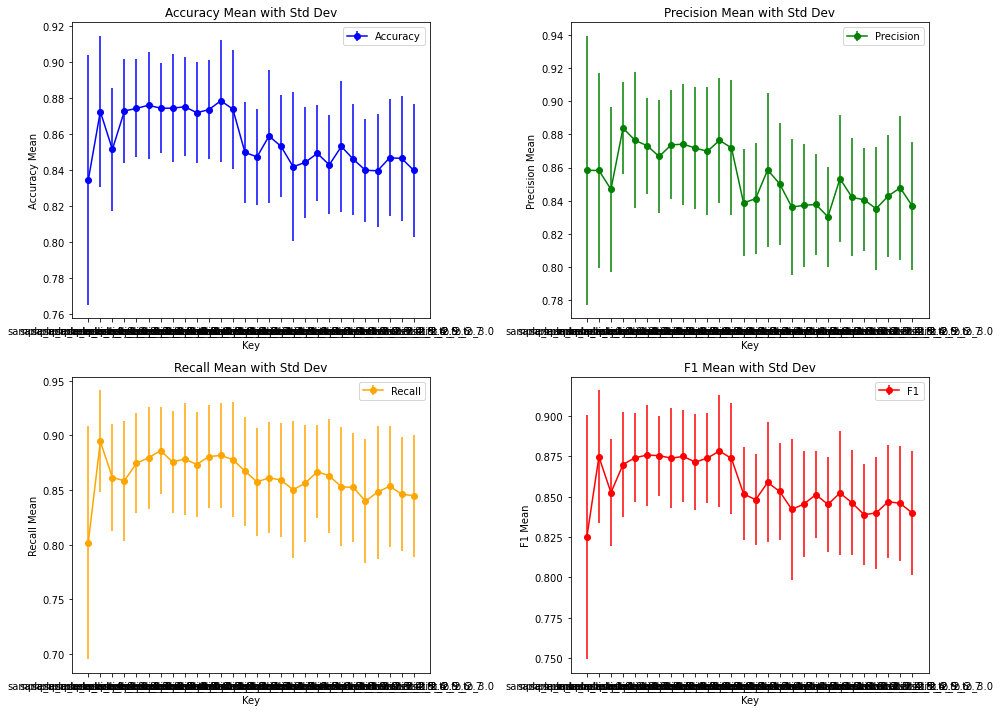

In [18]:
keys = list(classifier_dict.keys())

# Extracting metric values for plotting
acc_means = [classifier_dict[key]['acc_mean'] for key in keys]
acc_std_devs = [classifier_dict[key]['acc_std_dev'] for key in keys]

prec_means = [classifier_dict[key]['prec_mean'] for key in keys]
prec_std_devs = [classifier_dict[key]['prec_std_dev'] for key in keys]

recall_means = [classifier_dict[key]['recall_mean'] for key in keys]
recall_std_devs = [classifier_dict[key]['recall_std_dev'] for key in keys]

f1_means = [classifier_dict[key]['f1_mean'] for key in keys]
f1_std_devs = [classifier_dict[key]['f1_std_dev'] for key in keys]

# Plotting
plt.figure(figsize=(14, 10))

# Accuracy Mean with Std Dev
plt.subplot(2, 2, 1)
plt.errorbar(keys, acc_means, yerr=acc_std_devs, fmt='-o', color='blue', label='Accuracy')
plt.title('Accuracy Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Accuracy Mean')
plt.legend()

# Precision Mean with Std Dev
plt.subplot(2, 2, 2)
plt.errorbar(keys, prec_means, yerr=prec_std_devs, fmt='-o', color='green', label='Precision')
plt.title('Precision Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Precision Mean')
plt.legend()

# Recall Mean with Std Dev
plt.subplot(2, 2, 3)
plt.errorbar(keys, recall_means, yerr=recall_std_devs, fmt='-o', color='orange', label='Recall')
plt.title('Recall Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Recall Mean')
plt.legend()

# F1 Mean with Std Dev
plt.subplot(2, 2, 4)
plt.errorbar(keys, f1_means, yerr=f1_std_devs, fmt='-o', color='red', label='F1')
plt.title('F1 Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('F1 Mean')
plt.legend()

plt.tight_layout()
plt.show()